# Learning RL interface guide

Unified interface for RL algorithms. 
Code compiled from different sources:
* RL Adventure [part 1](https://github.com/higgsfield/RL-Adventure), [part 2](https://github.com/higgsfield/RL-Adventure-2) - (carefull, a lot of bugs!)
* [Deep RL Tutorials](https://github.com/qfettes/DeepRL-Tutorials)

In [1]:
from LRL import *

In [2]:
import gym
import gym.spaces        # to avoid warnings
gym.logger.set_level(40) # to avoid warnings

# Playing games inline

In [3]:
env = gym.make('CartPole-v0')

Agent is base class for all algorithms. 

In [4]:
agent = Agent(env)

Agent can play game in silent mode, render it inline or record all game frames and display as animation.

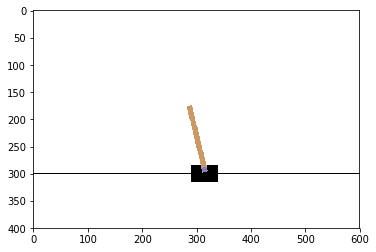

13.0

In [5]:
agent.play(render=True)


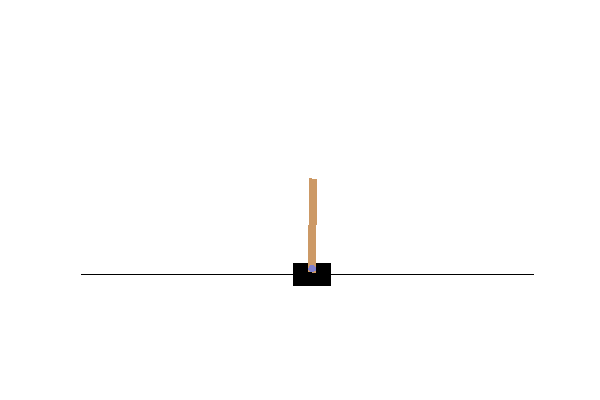
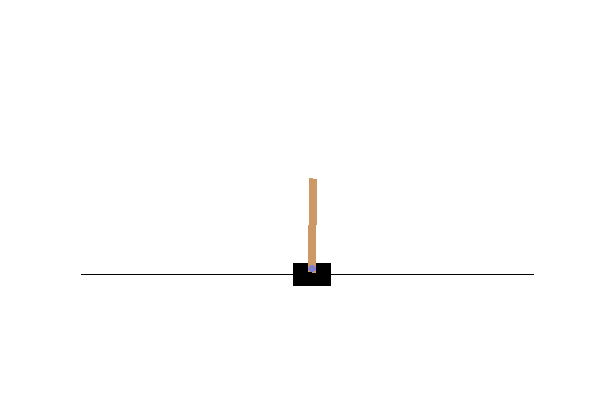
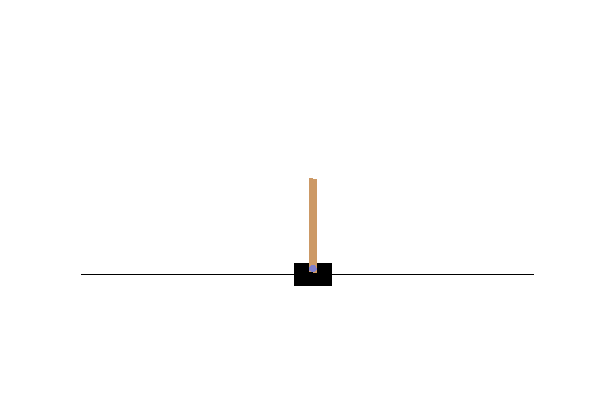
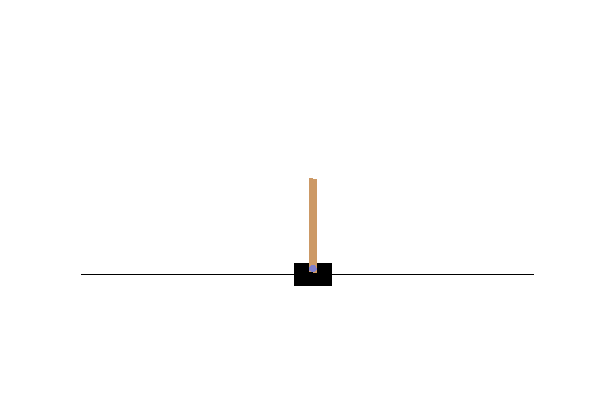
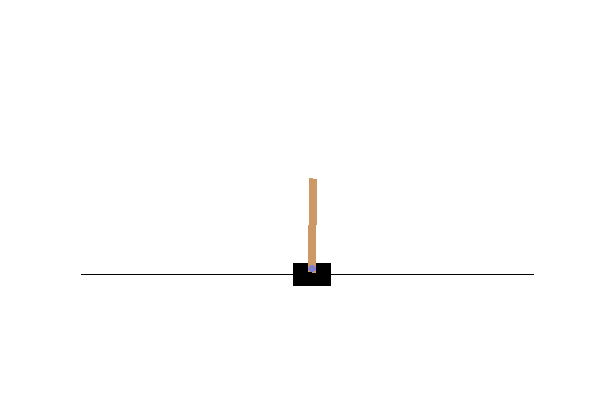
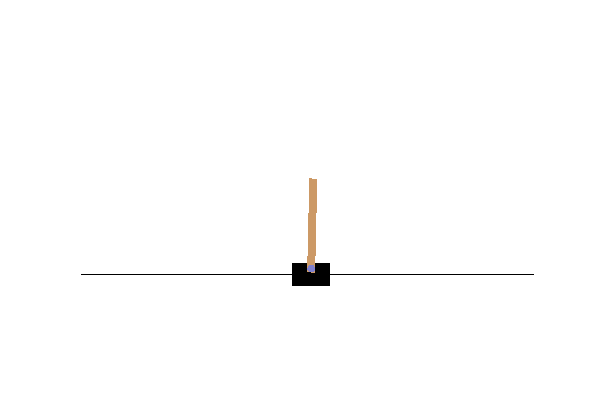
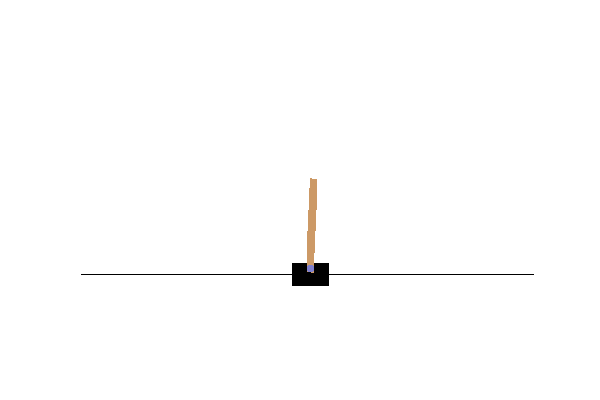
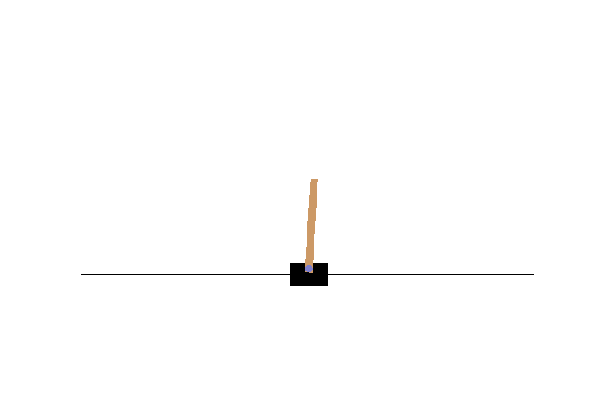
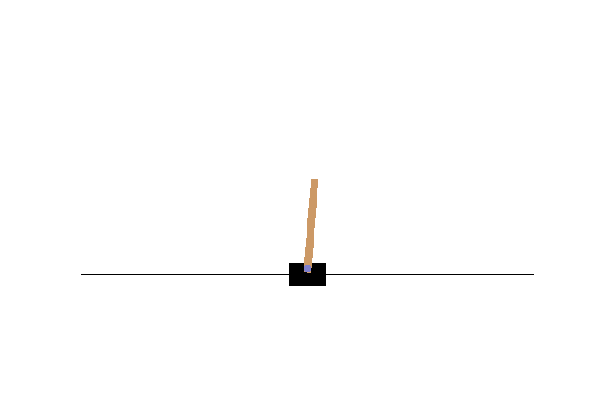
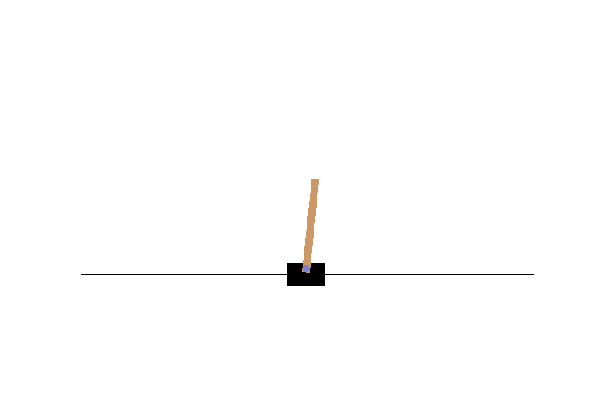
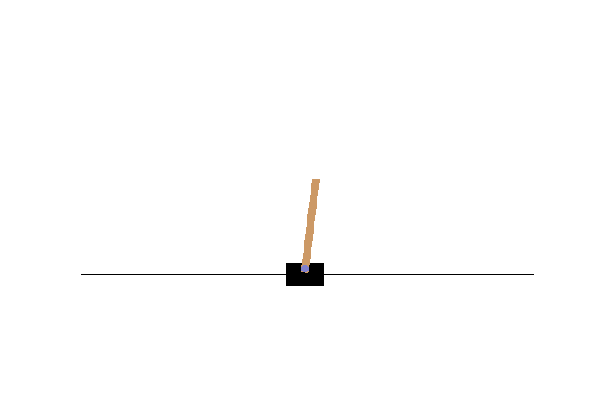
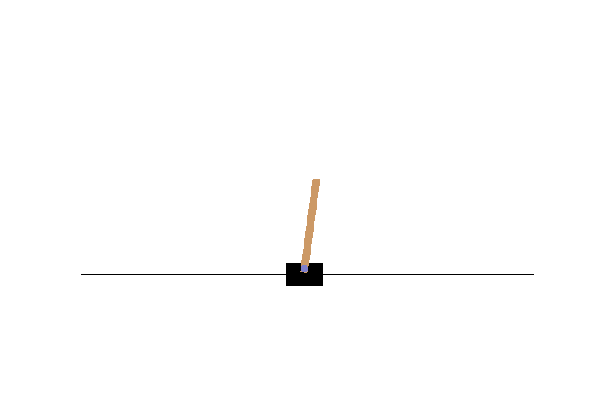
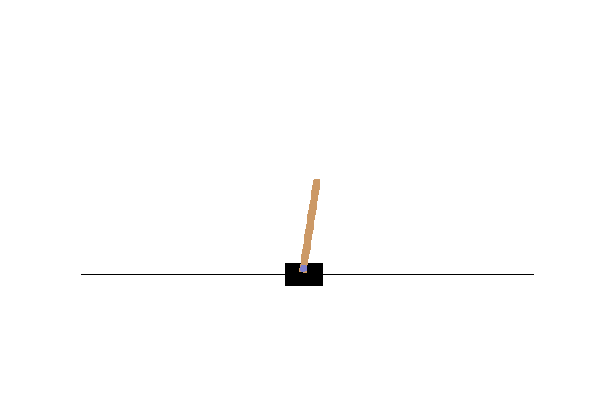
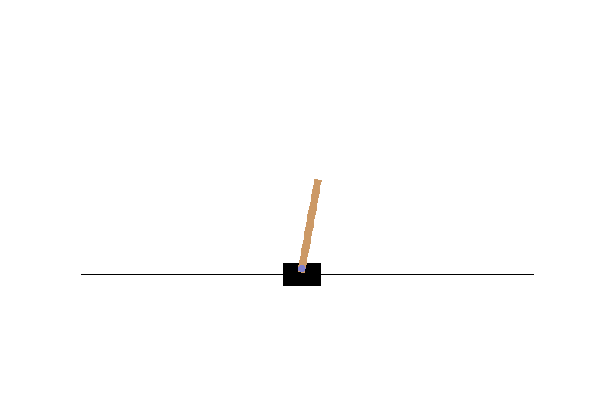
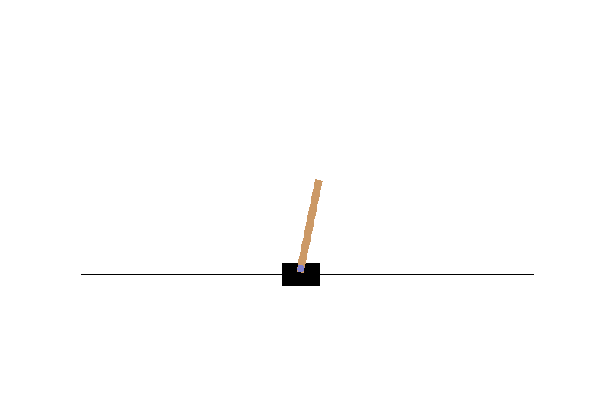
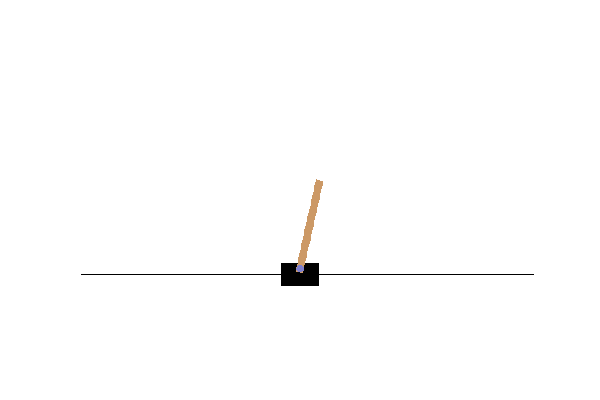

15.0

In [6]:
agent.play(record=True)

### Log and saving

When games are played with flag learn=True, statistics are logged. Basic agent logs rewards:

In [7]:
agent.rewards_log

[13.0, 15.0]

Agent (including his logs) can be saved and loaded:

In [8]:
agent.save("cartpole random agent")

In [9]:
agent = Agent(env)
agent.load("cartpole random agent")

In [10]:
agent.rewards_log

[13.0, 15.0]

In [11]:
env.close()  # not calling this causes problems on windows

# Lego principles

Agents can be constructed by dynamically inheriting algorithms from one another. For example, e-greedy exploration strategy needs just to overload "act" method and call parent's method with $\varepsilon$ probability. To allow to add e-greedy exploration in any agent, some **python magic** is used:

### Some magic python example:

In [12]:
def test(parclass):
    class C(parclass):
        def foo(self):
            print(self.var)
    return C

class A:
    def __init__(self, val):
        self.var = val
        
class B:
    def __init__(self):
        self.var = "hi!"

In [13]:
test(A)(val=179).foo()

179


In [14]:
test(B)().foo()

hi!


Consider classic [atari using DQN example](https://www.cs.toronto.edu/~vmnih/docs/dqn.pdf). It uses deep q-learning with replay memory, e-greedy exploration and target network heuristics. We can create an agent class using these ingreedients:

In [15]:
AgentType = eGreedy(TargetQAgent(QAgent(ReplayBufferAgent)))
AgentType?

# Training on cartpole

In [16]:
env = gym.make('CartPole-v0')

Agent requires class of feature extractor network as parameter. DQN will provide it with parameter "linear", which will be standard Torch nn.Linear module or noisy version of it. 

In [17]:
class BasicNetwork(nn.Module):
    def __init__(self, linear):
        super().__init__()
        self.layers = nn.Sequential(
                        linear(4, 128),
                        nn.ReLU(),
                        linear(128, 128),
                        nn.ReLU())
        
    def forward(self, x):
        return self.layers(x)

Qnetwork heads are already provided:
* **Qnetwork** - basic head outputing quality of each action
* **DuelingQnetwork** - dueling version
* **CategoricalQnetwork** - categorical version
* **DuelingCategoricalQnetwork** - categorical + dueling version

#### Agent initialization:

In [18]:
agent = eGreedy(TargetQAgent(QAgent(ReplayBufferAgent)))(env=env,
                FeatureExtractorNet=BasicNetwork, 
                features_size=128, 
                QnetworkHead = Qnetwork,
                noisy=False,
                target_update=100, 
                batch_size=32, 
                gamma=0.99,
                replay_buffer_init=128,
                replay_buffer_capacity=100000,
                epsilon_start = 1.0, epsilon_final = 0.01, epsilon_decay = 500)

#### Training

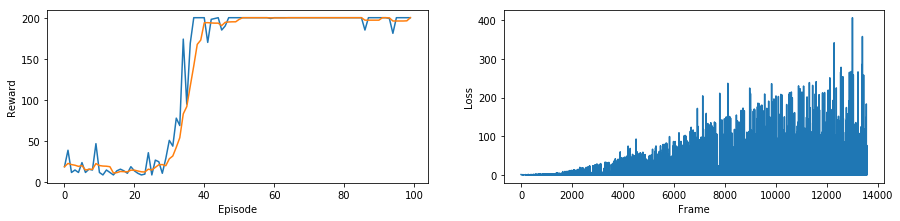

Complete
Wall time: 2min 30s


In [19]:
%%time
for i in range(100):
    agent.play()
    plot_durations(agent, 5)    

print('Complete')
plt.show()

#### Exploitation


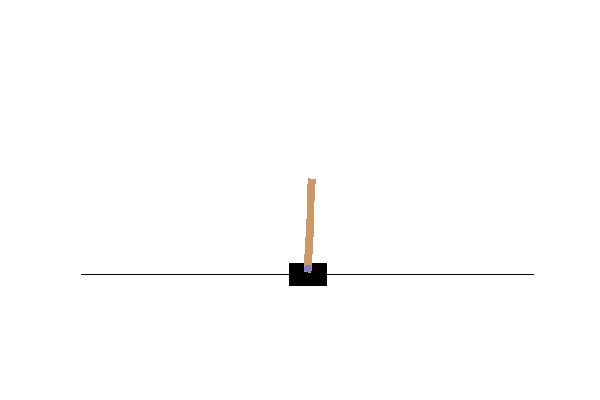
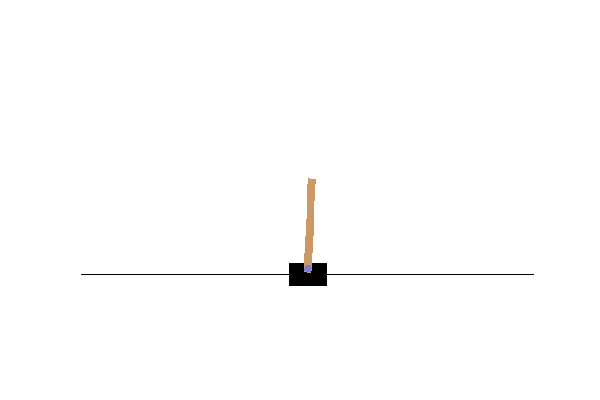
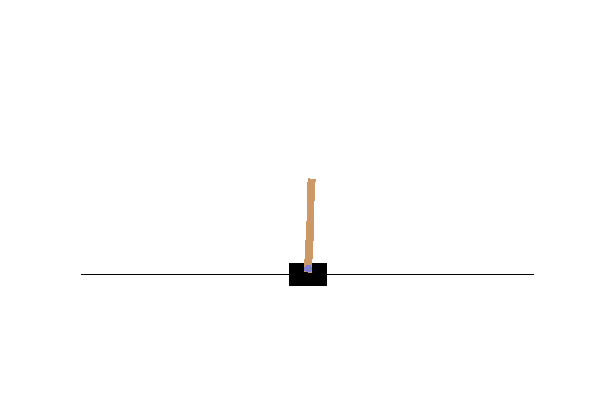
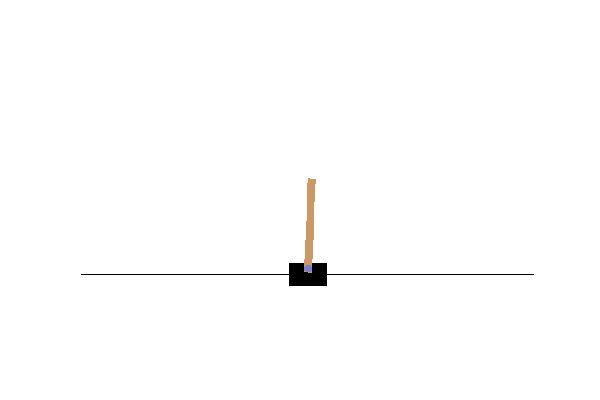
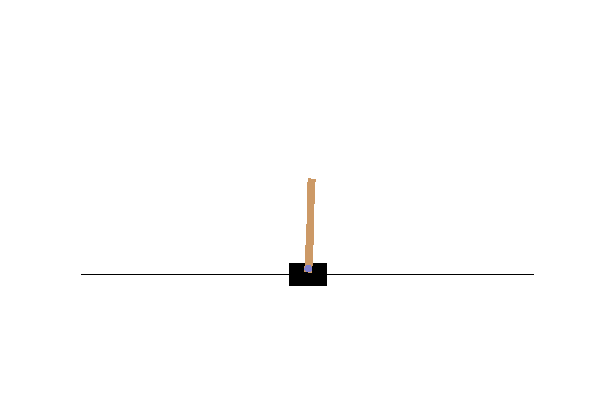
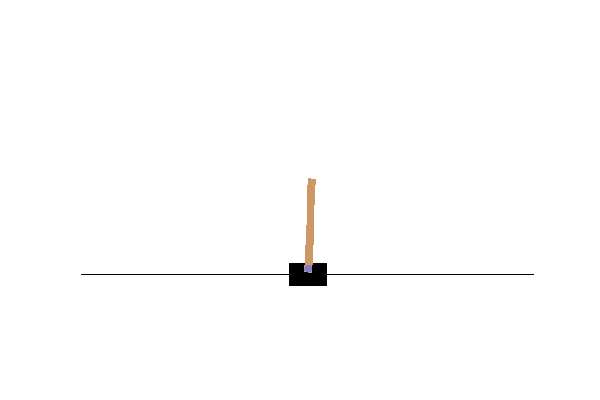
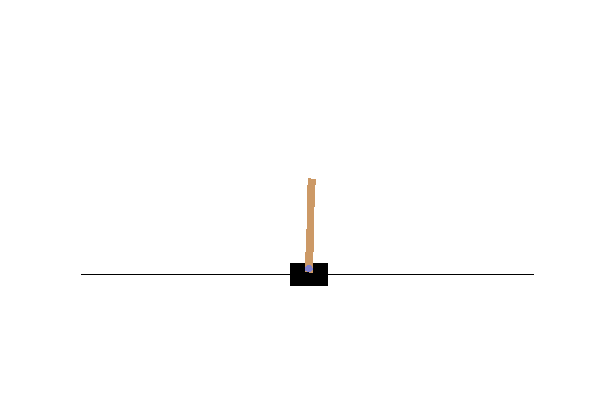
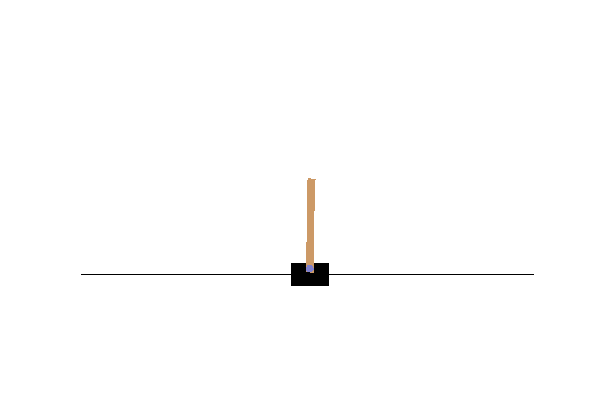
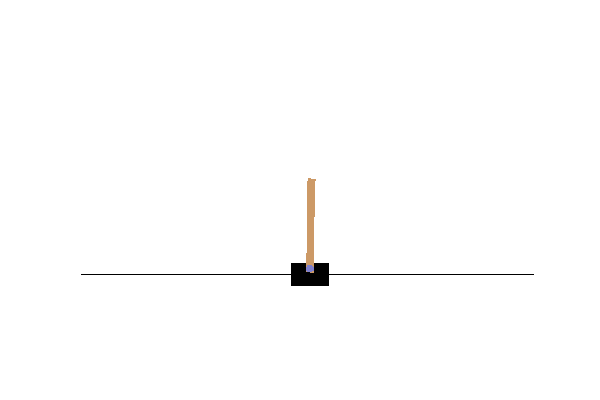
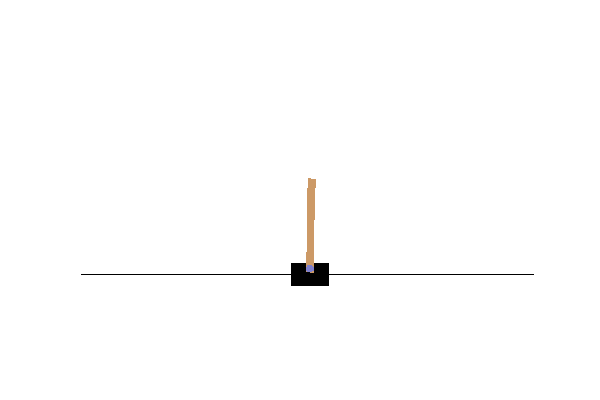
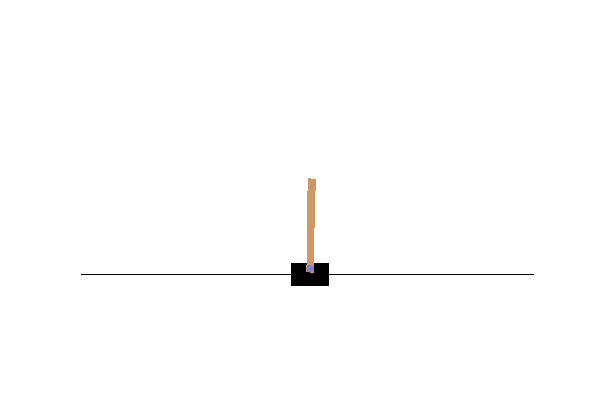
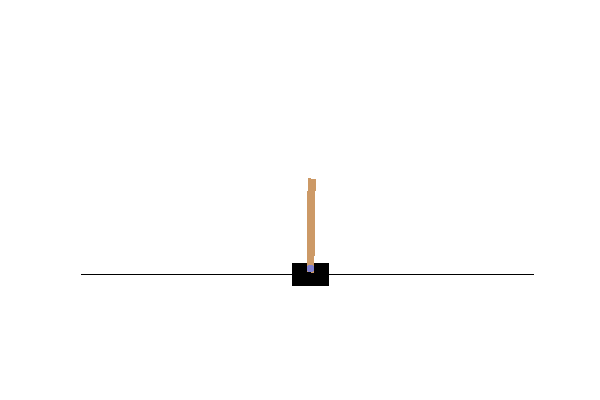
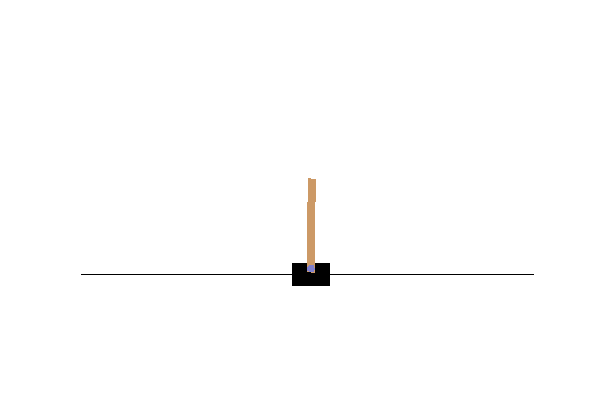
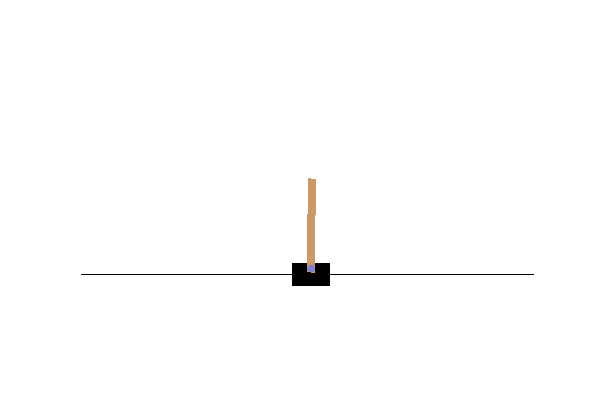
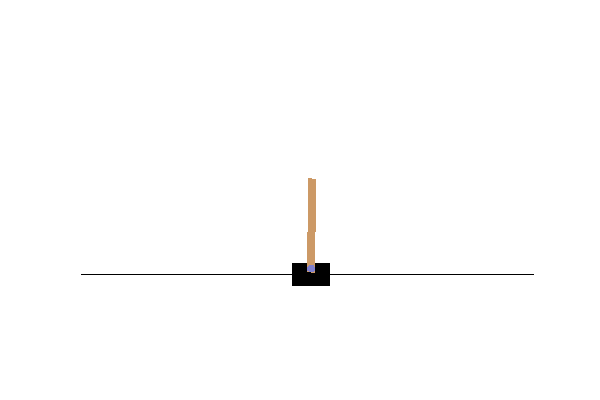
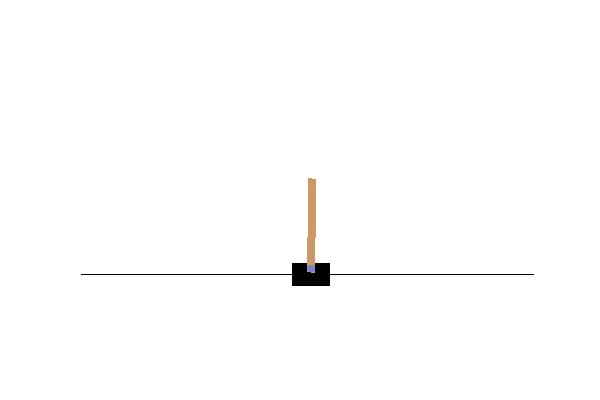
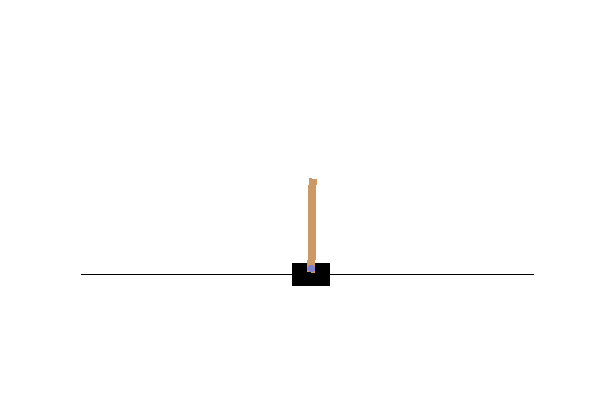
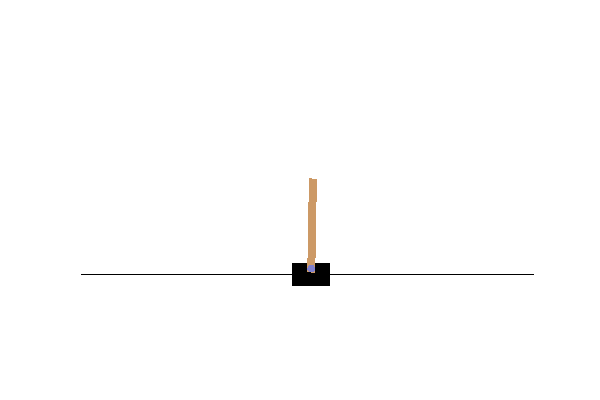
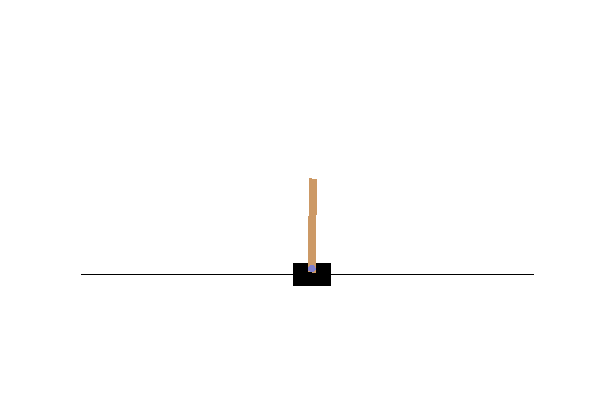
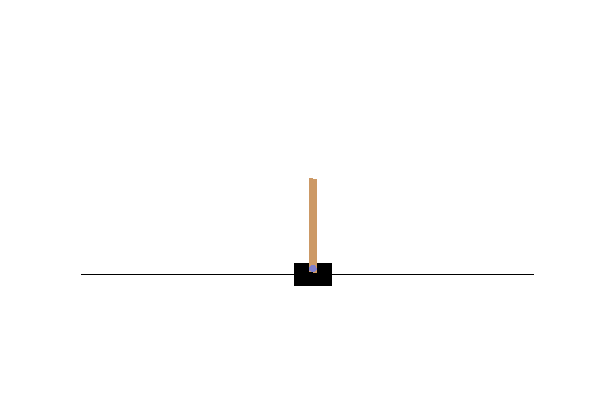
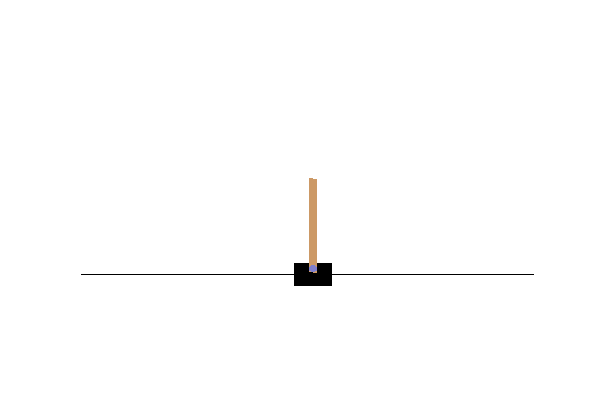
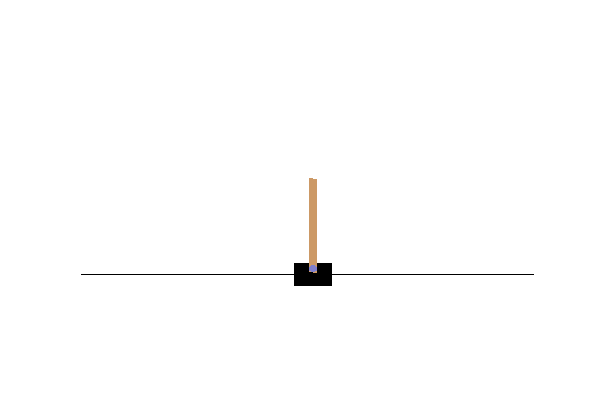
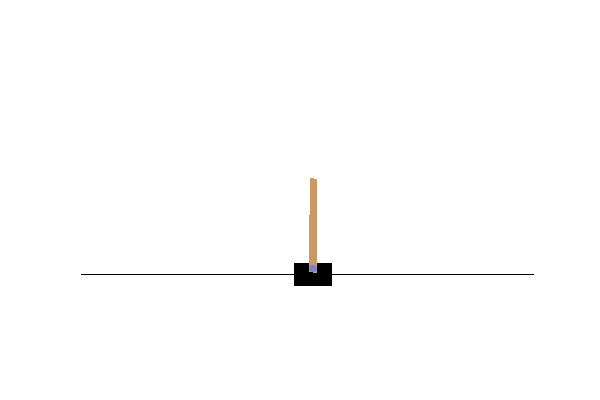
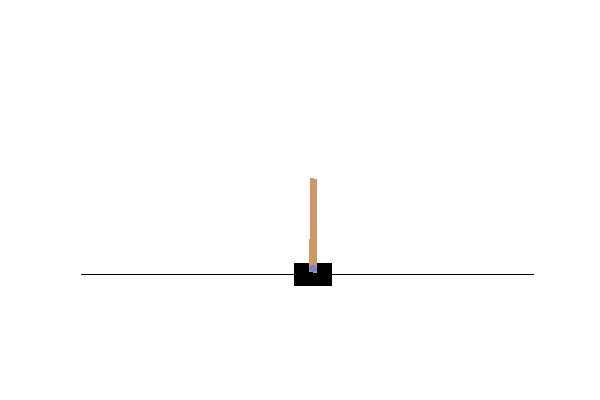
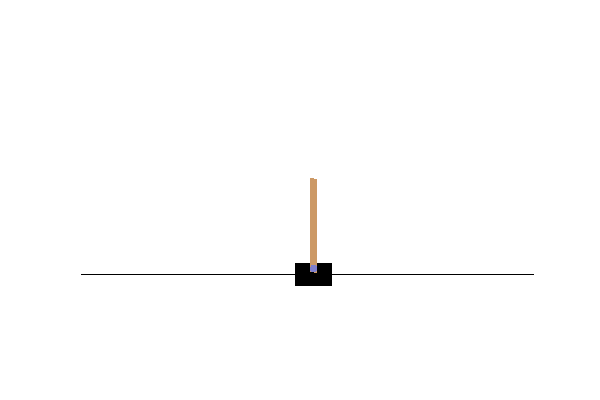
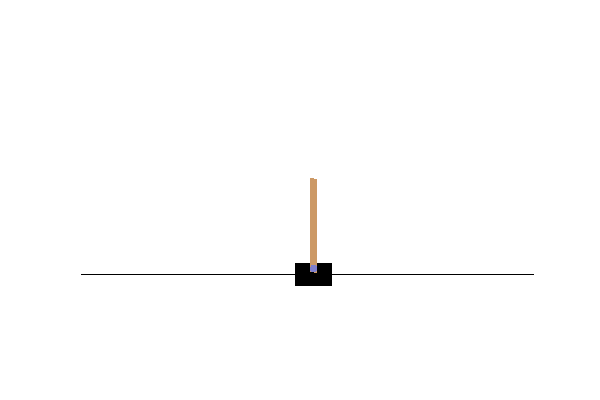
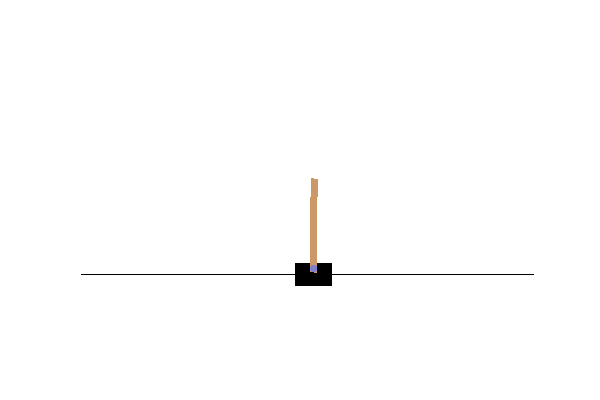
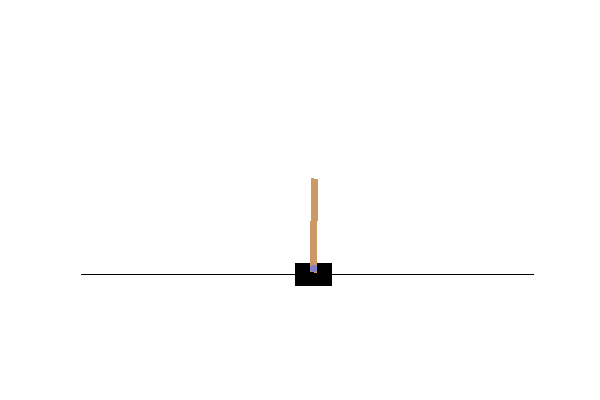
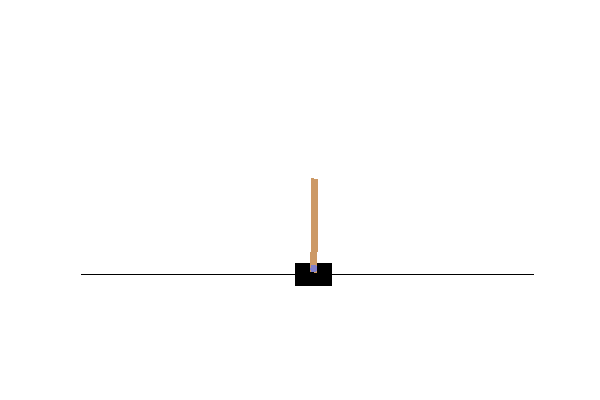
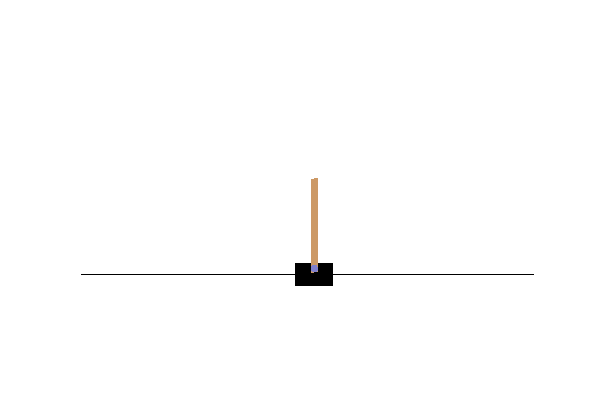
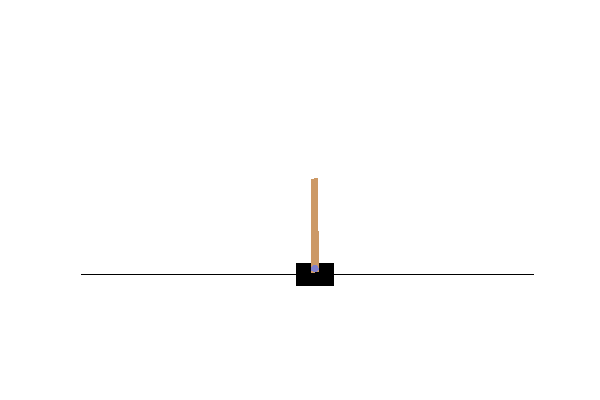
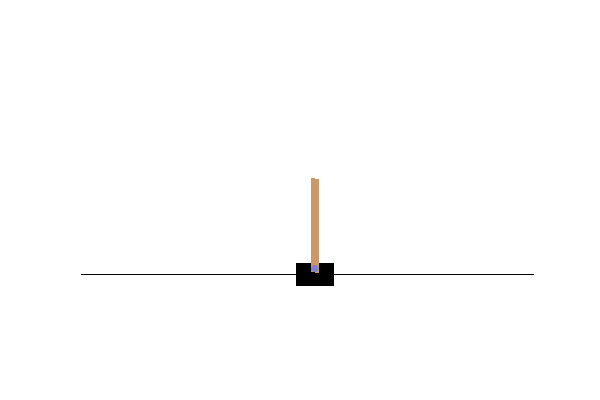
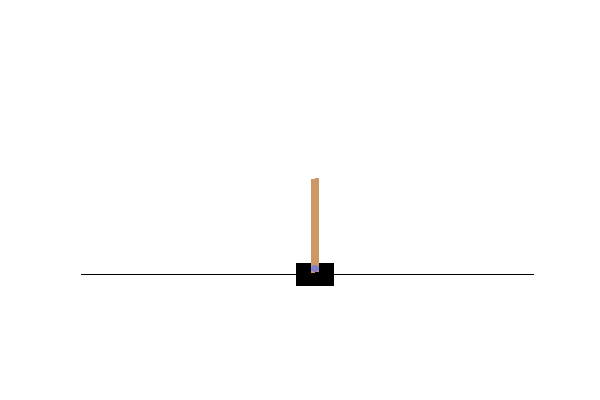
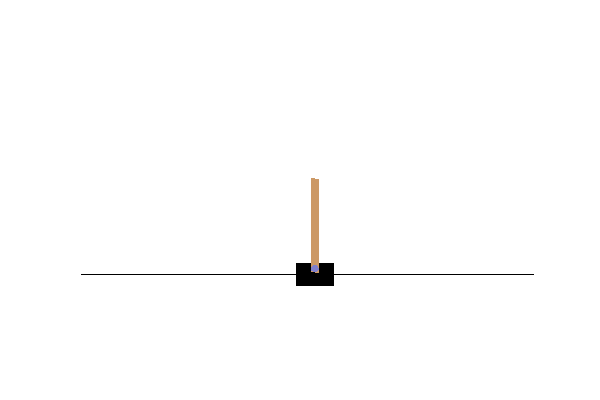
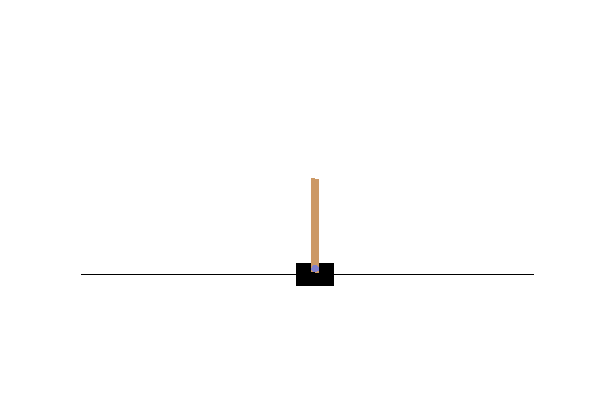
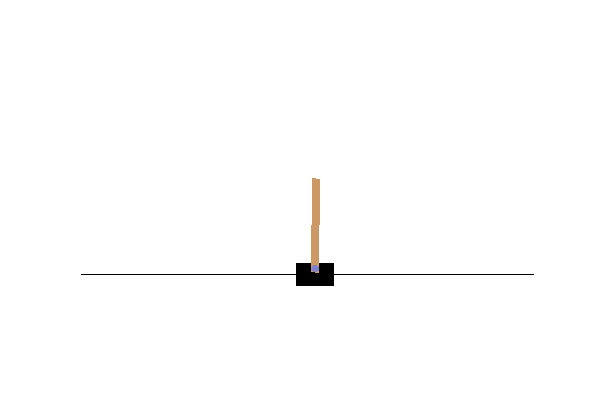
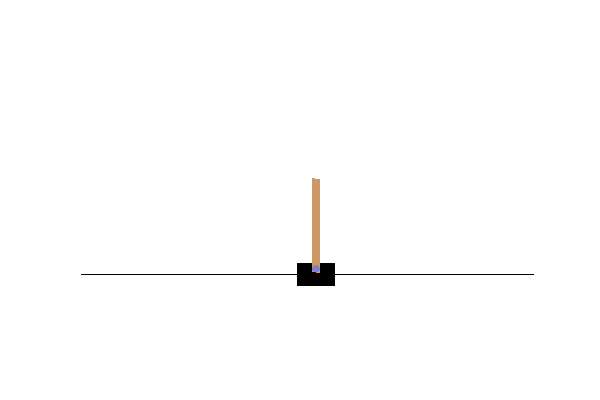
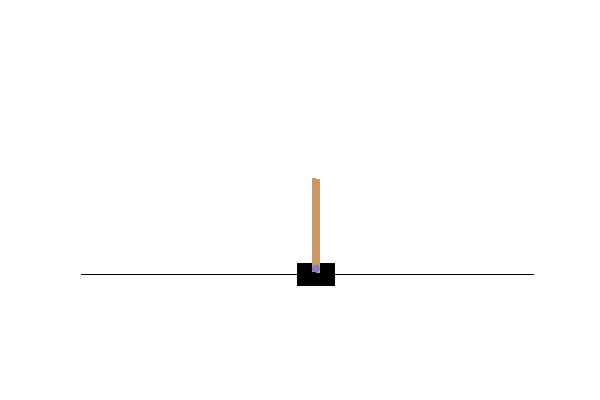
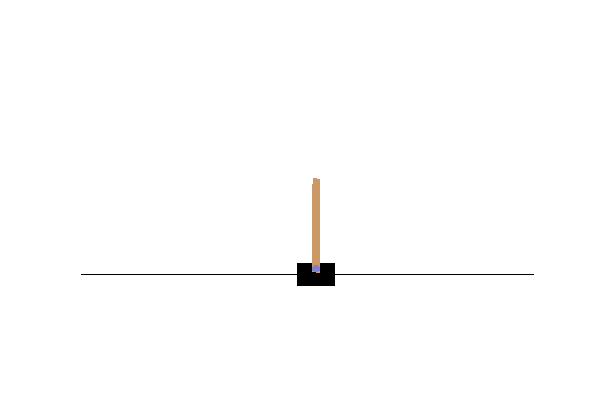
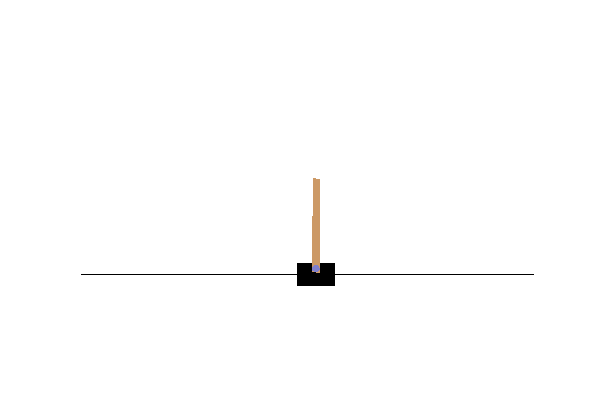
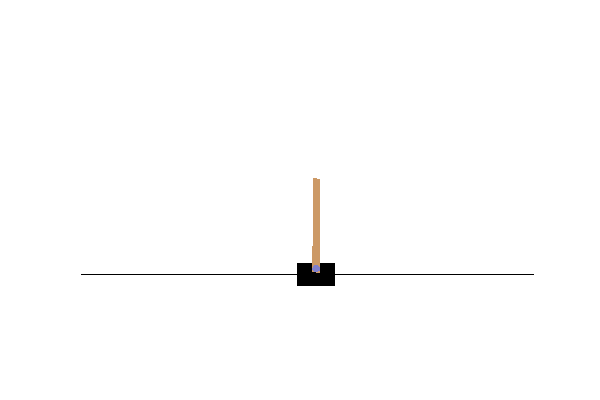
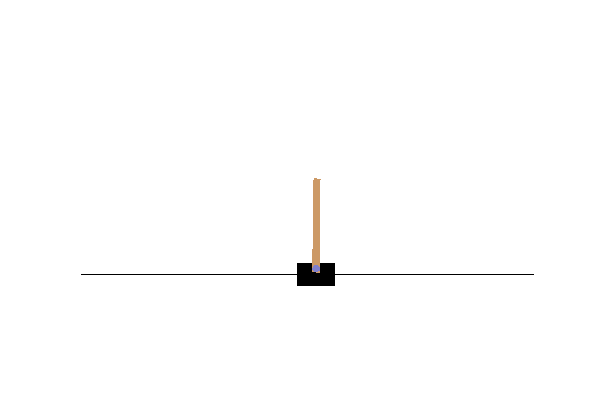
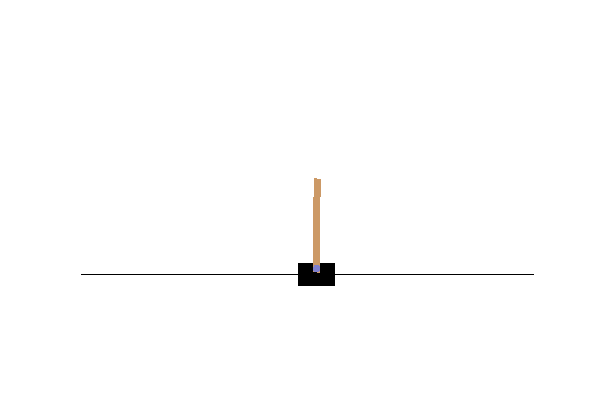
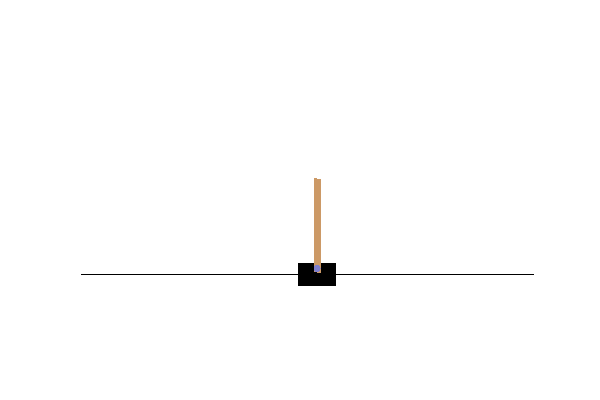
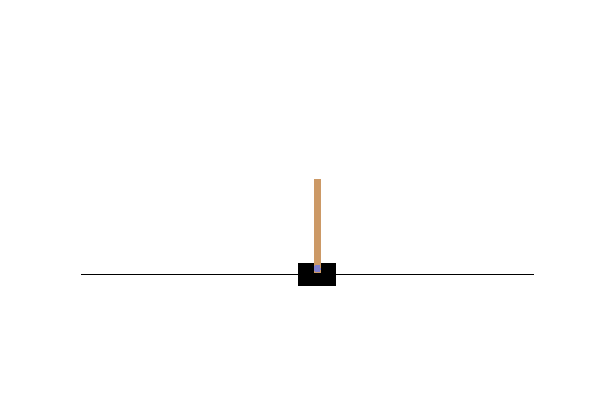
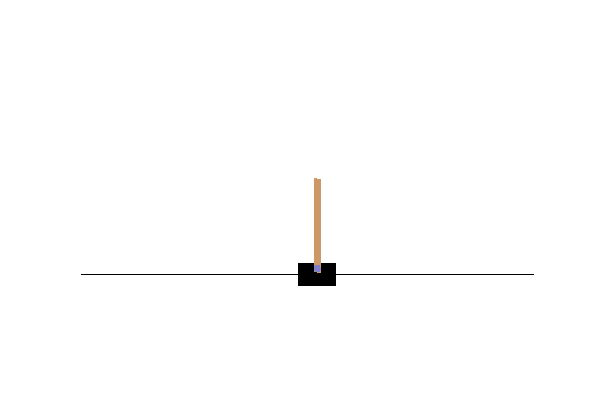
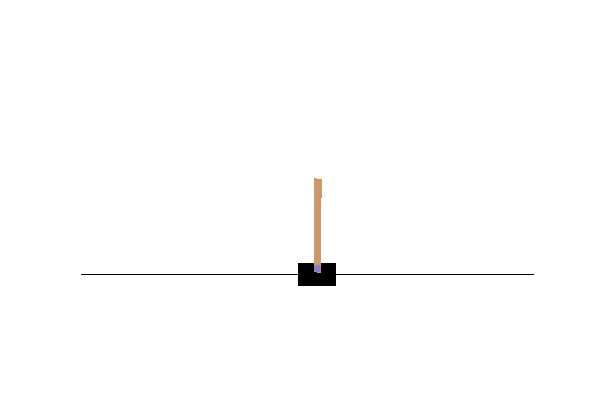
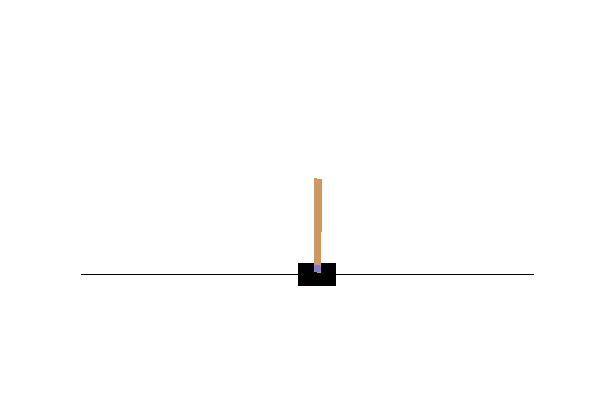
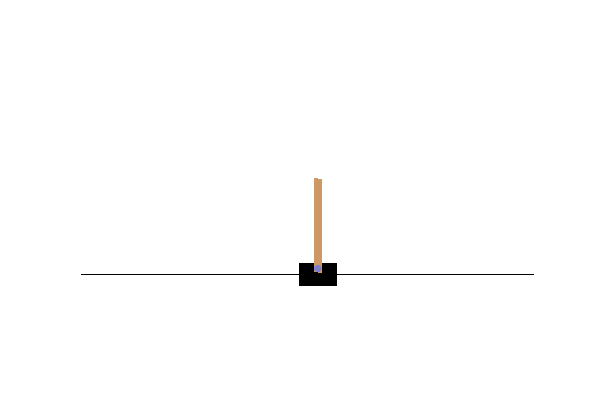
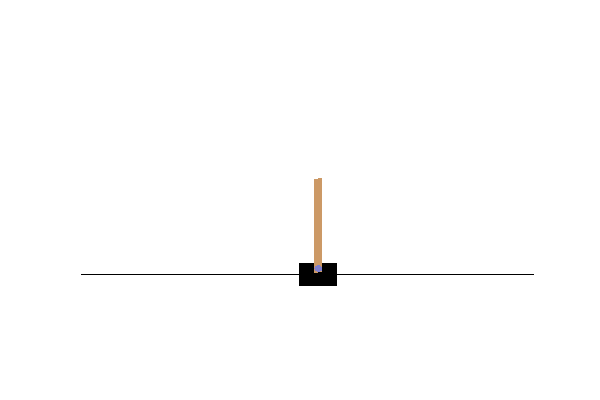
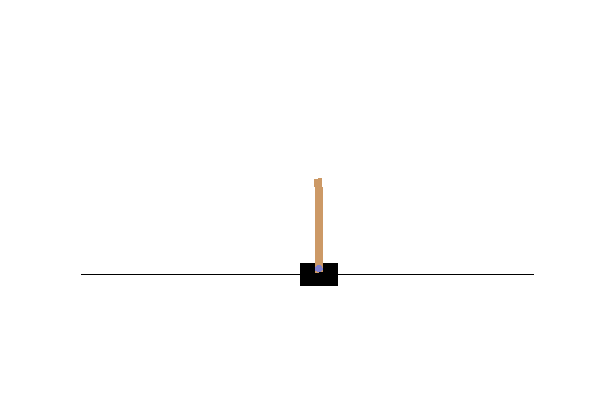
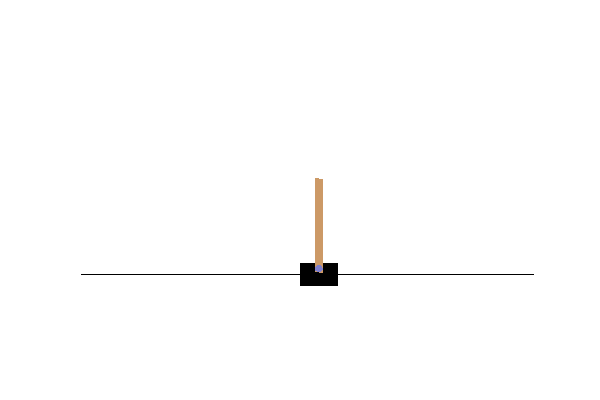
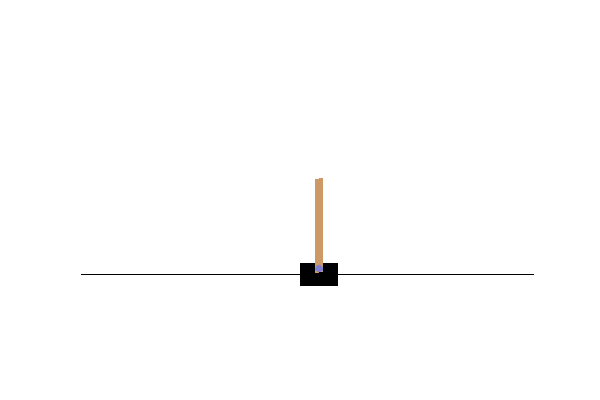
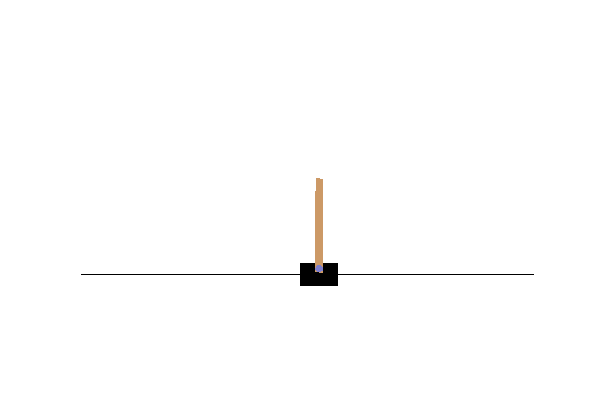
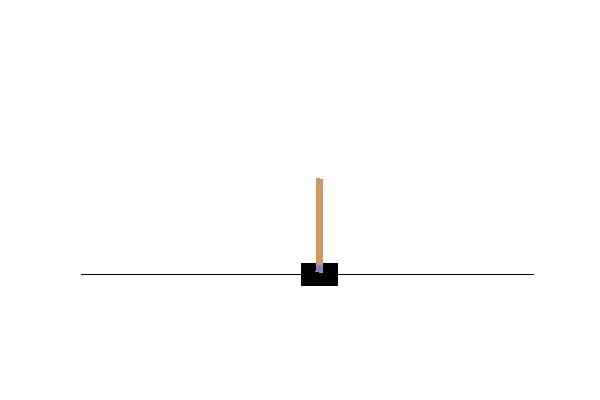
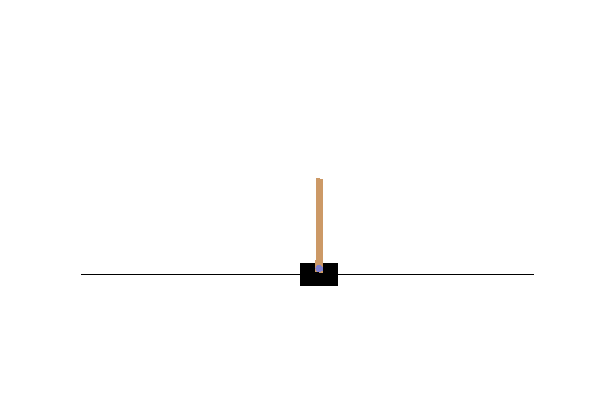
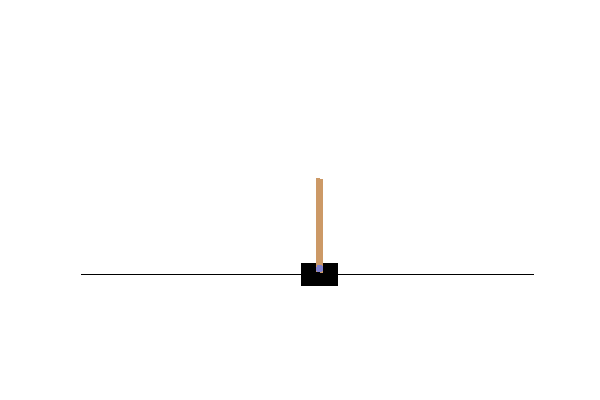
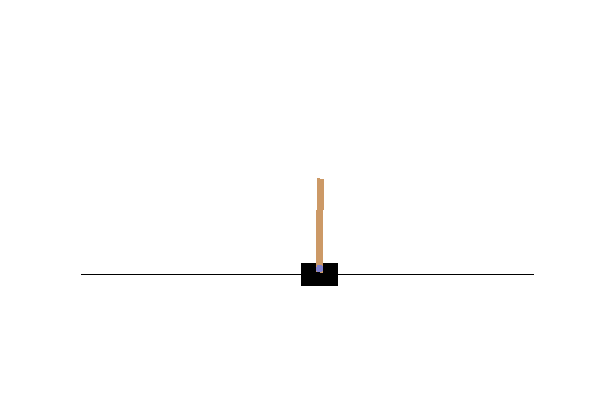
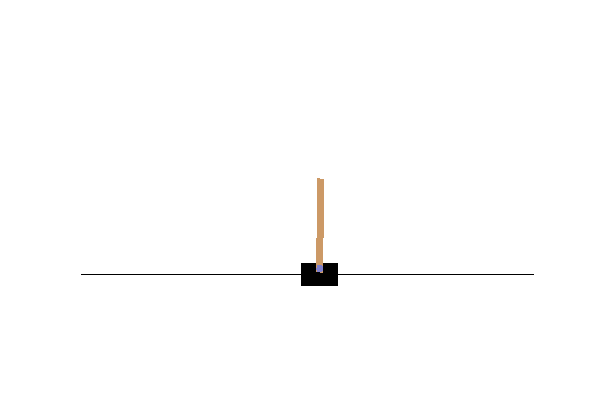
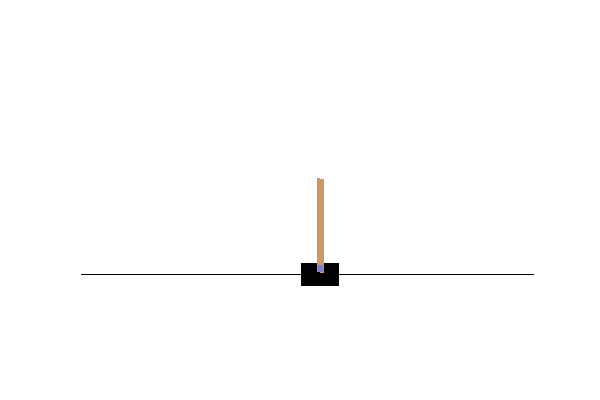
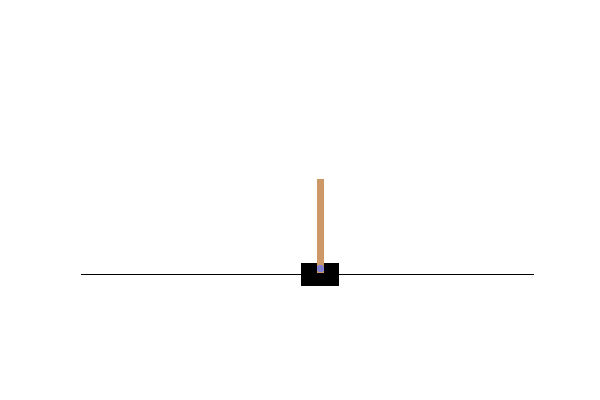
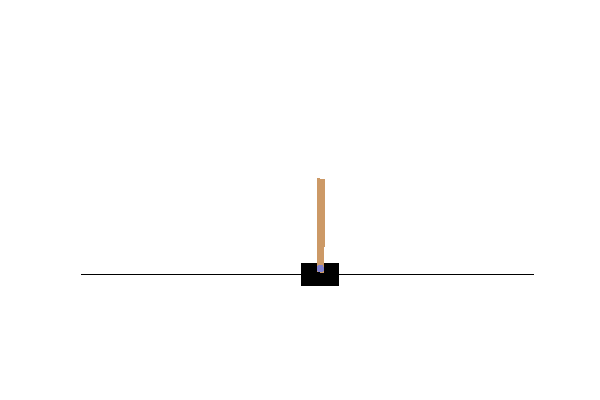
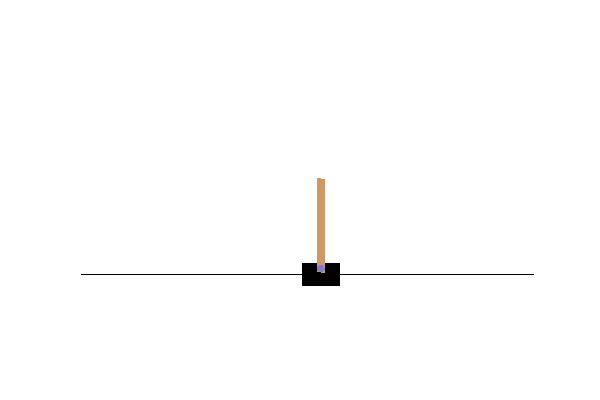
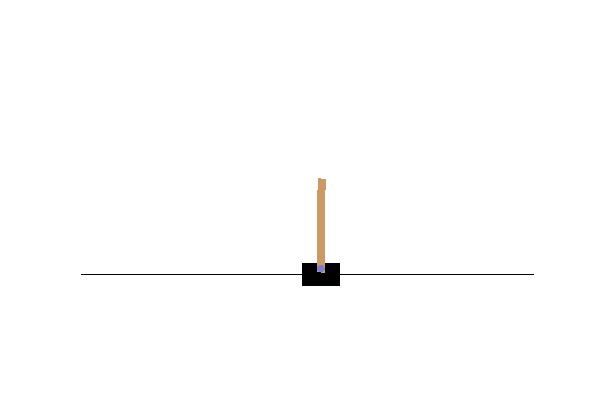
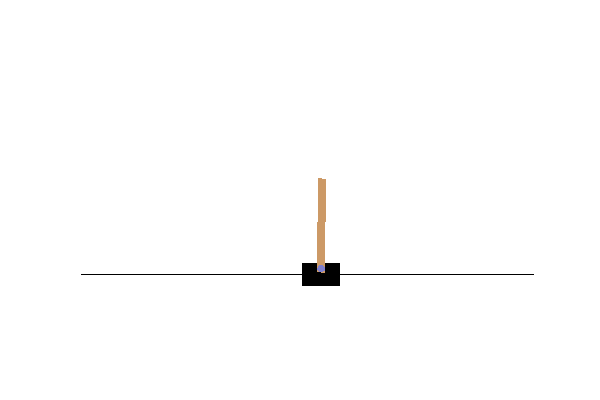
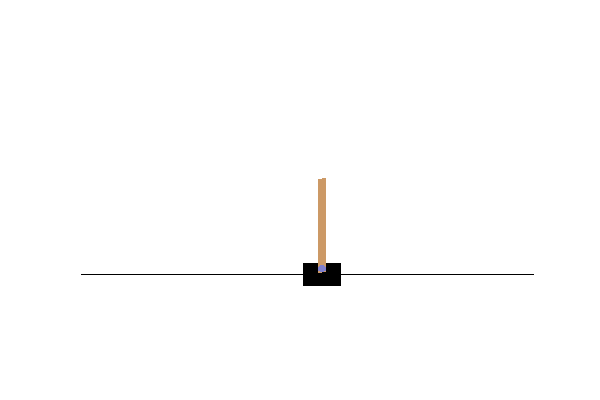
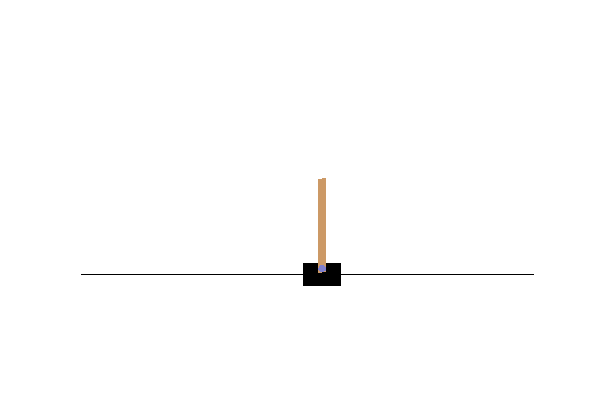
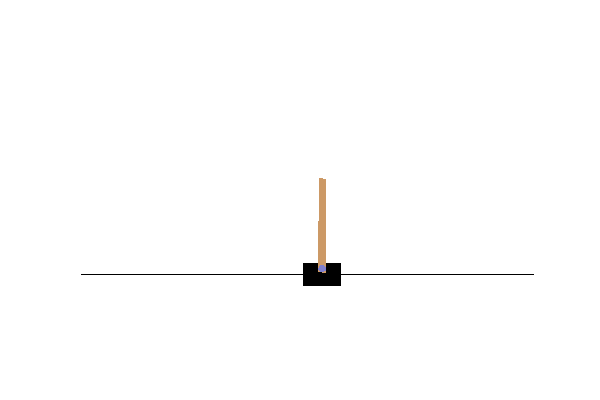
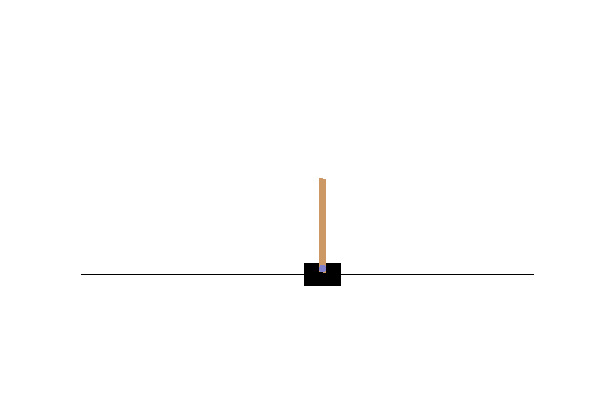
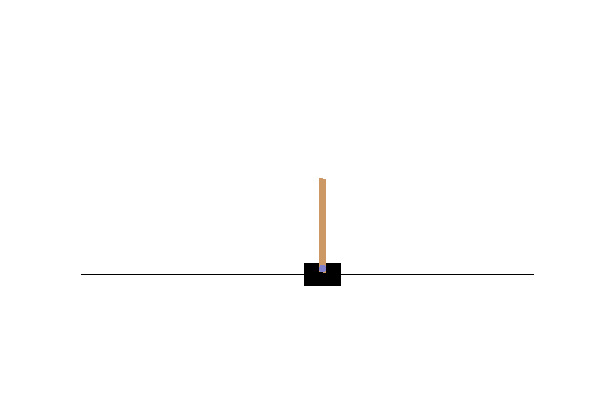
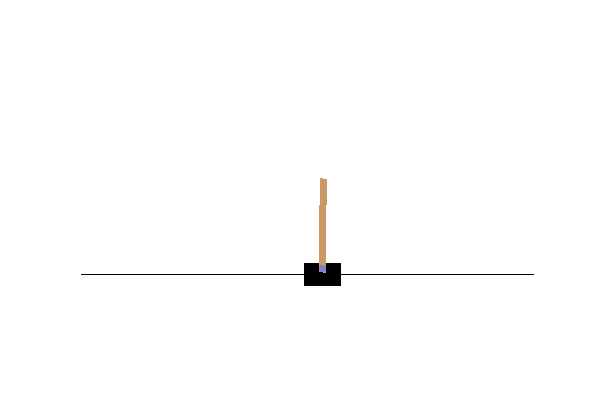
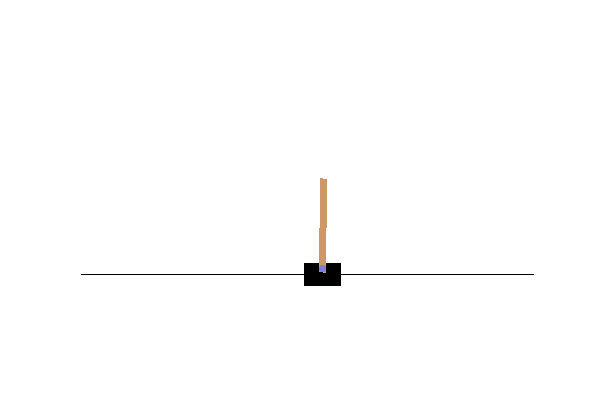
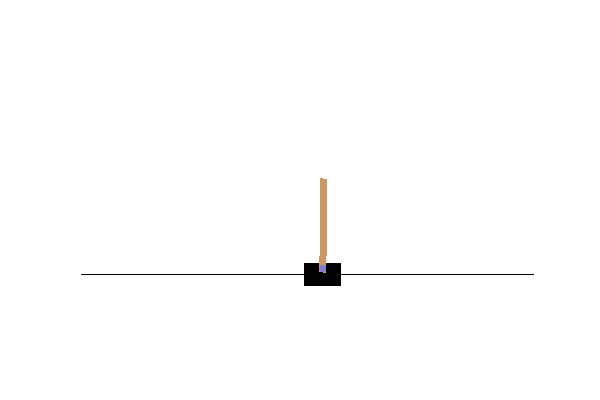
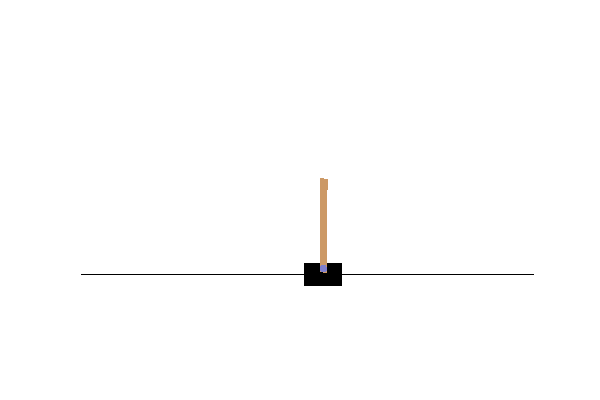
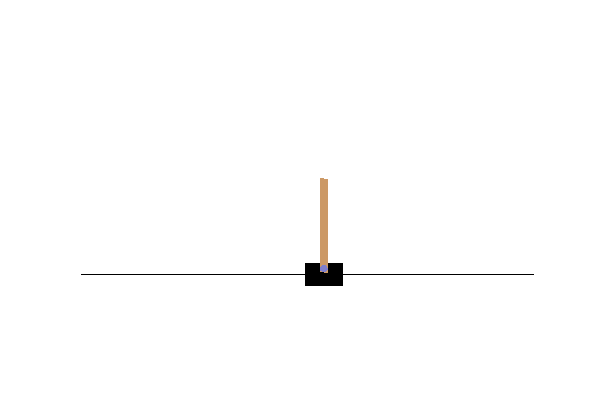
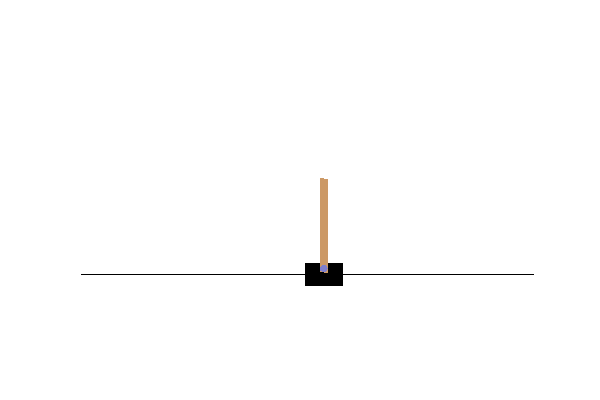
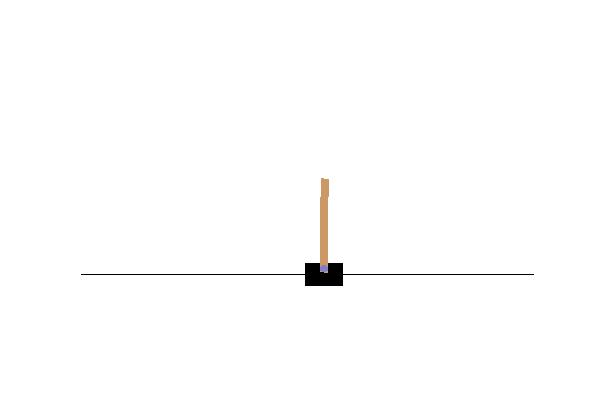
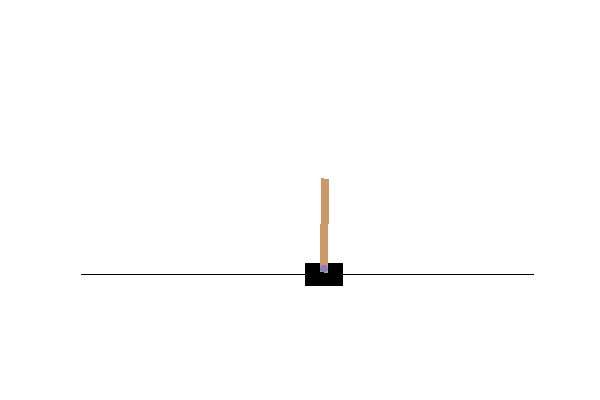
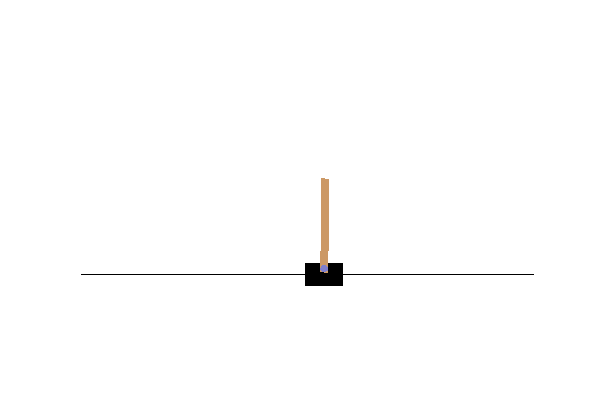
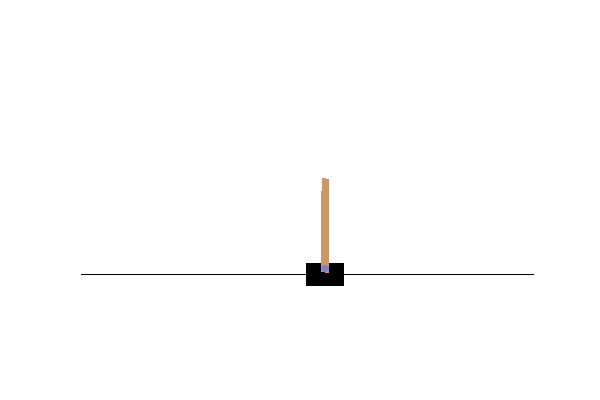
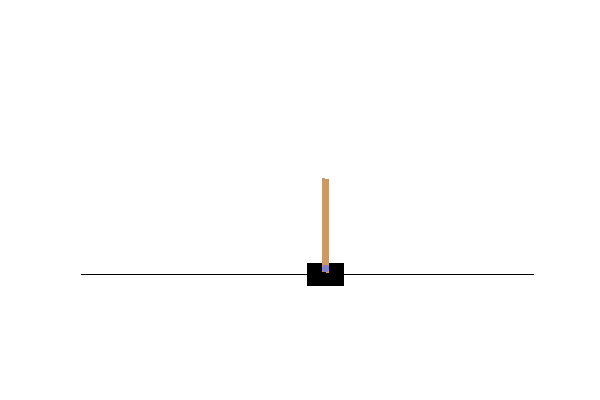
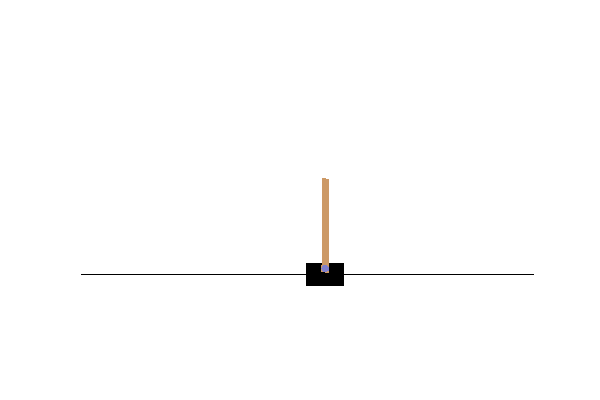
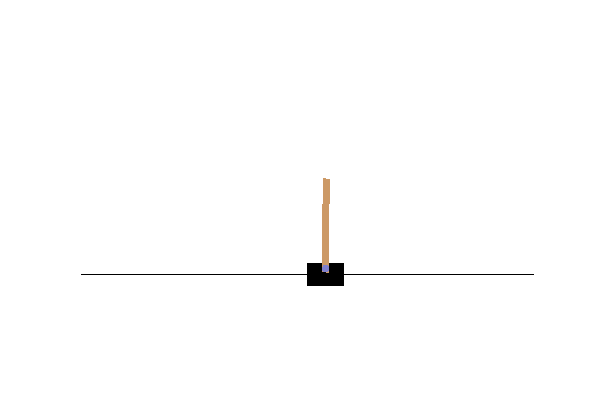
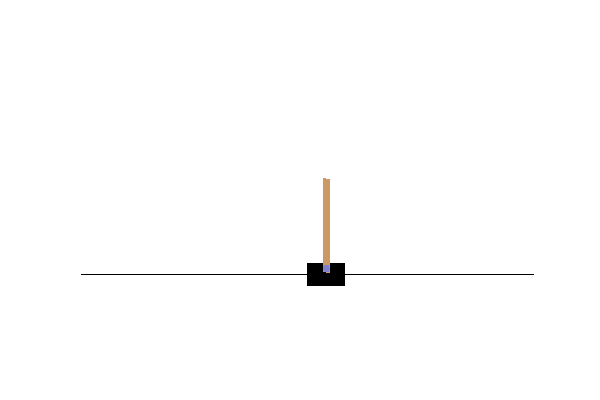
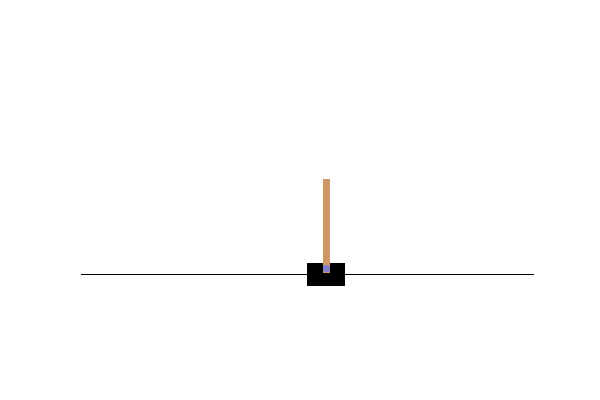
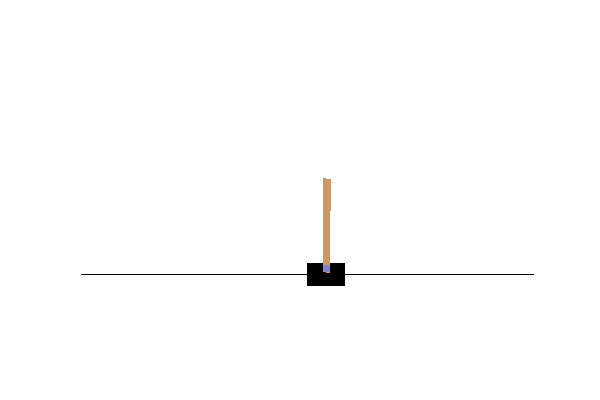
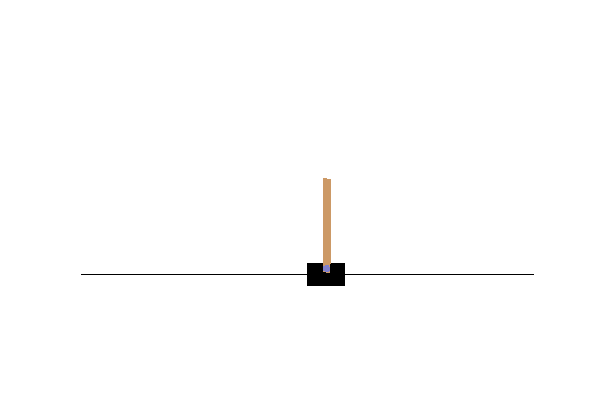
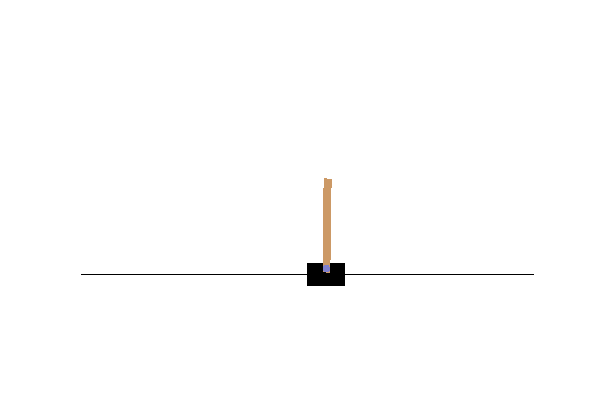
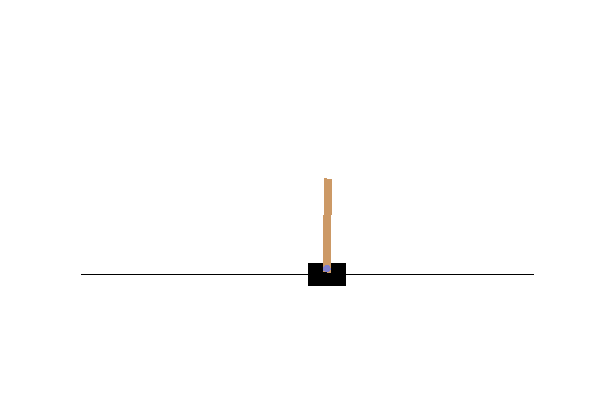
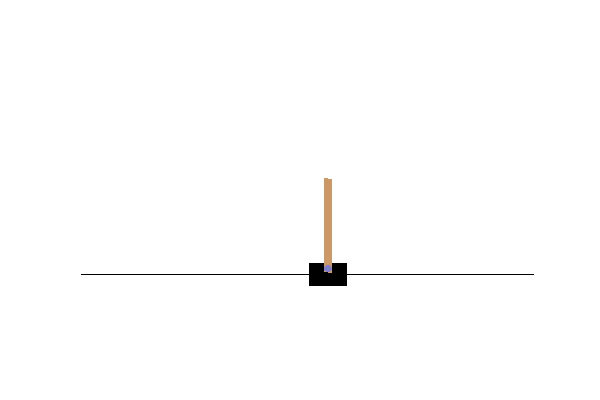
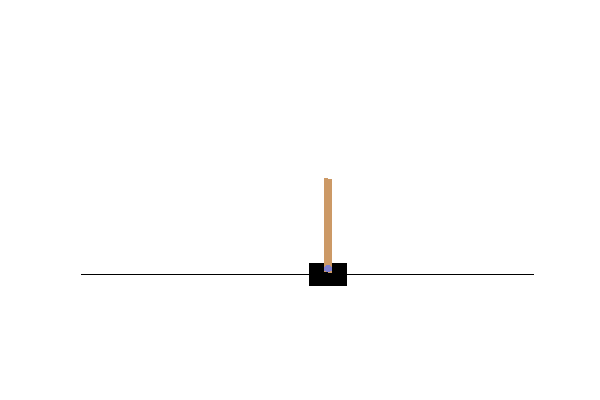
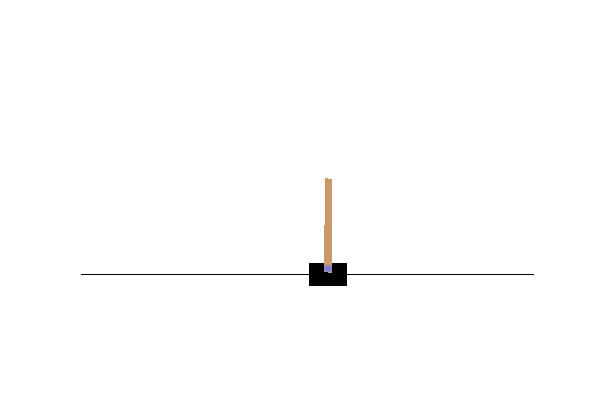
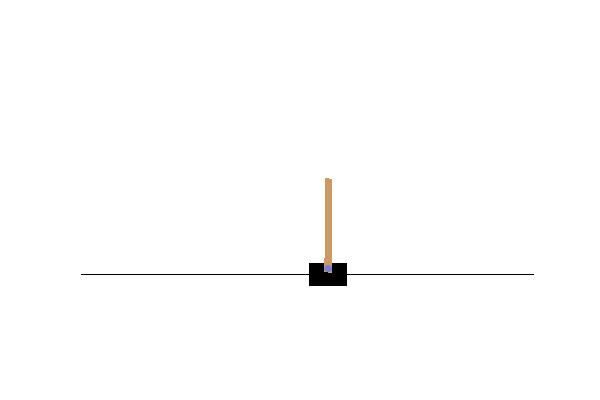
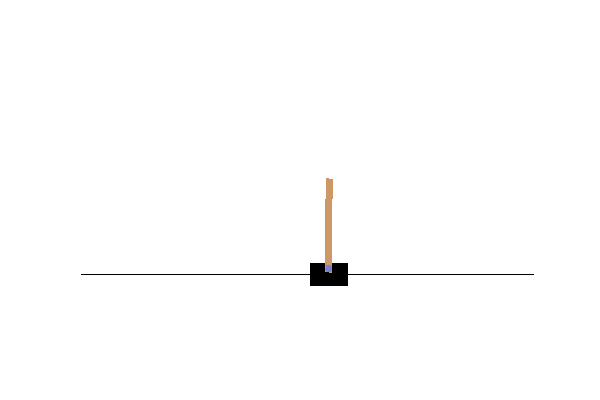
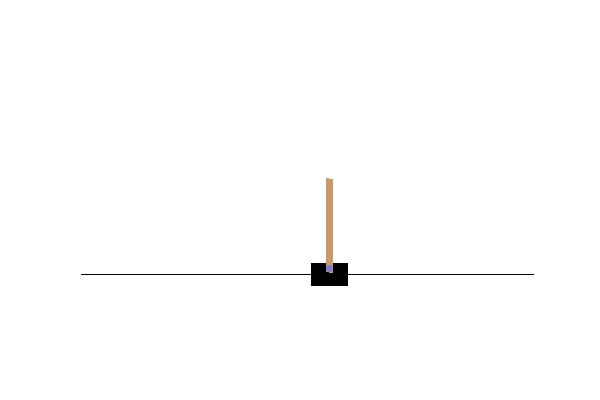
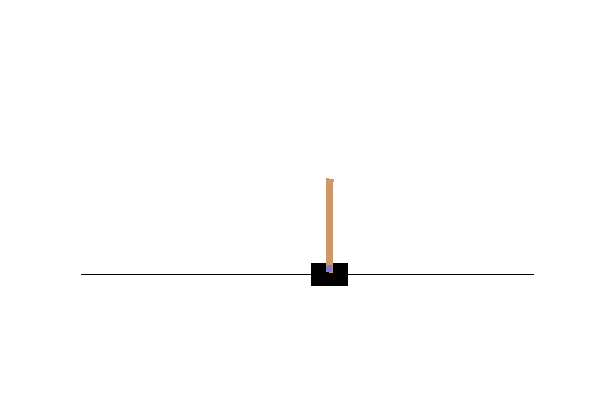
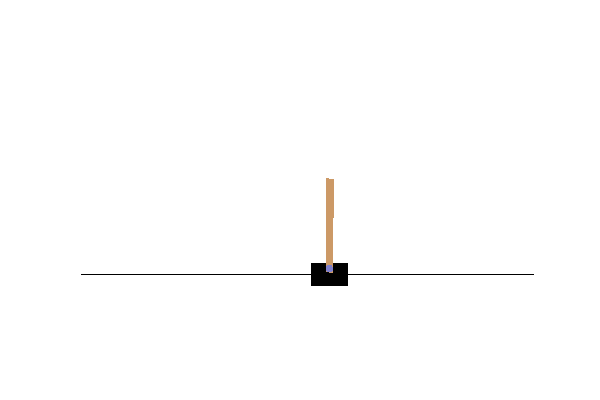
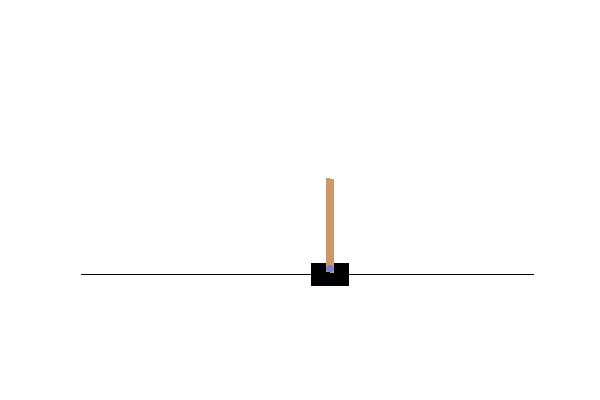
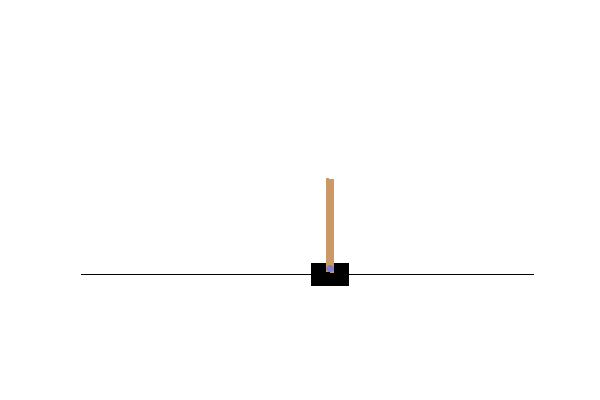
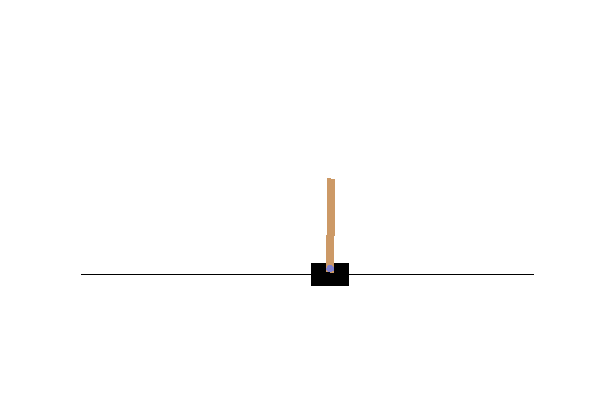
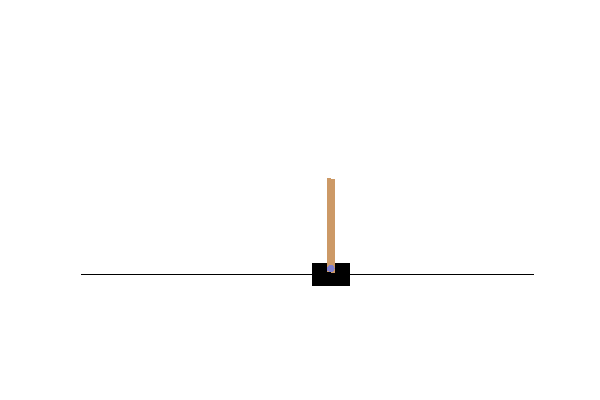
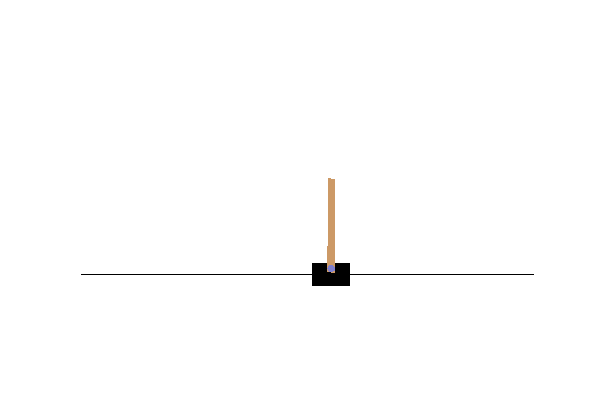
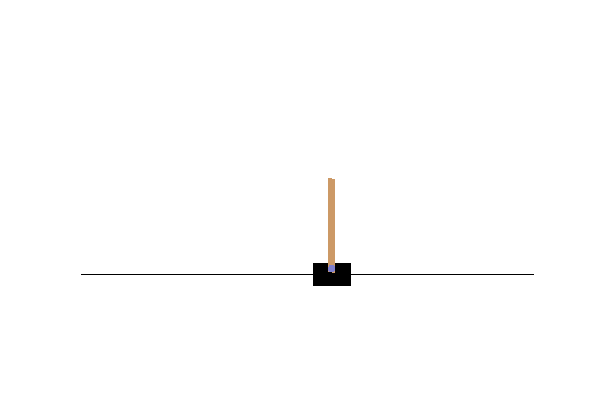
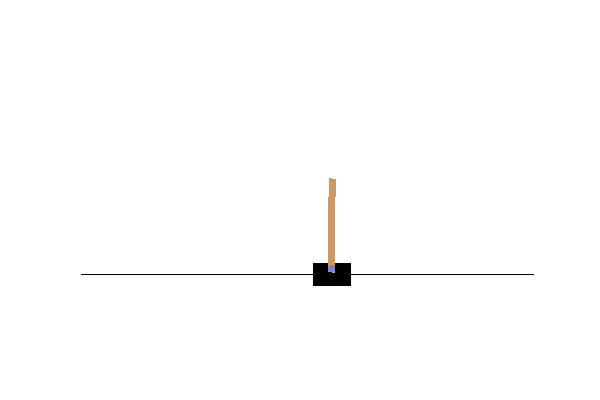
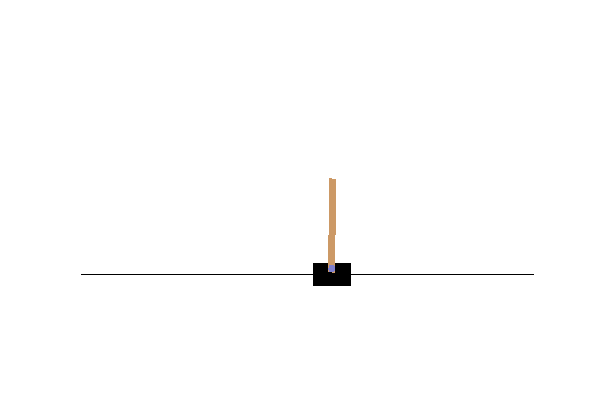
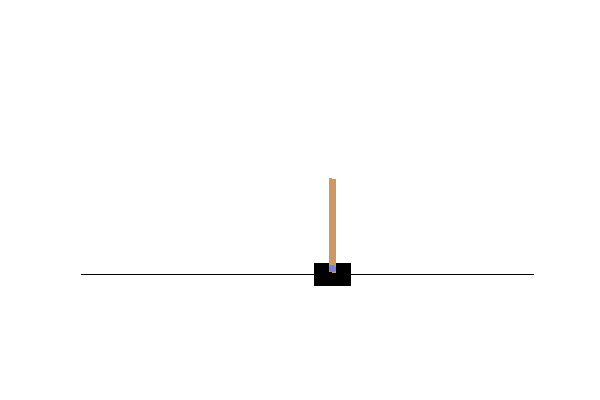
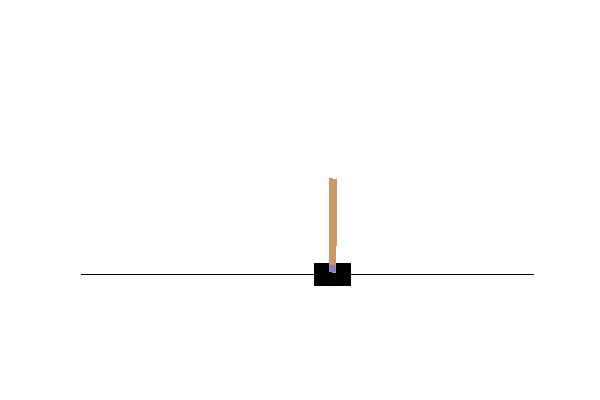
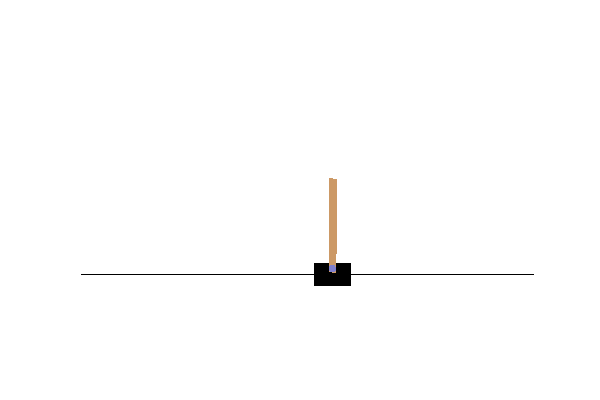
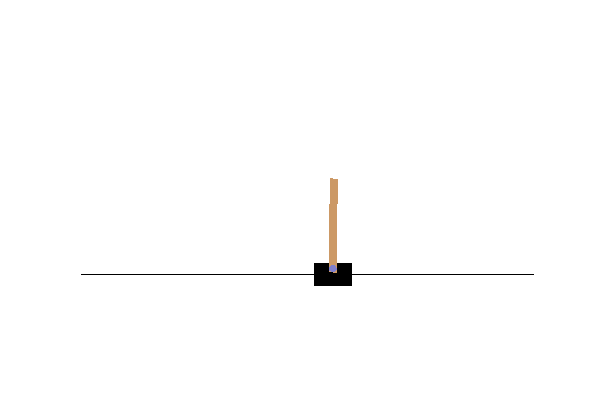
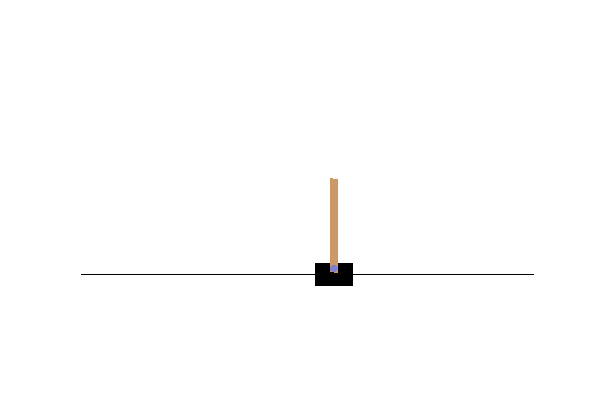
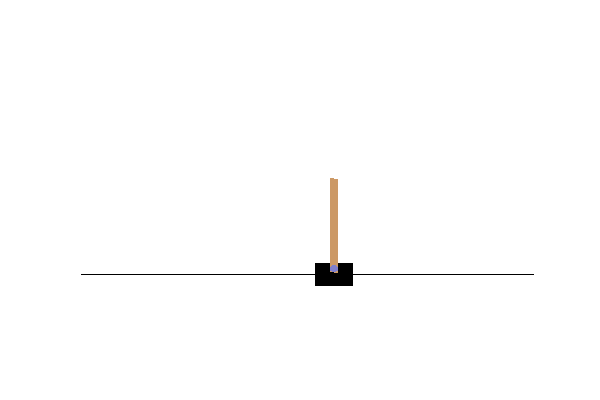
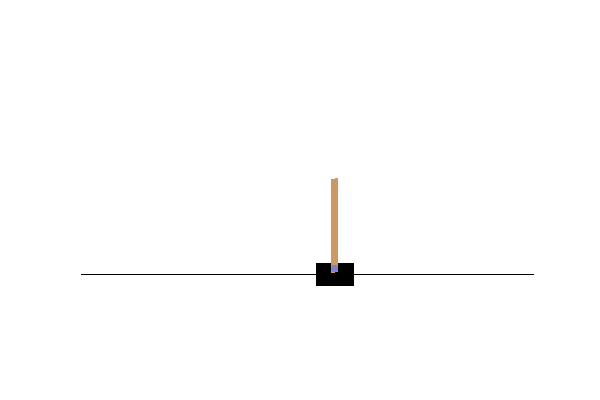
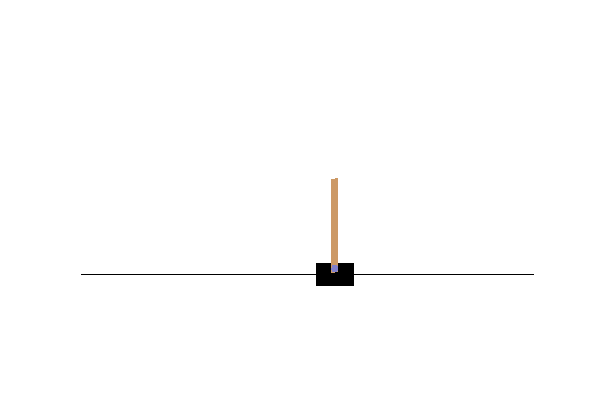
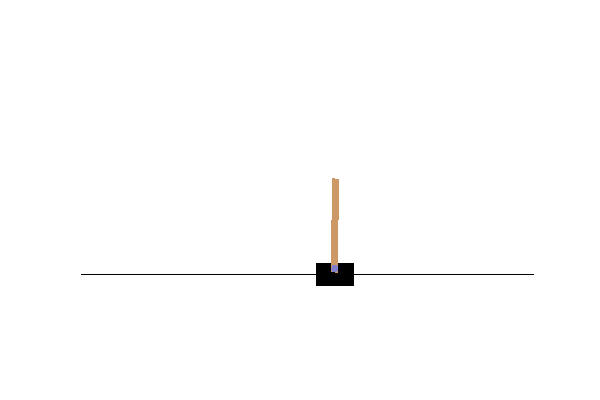
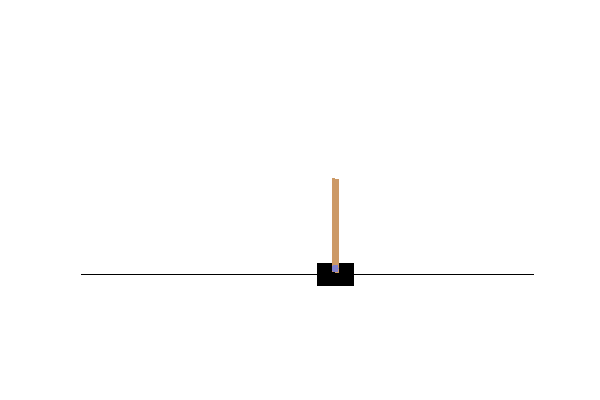
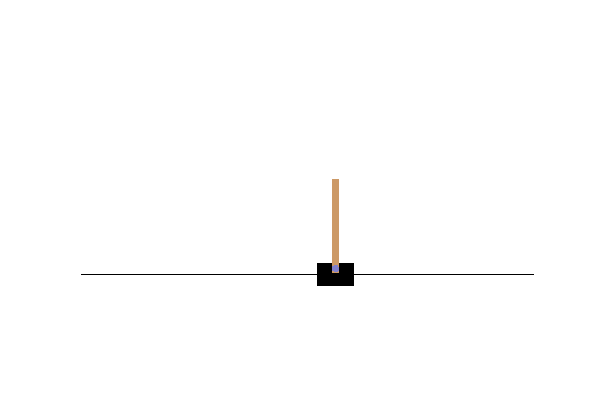
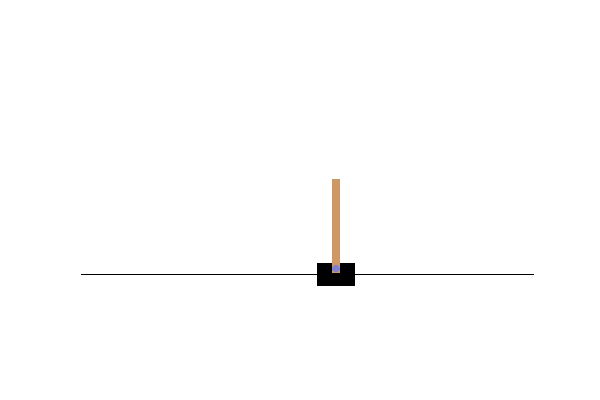
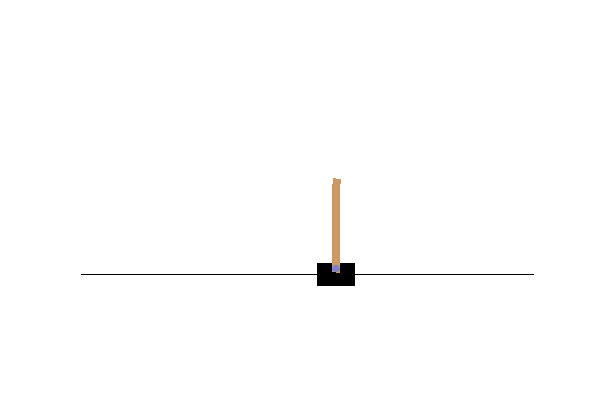
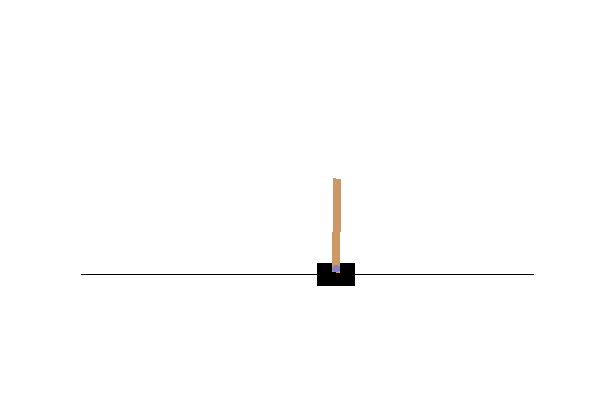
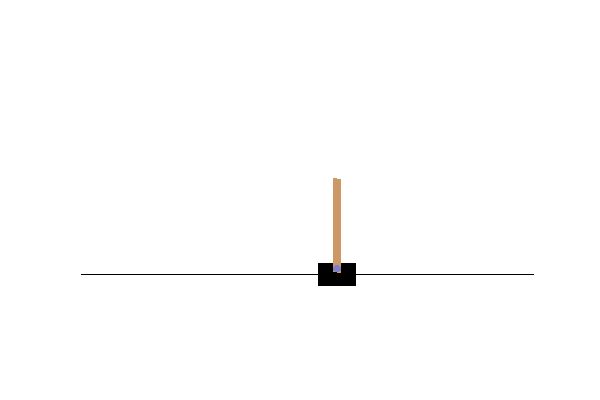
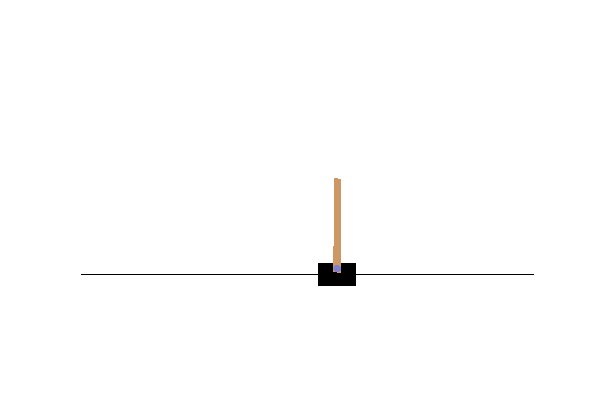
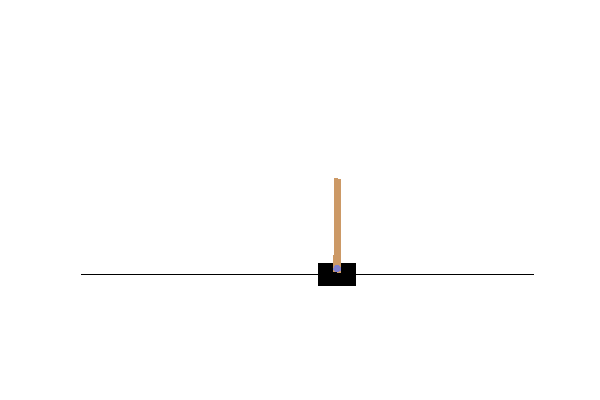
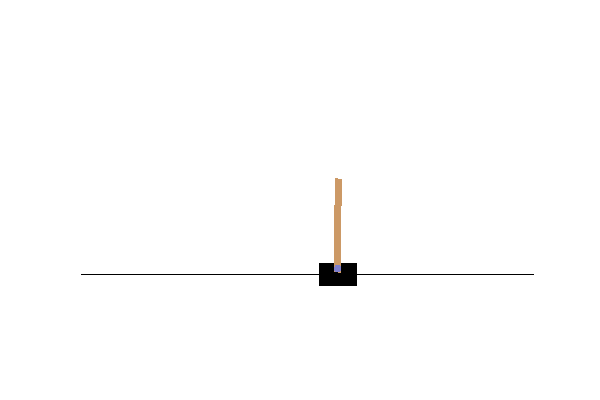
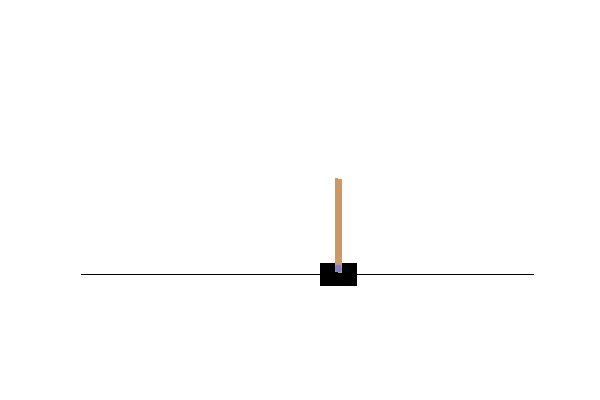
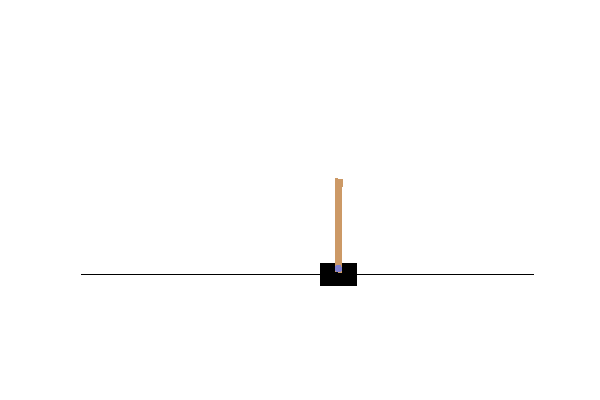
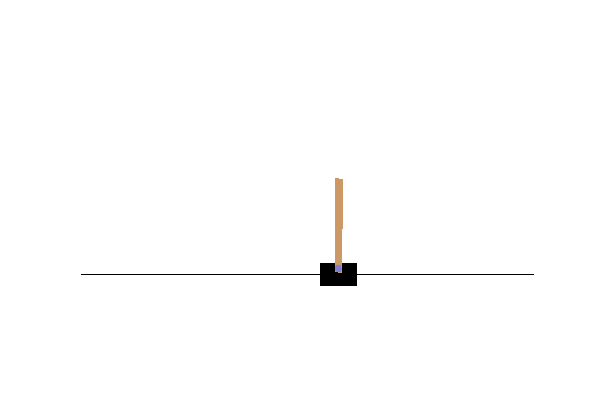
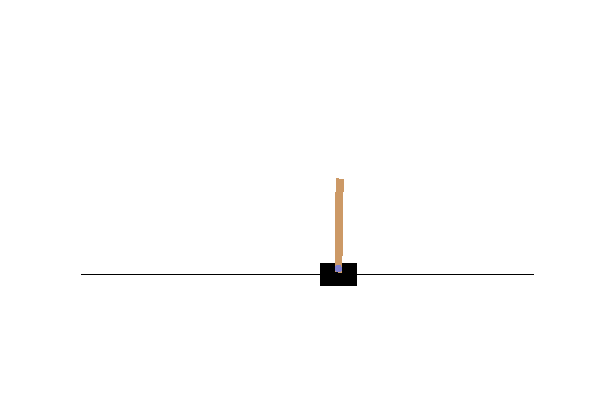
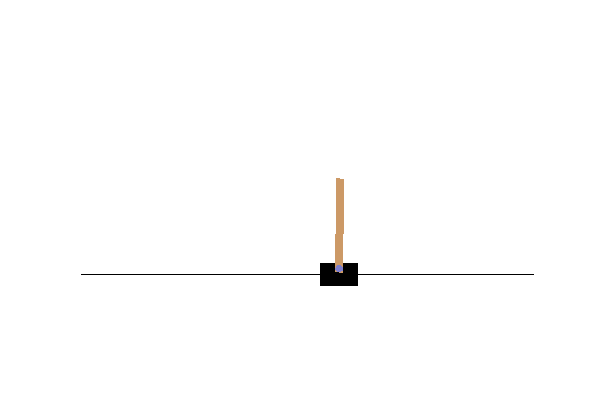
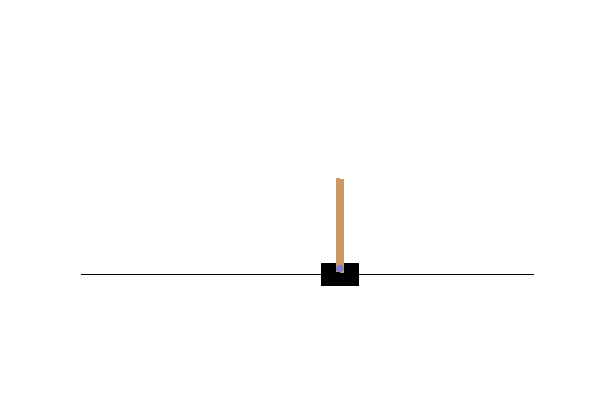
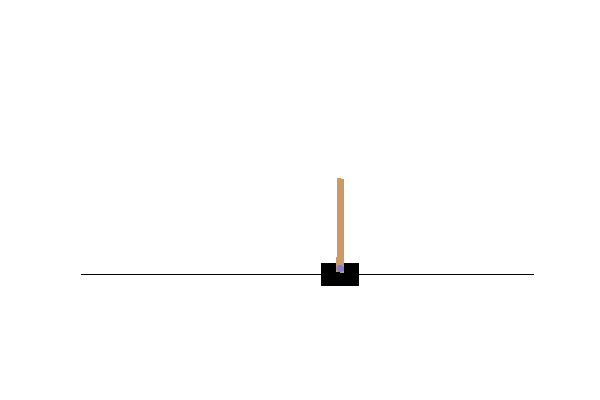
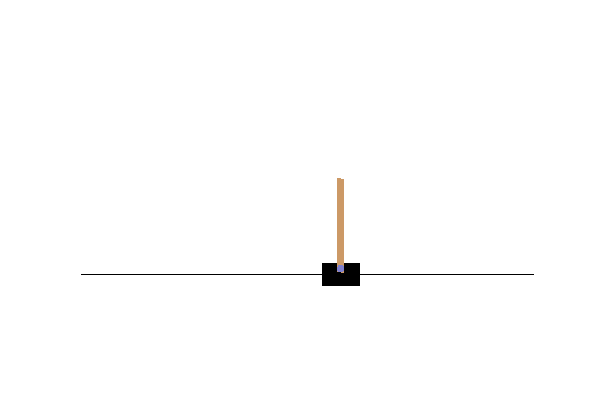
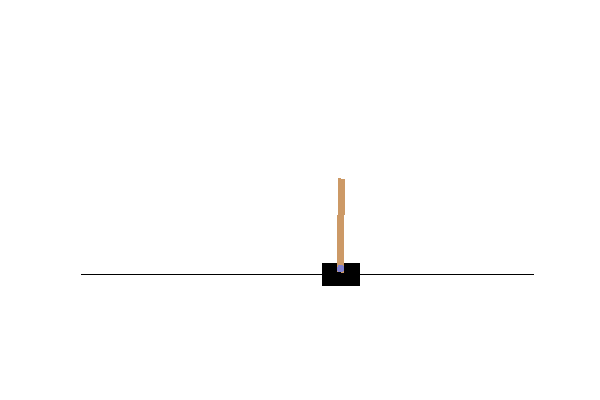
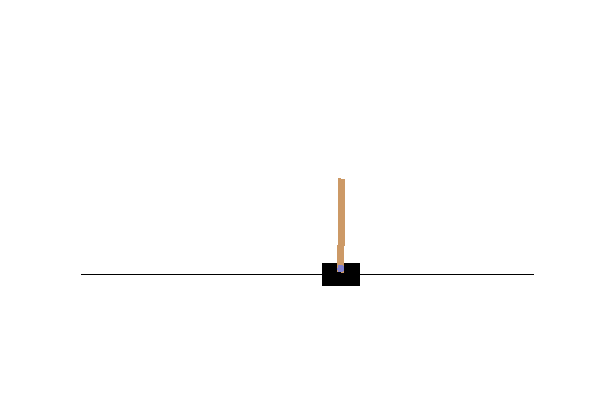
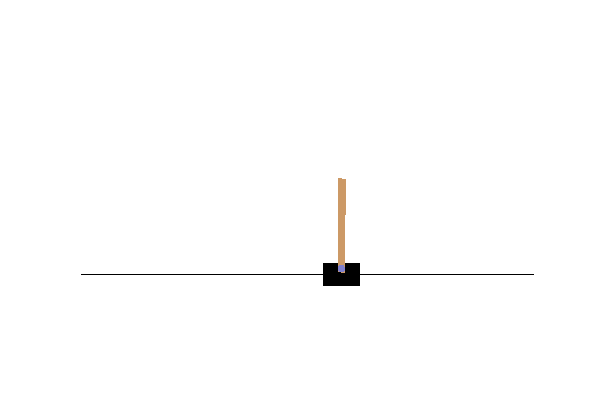
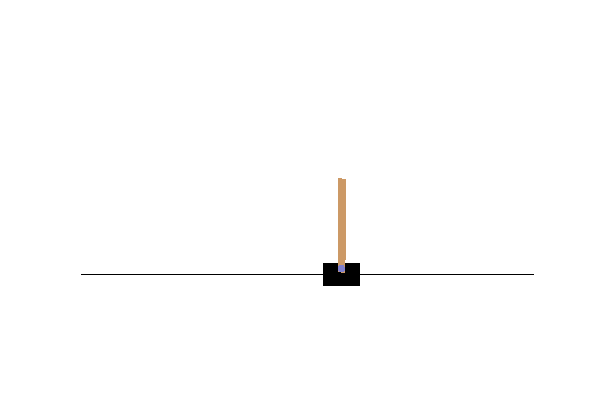
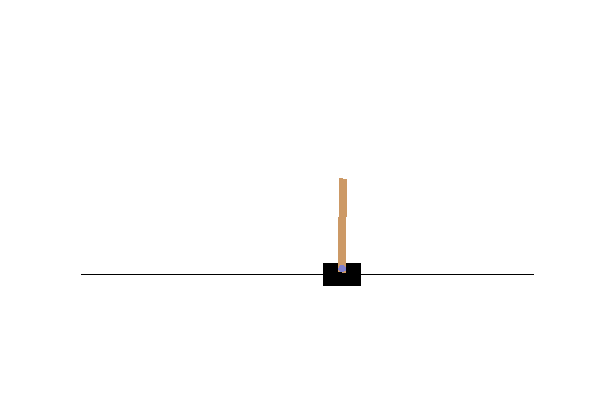
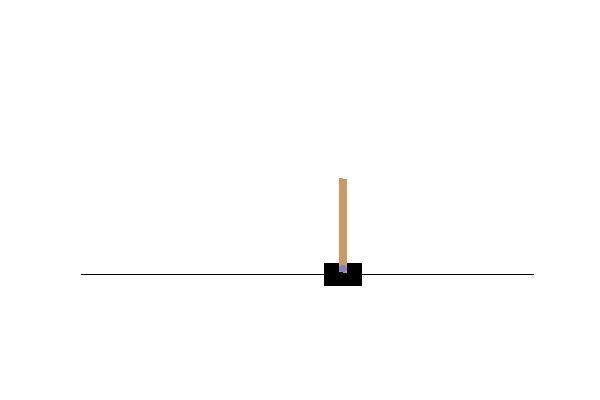
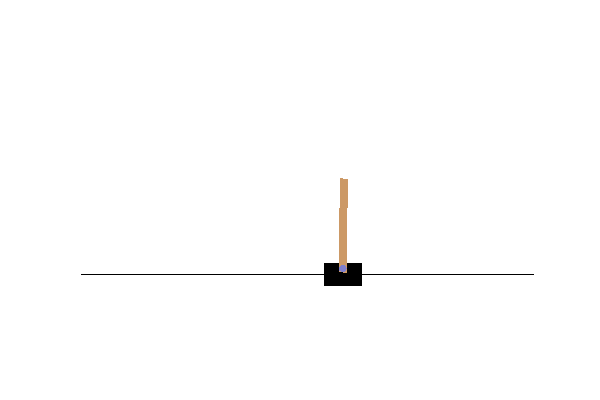
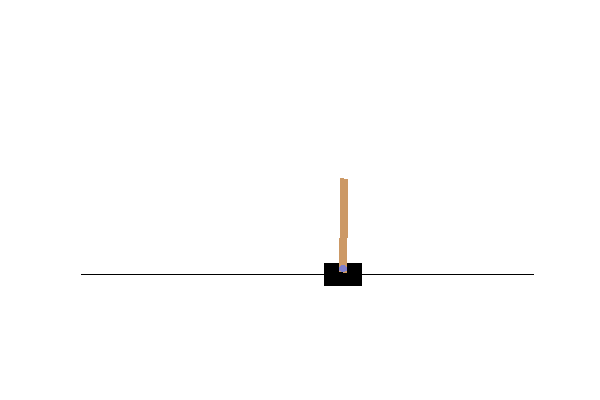
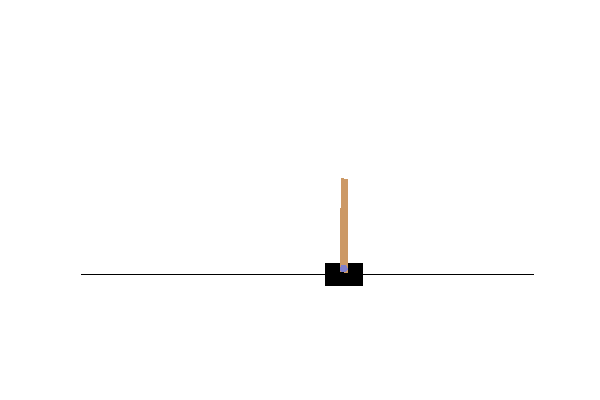
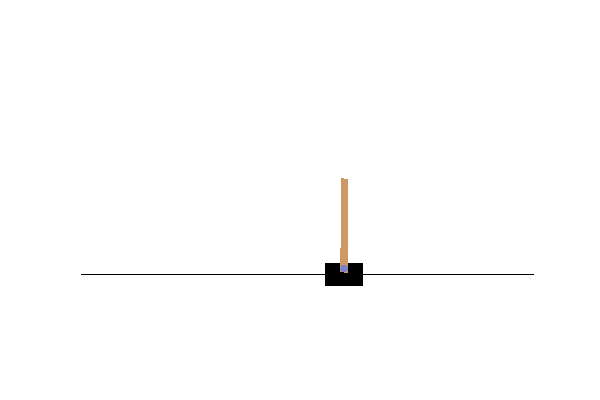
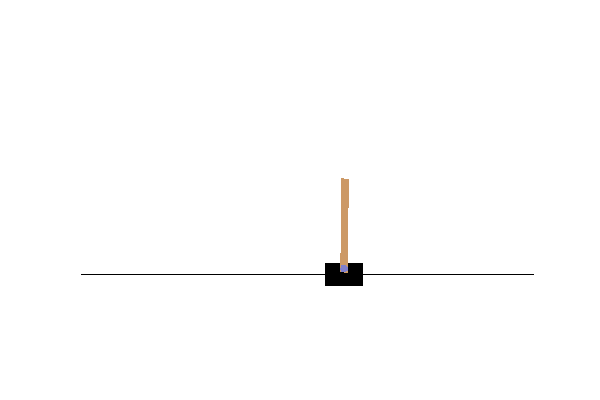
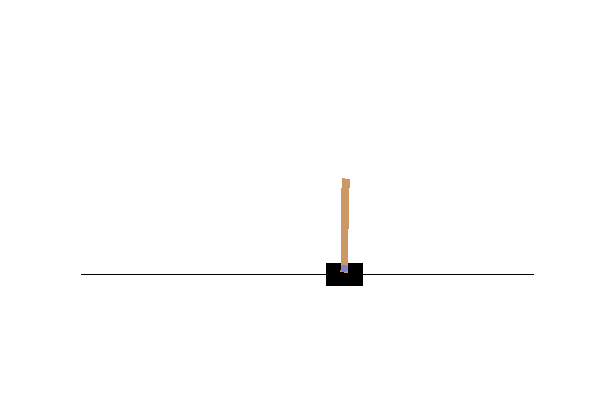
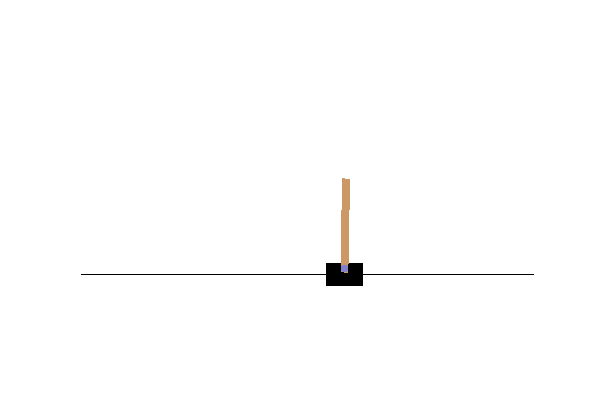
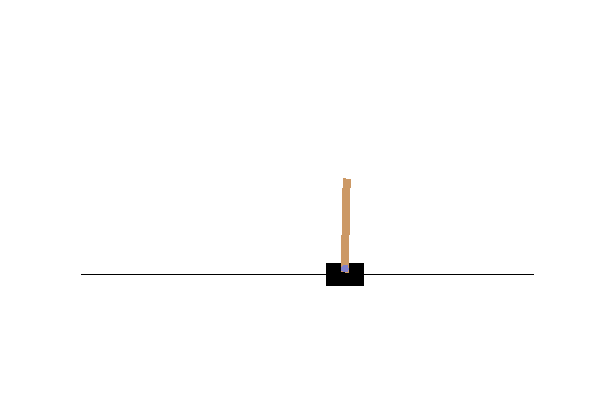
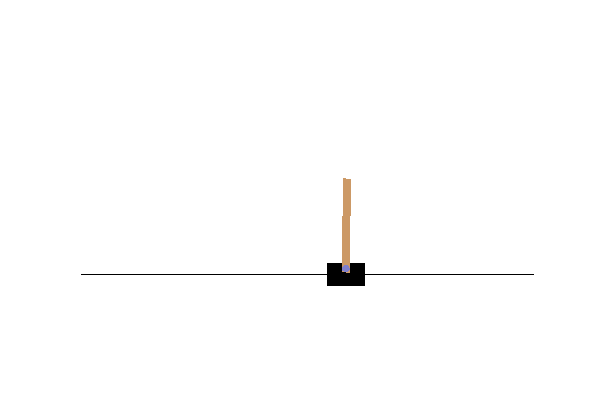
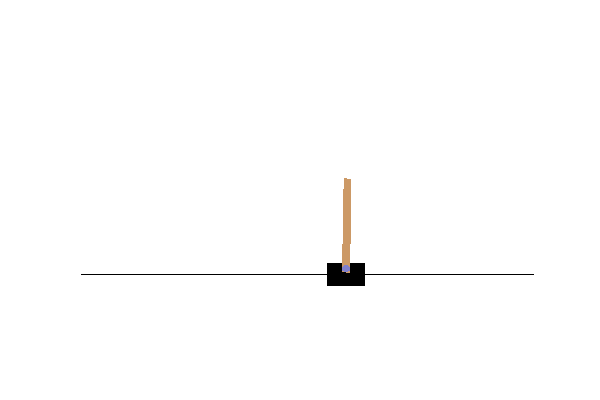
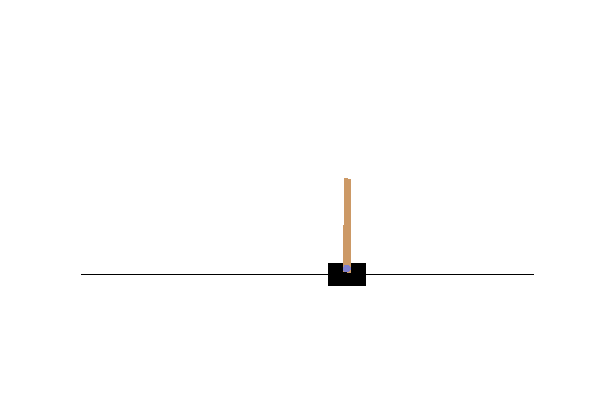
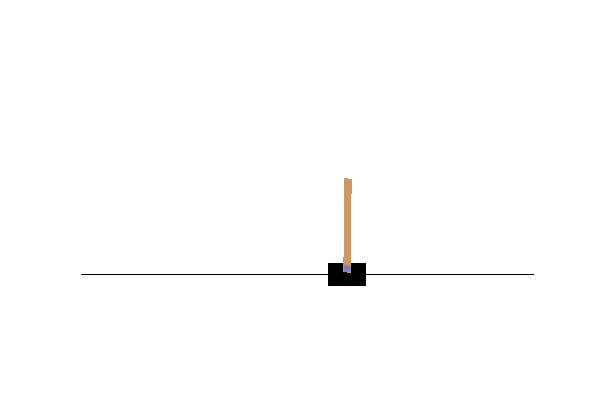
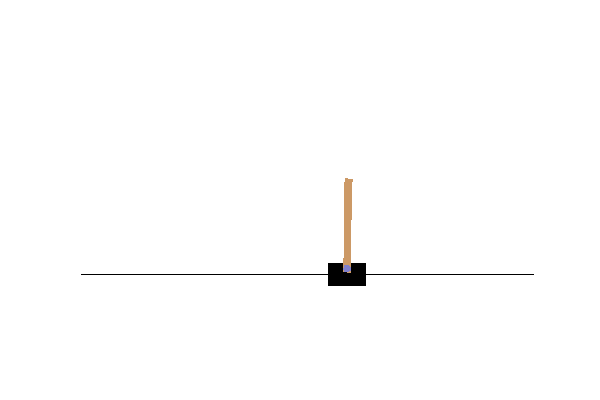
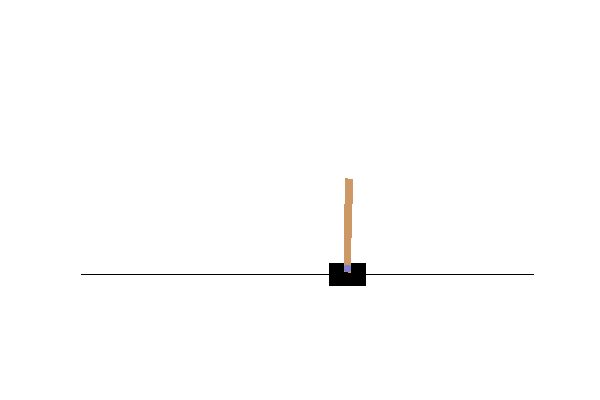
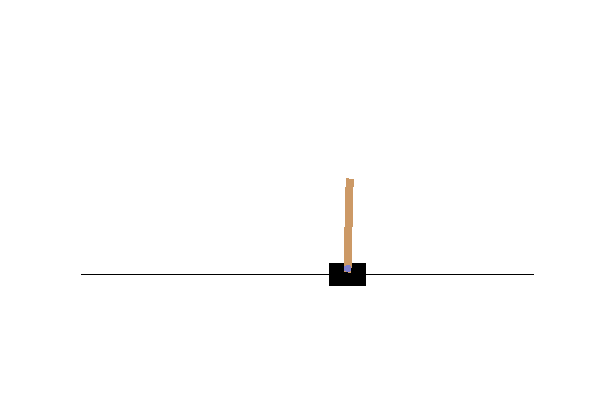
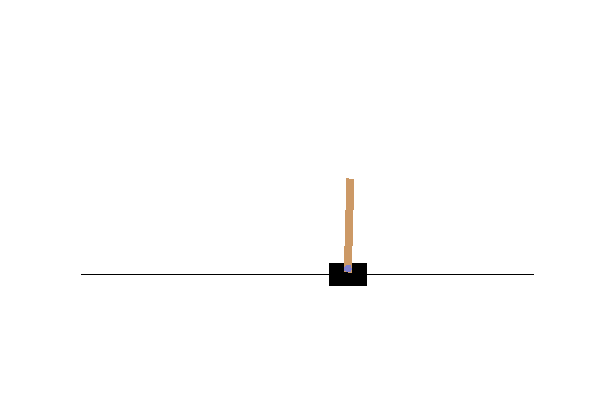
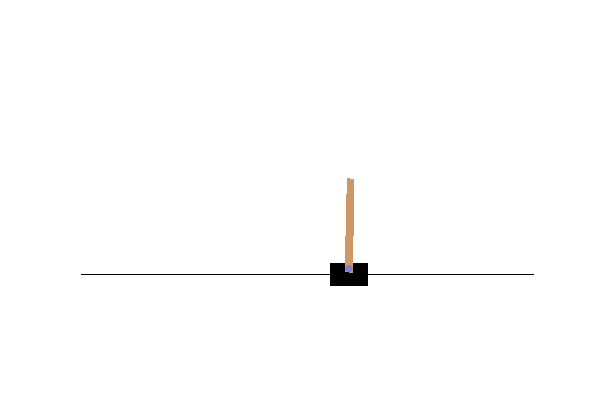
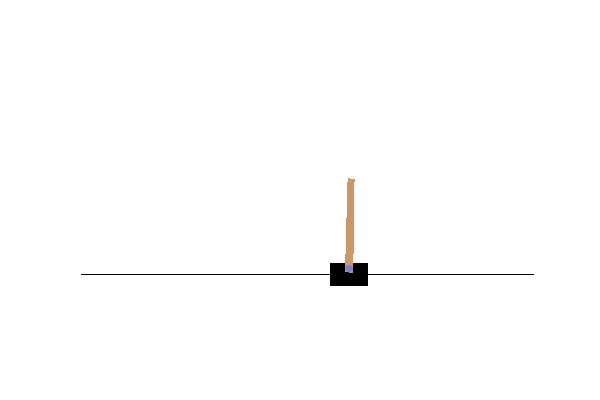
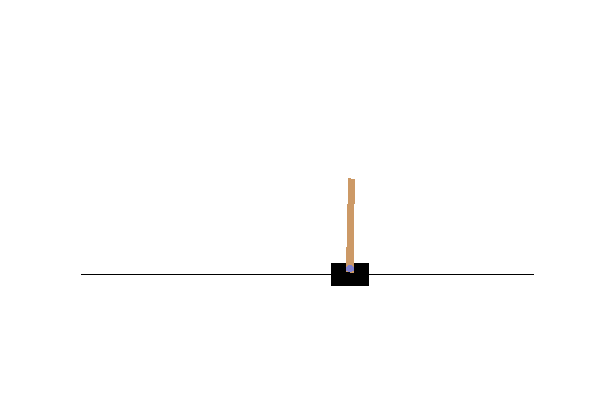
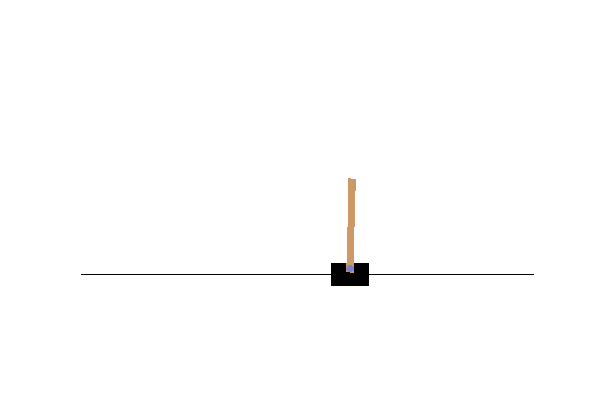
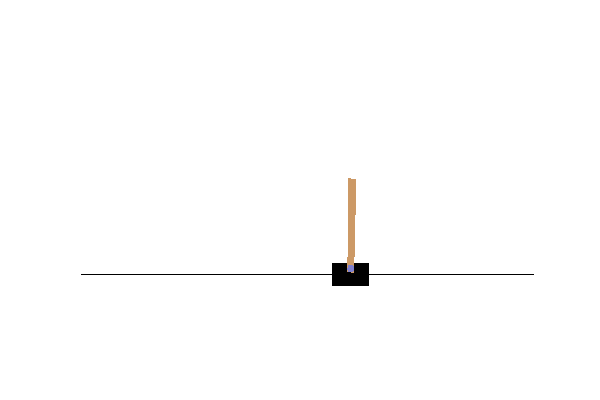
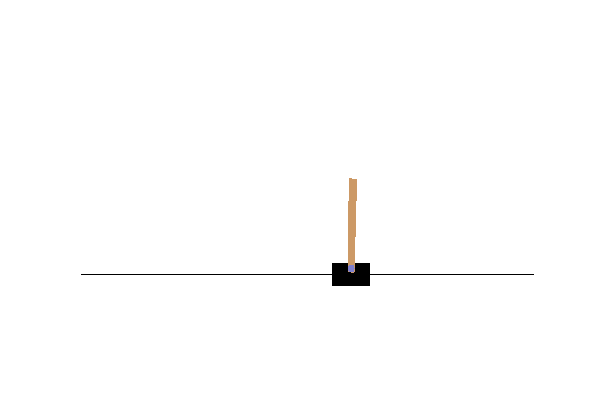
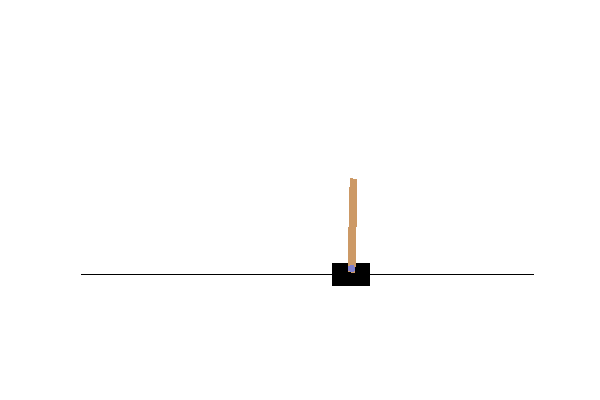
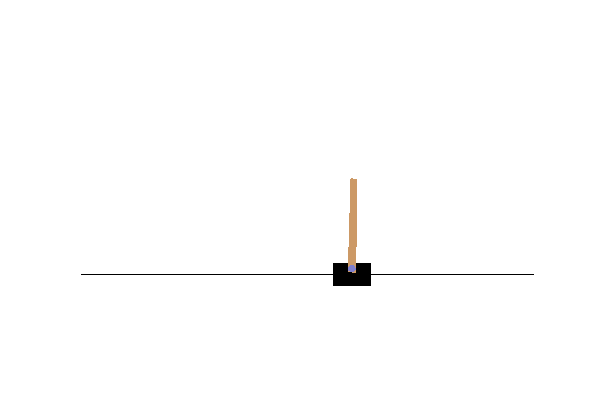
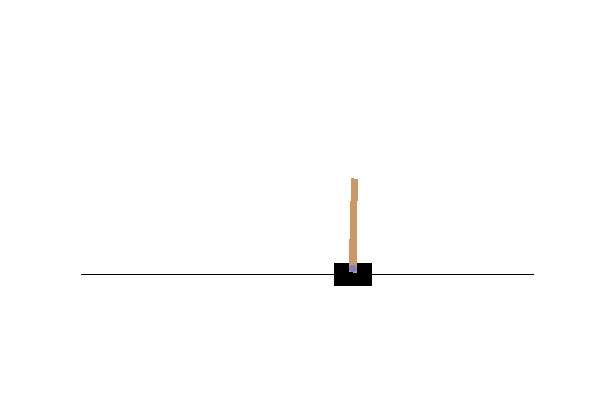
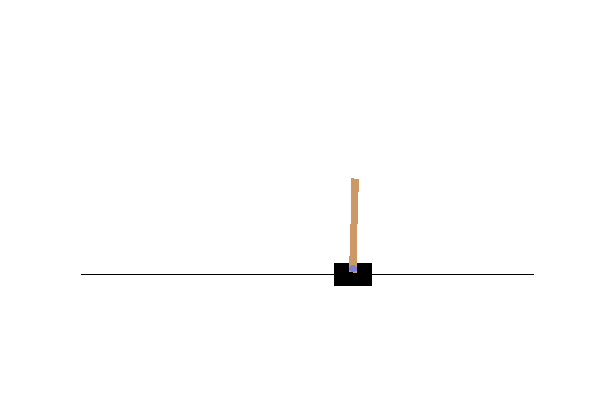
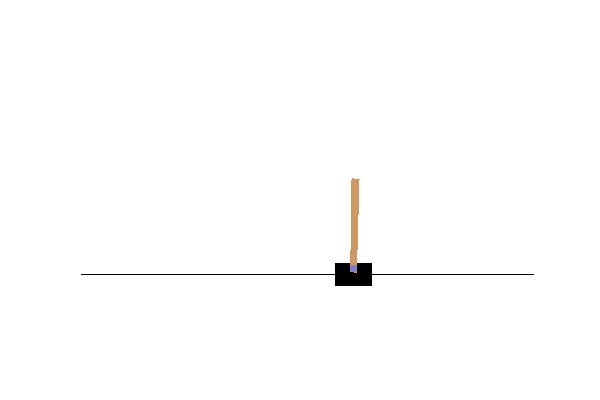
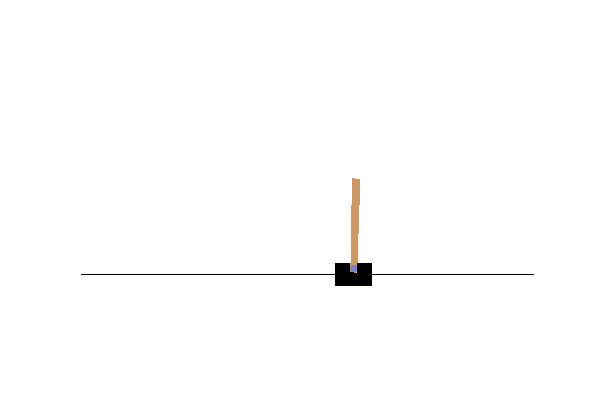
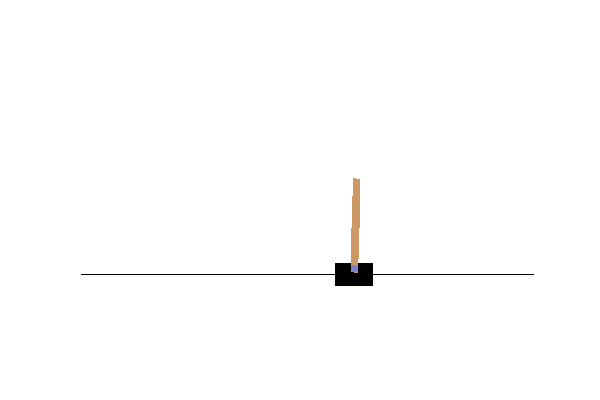
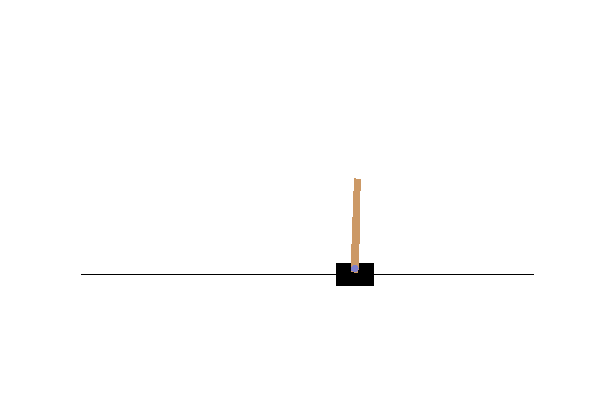
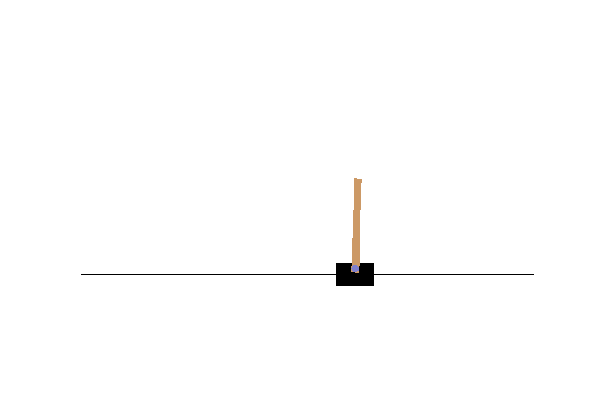
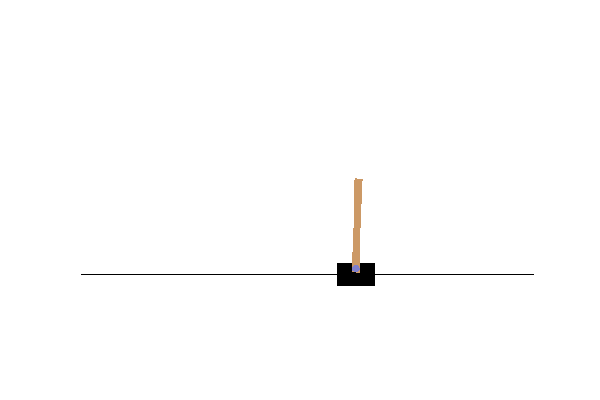
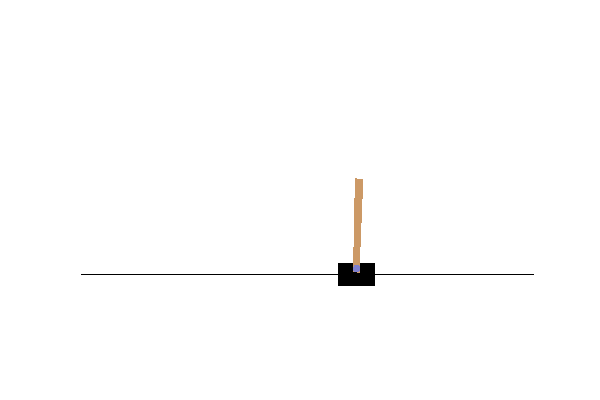
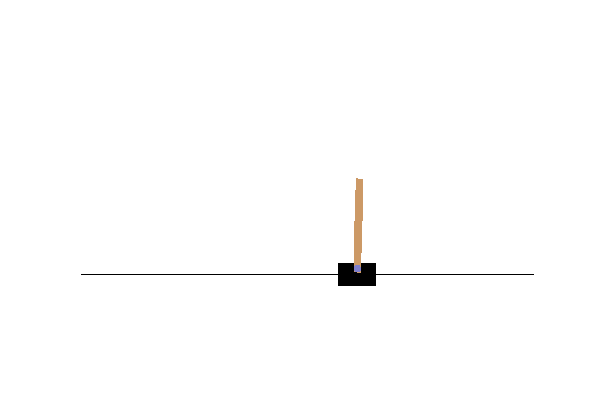
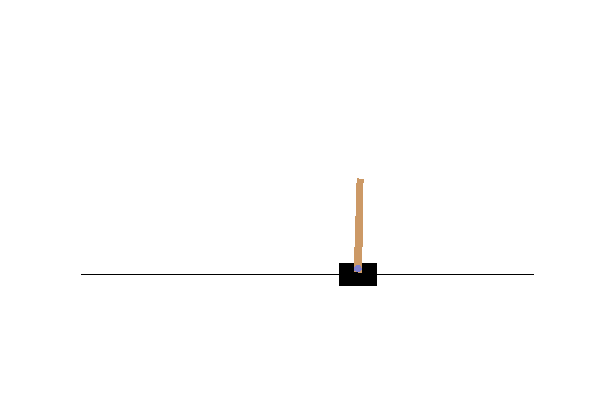
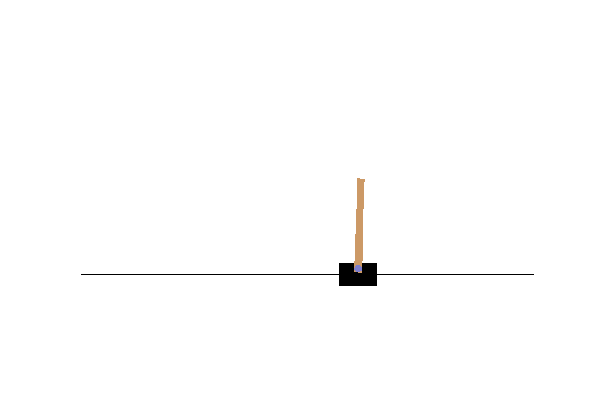
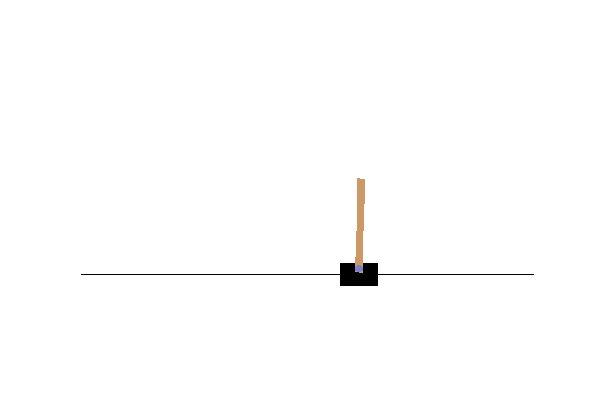
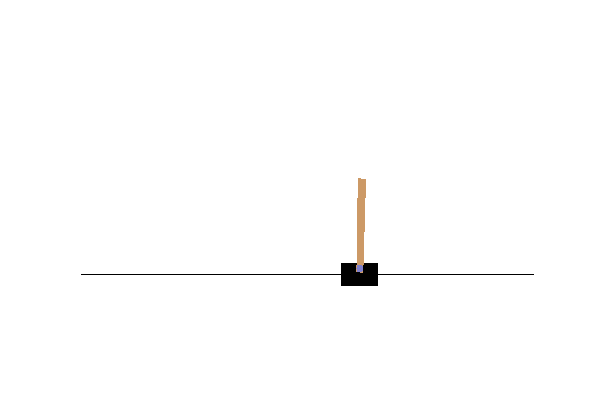
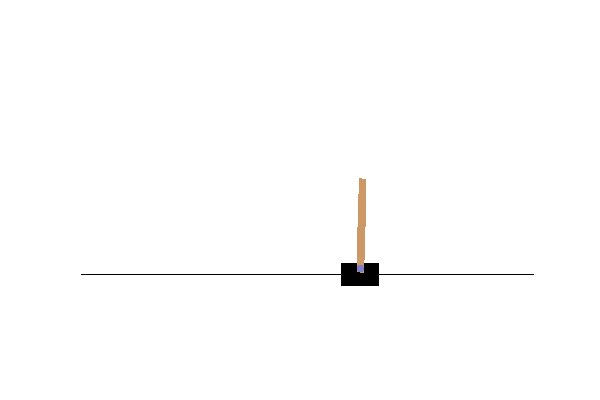
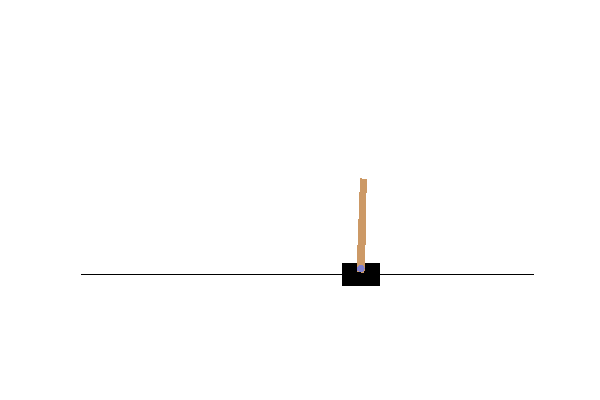
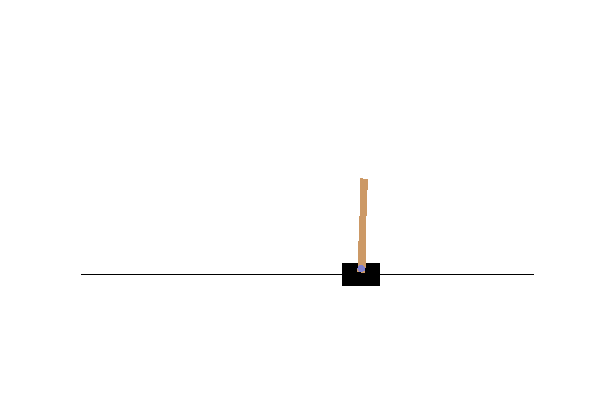
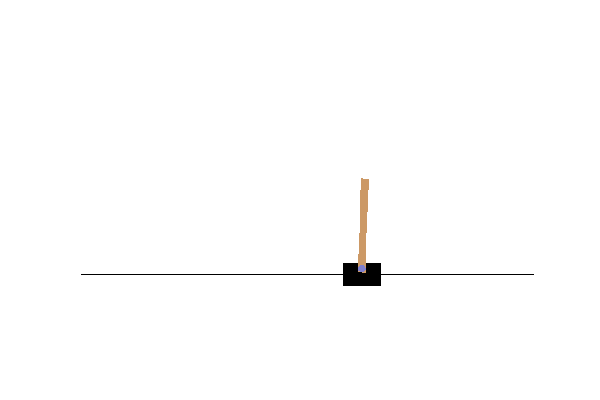
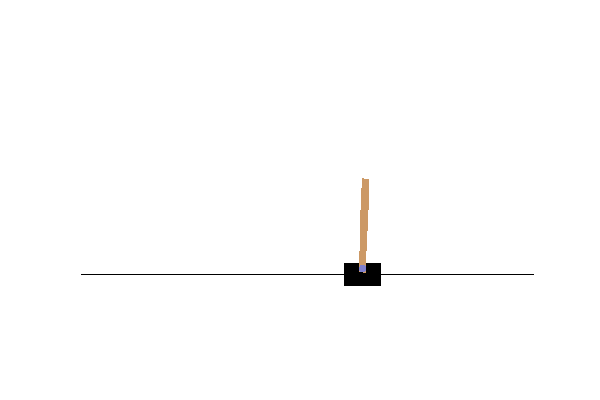
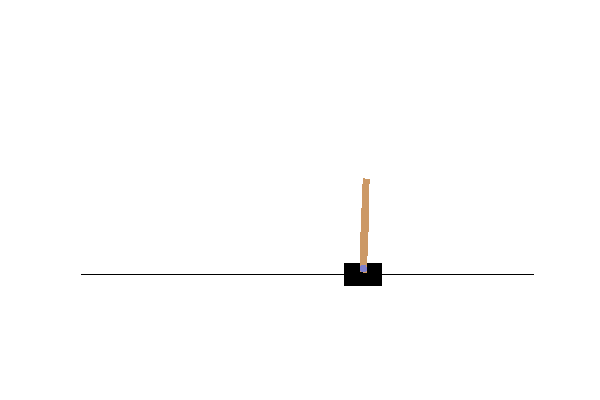
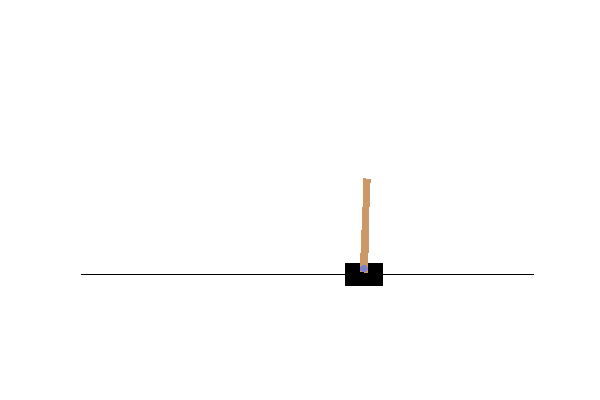
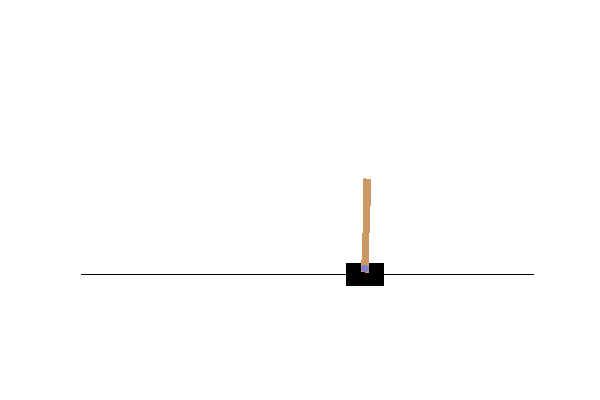
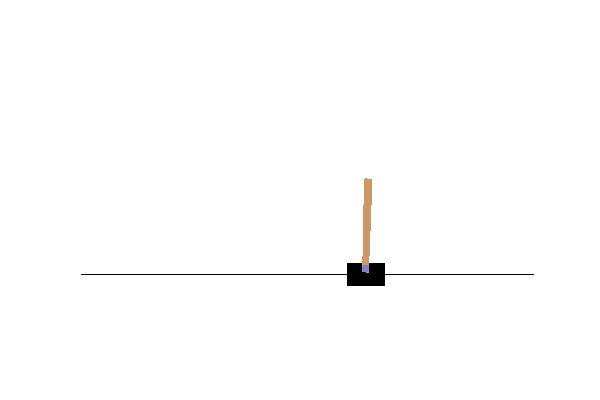
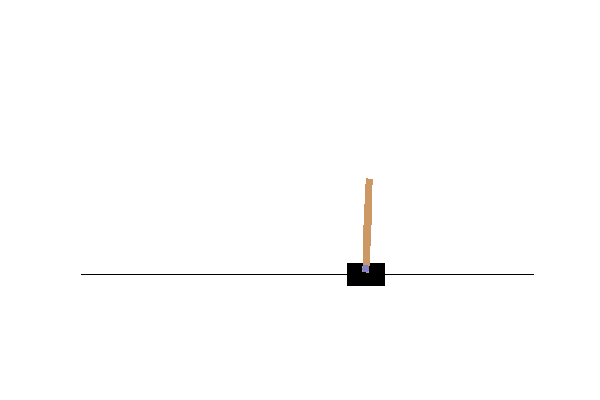
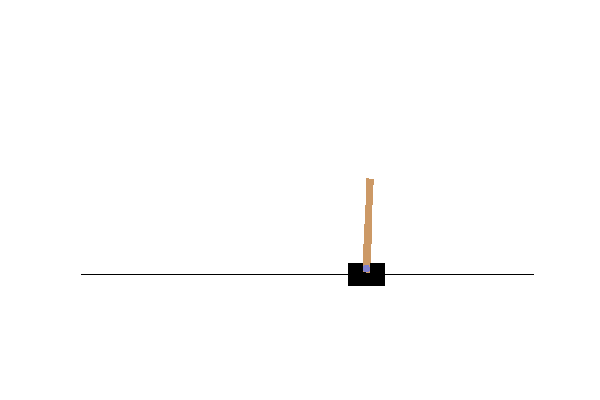
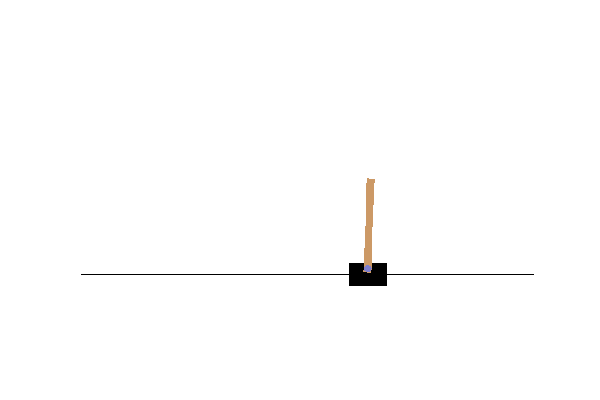
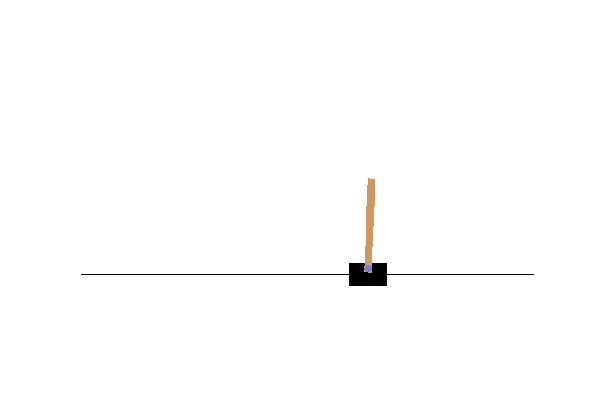
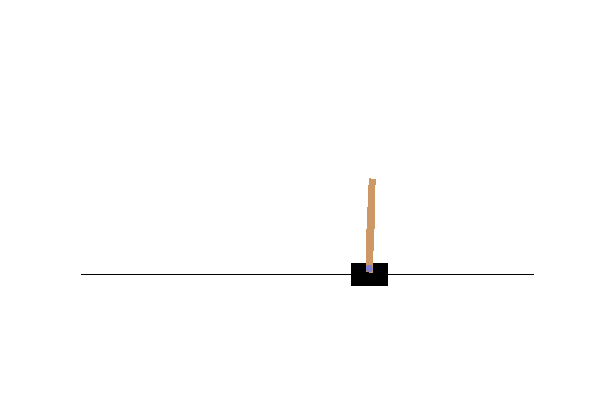
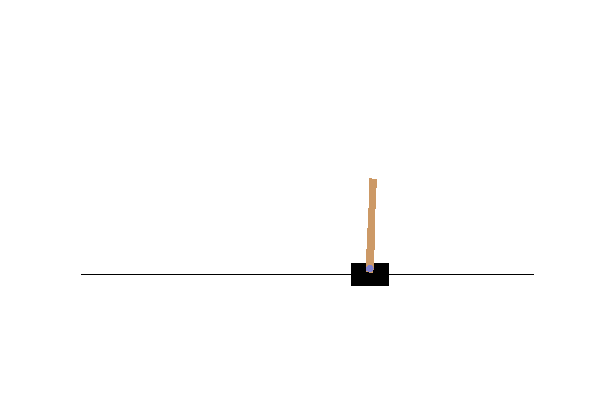
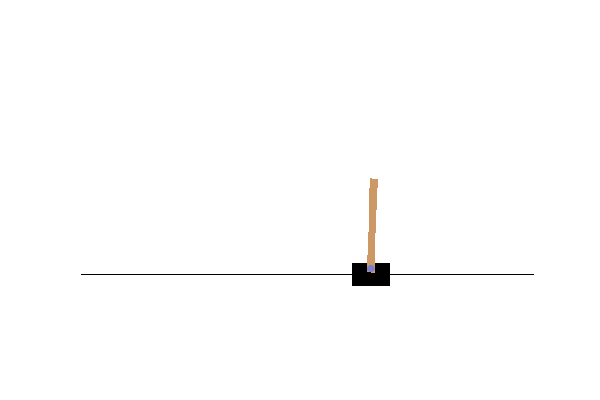
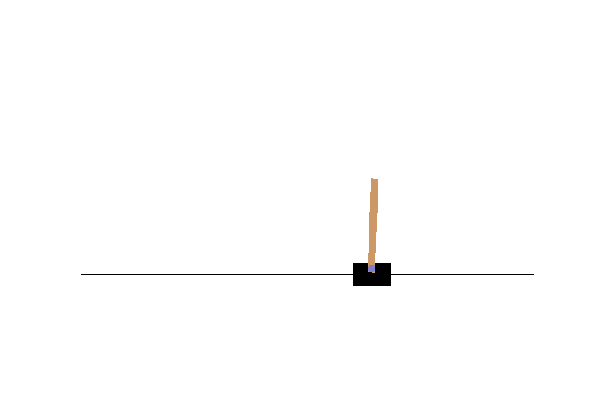
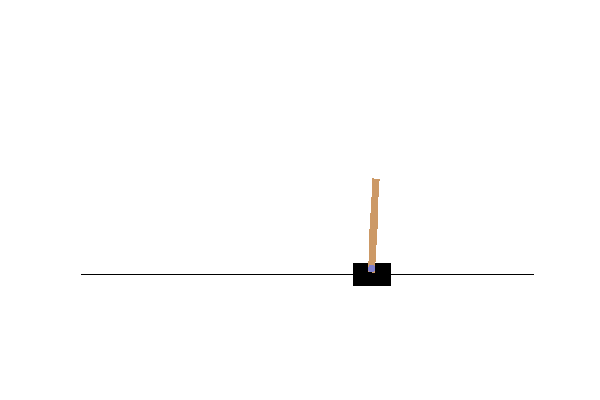
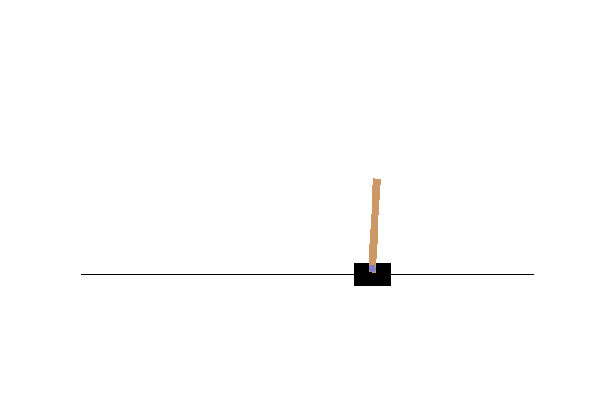
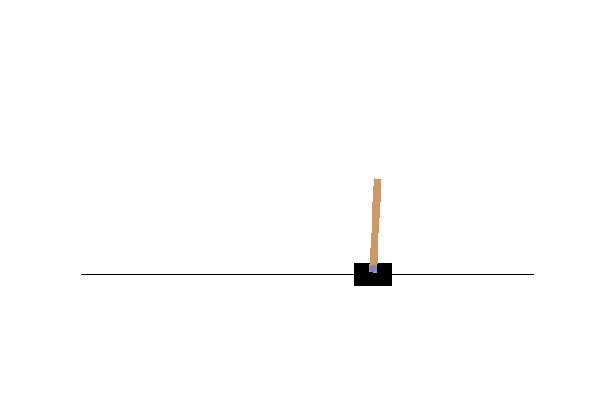
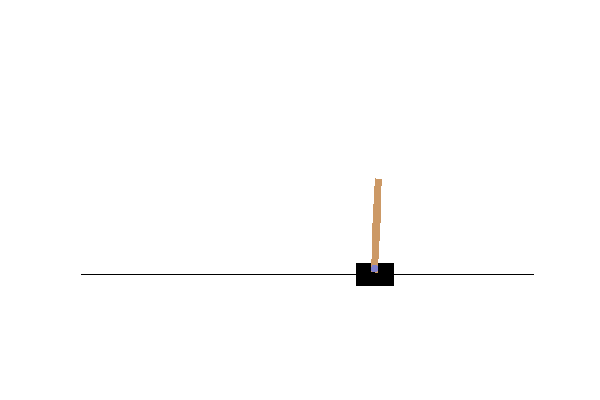
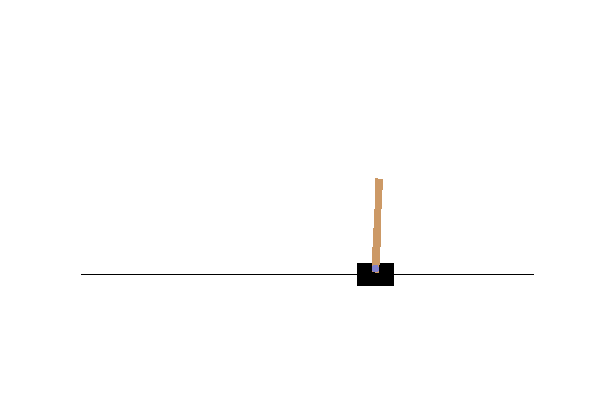
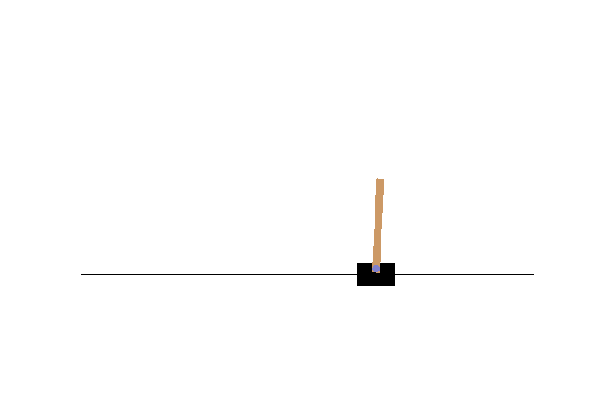
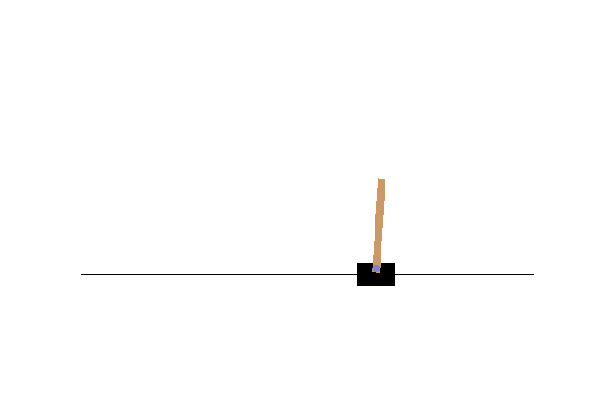
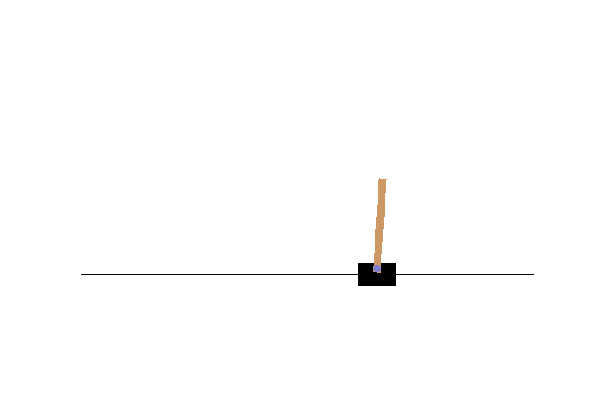
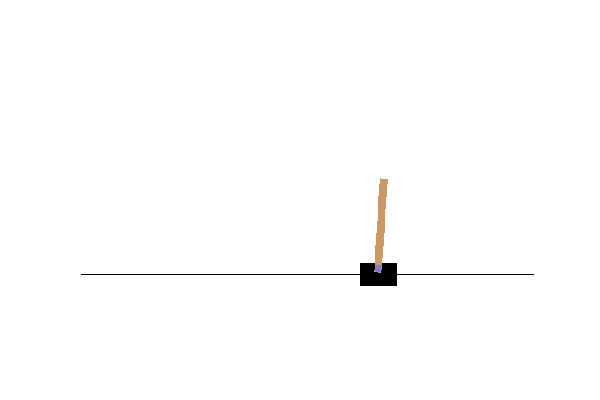

200.0

In [20]:
agent.play(learn=False, record=True)

### Saving replay memory

You may save agent with all replay memory (to continue learning from the "same state" in futue) using flag:

In [21]:
agent.save("DQN Cartpole", save_replay_memory=True)

In [22]:
agent.load("DQN Cartpole", load_replay_memory=True)

In [23]:
len(agent) # buffer of replay memory length

13709

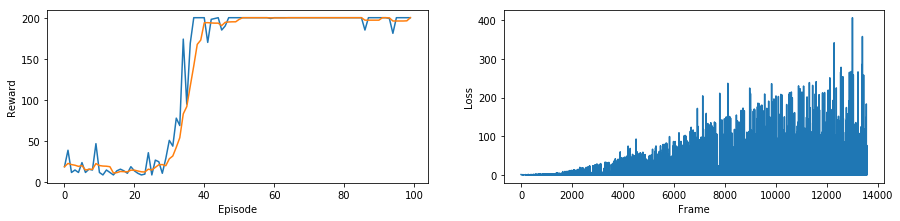

In [24]:
plot_durations(agent, 5)    

# Rainbow: all blended in one!
[with $\varepsilon$-greedy]

In [25]:
agent = eGreedy(DoubleQAgent(CategoricalQAgent(NstepReplay(PrioritizedBufferAgent))))(env=env,
                FeatureExtractorNet = BasicNetwork, 
                features_size = 128, 
                QnetworkHead = DuelingCategoricalQnetwork,
                noisy = True,
                target_update = 100,
                batch_size=32, 
                gamma=0.99,
                replay_buffer_nsteps = 2,
                replay_buffer_init=128,
                replay_buffer_capacity=1000,
                epsilon_start = 1.0, epsilon_final = 0.01, epsilon_decay = 500,
                rp_alpha=0.6, rp_beta_start = 0.4, rp_beta_frames = 100,
                Vmin=-10, Vmax=10, num_atoms=51)

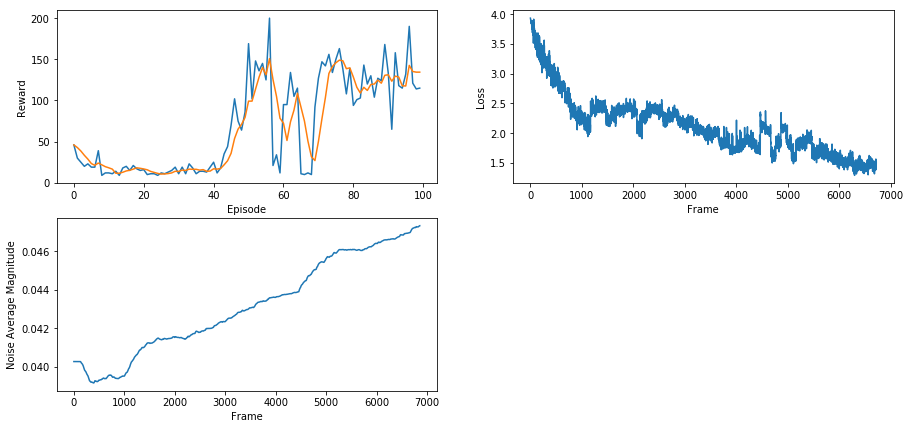

Complete
Wall time: 4min 11s


In [26]:
%%time
for i in range(100):
    agent.play()
    plot_durations(agent, 5)    

print('Complete')
plt.show()


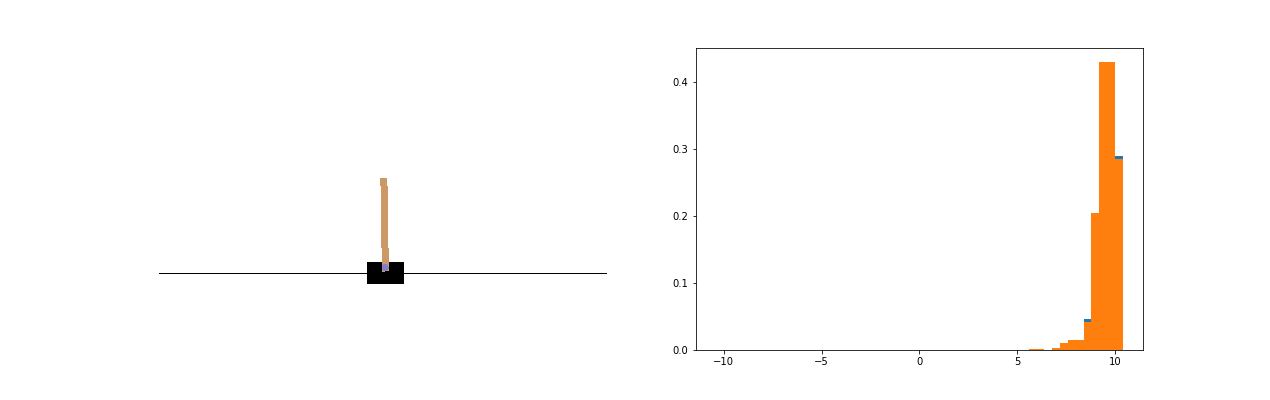
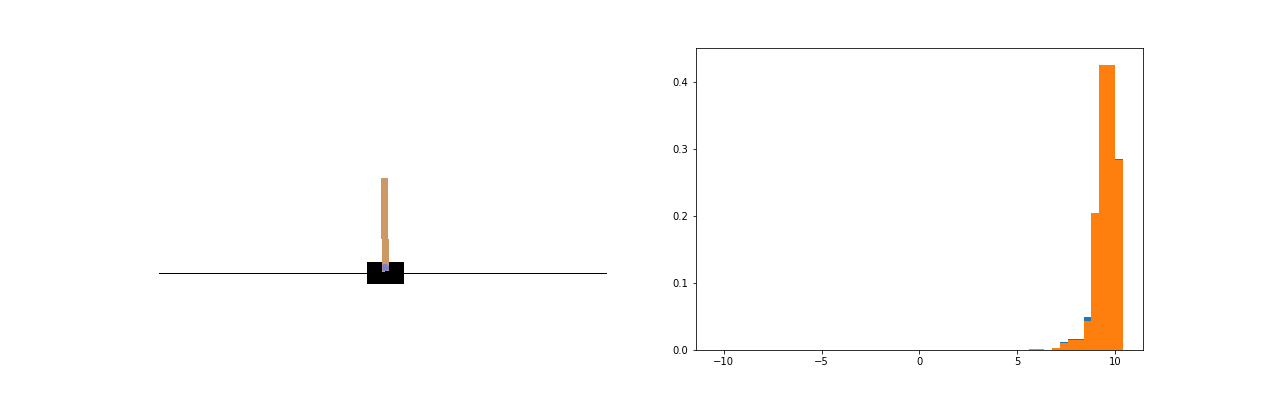
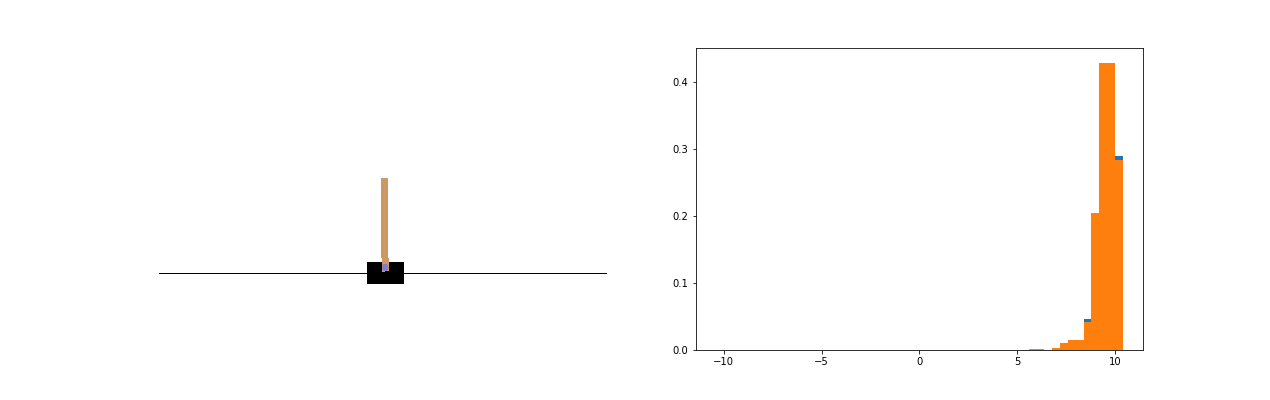
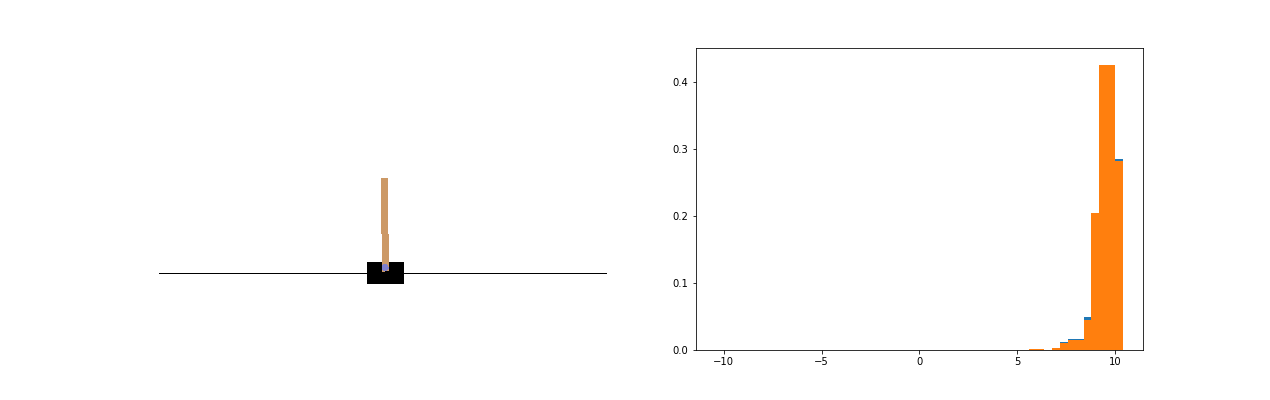
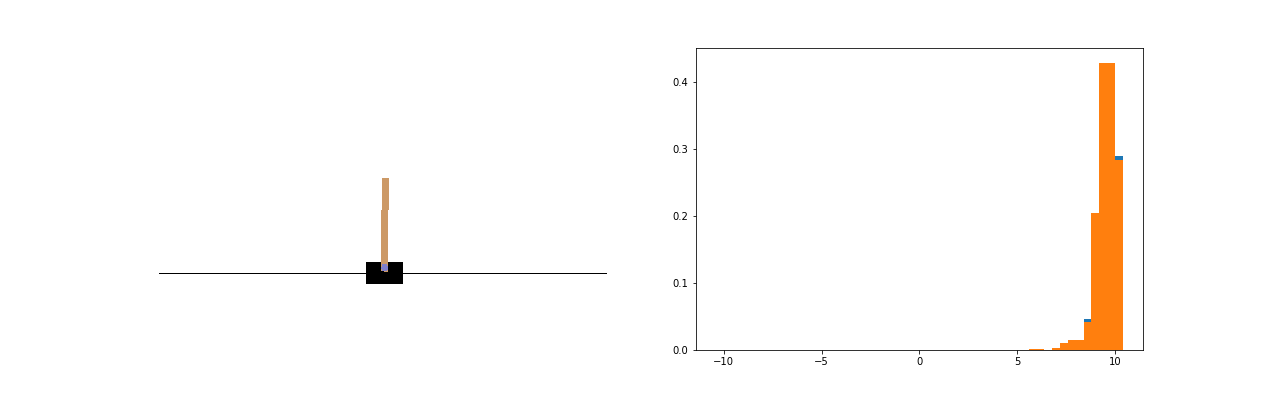
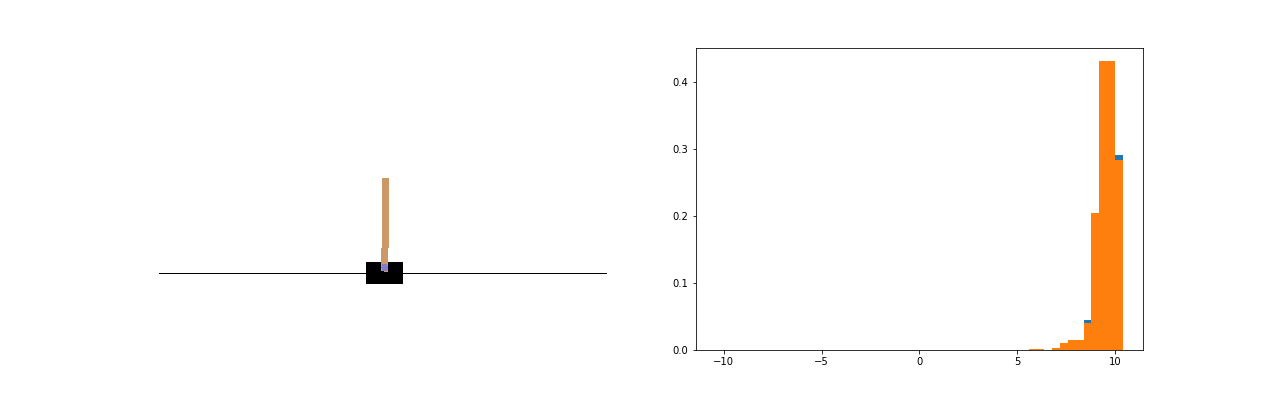
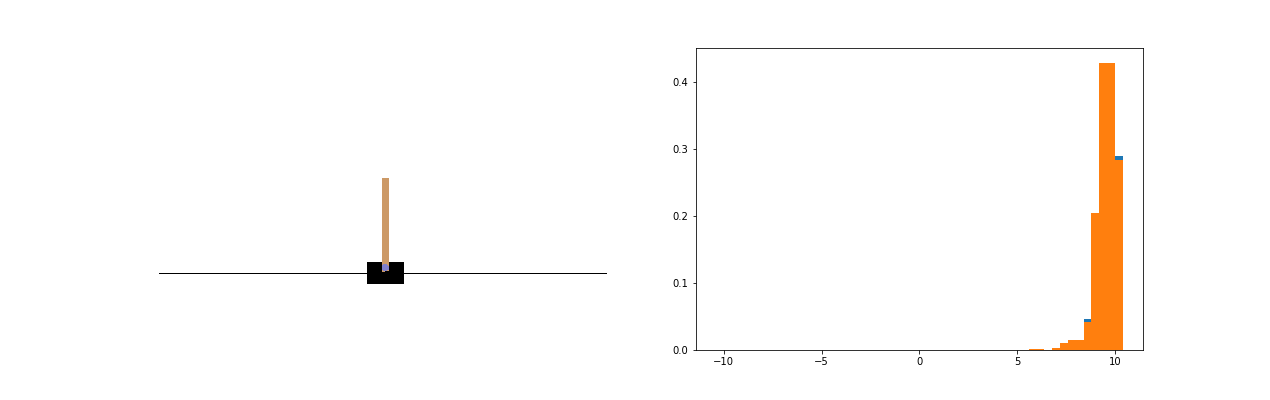
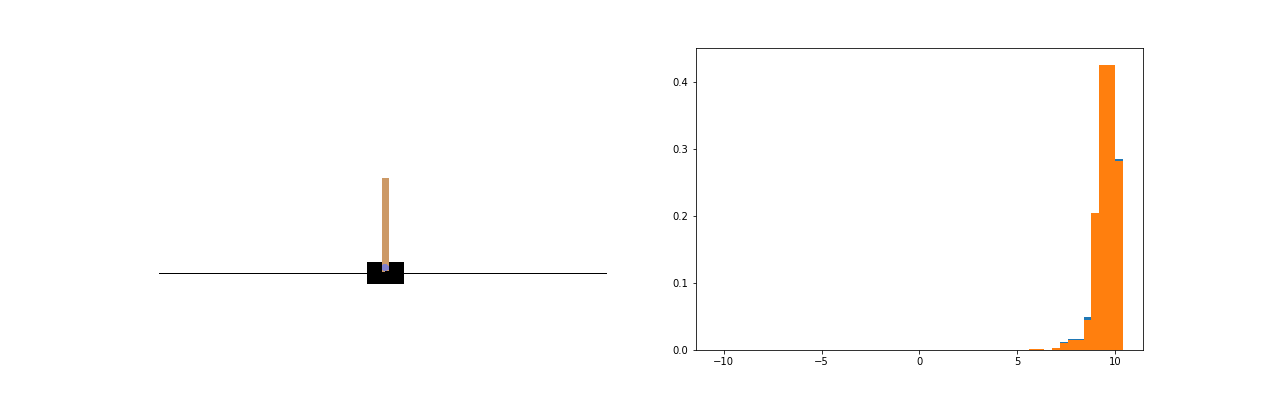
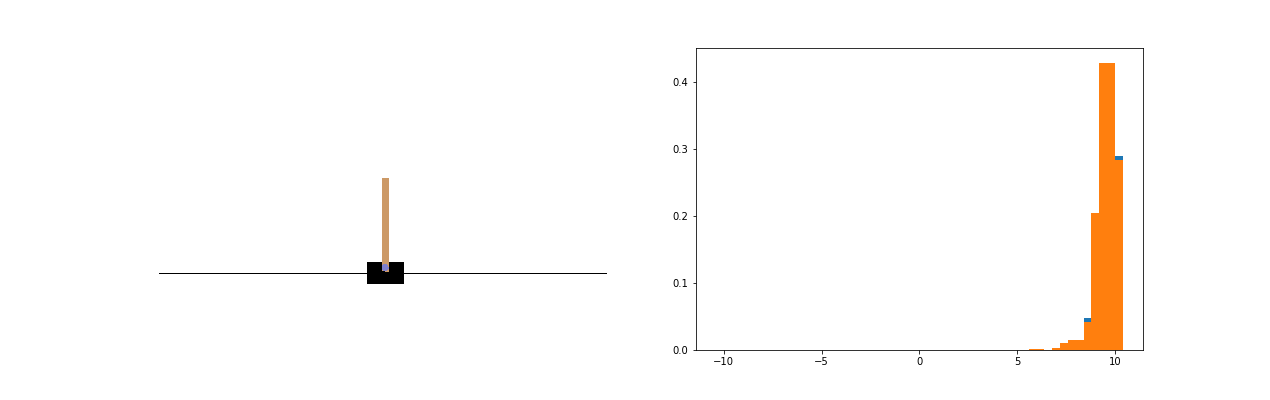
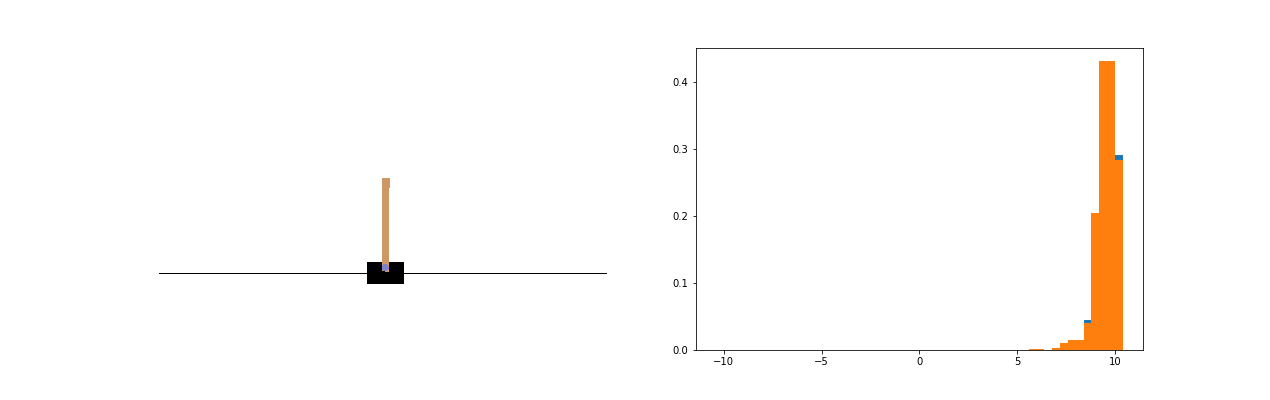
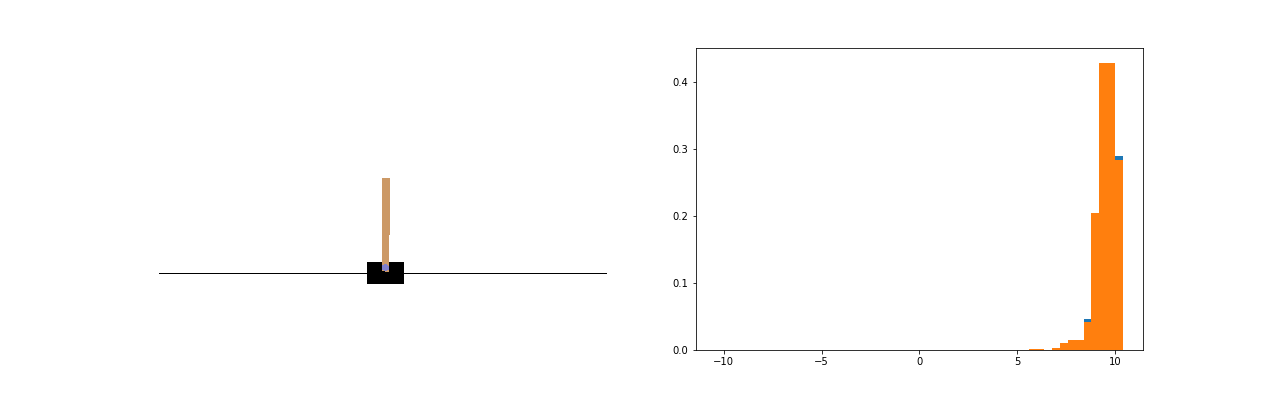
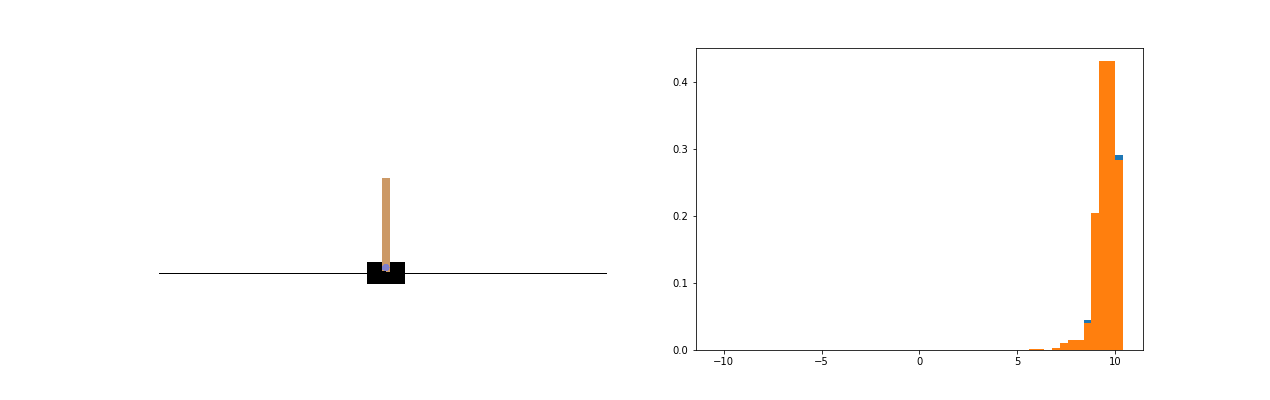
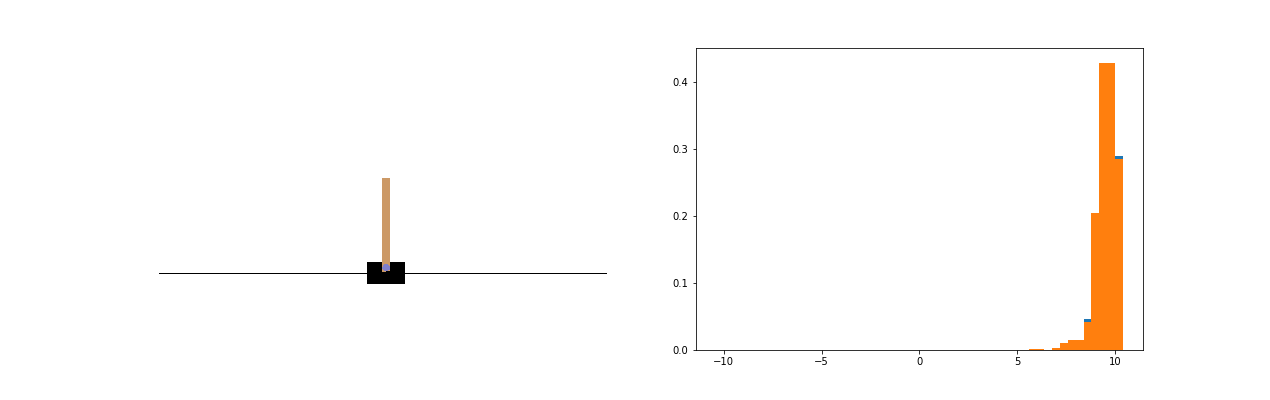
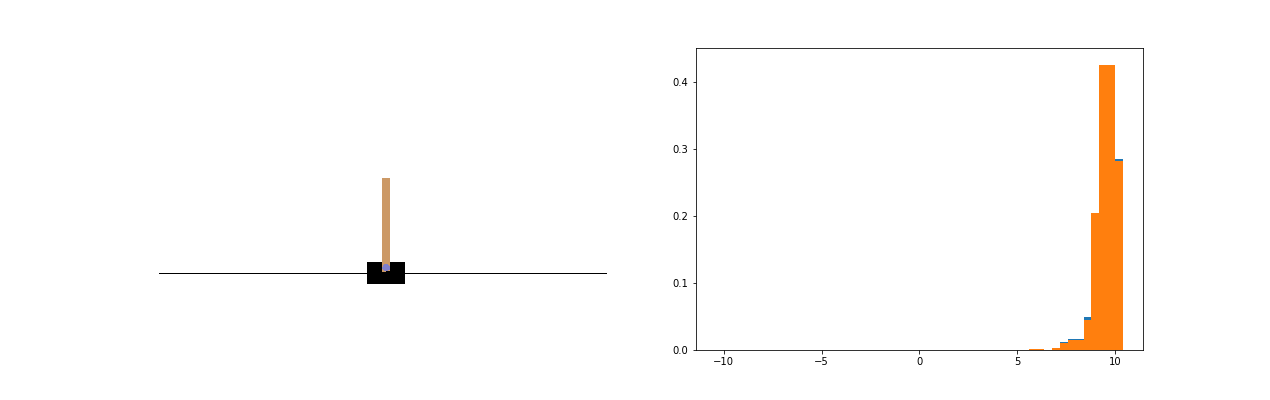
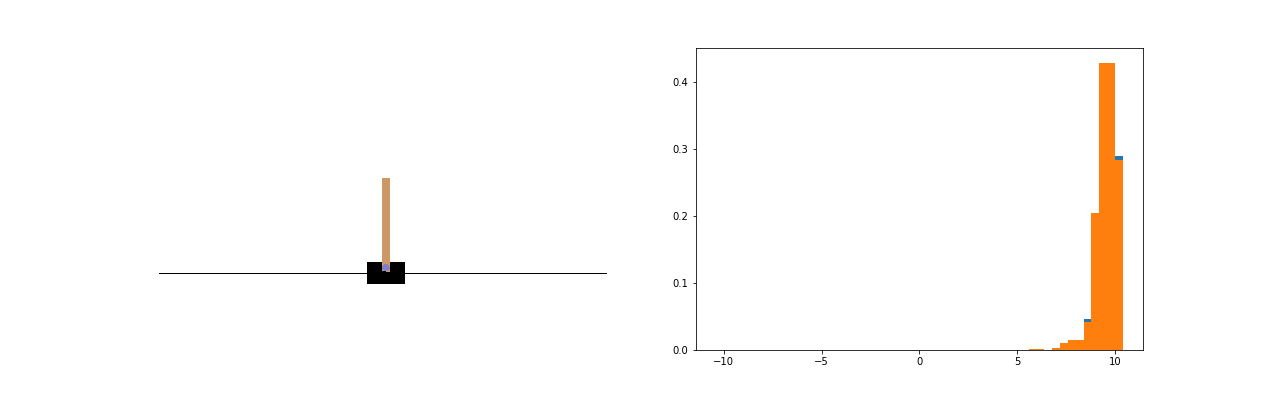
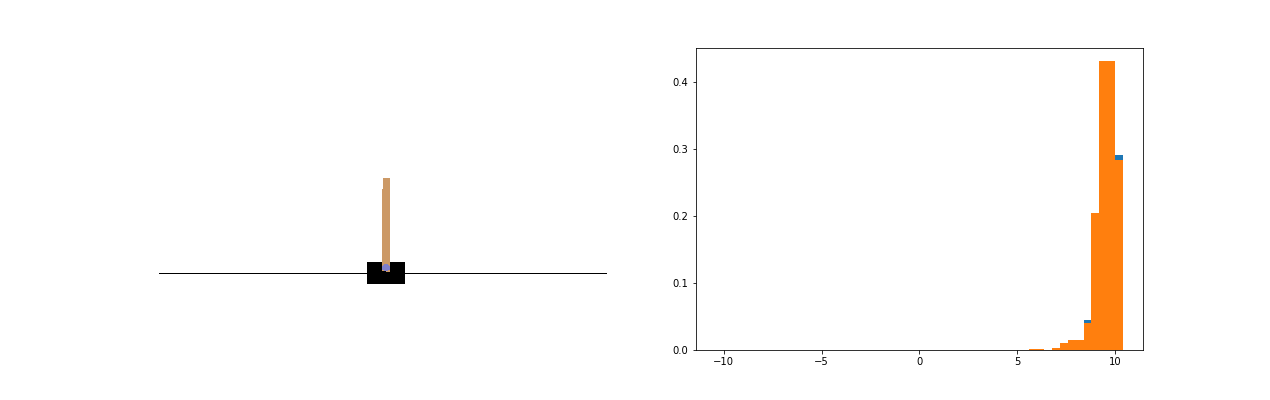
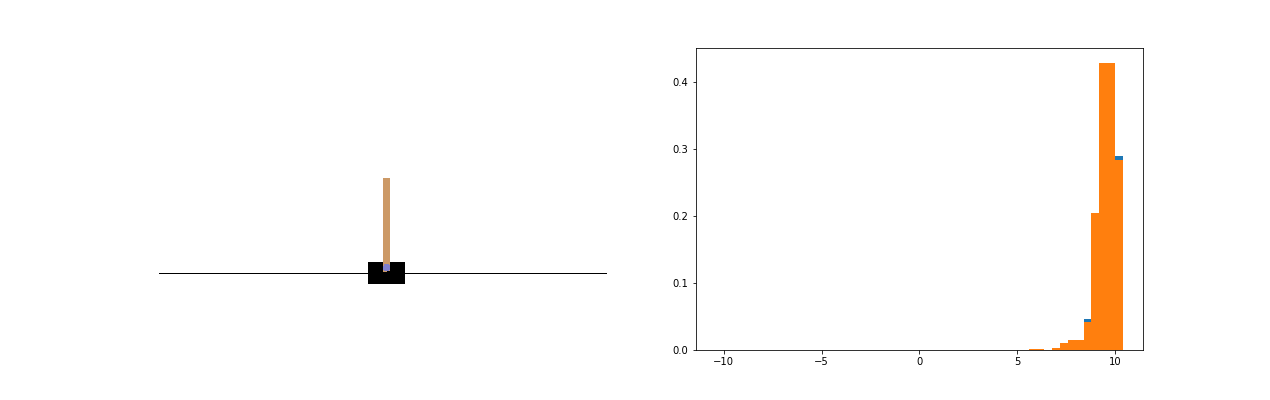
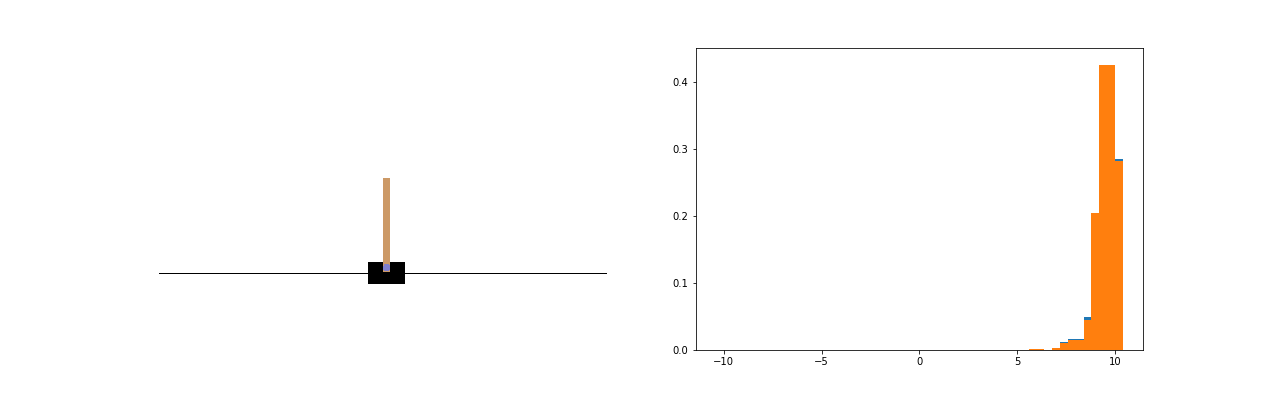
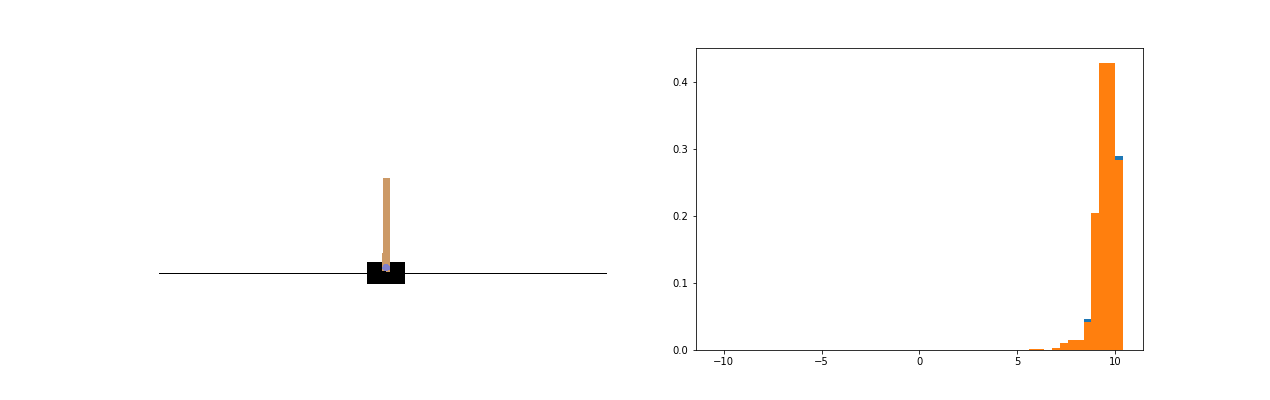
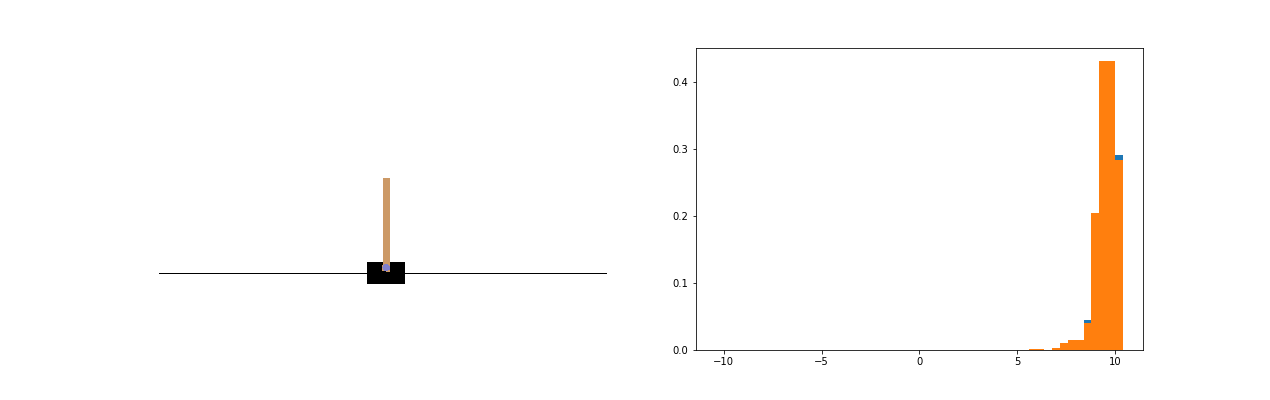
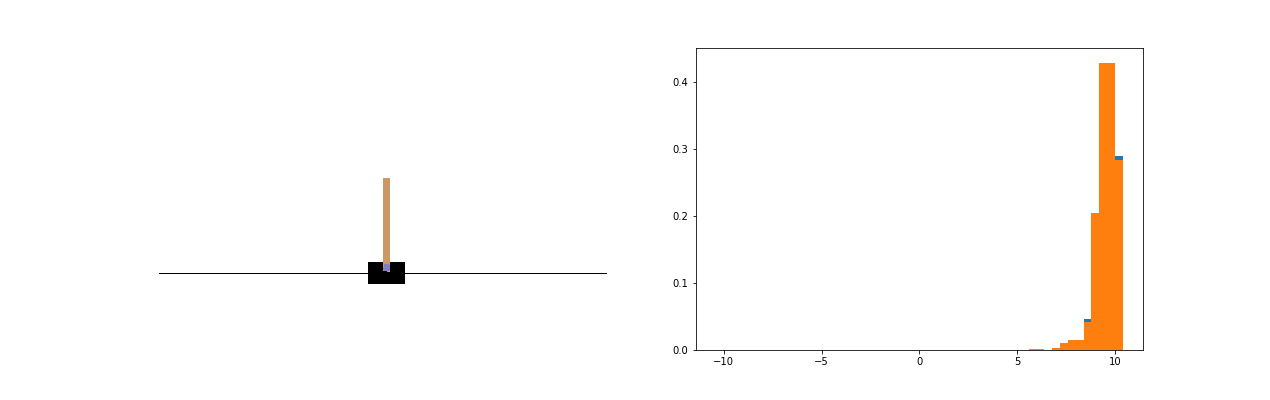
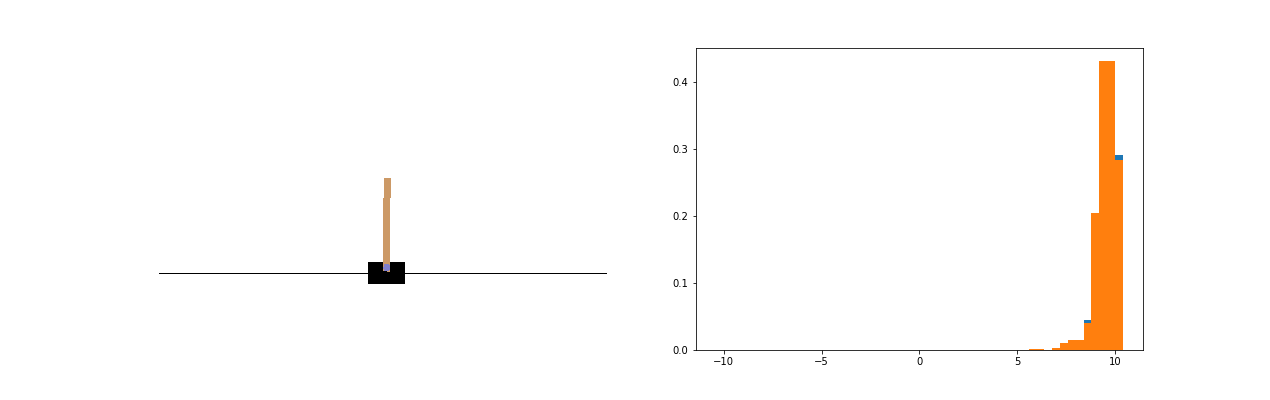
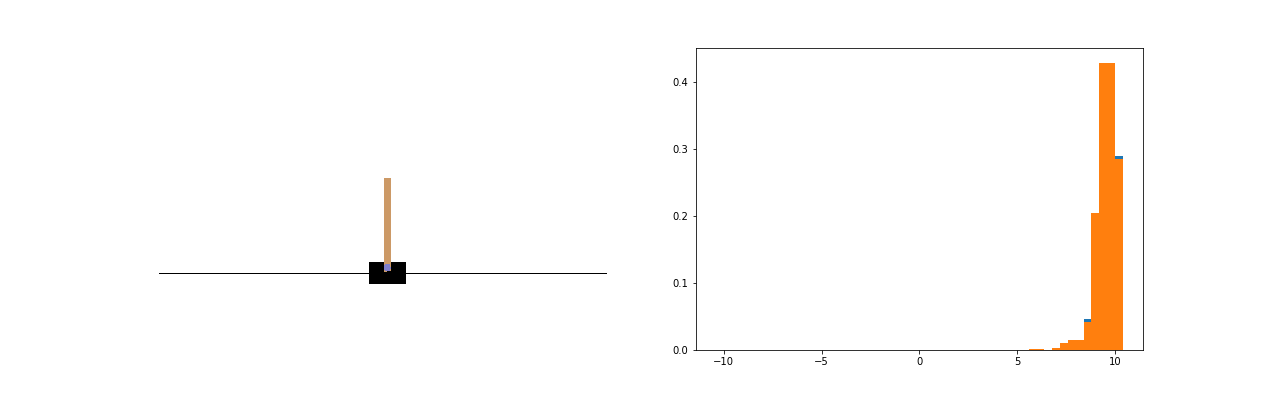
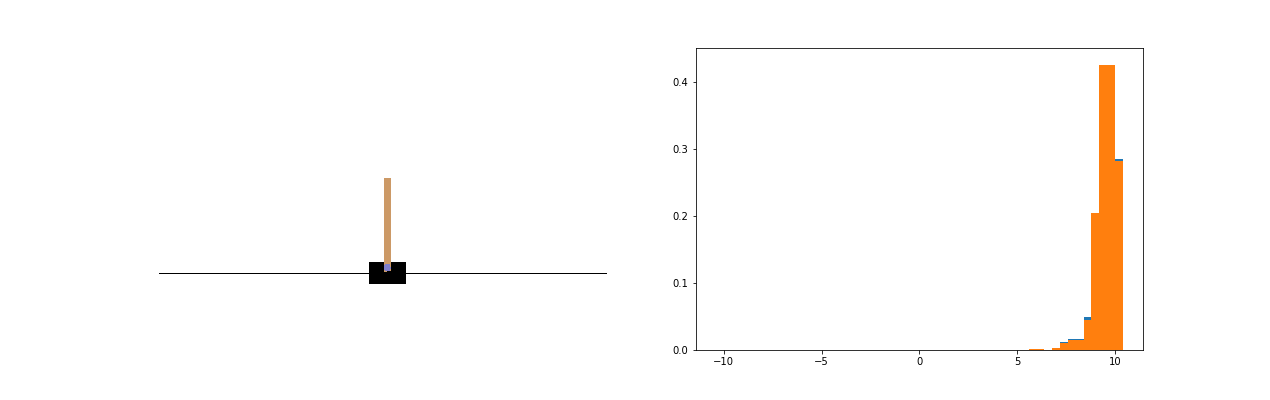
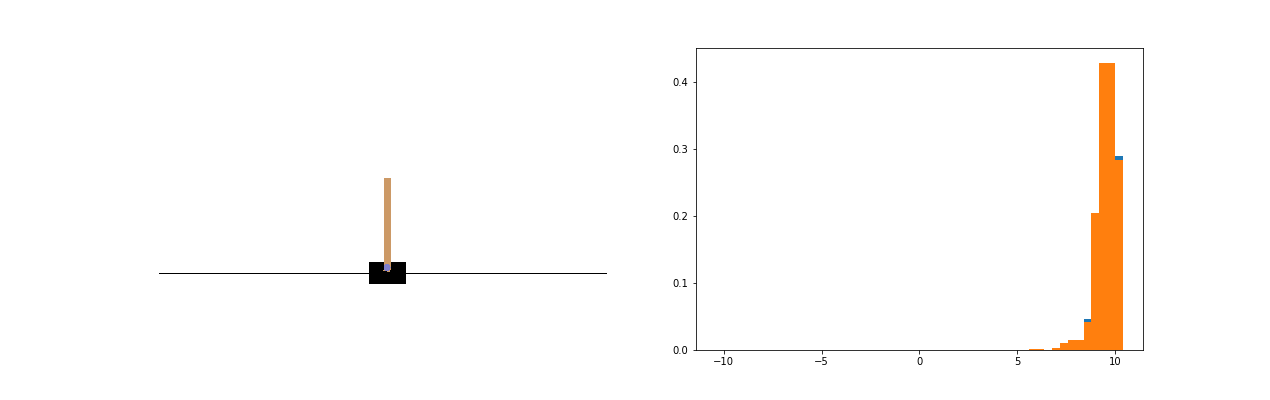
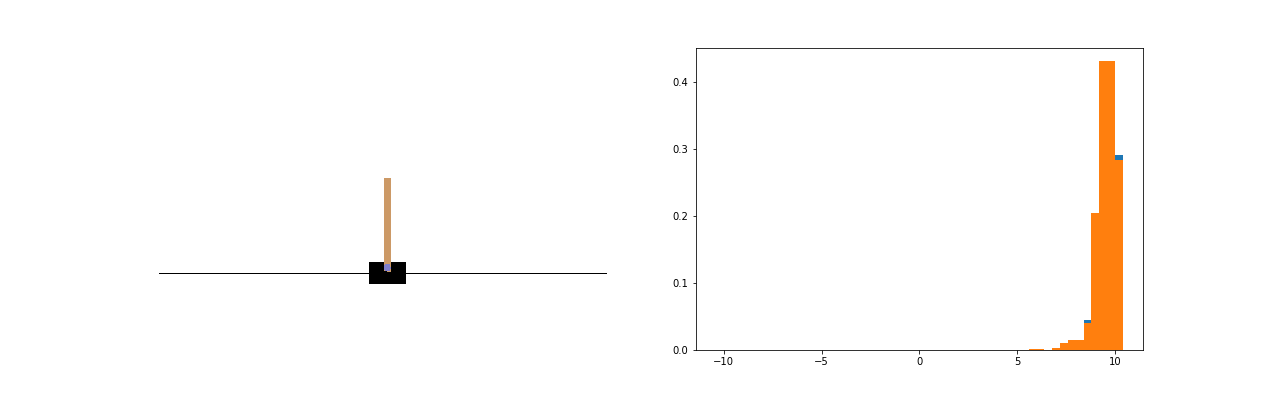
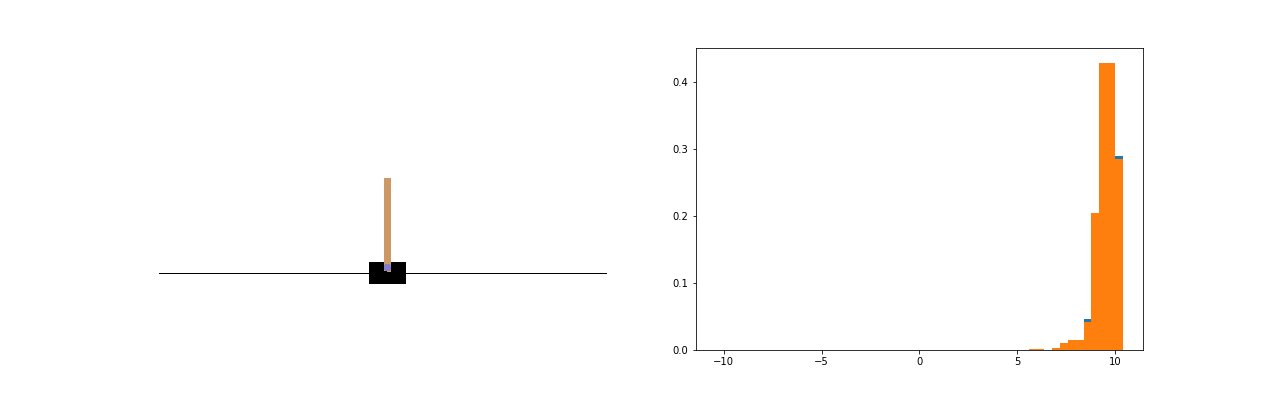
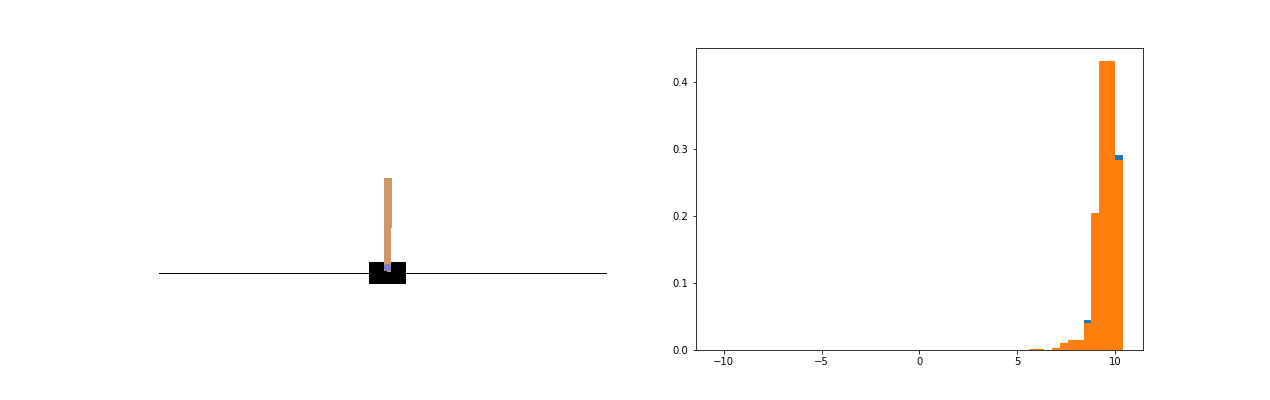
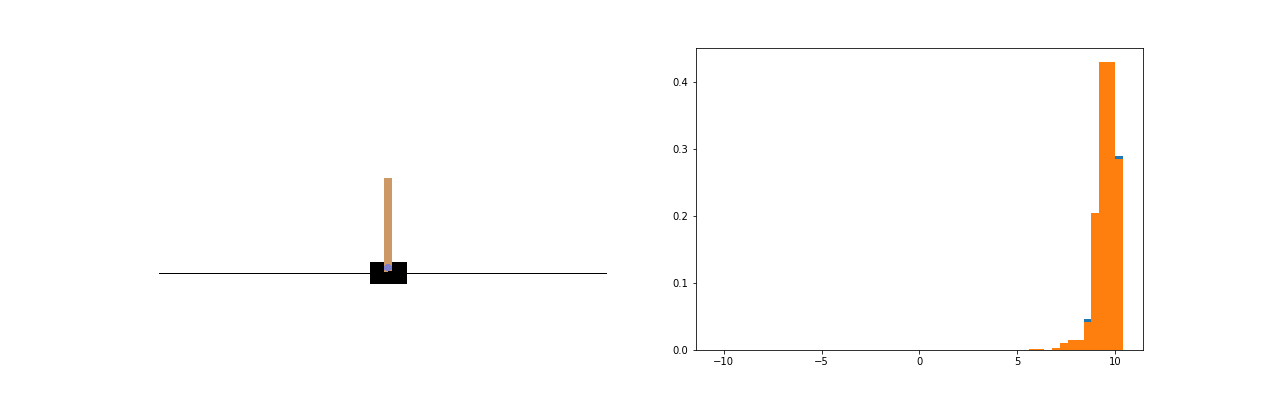
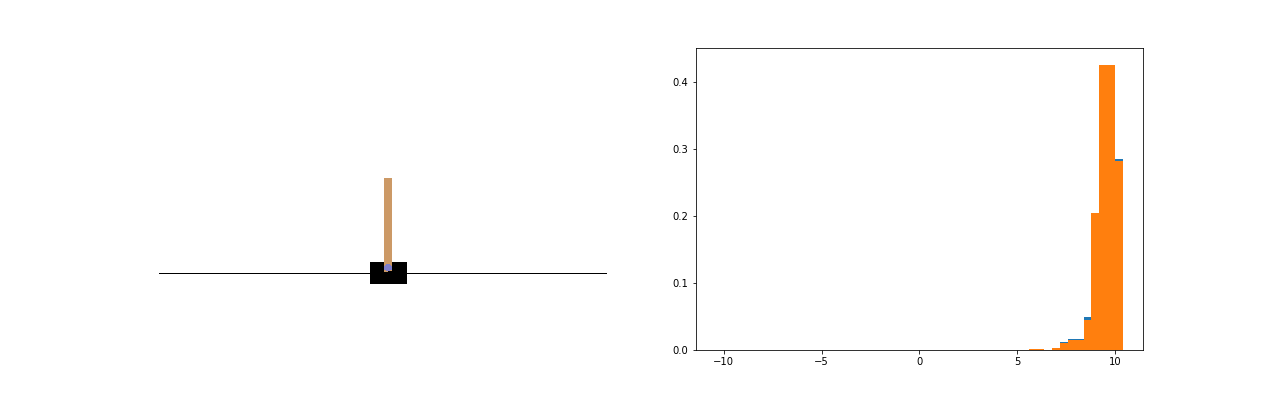
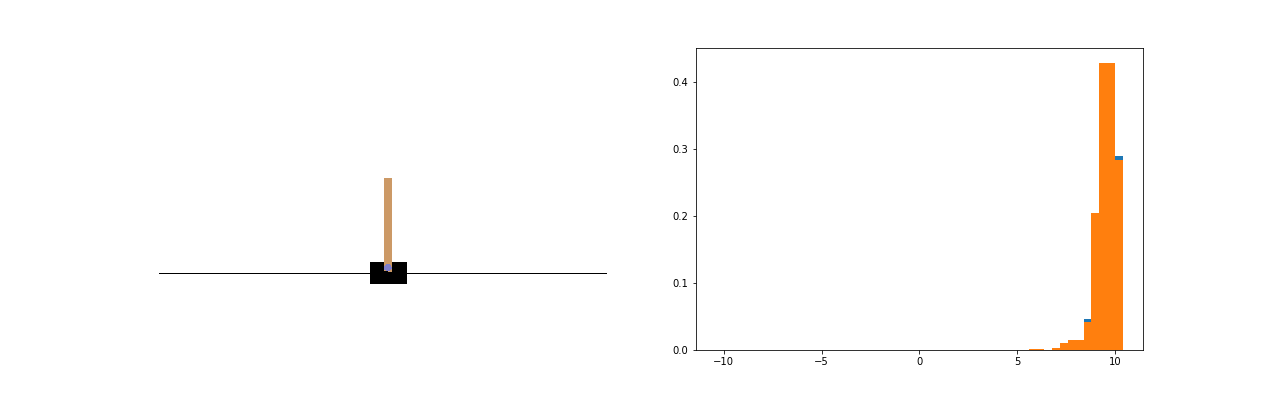
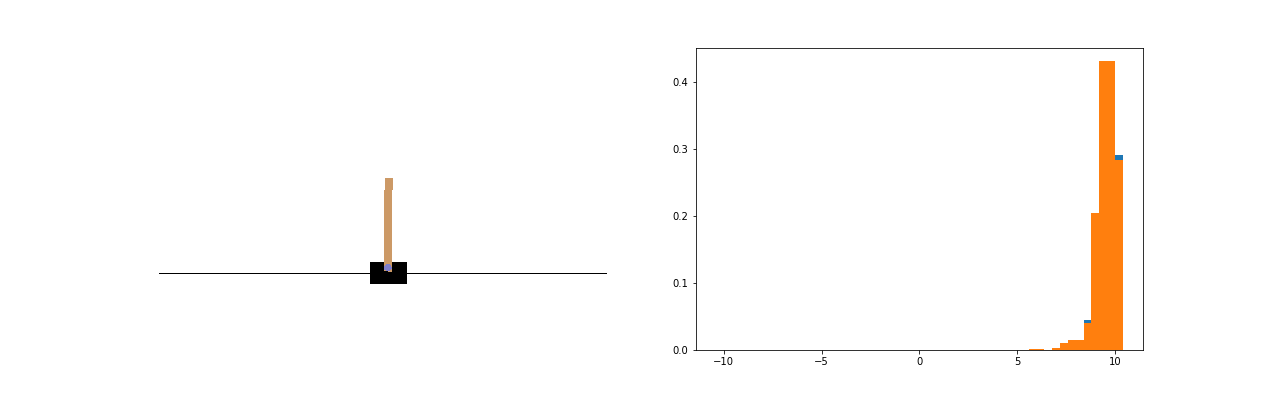
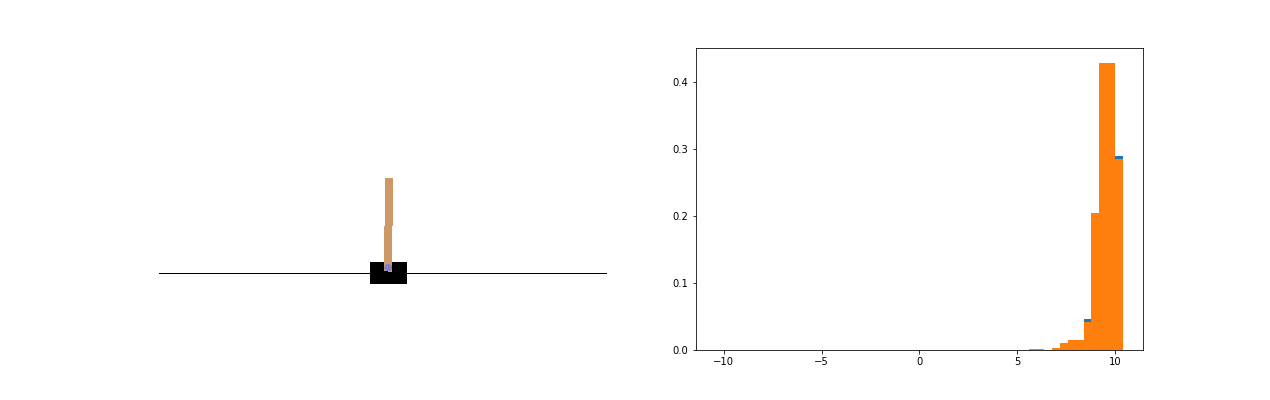
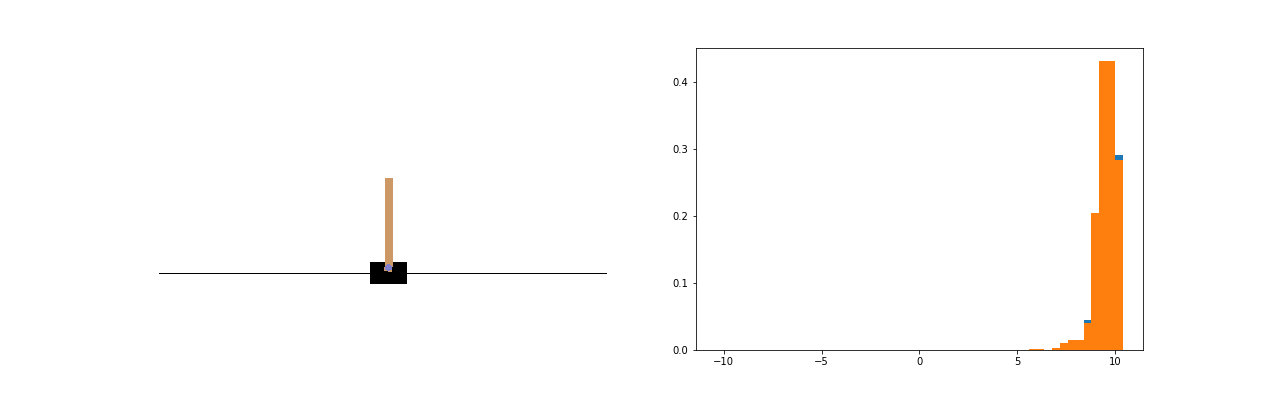
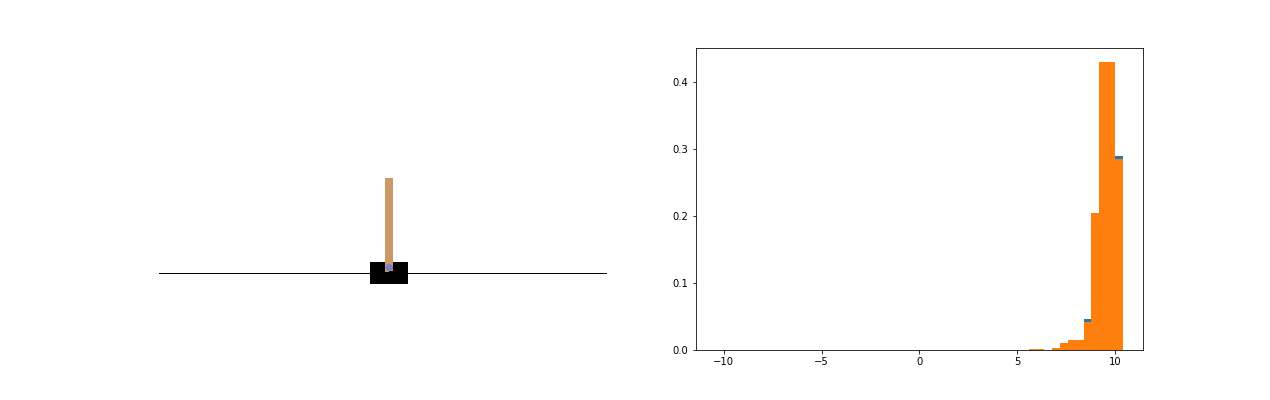
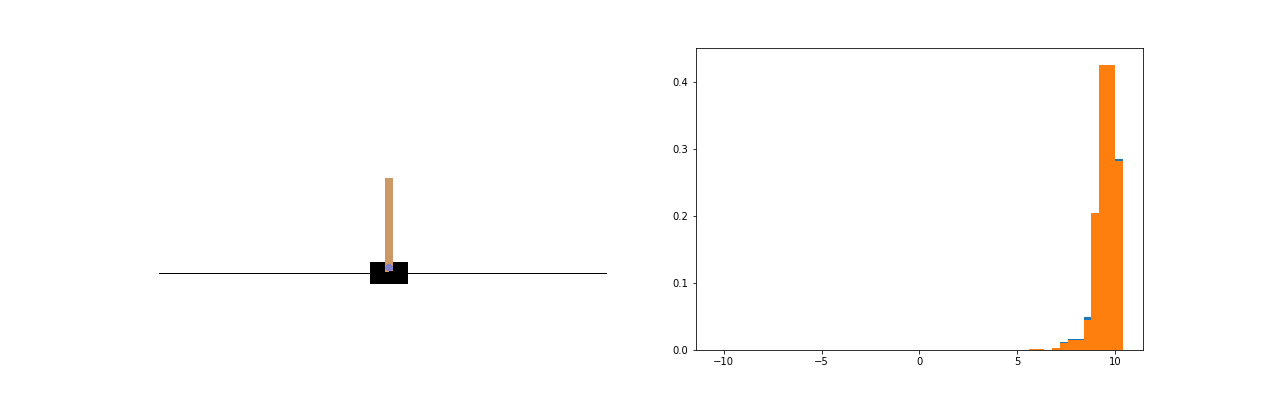
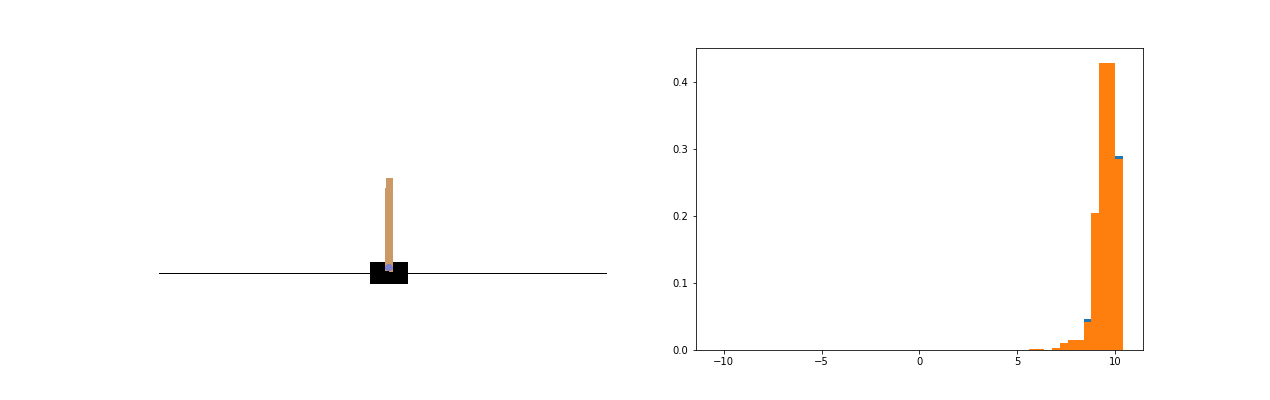
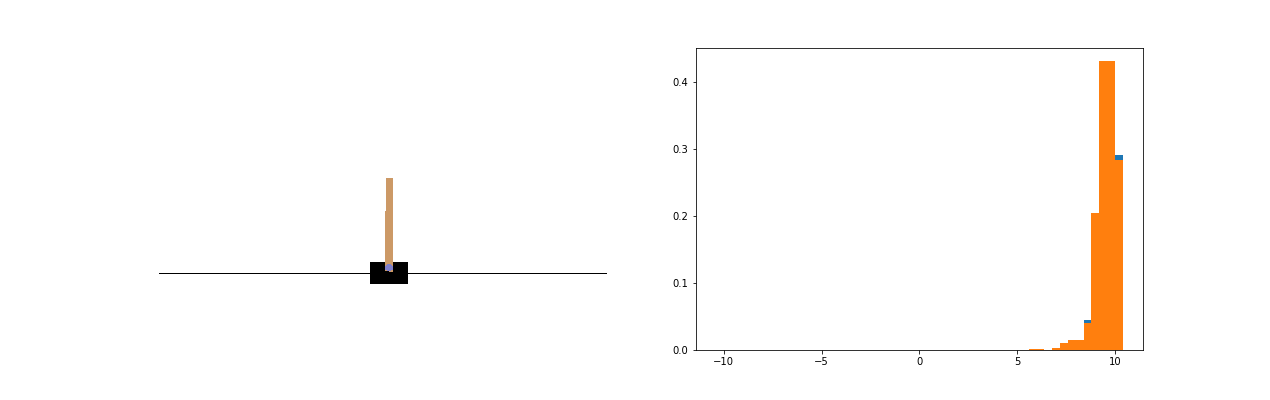
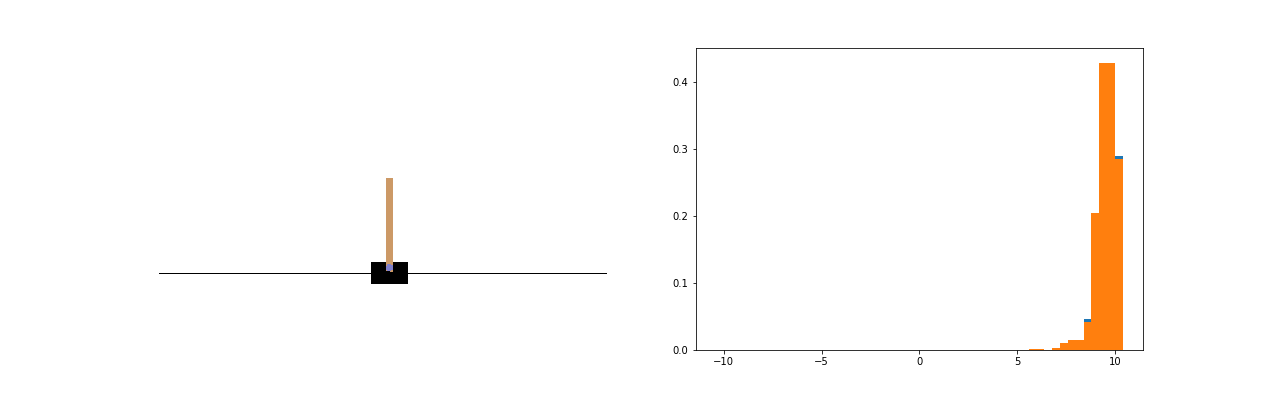
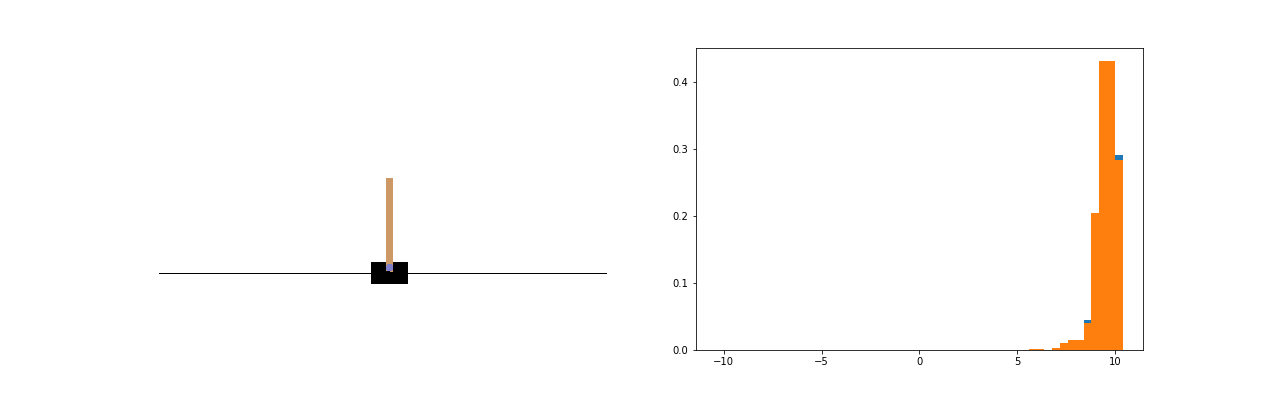
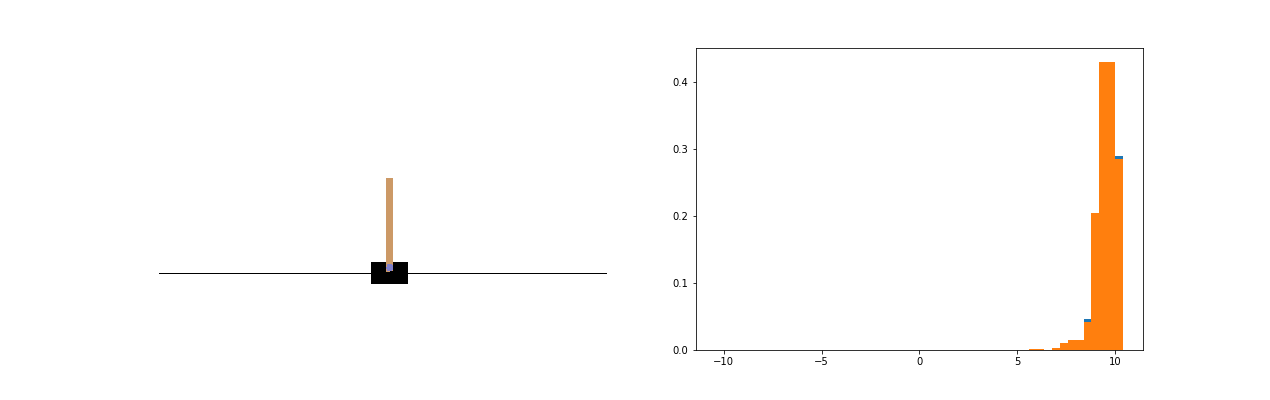
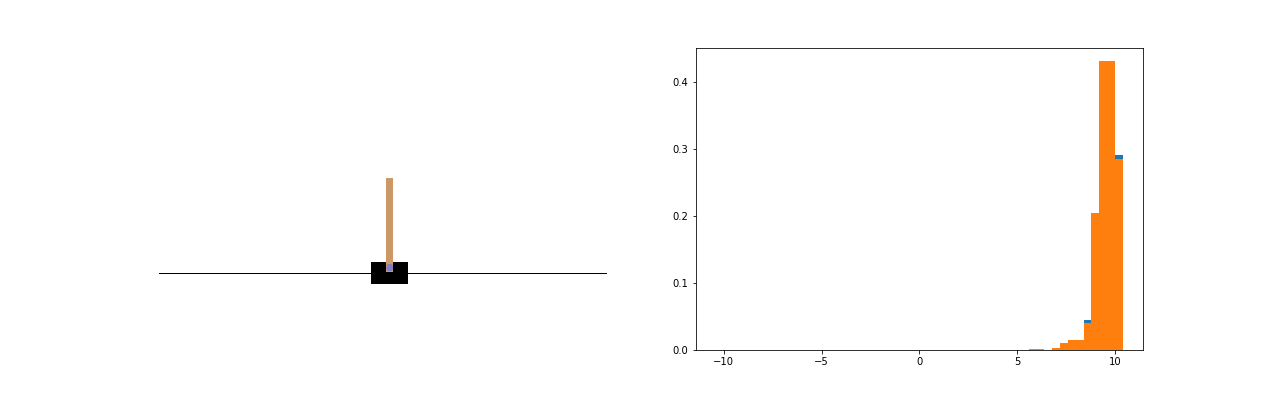
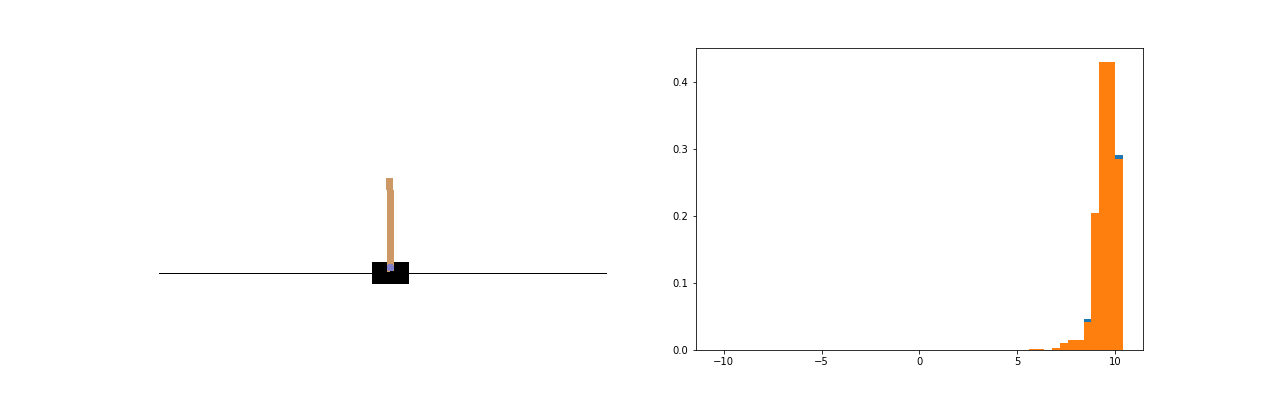
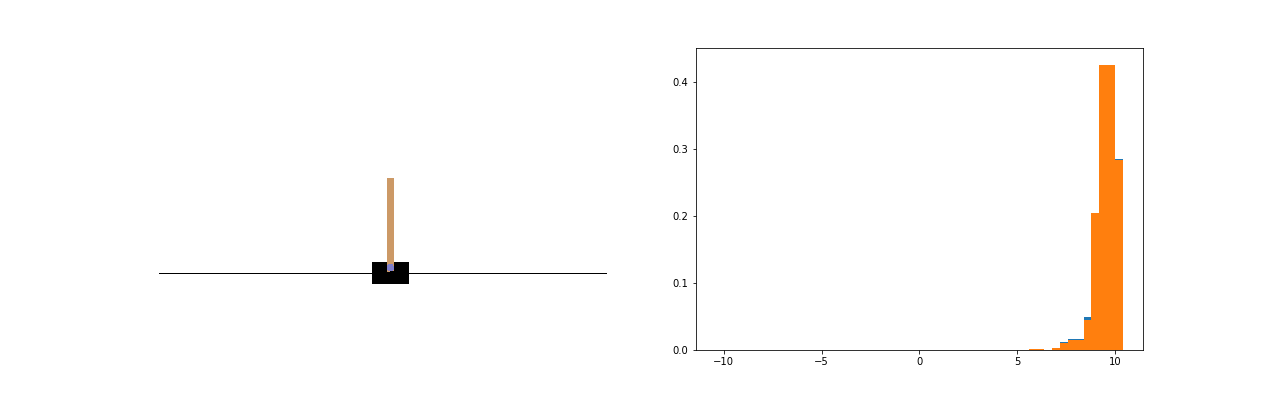
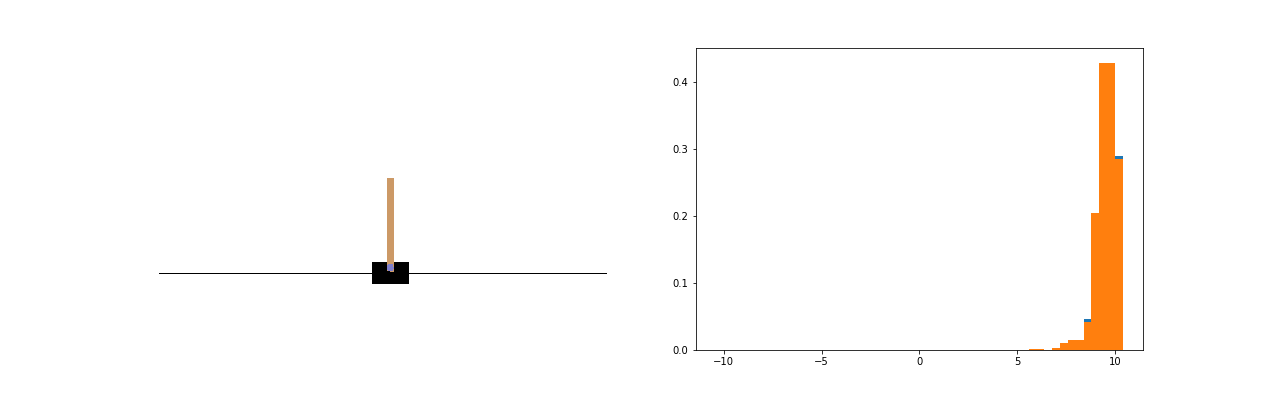
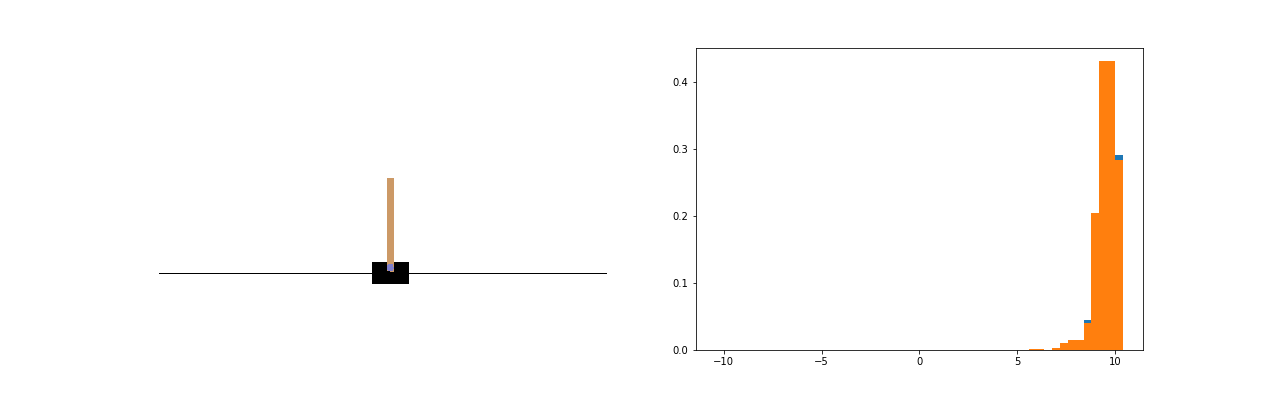
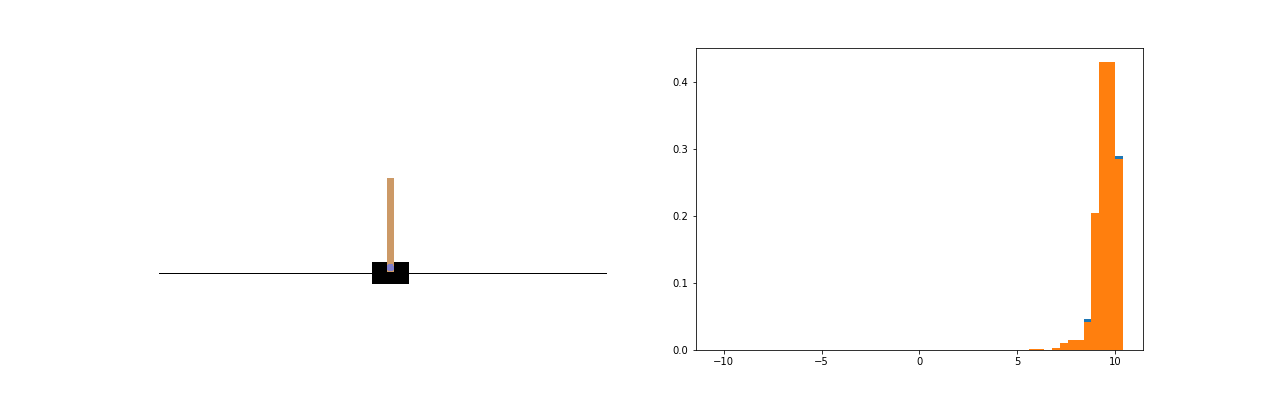
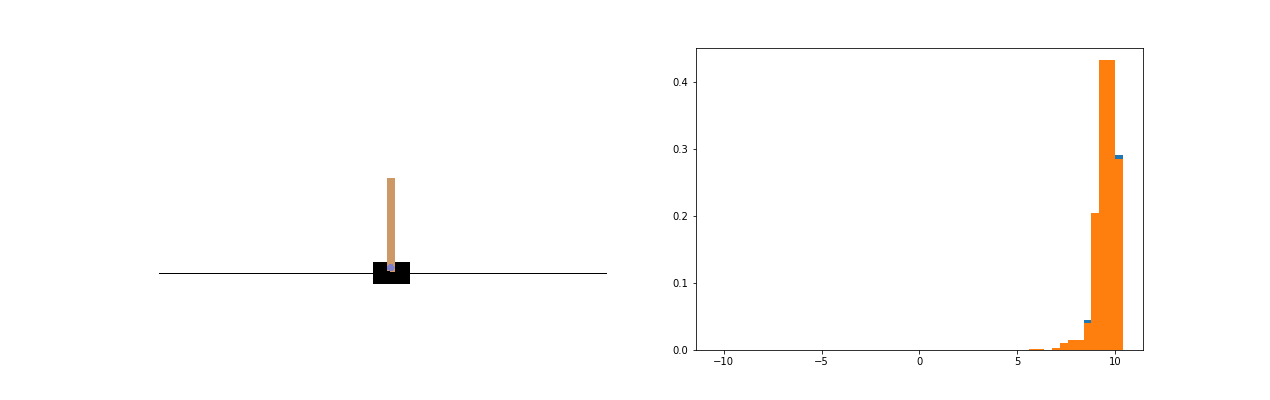
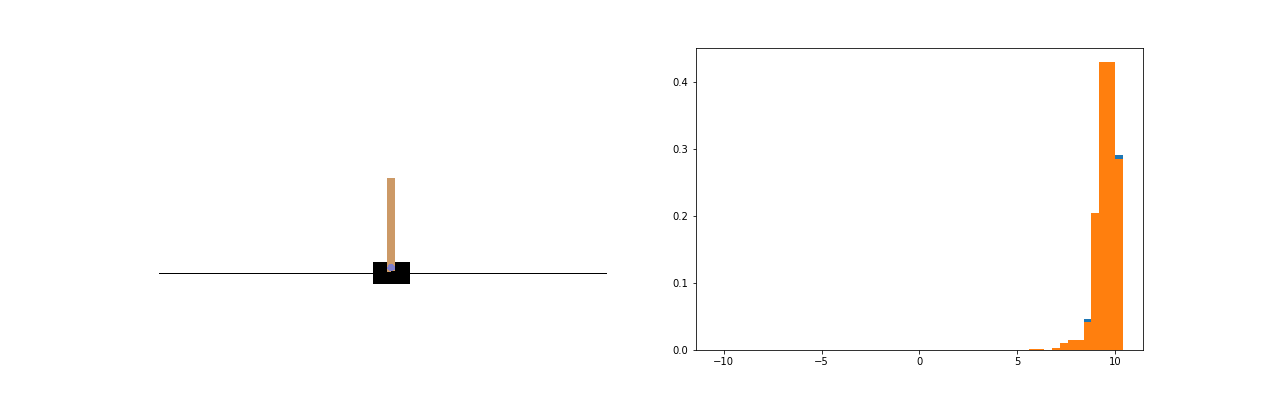
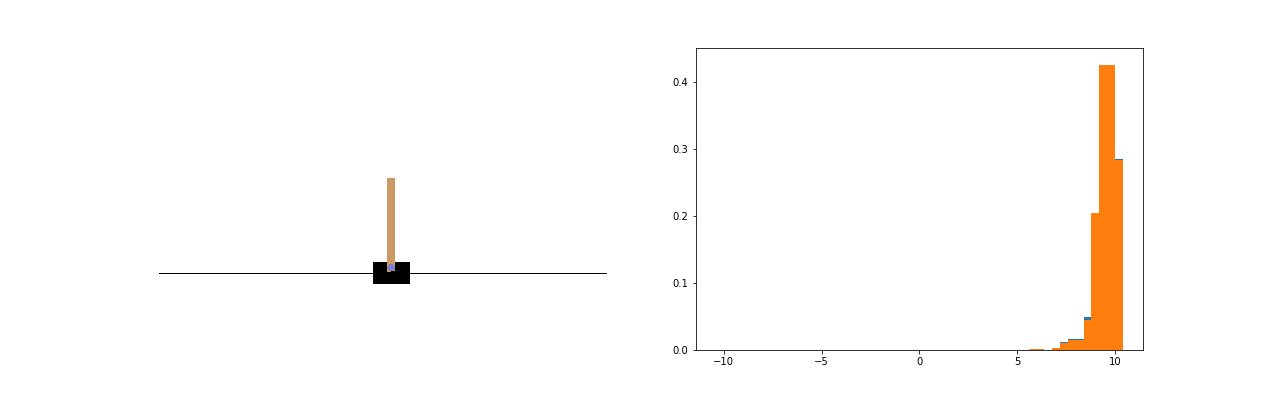
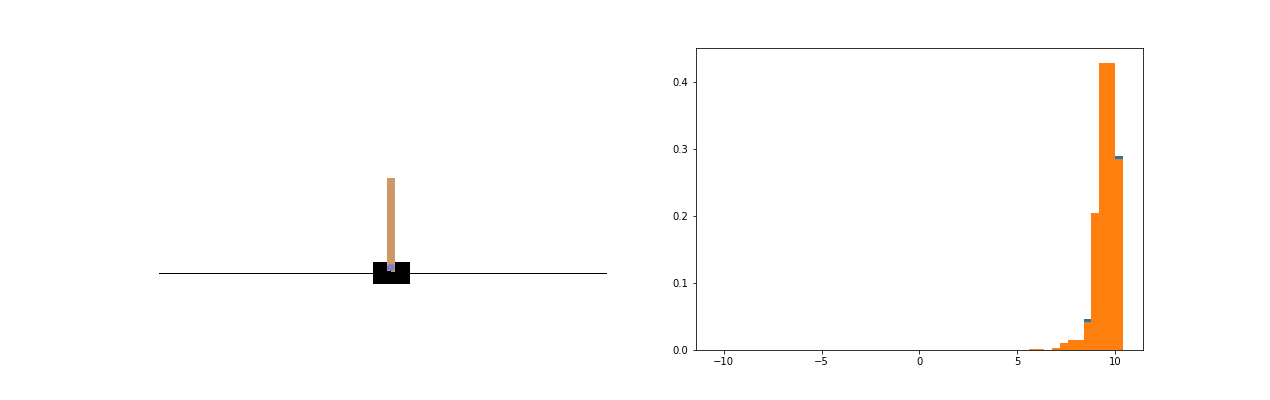
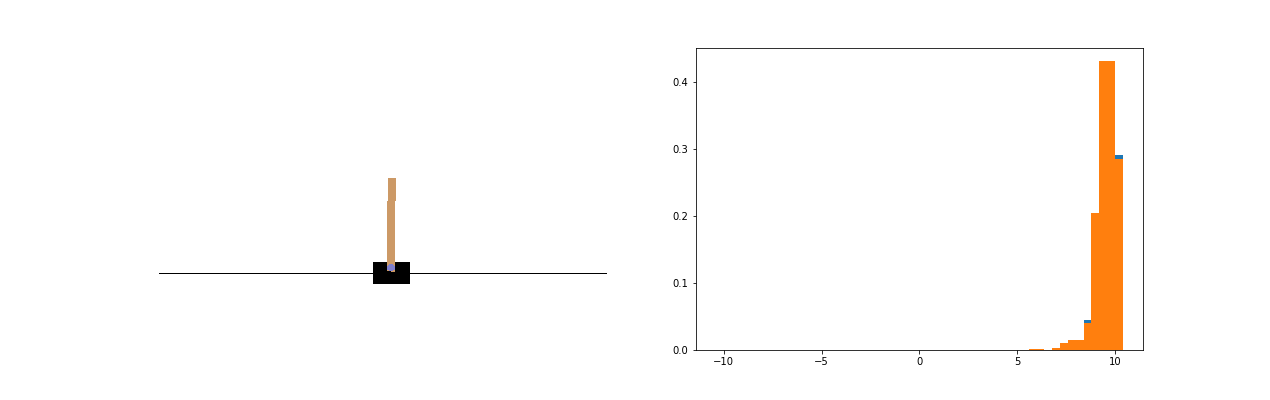
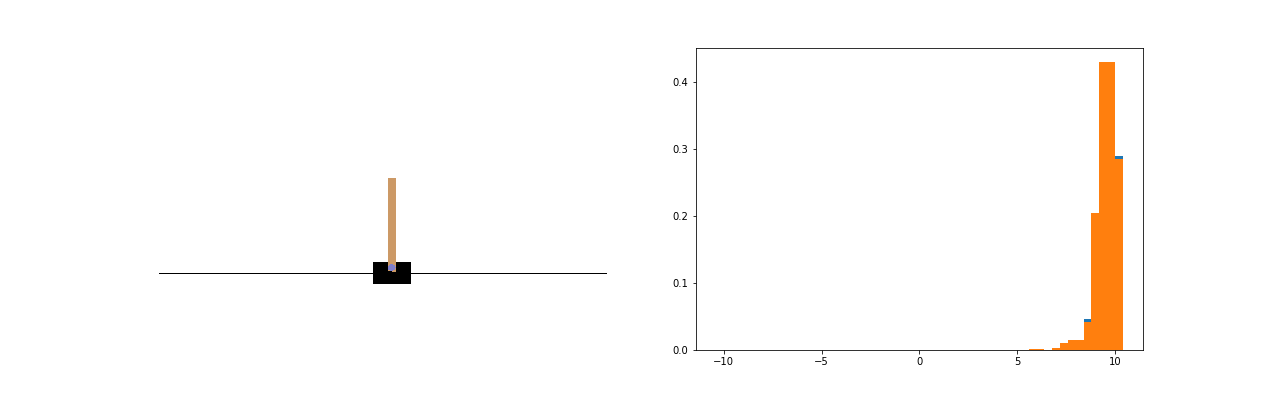
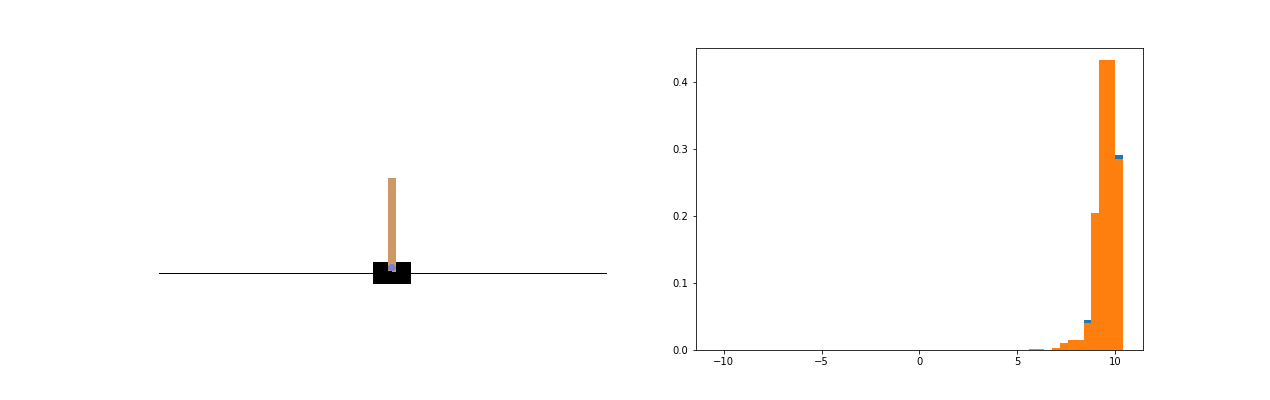
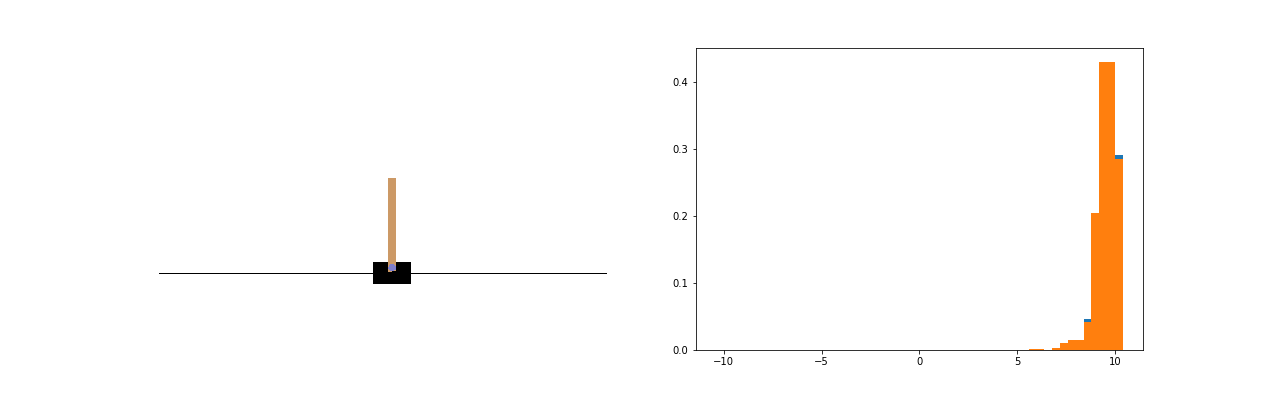
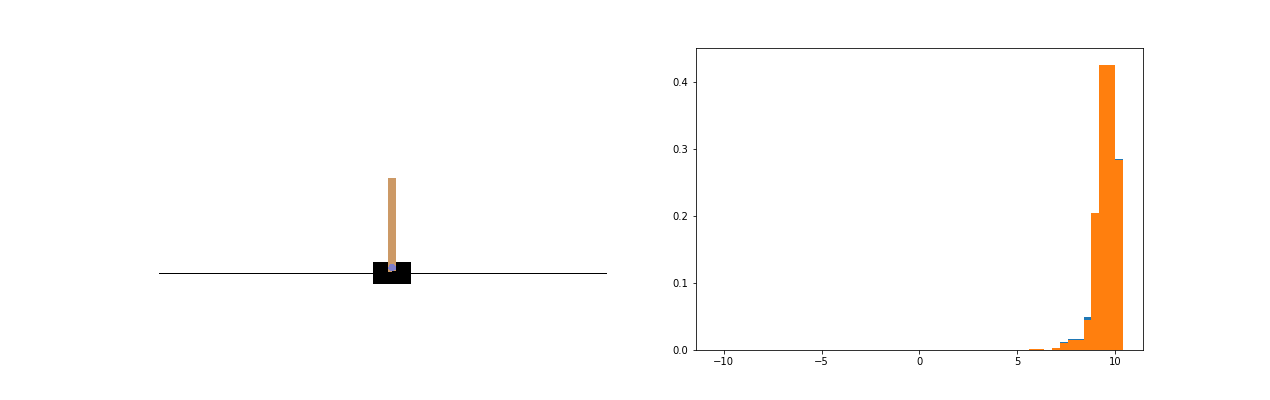
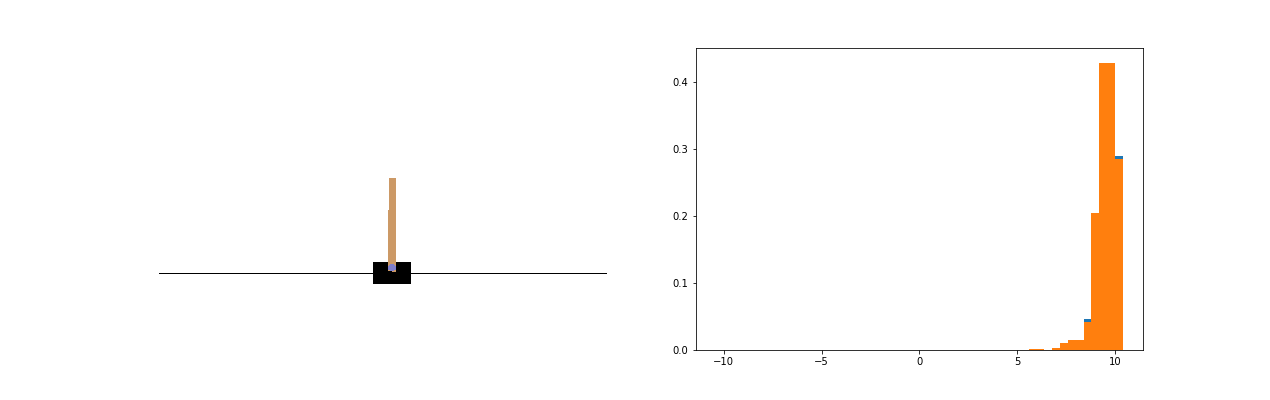
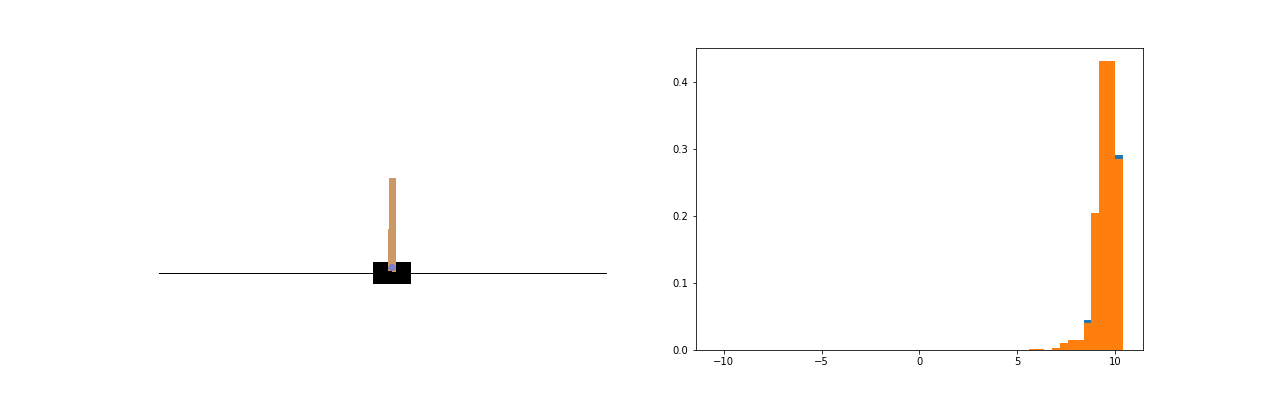
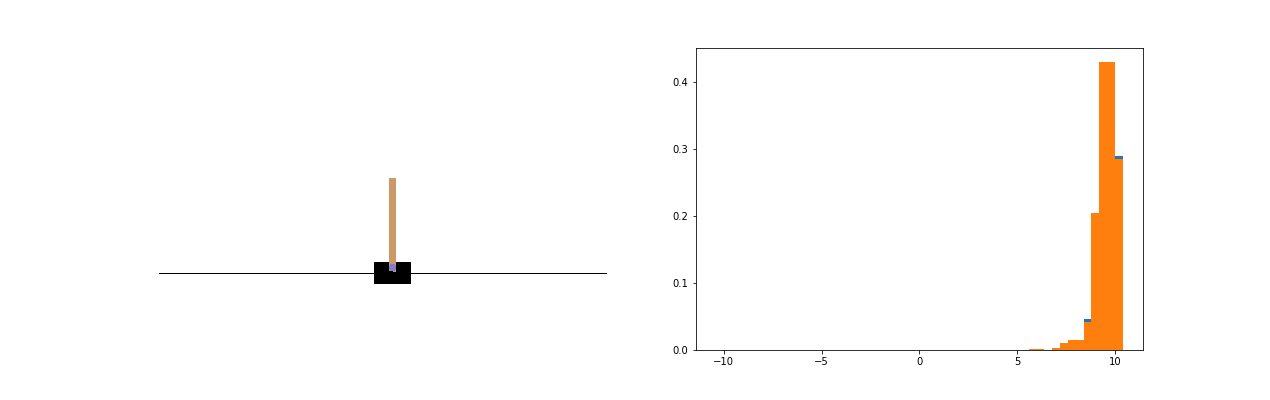
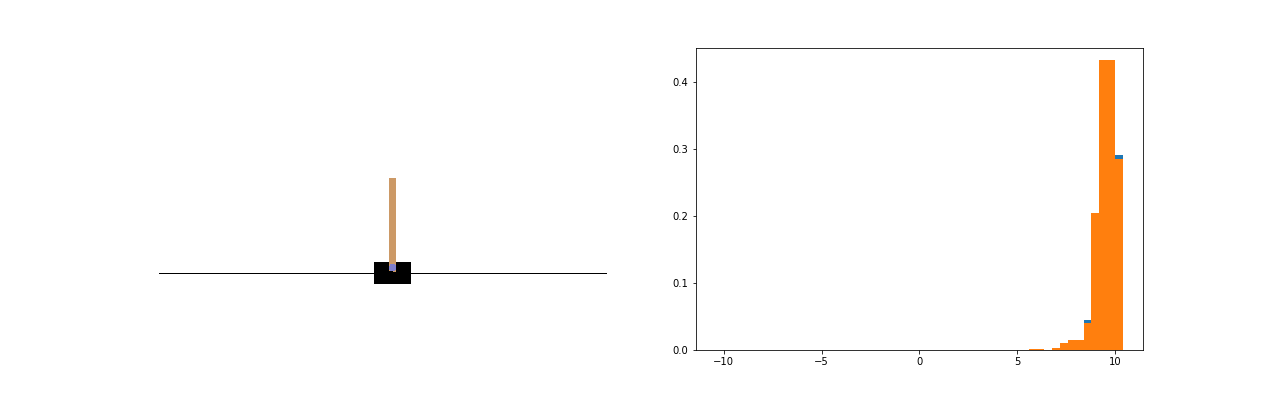
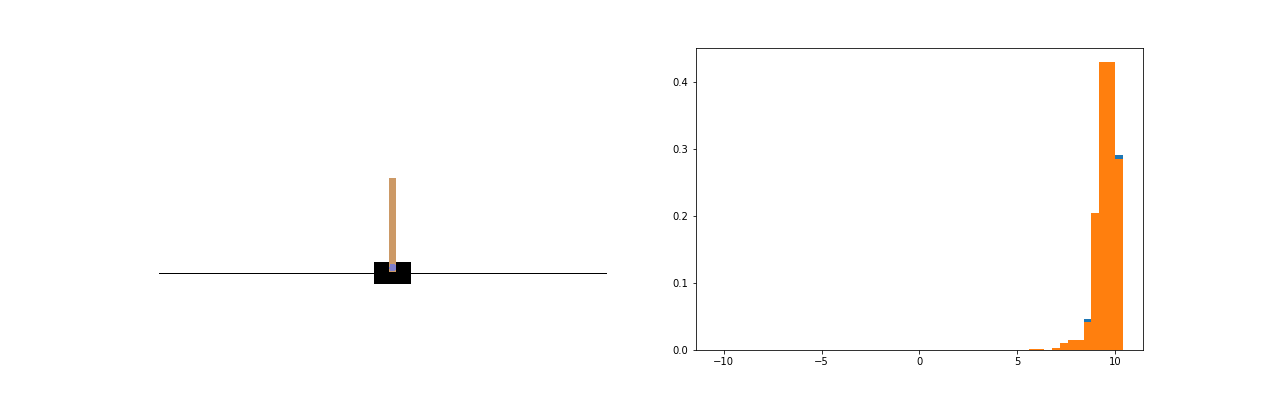
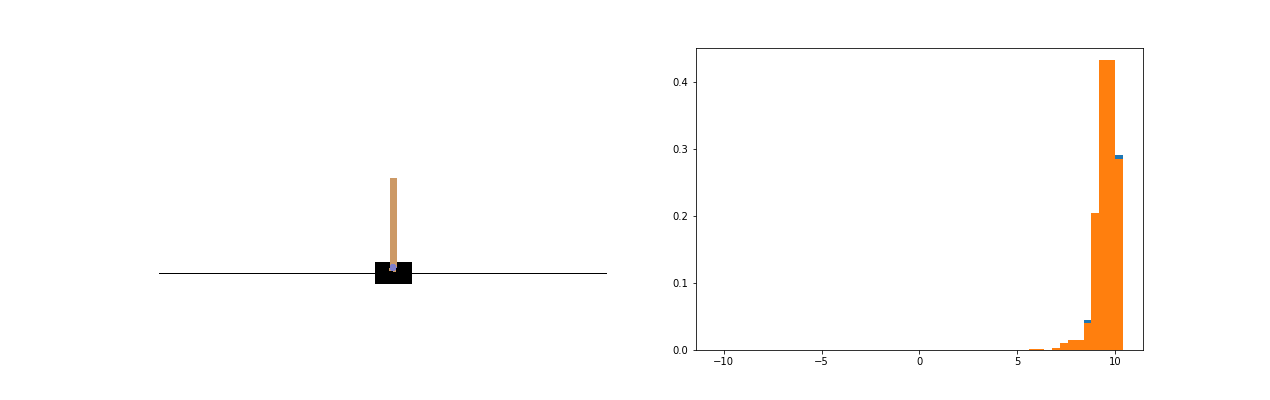
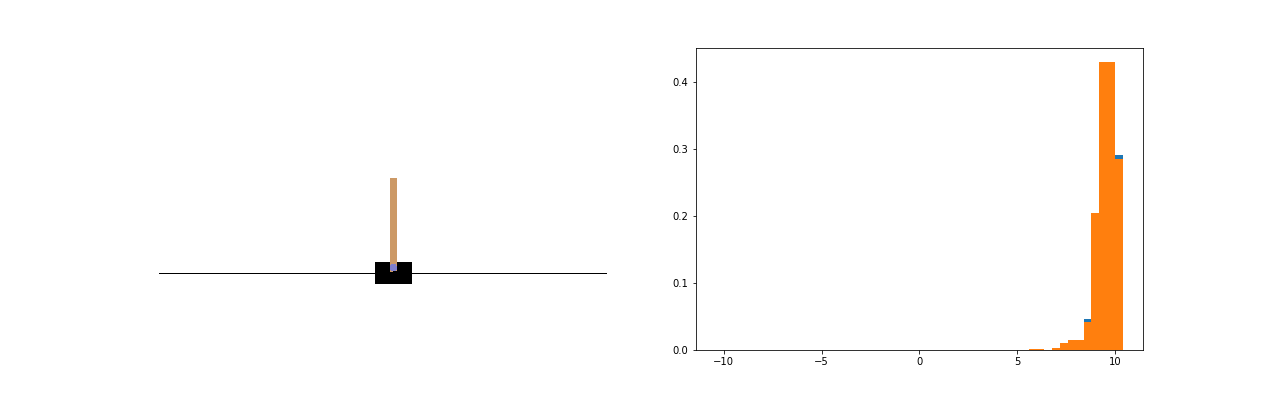
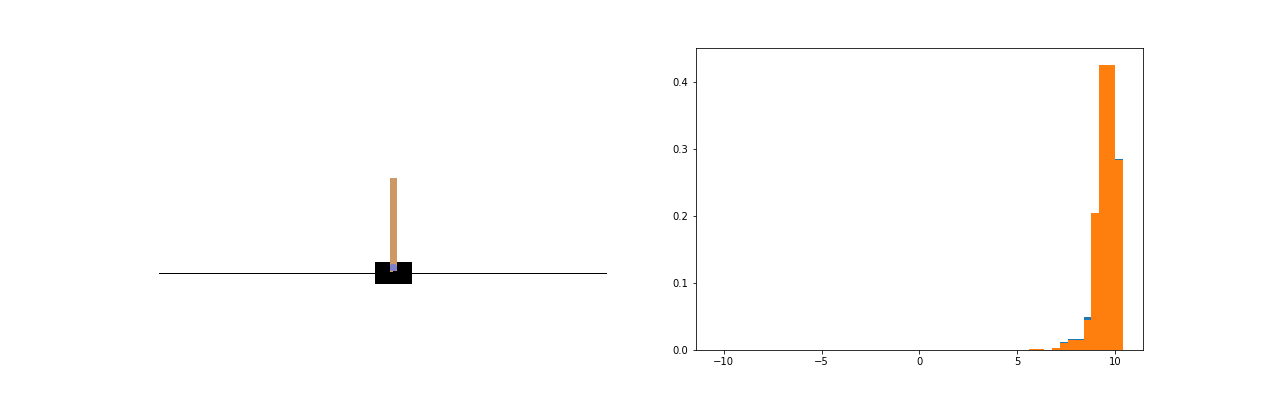
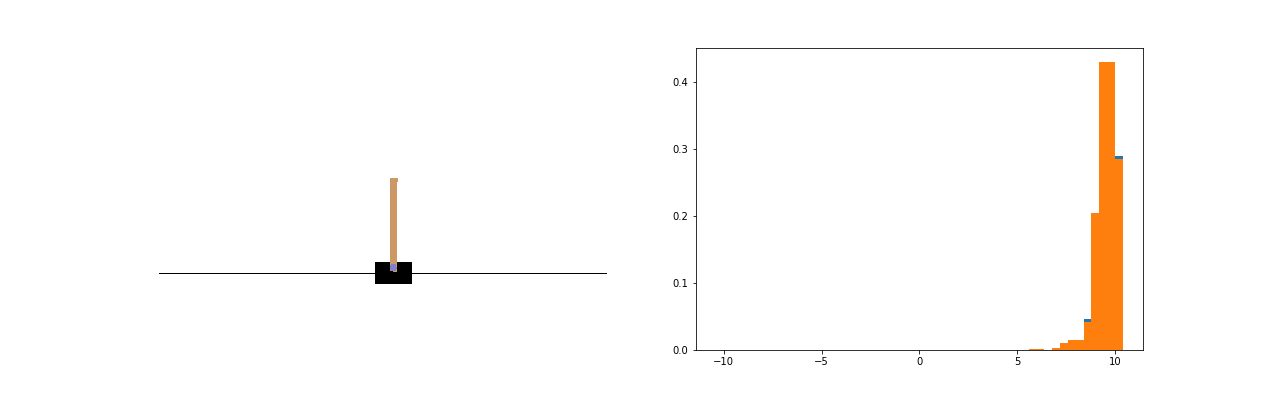
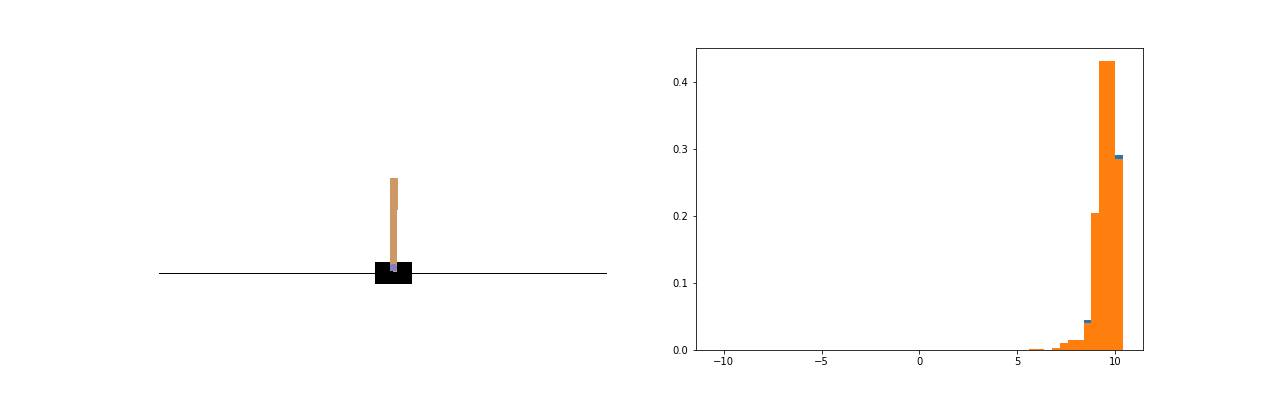
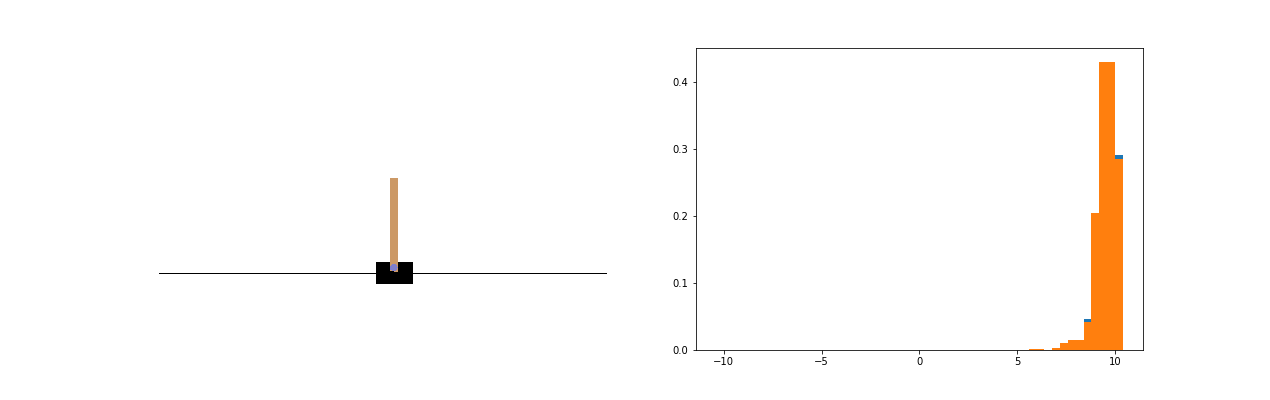
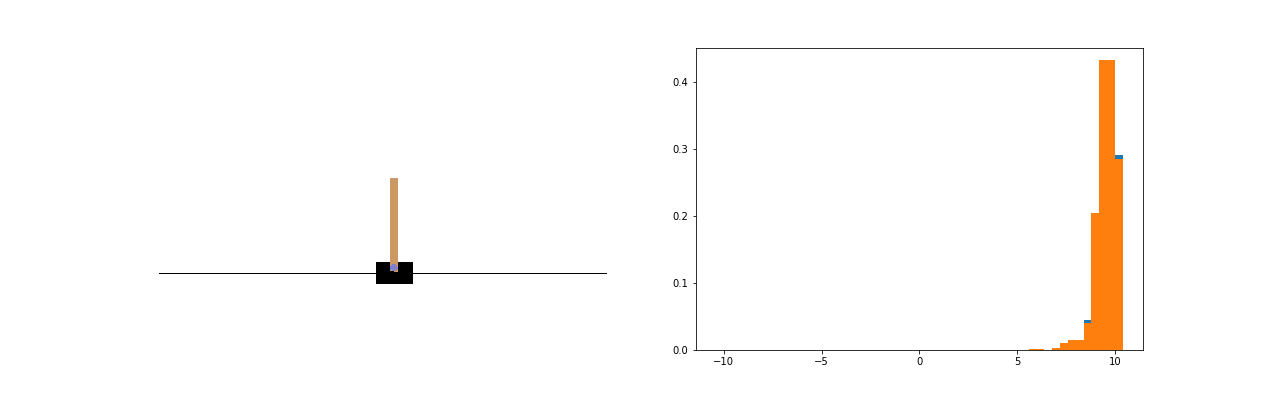
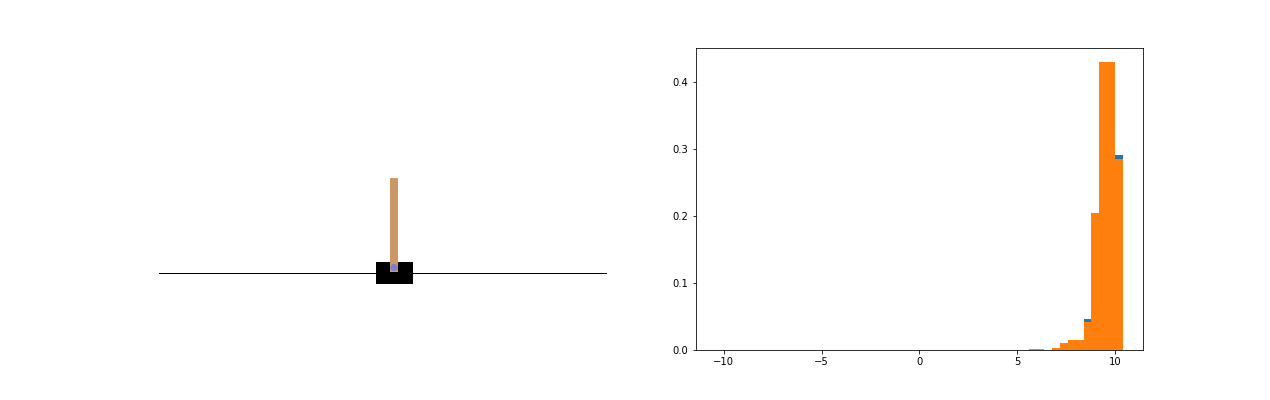
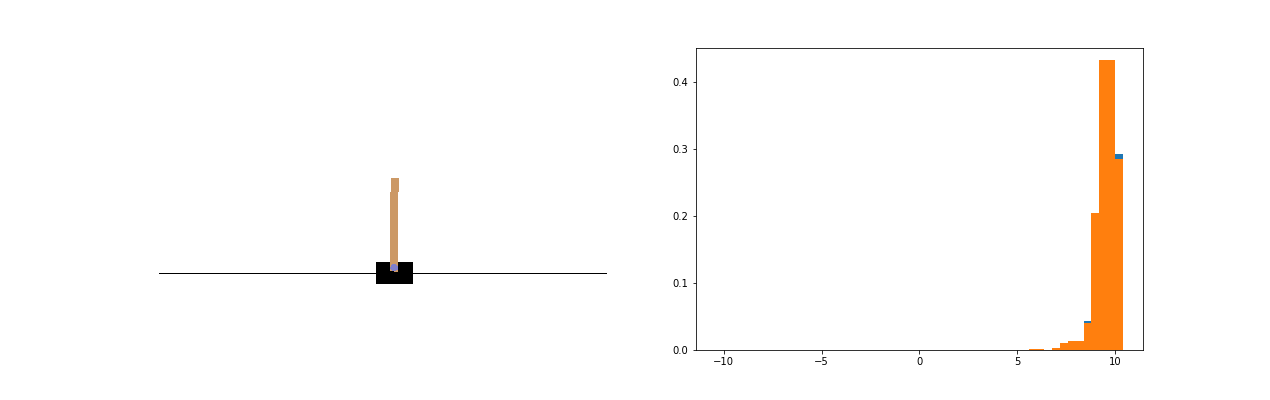
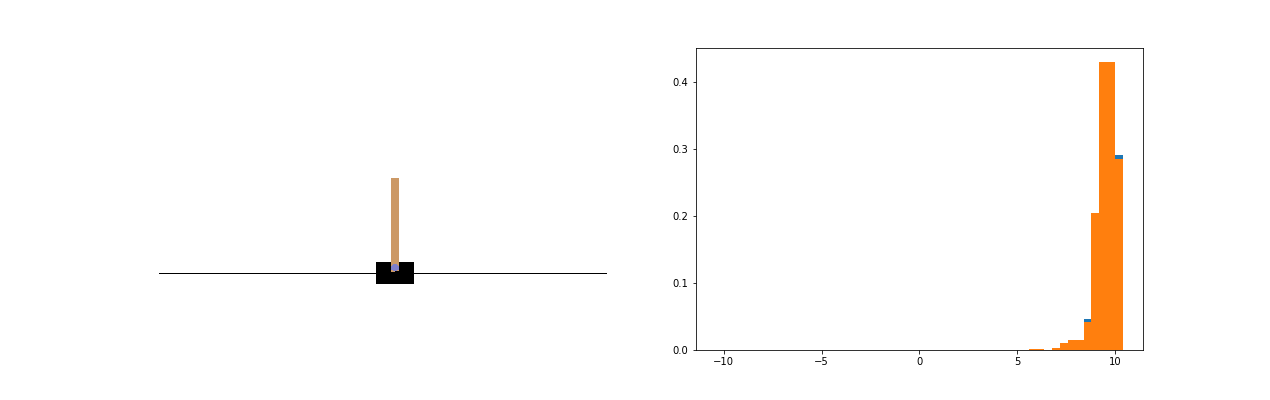
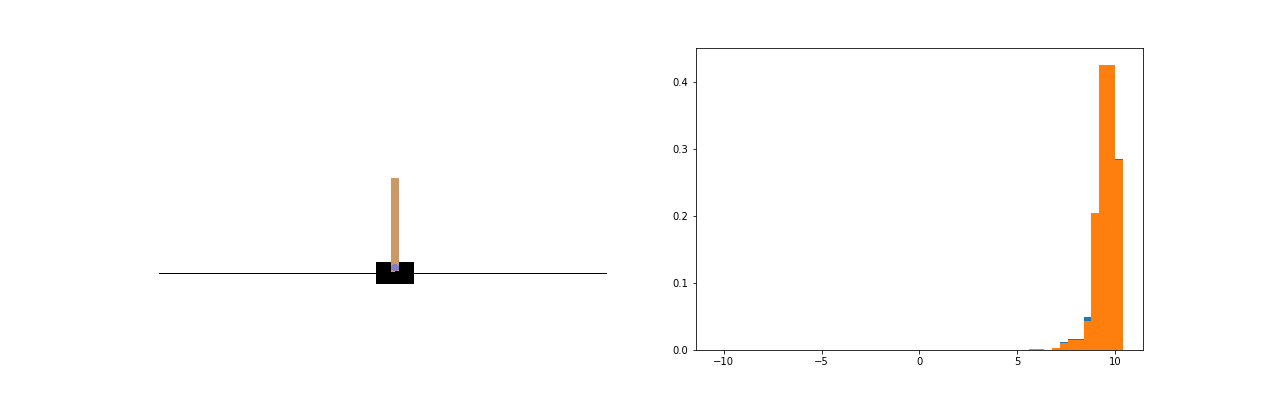
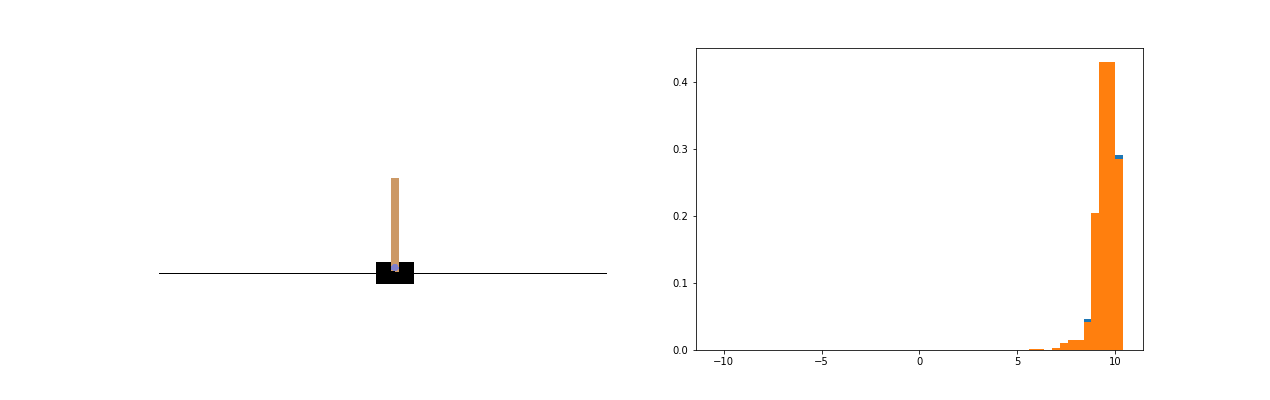
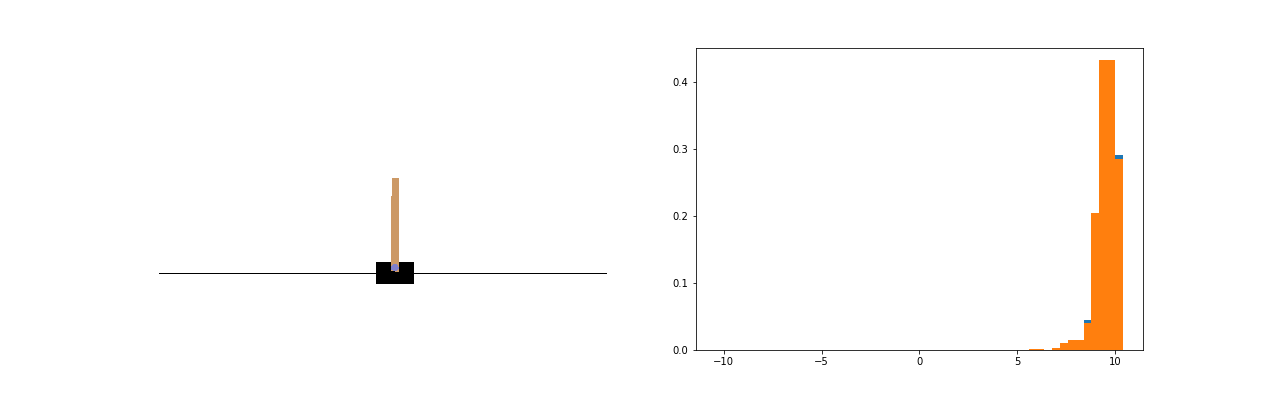
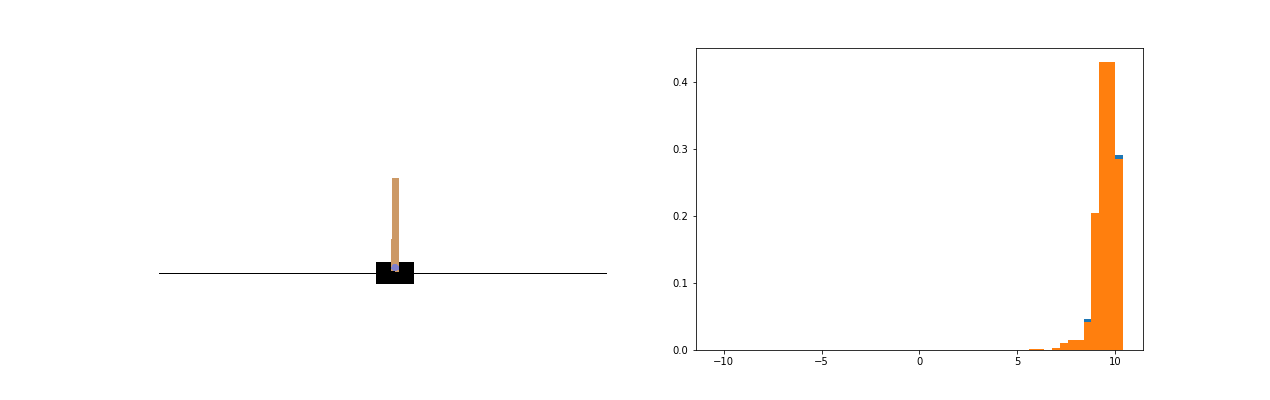
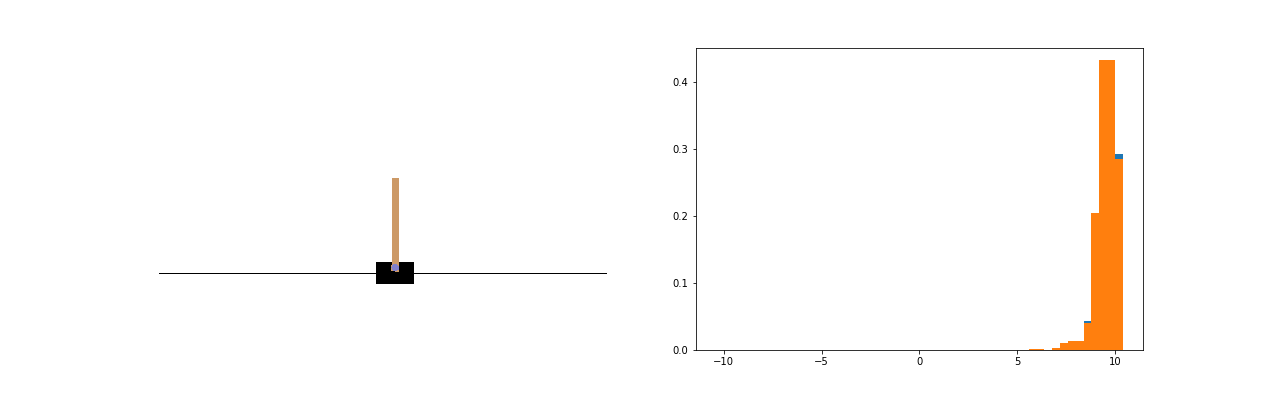
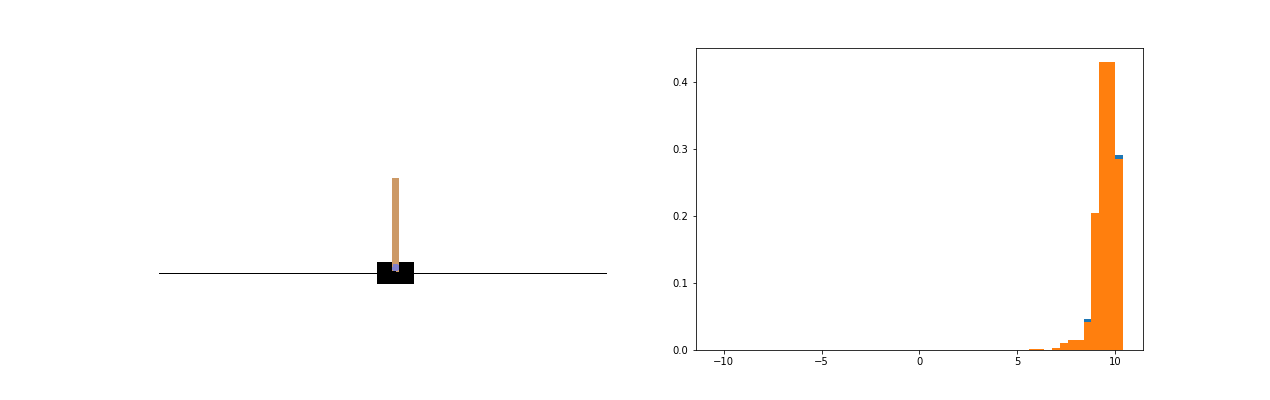
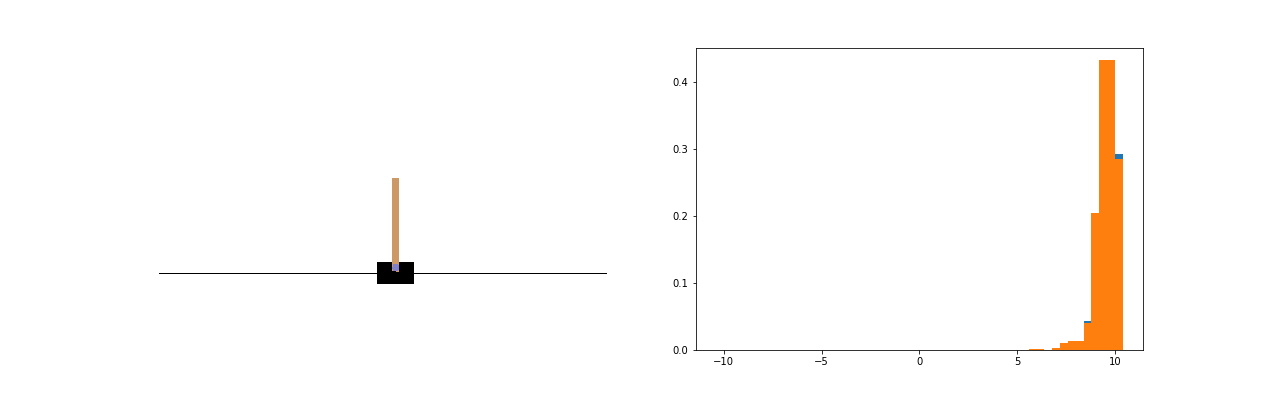
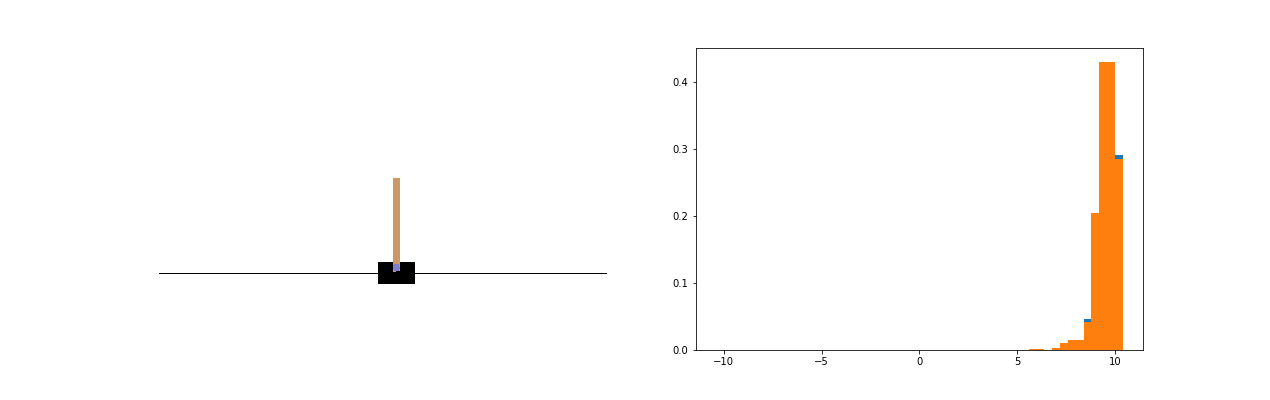
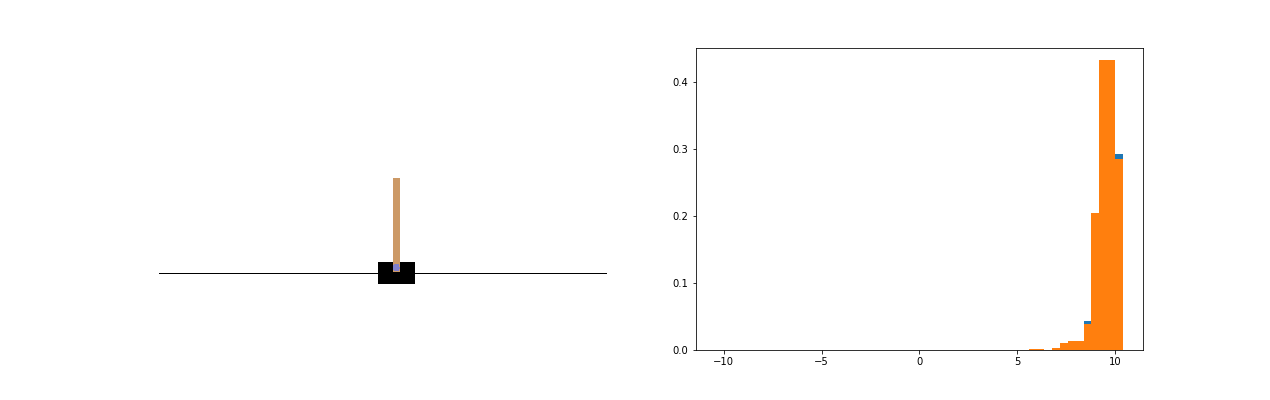
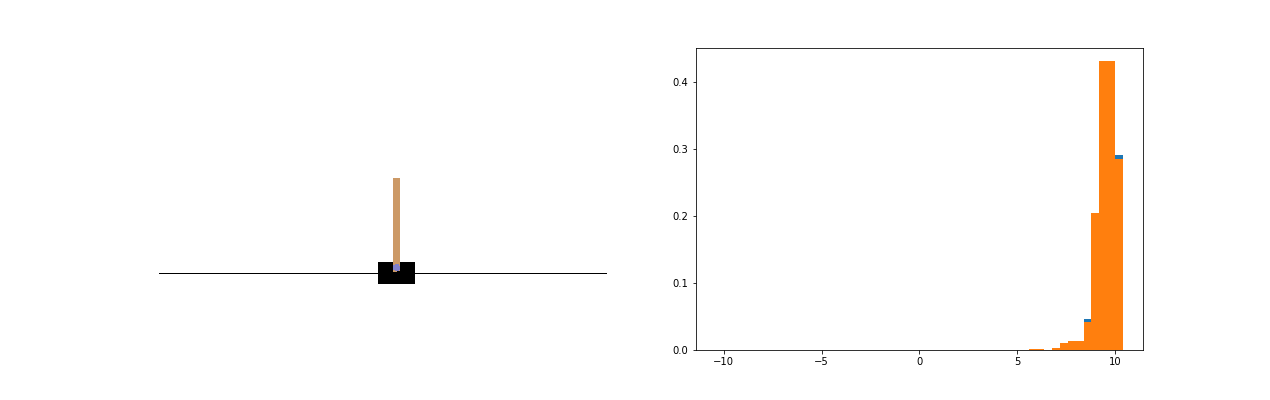
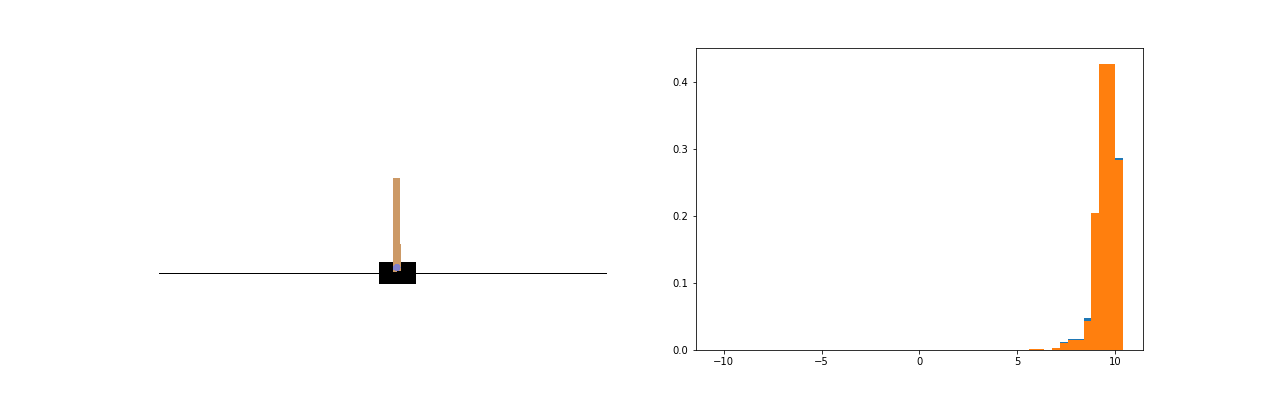
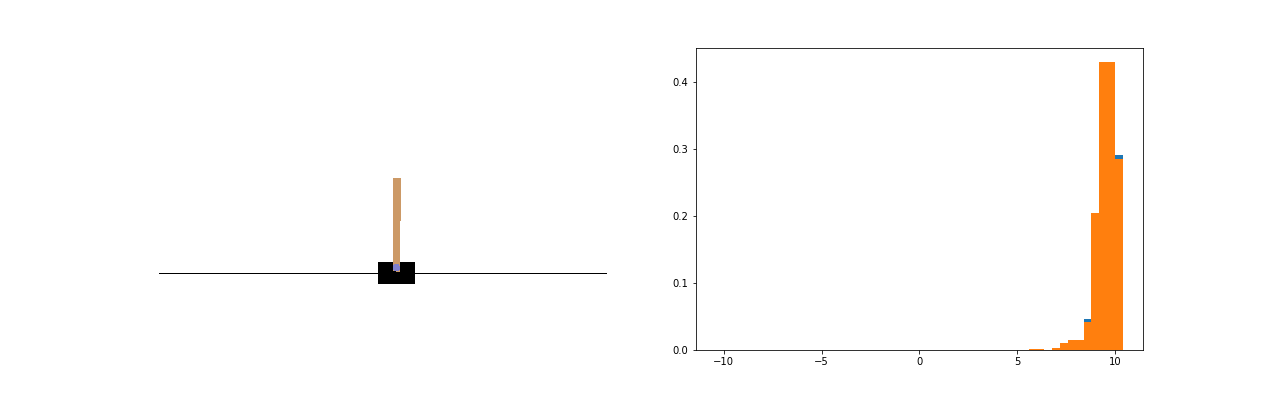
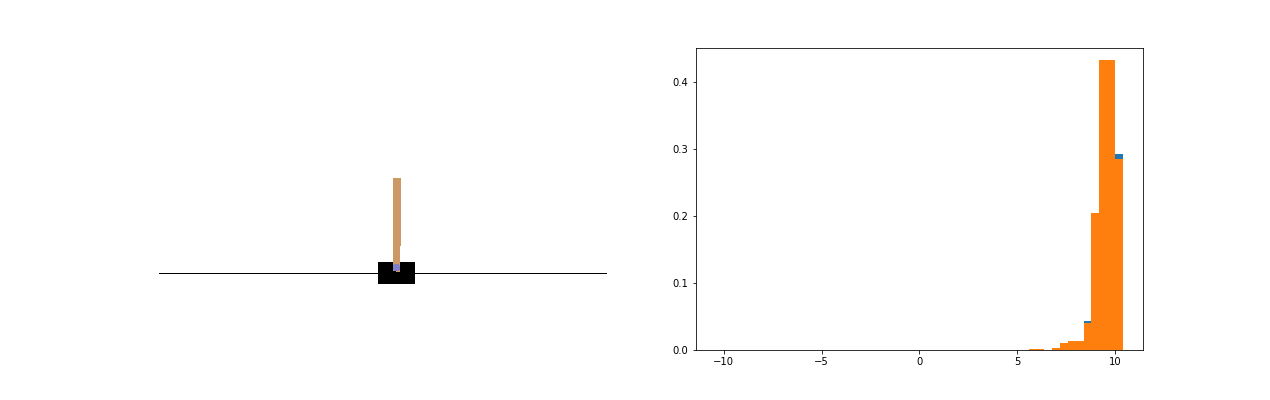
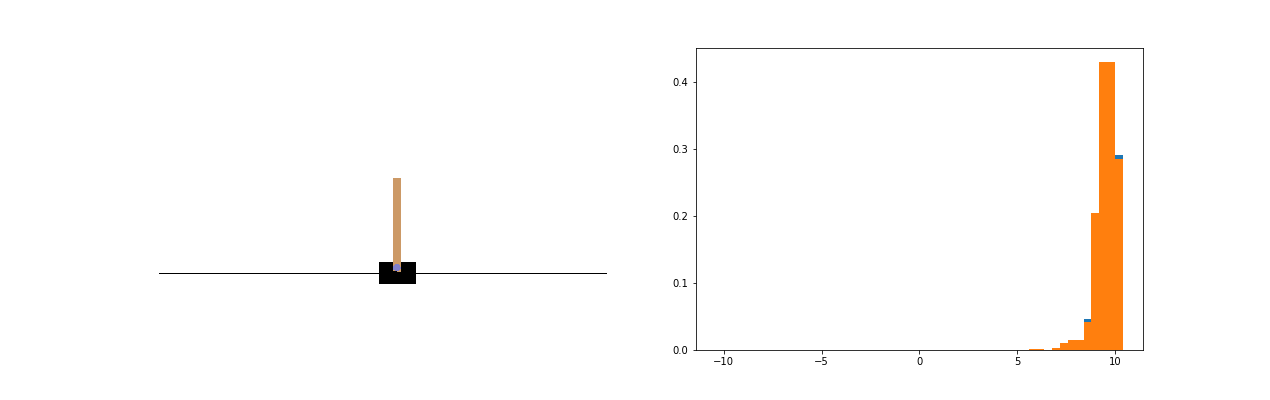
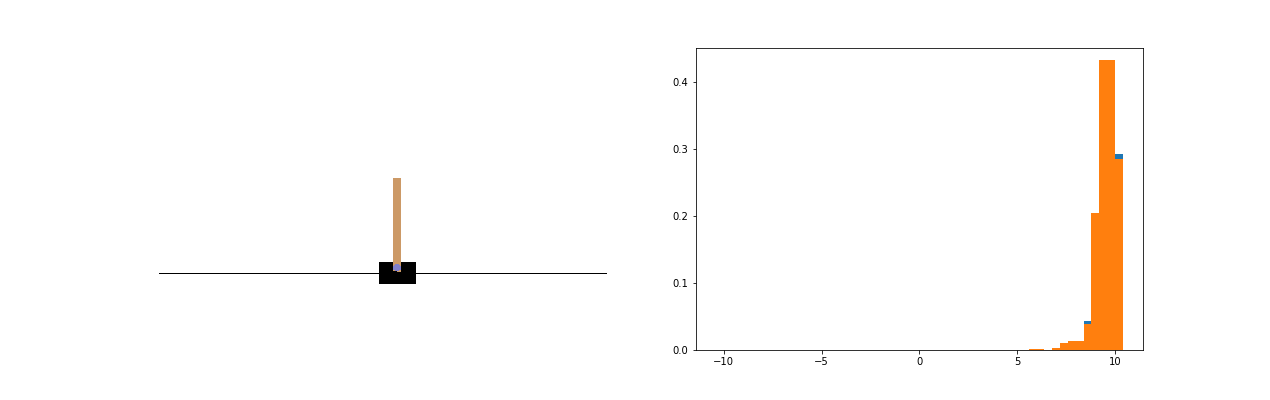
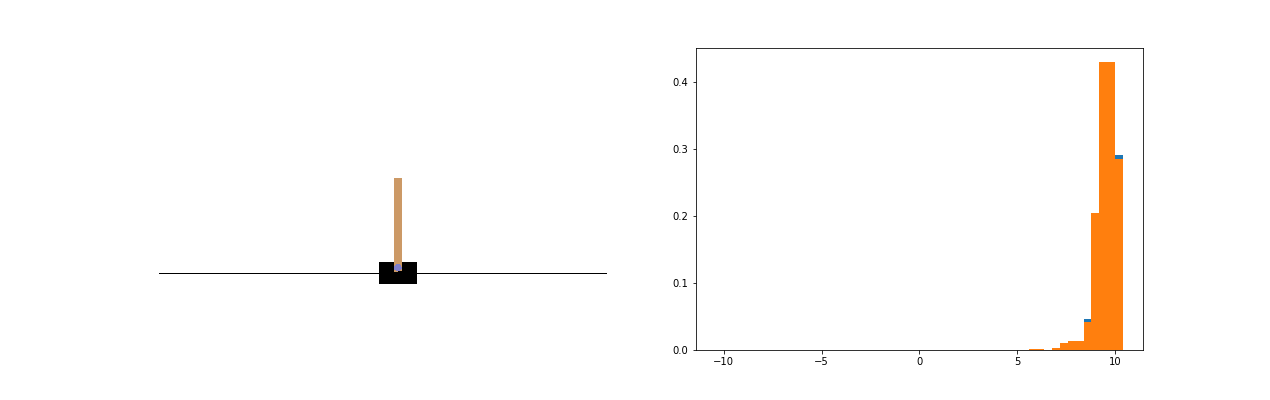
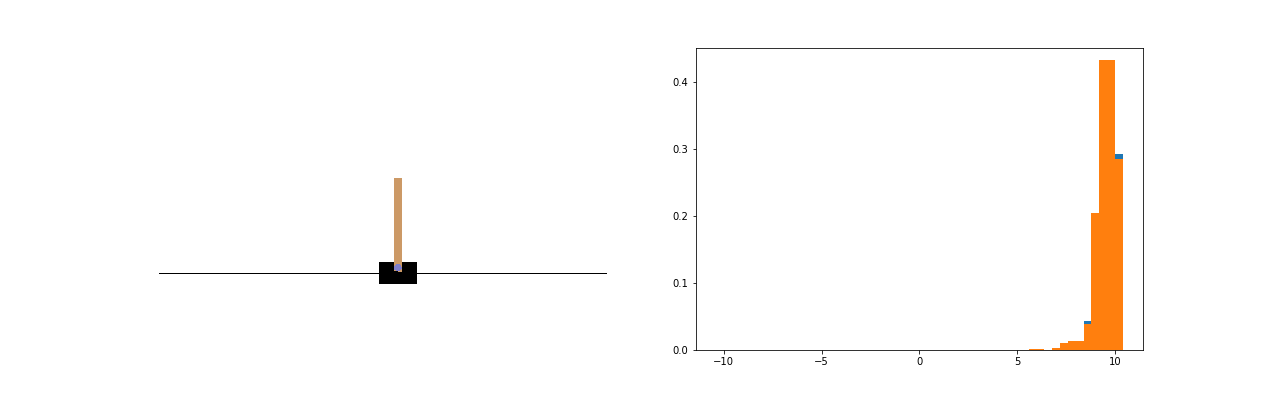
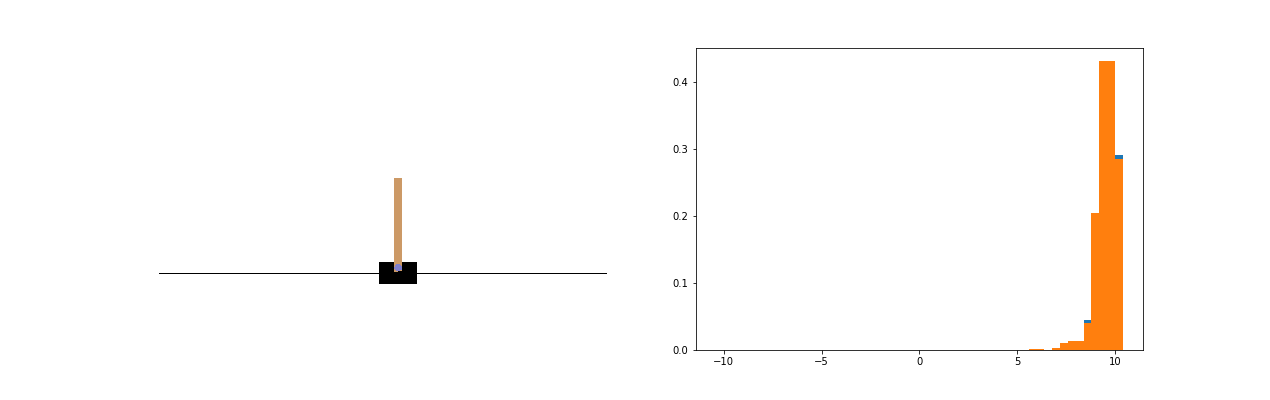
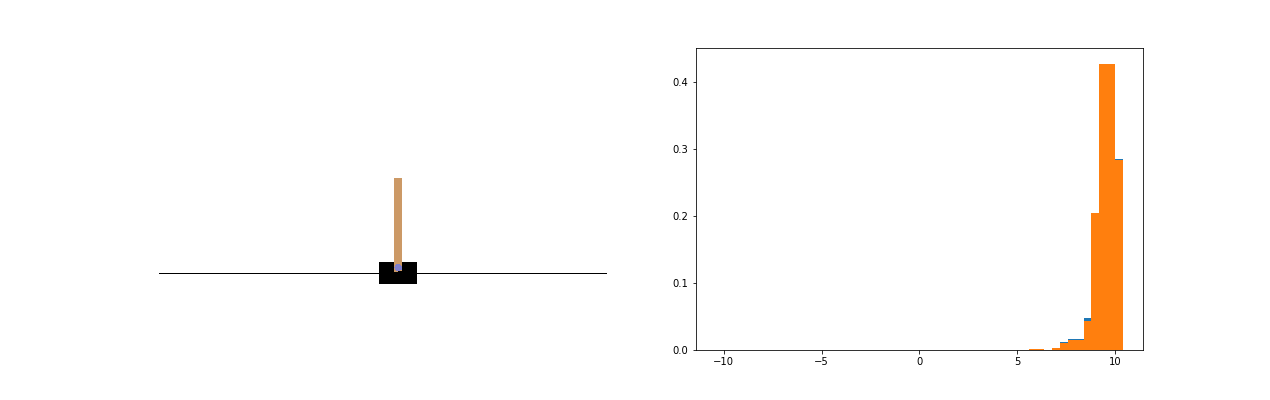
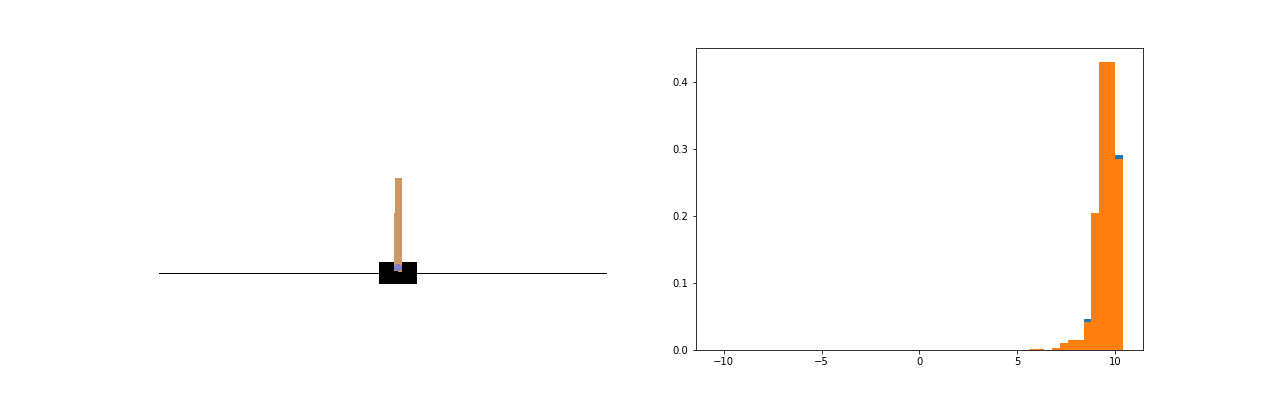
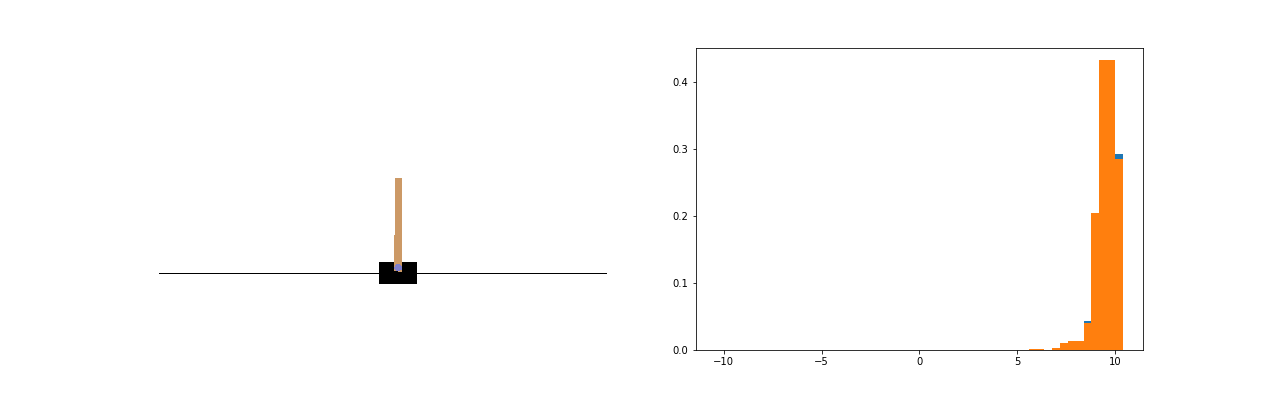
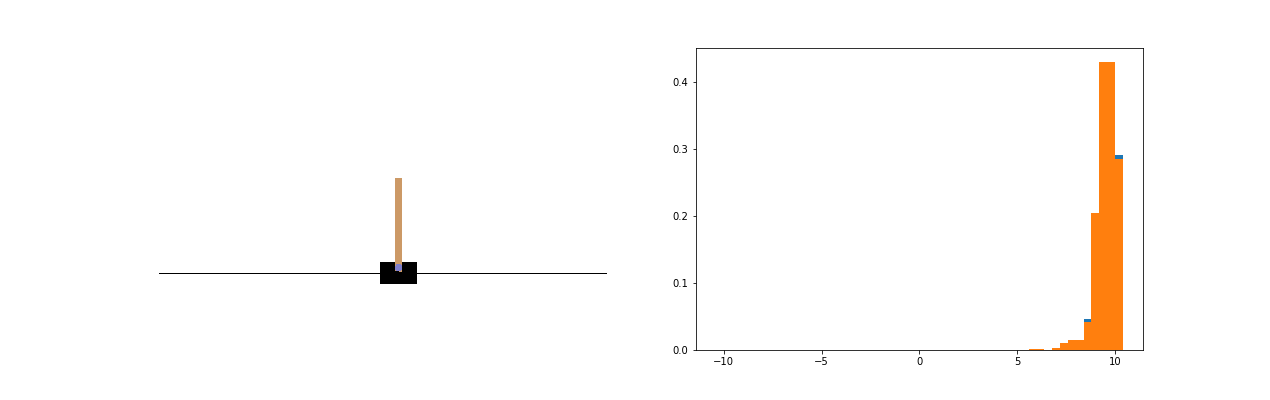
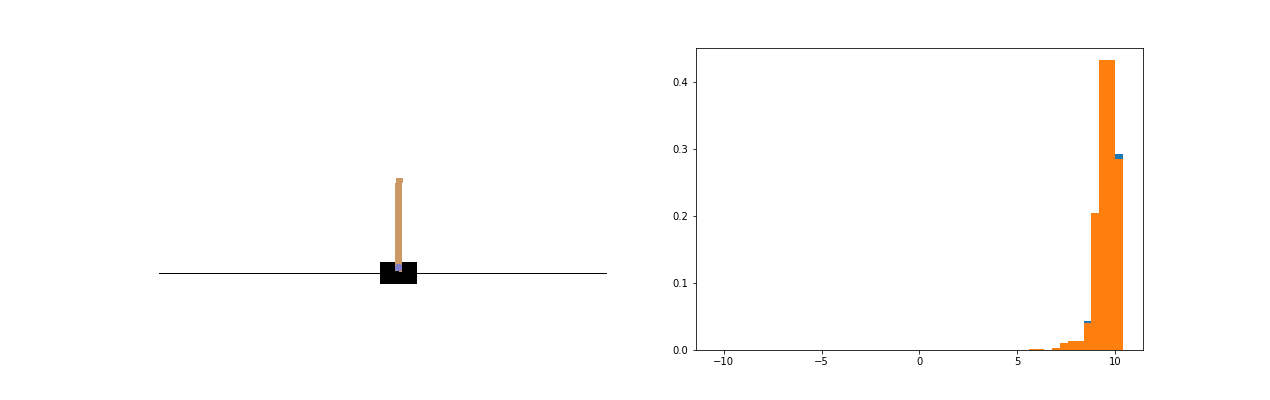
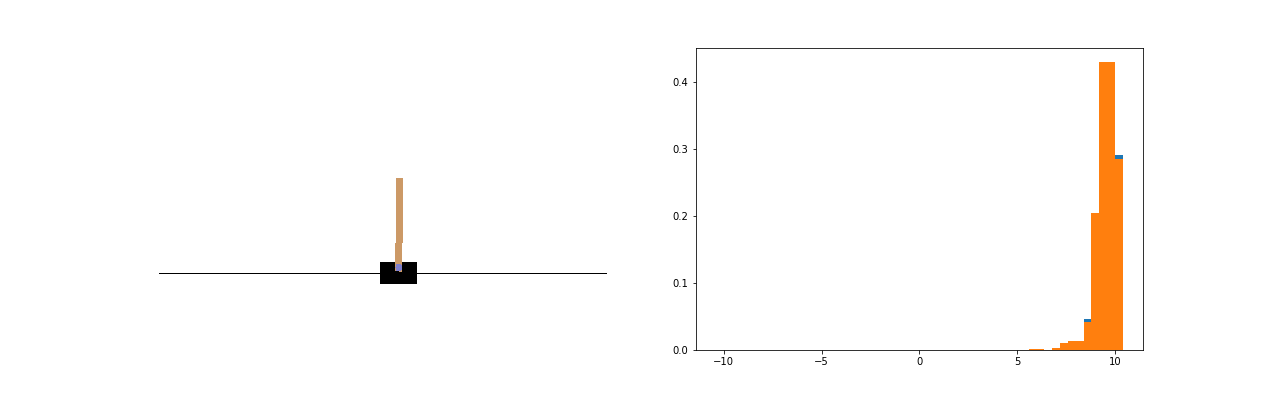
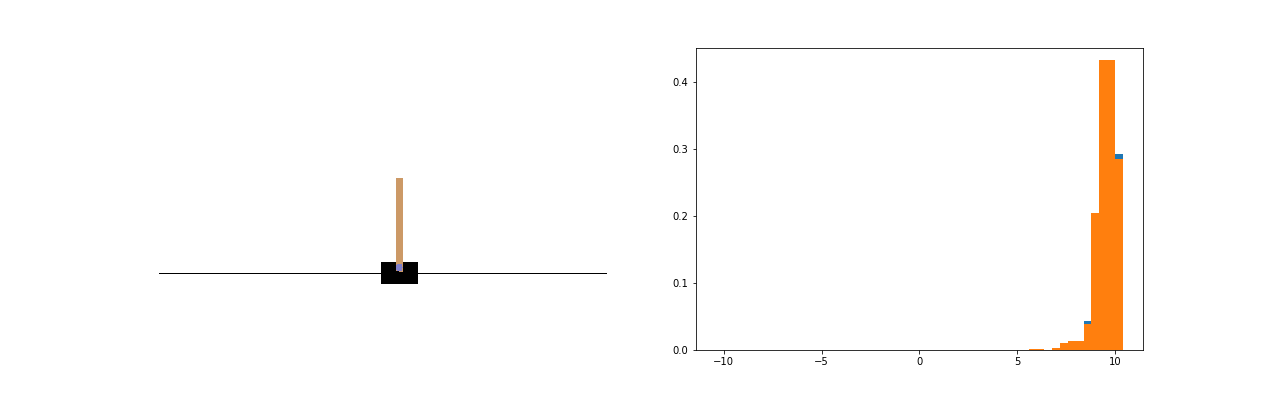
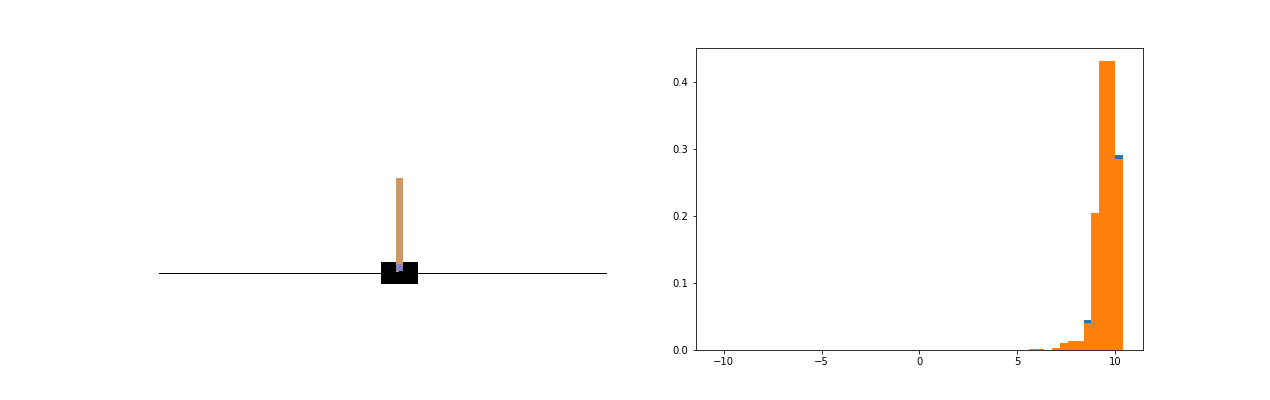
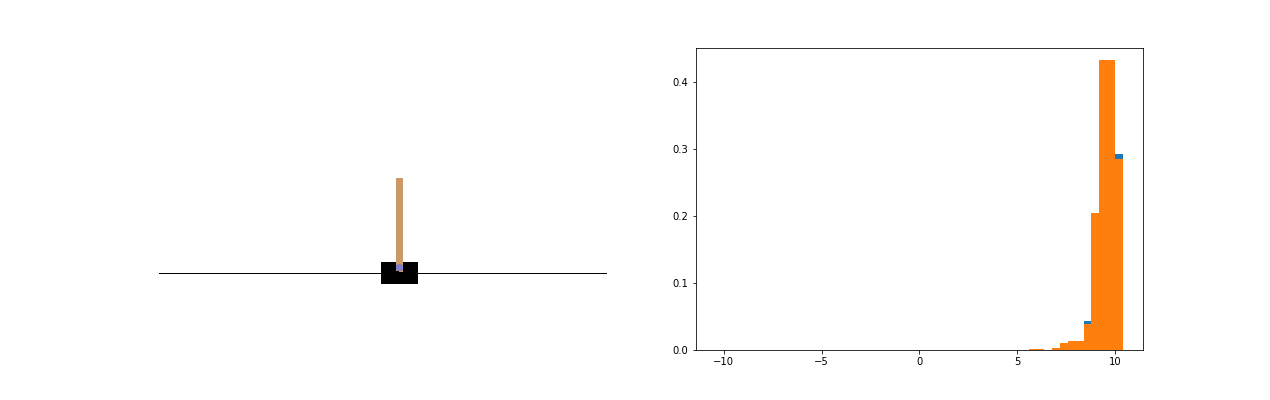
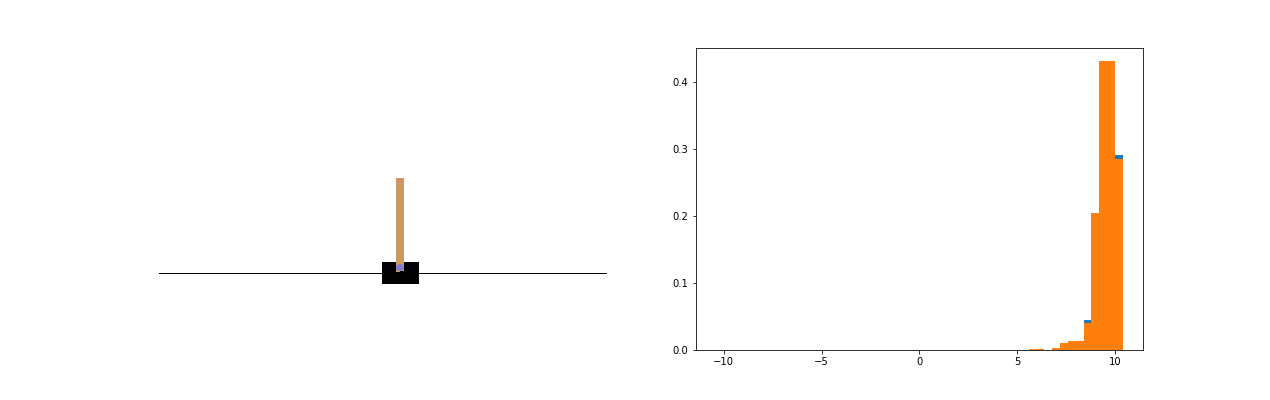
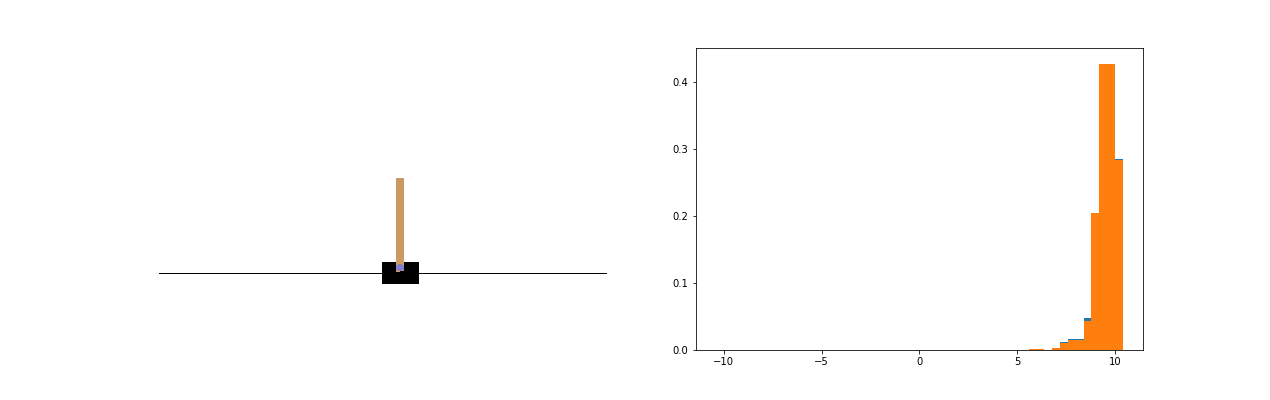
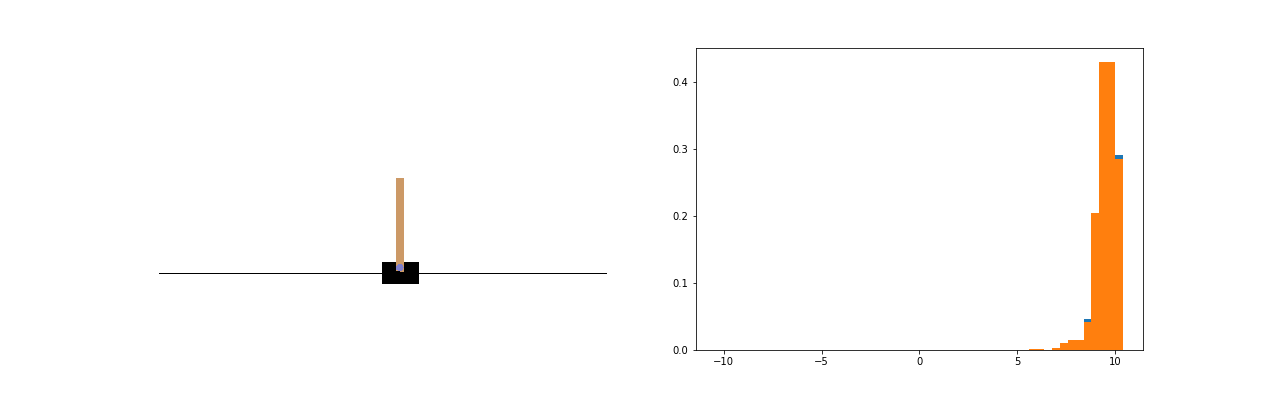
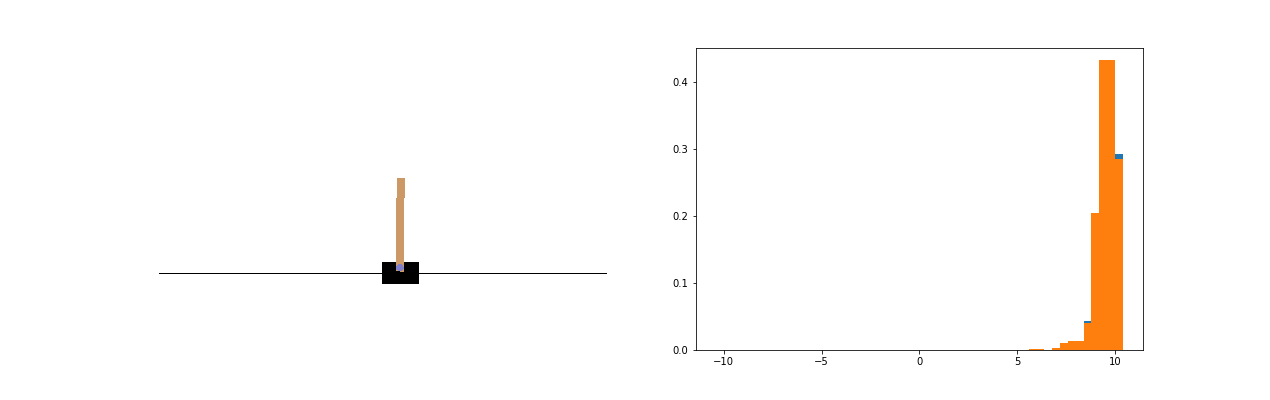
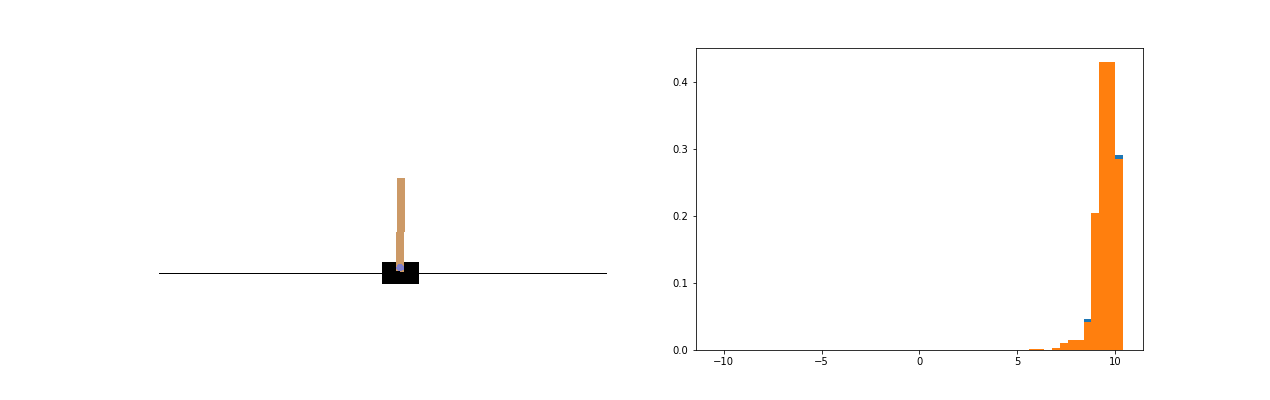
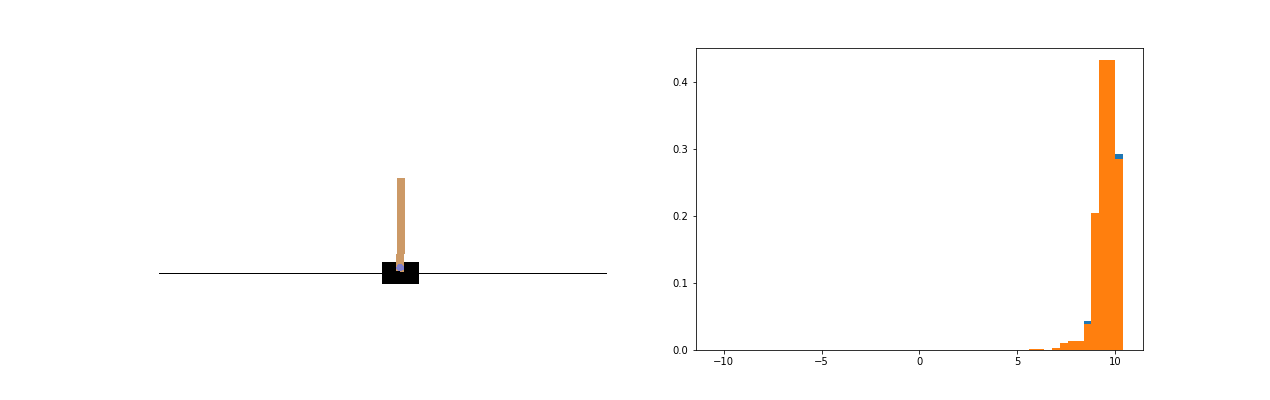
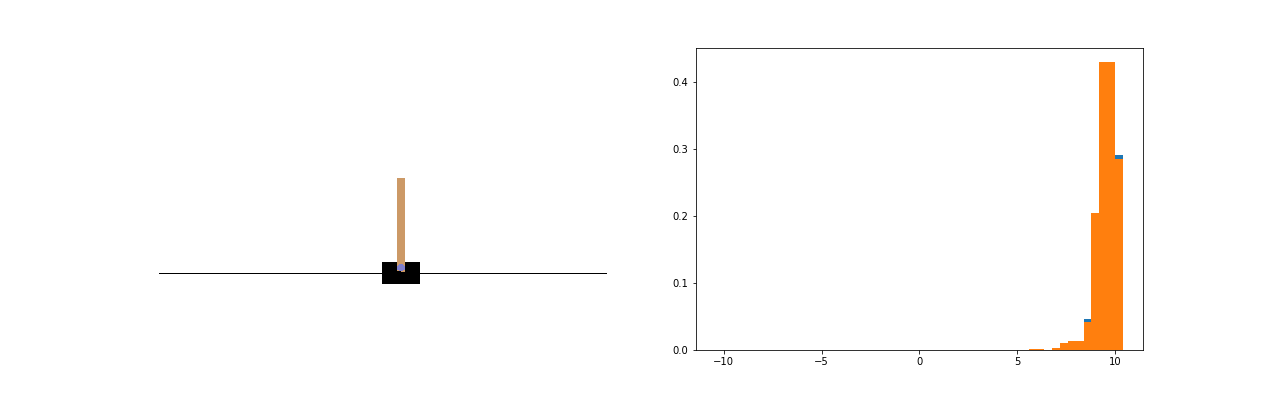
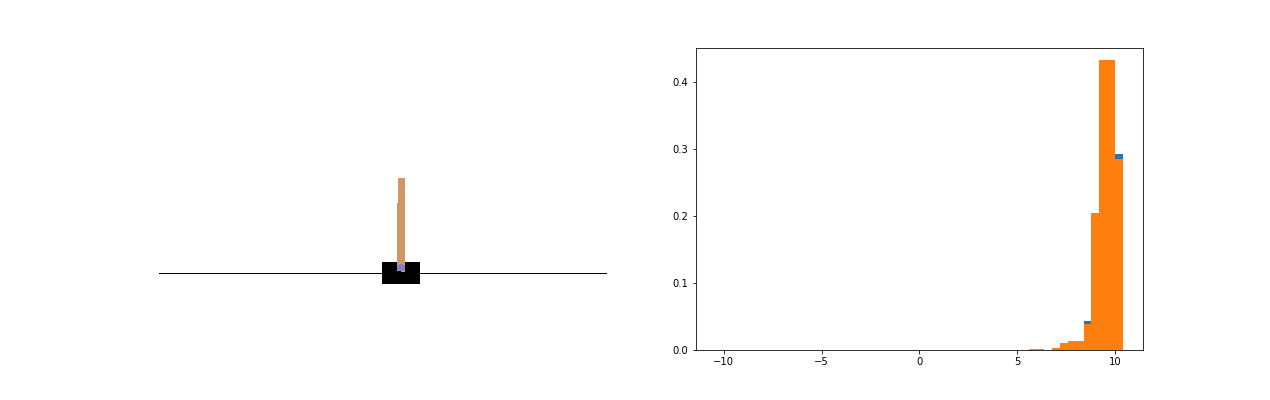
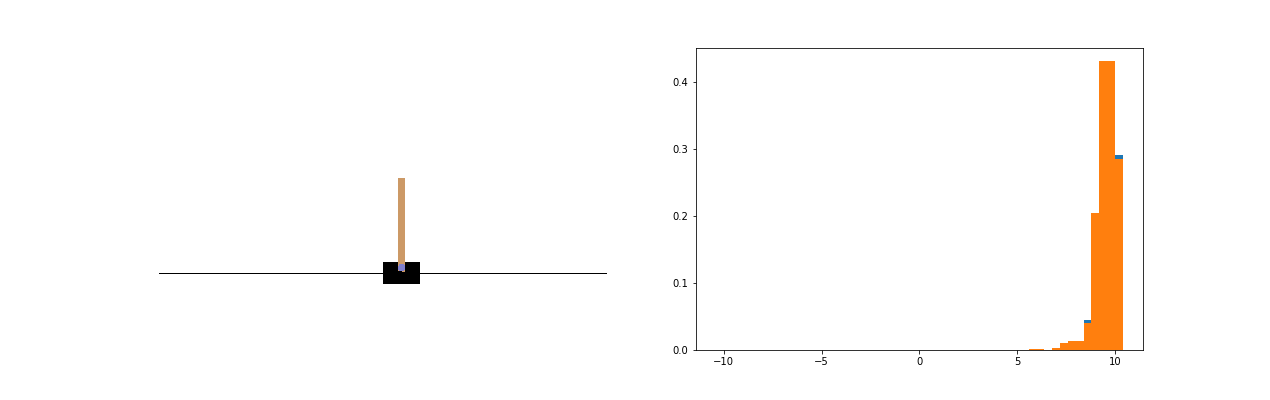
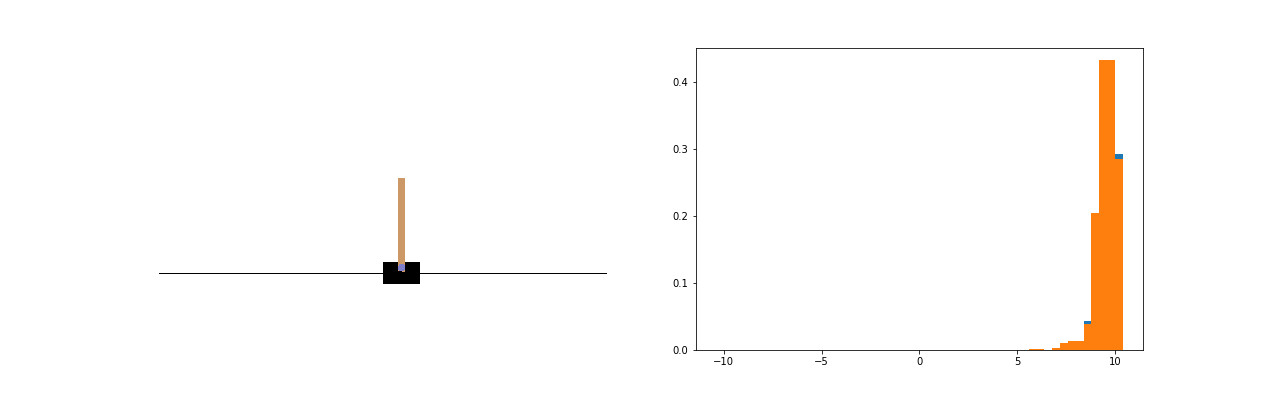
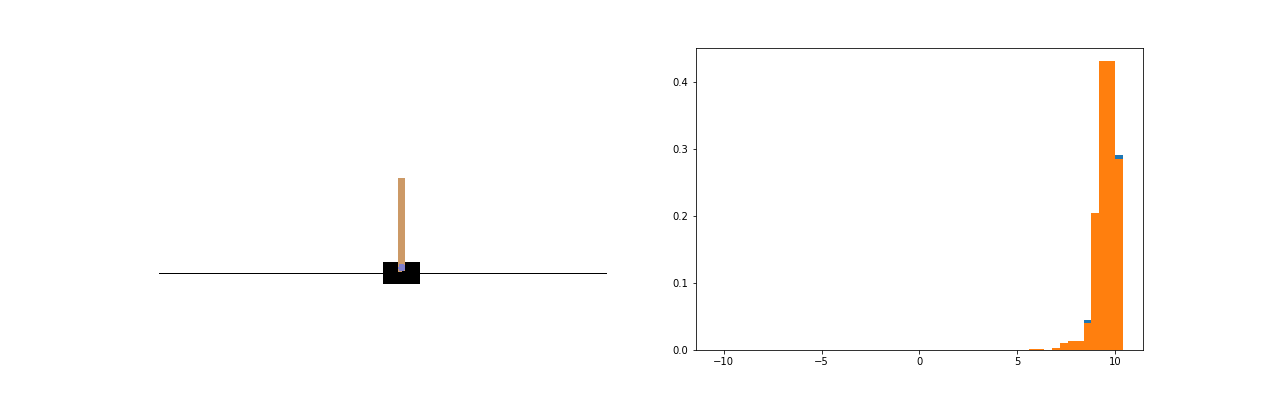
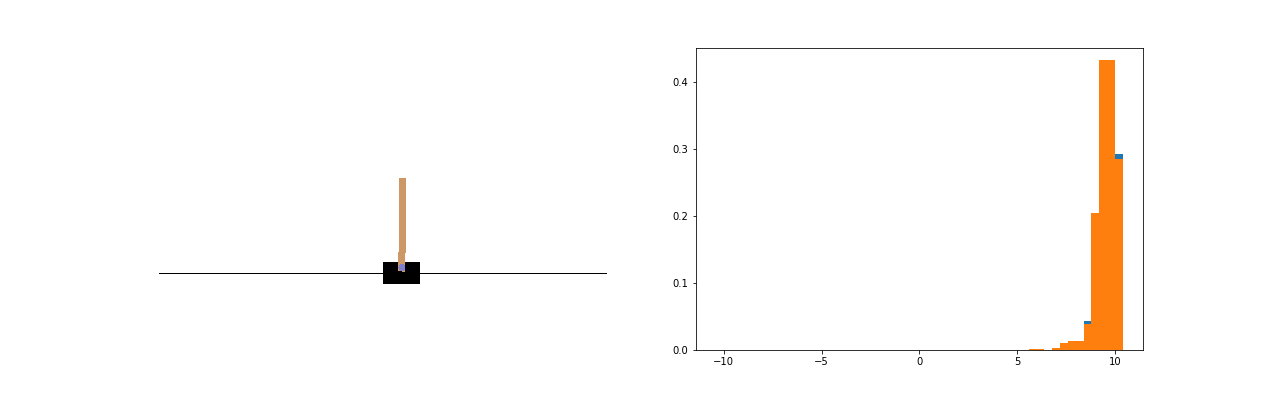
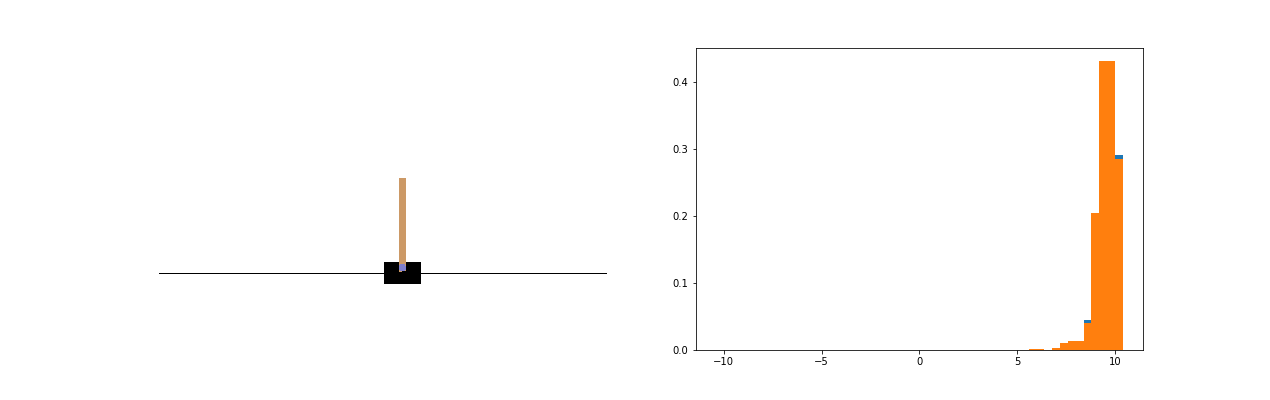
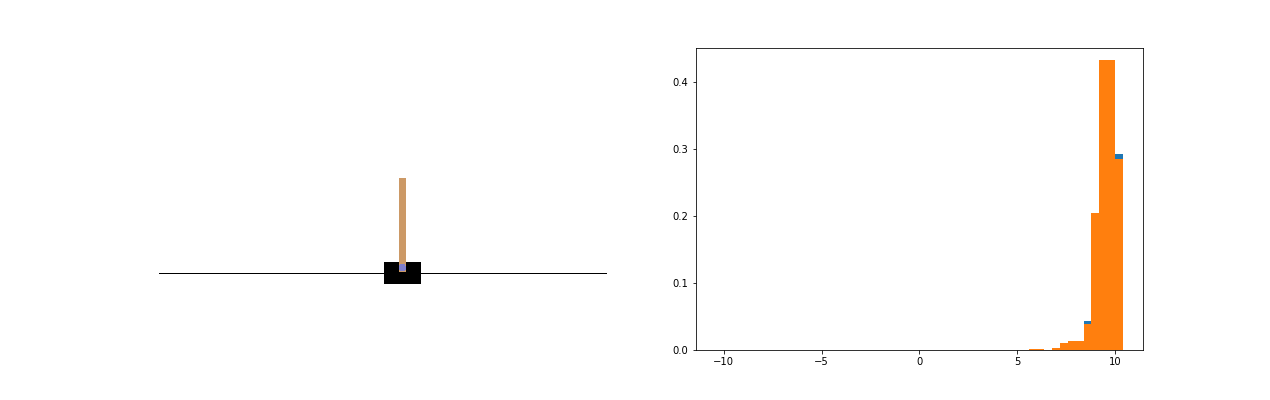
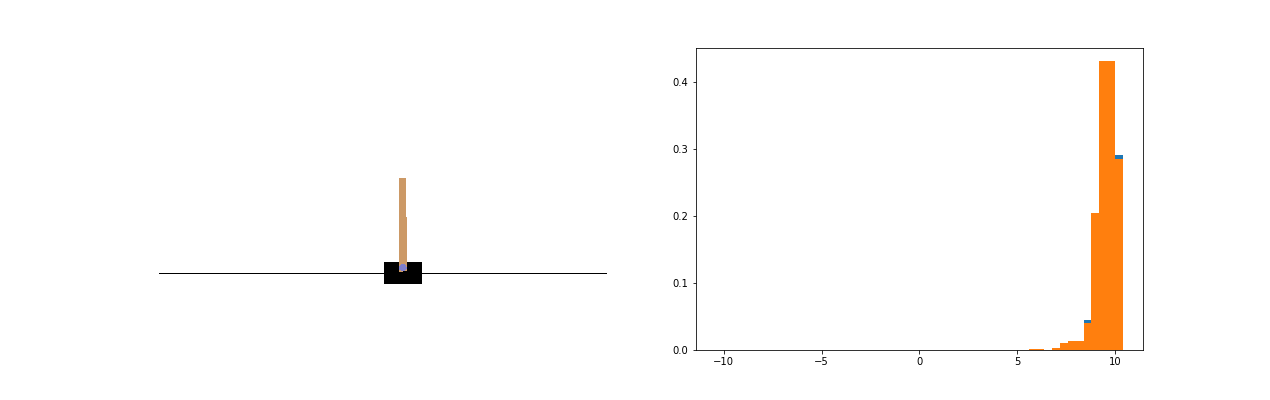
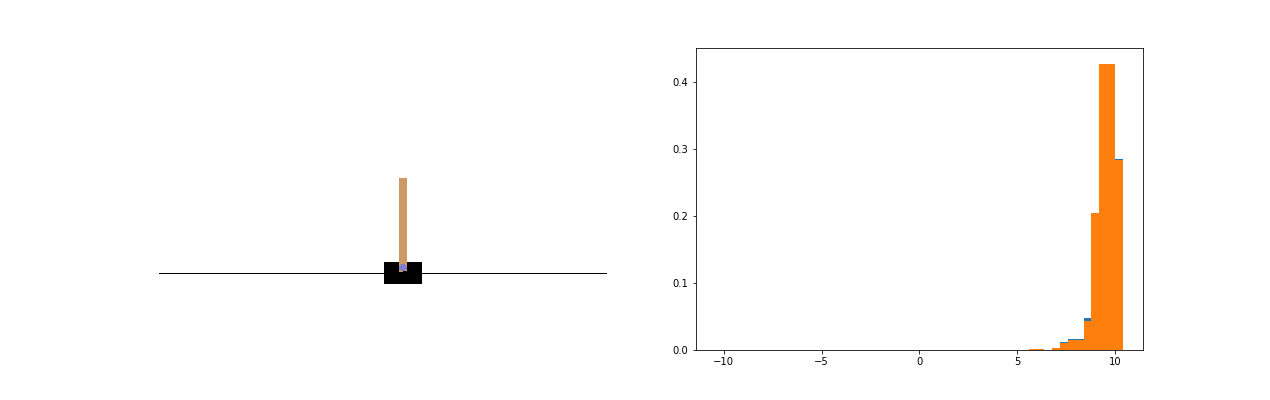
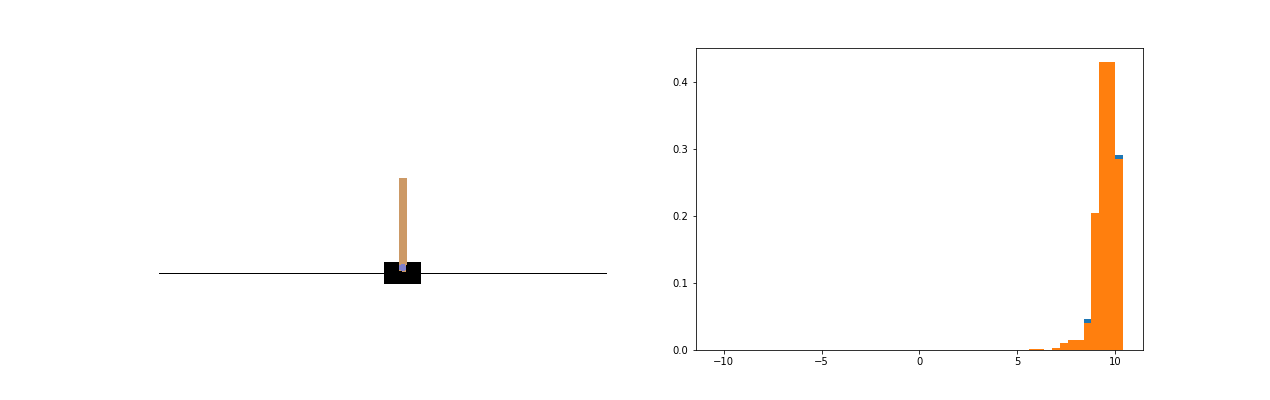
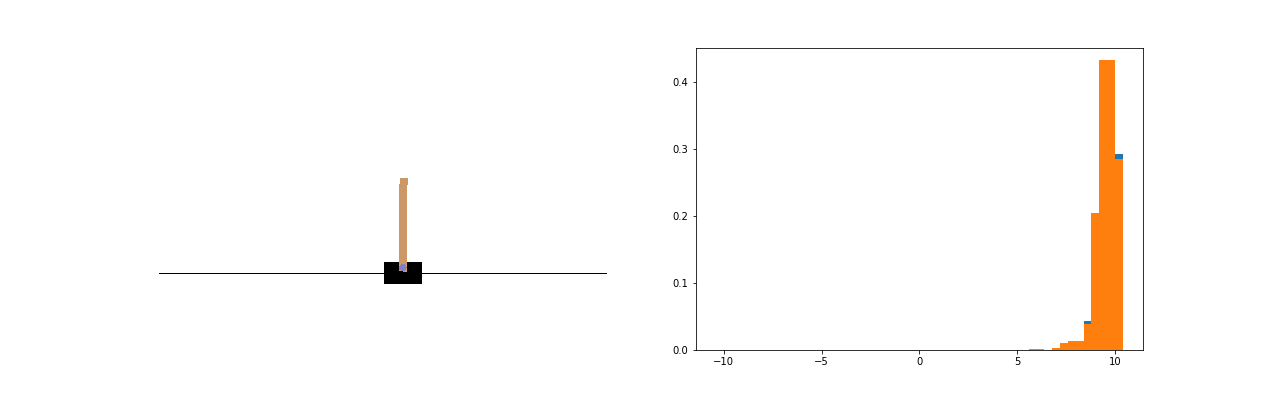
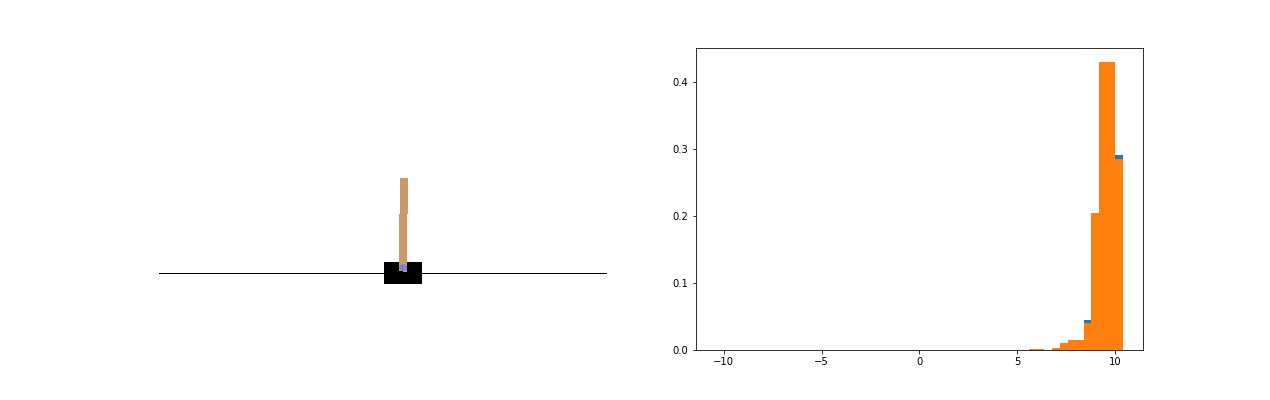
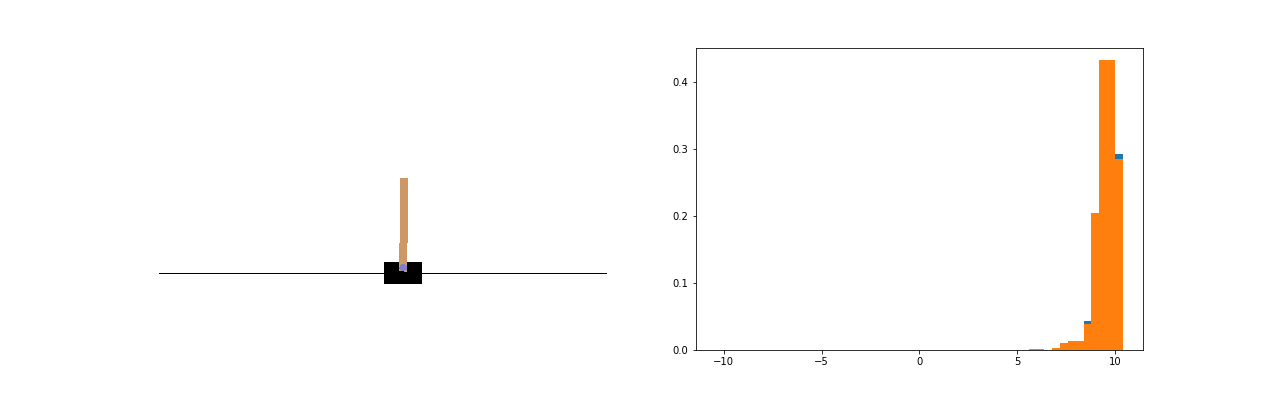
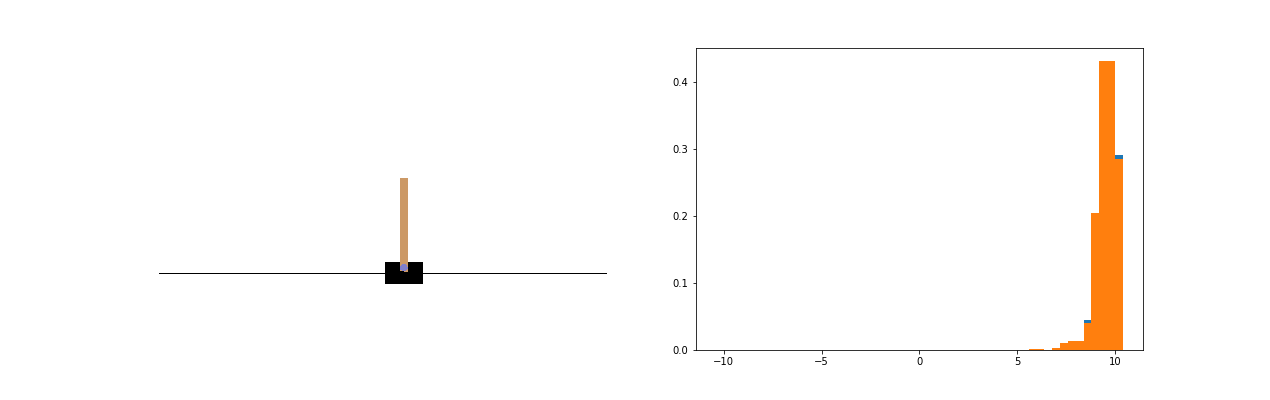
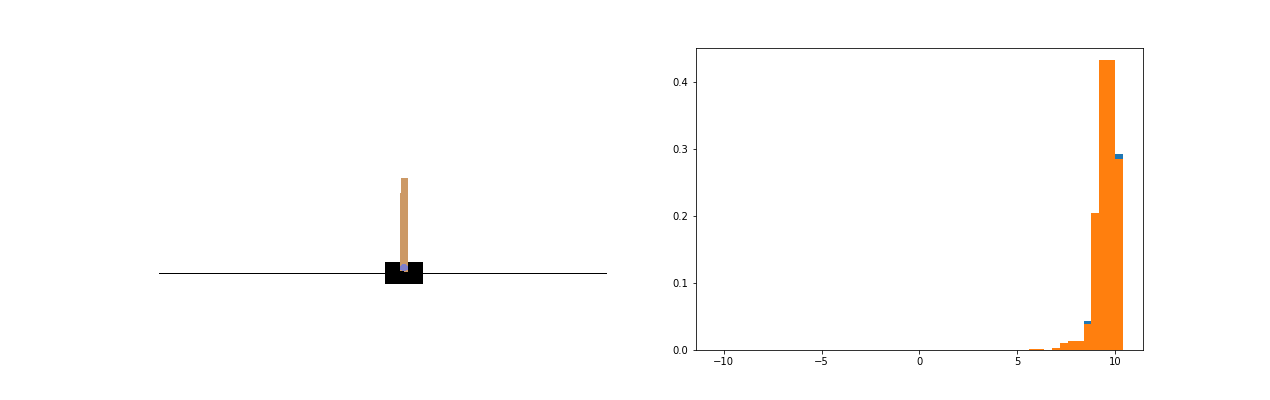
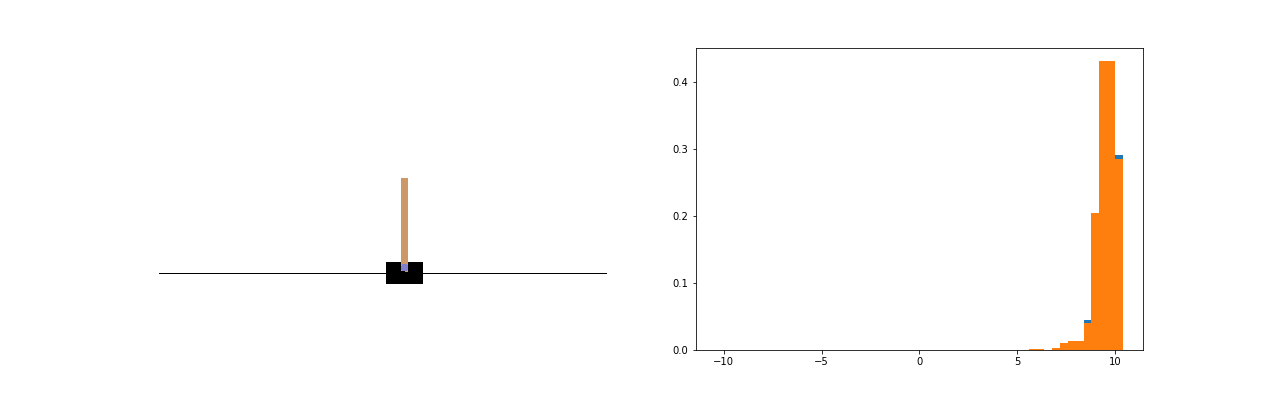
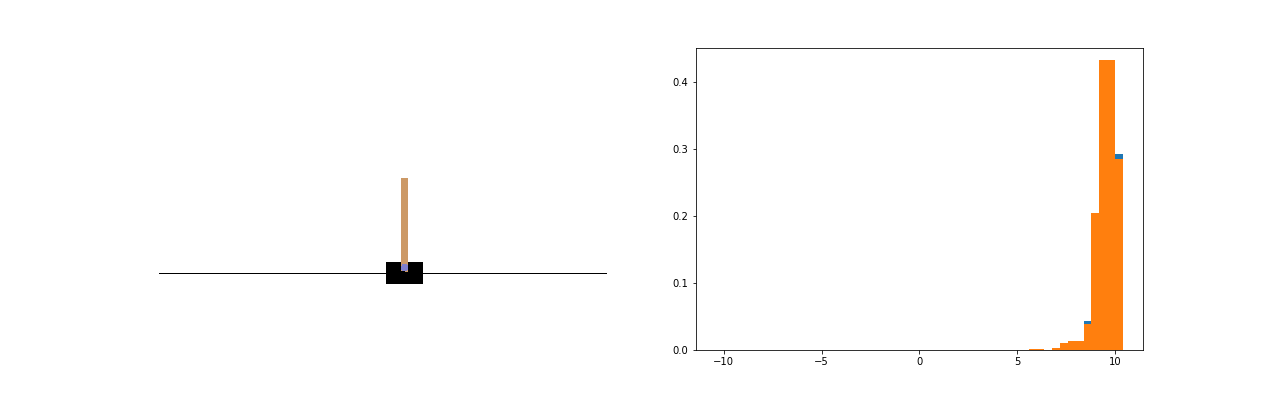
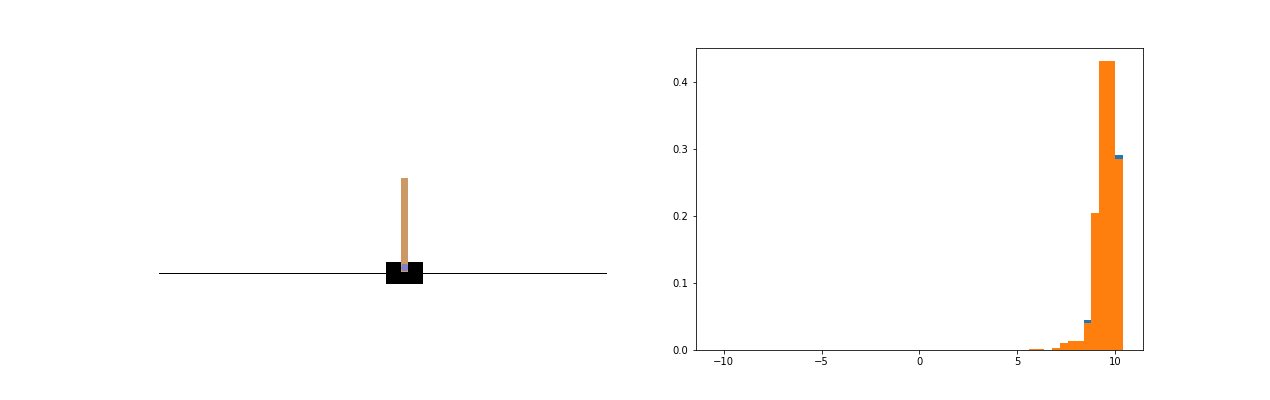
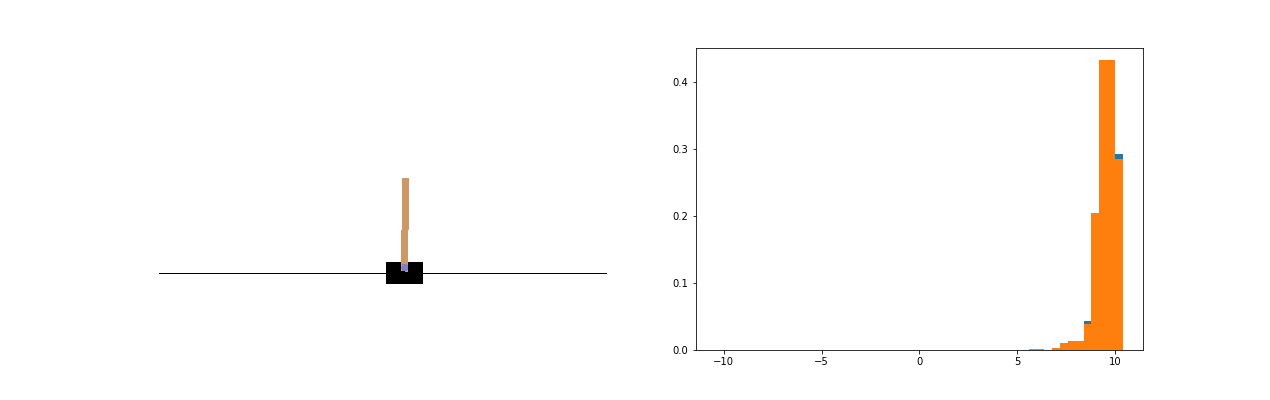
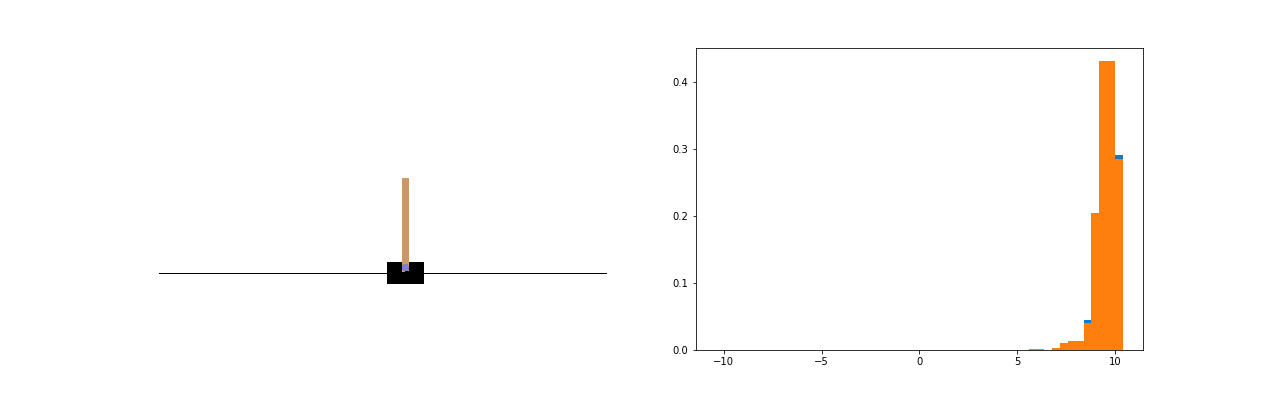
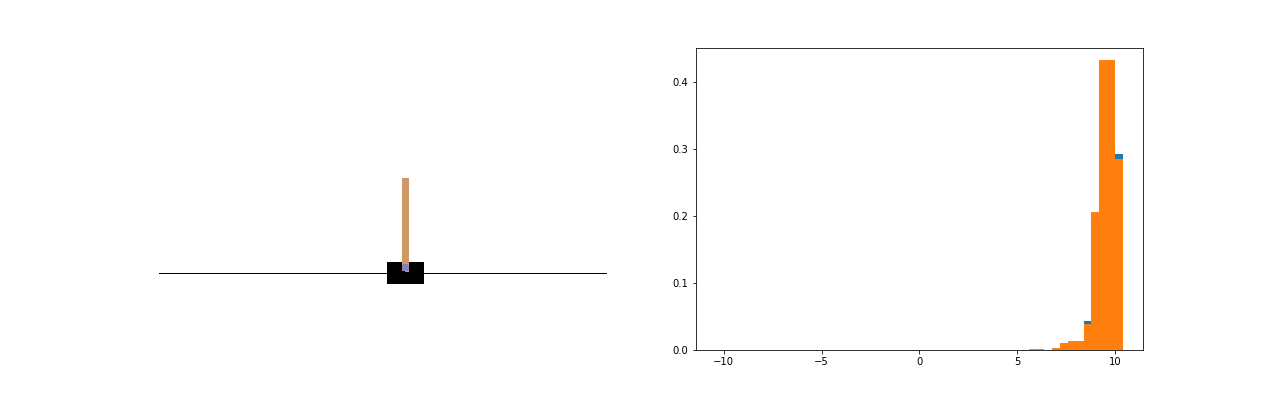
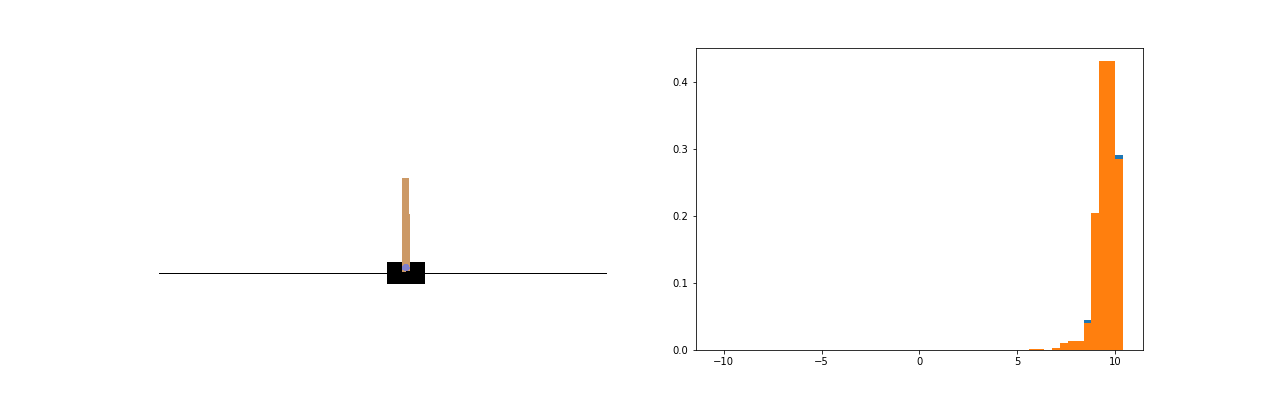
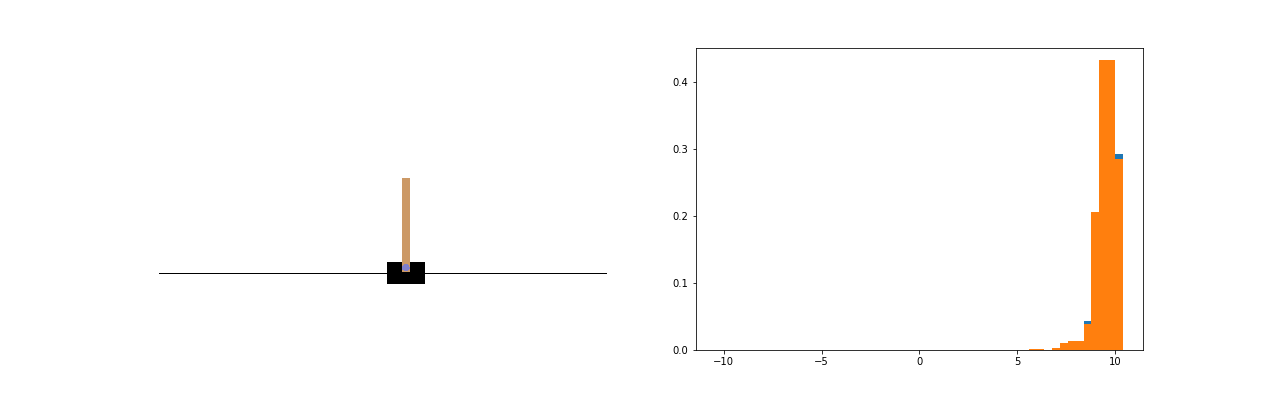
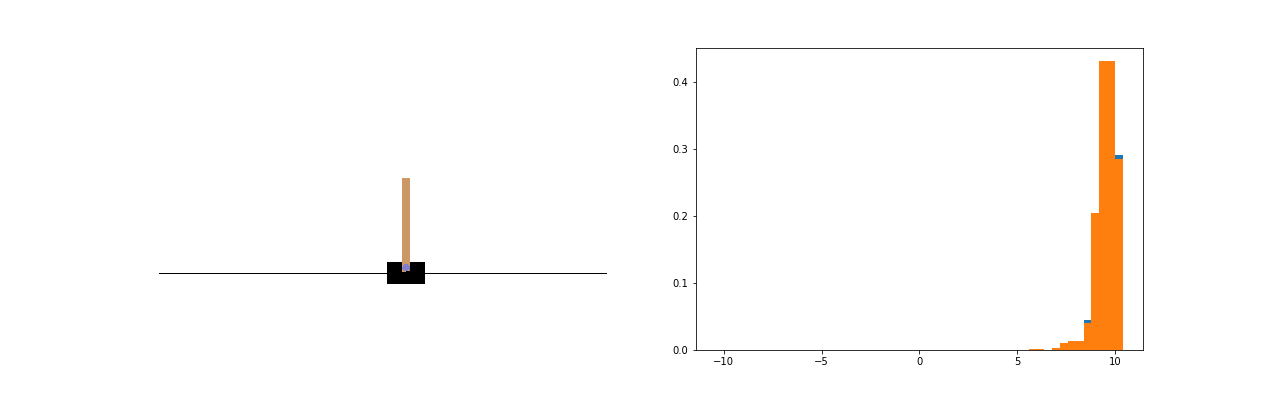
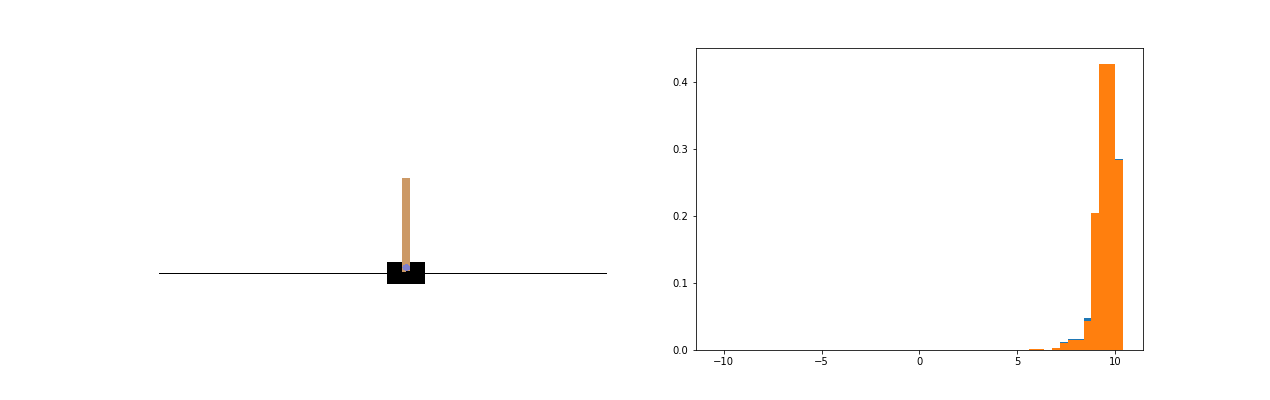
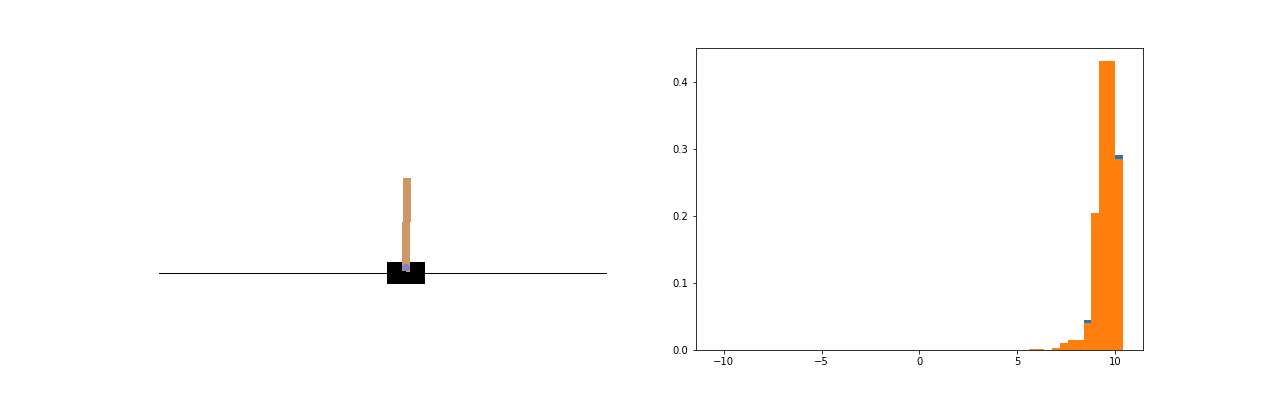
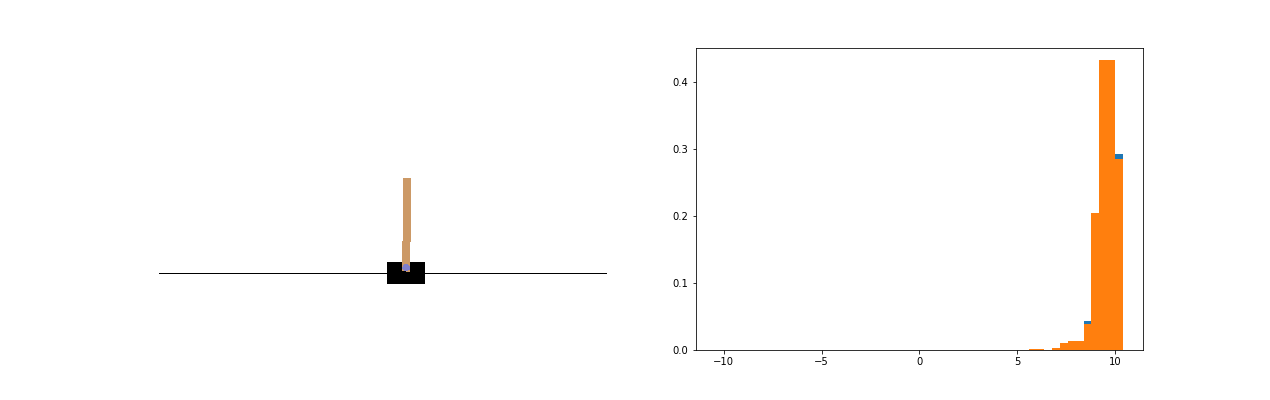
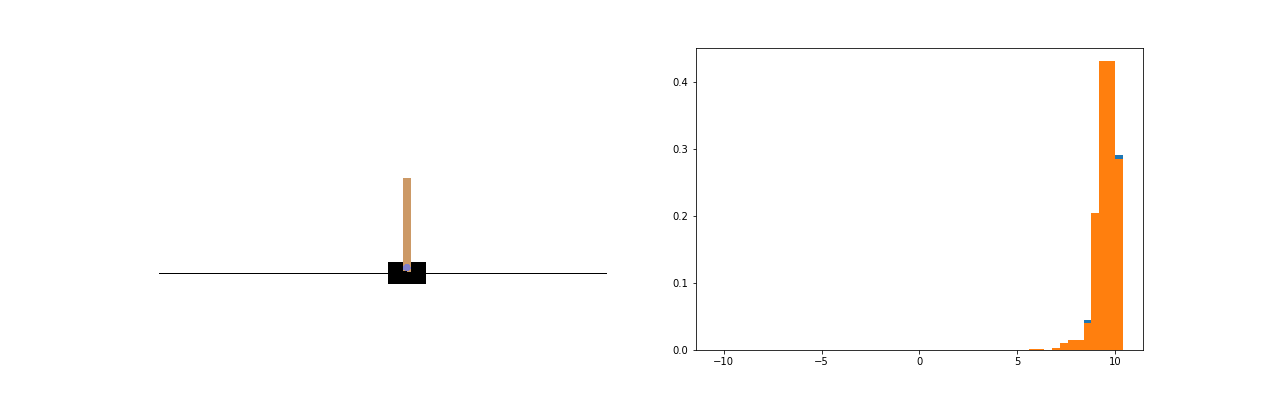
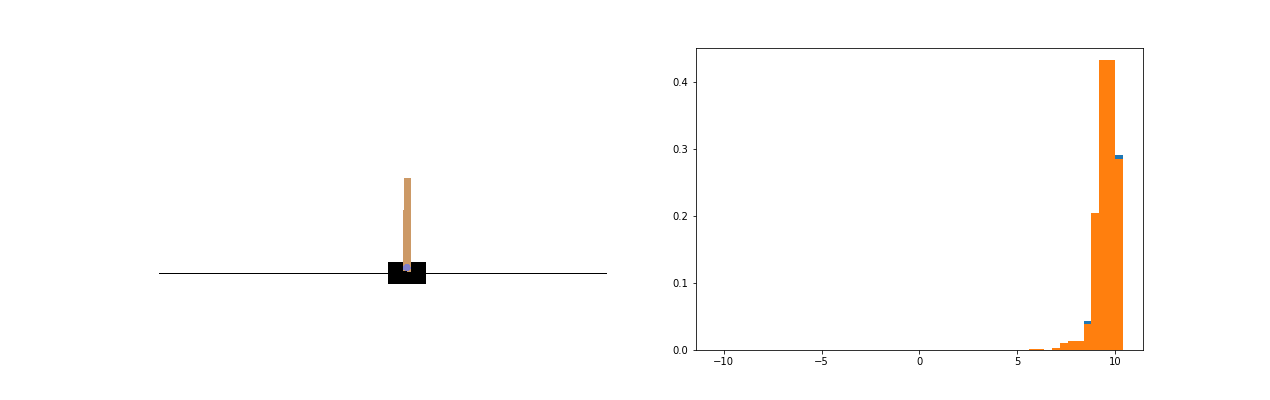
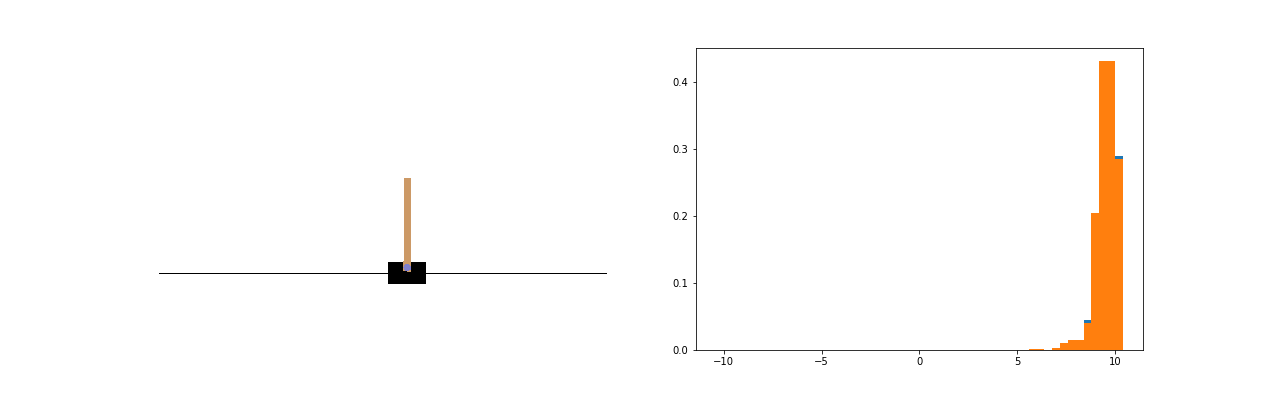
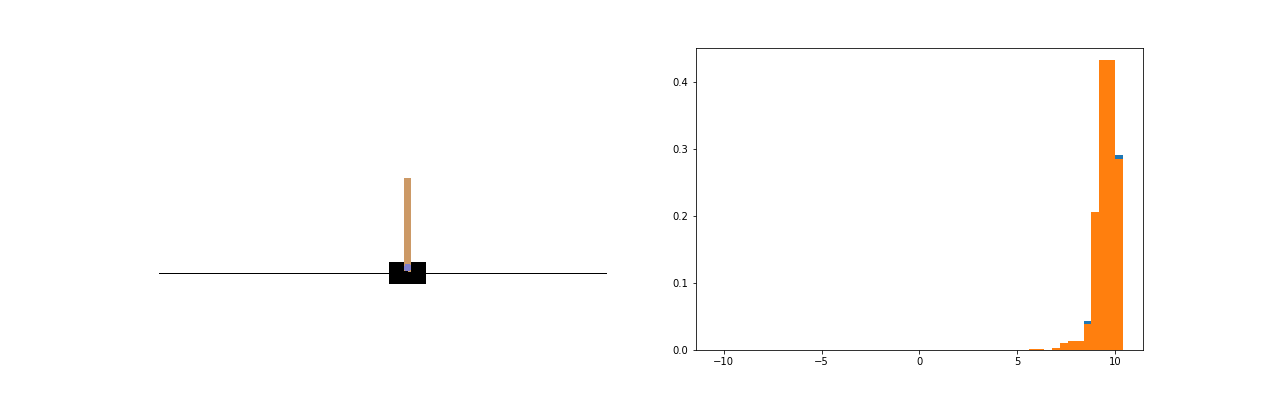
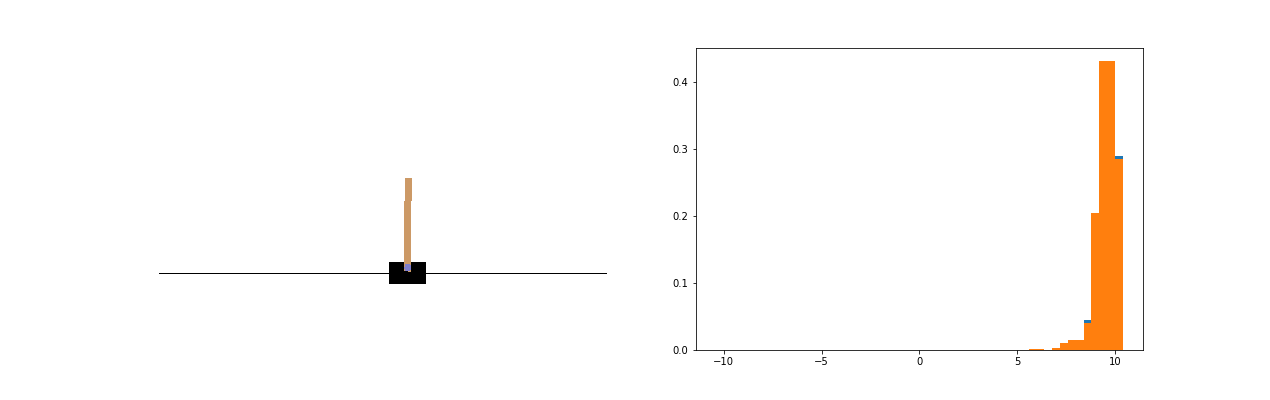
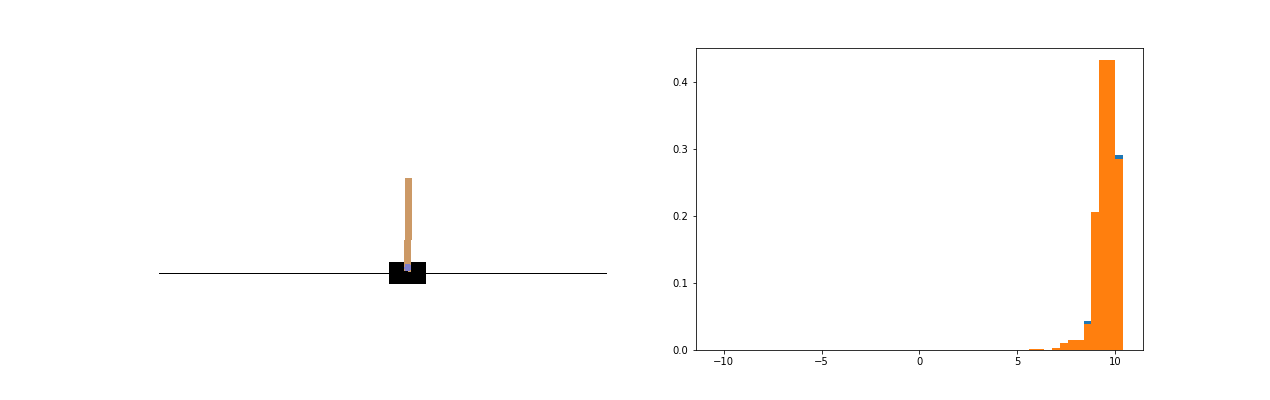
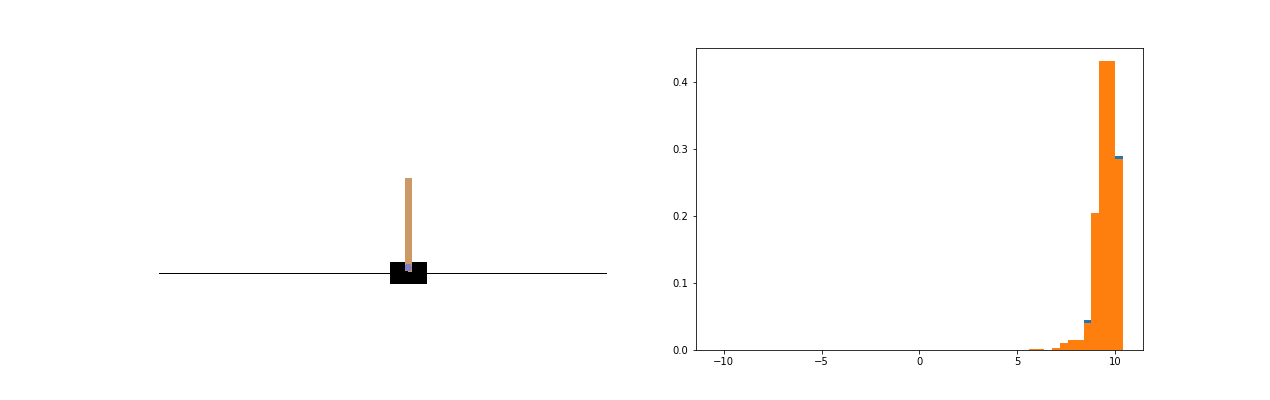
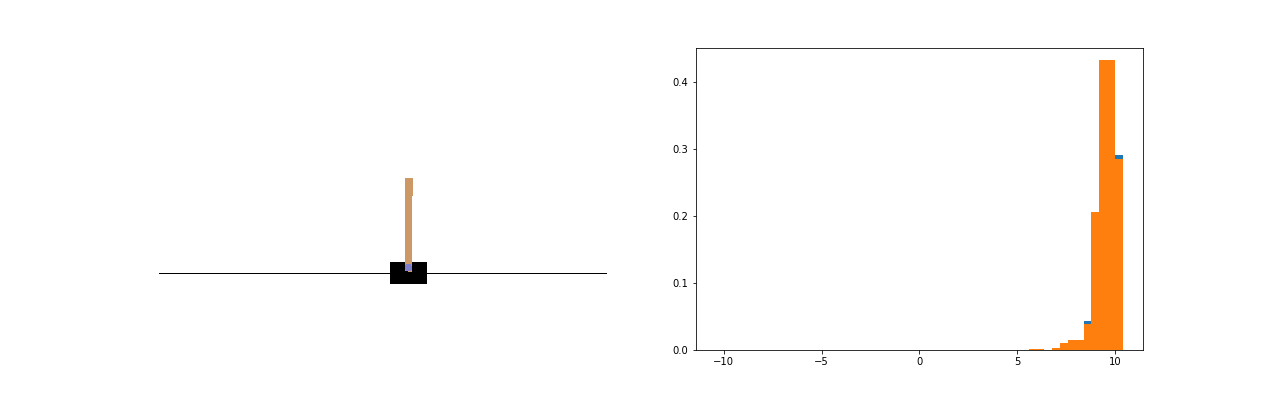
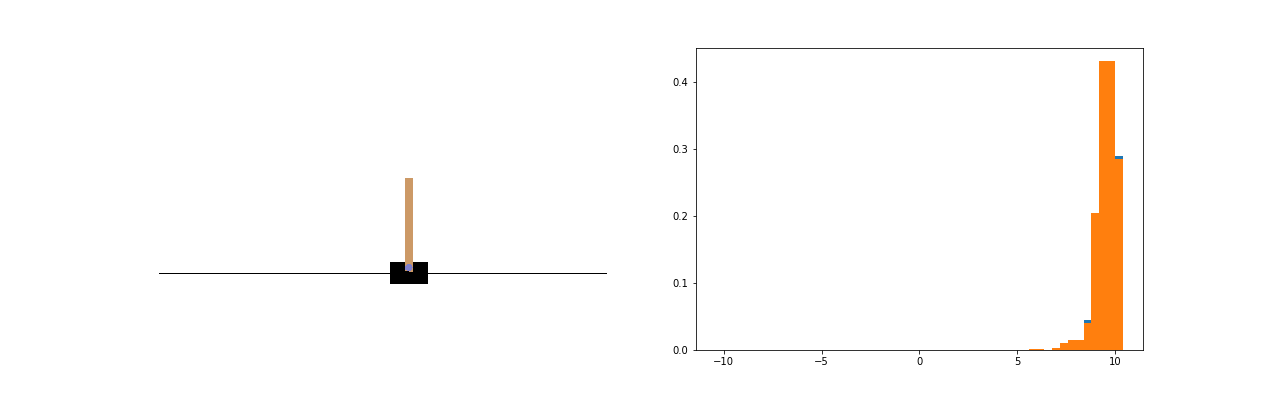
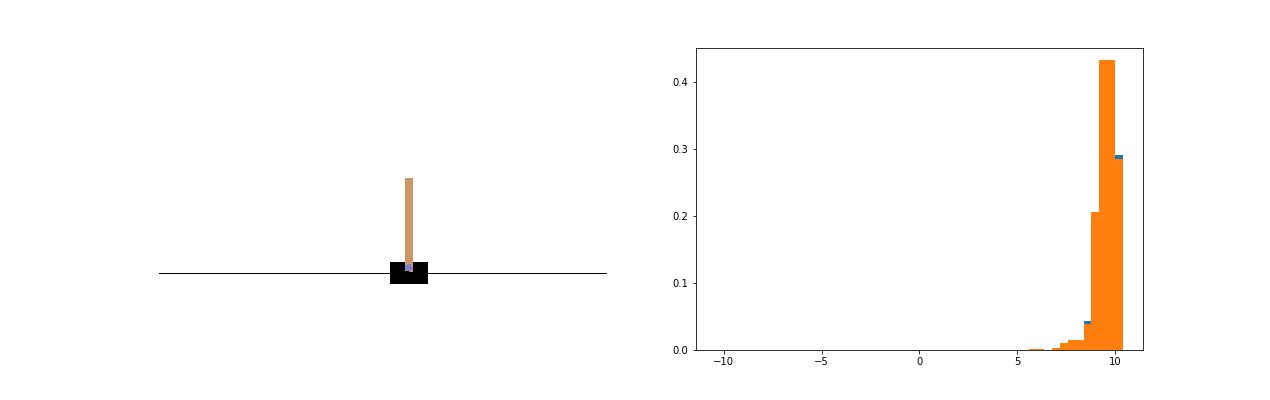
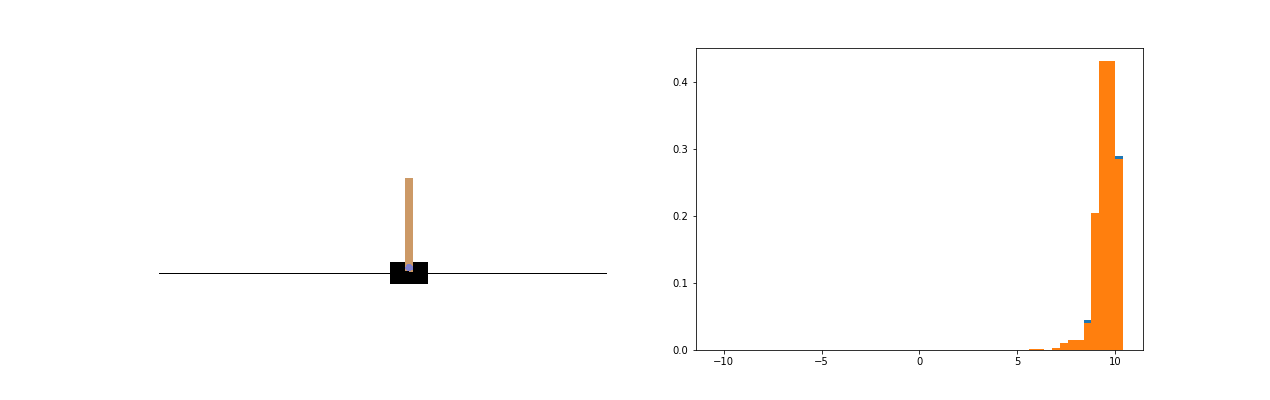
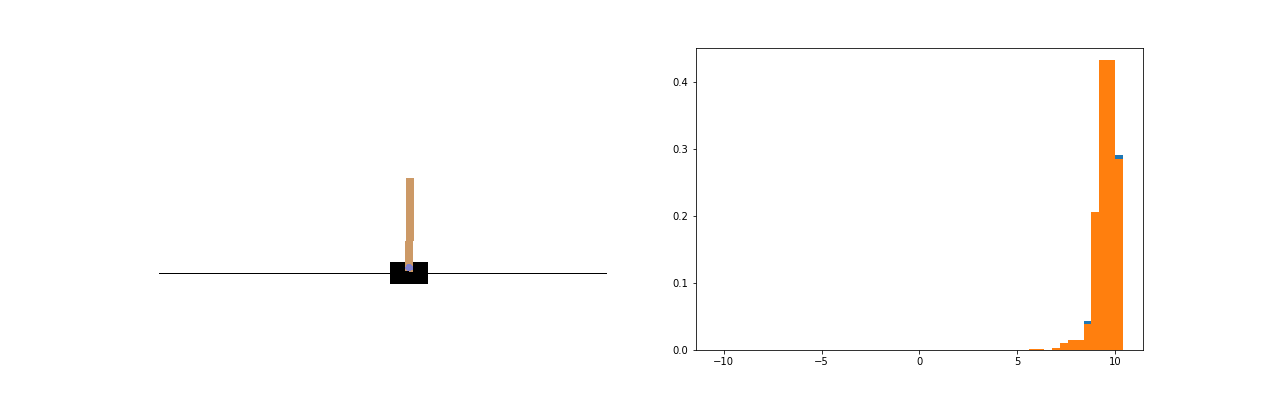
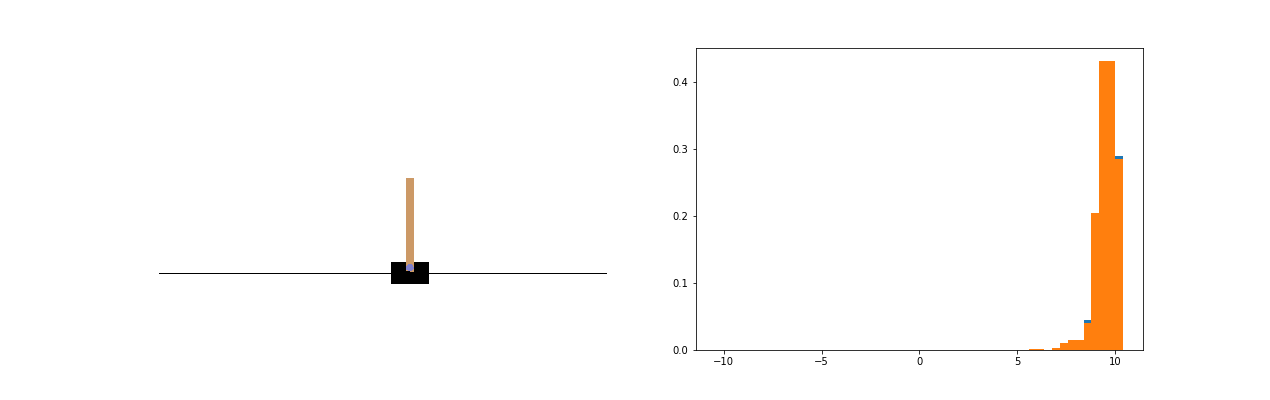
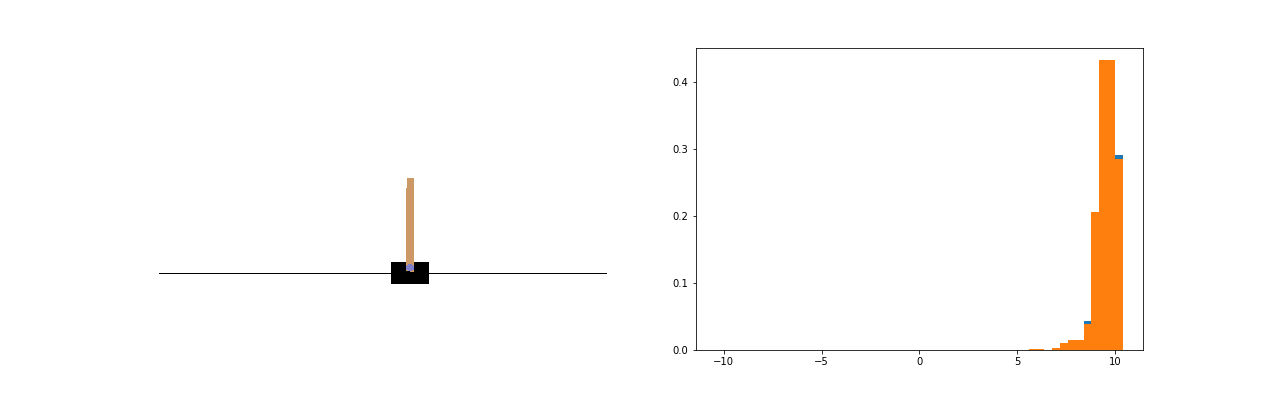
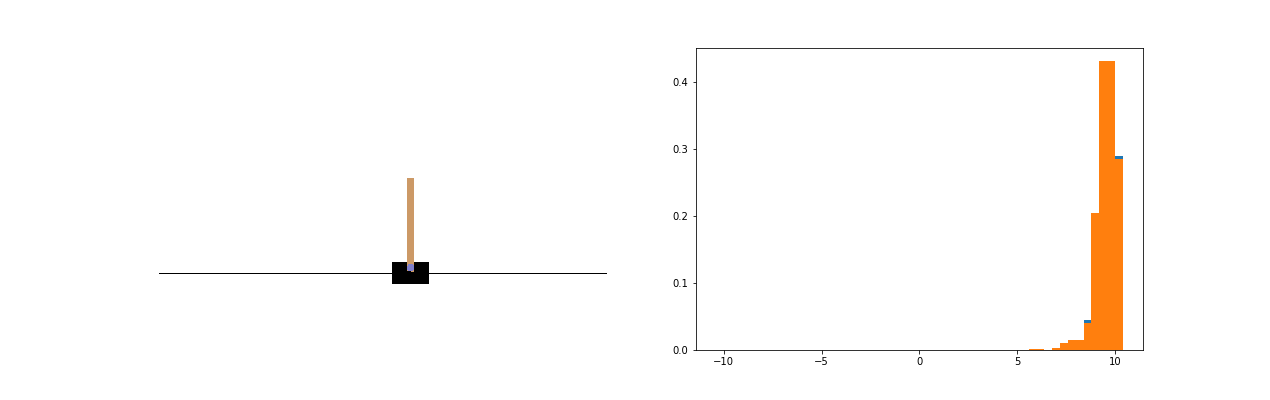
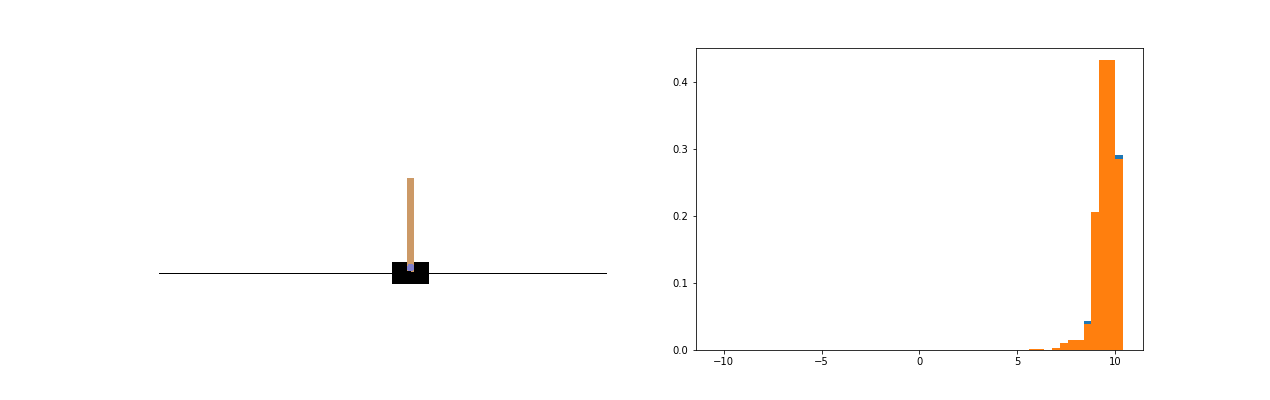
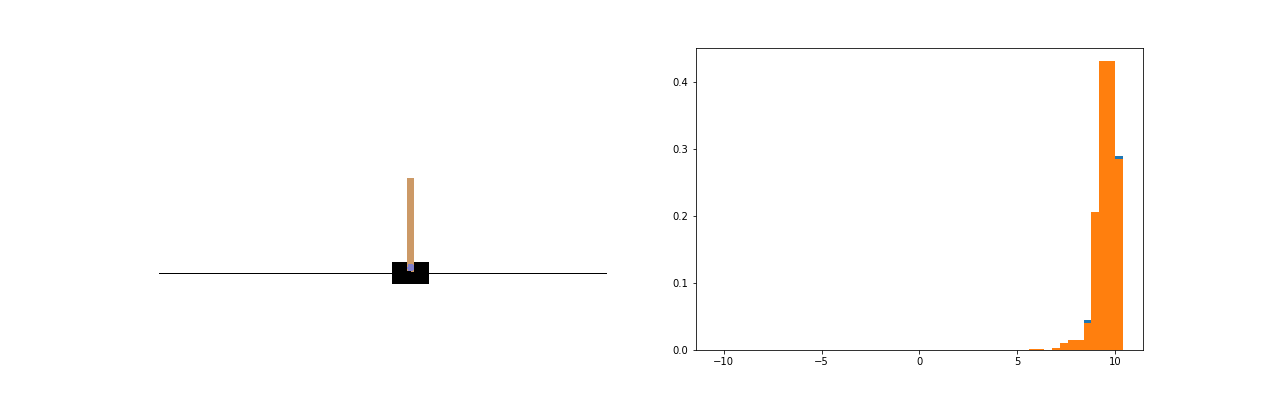
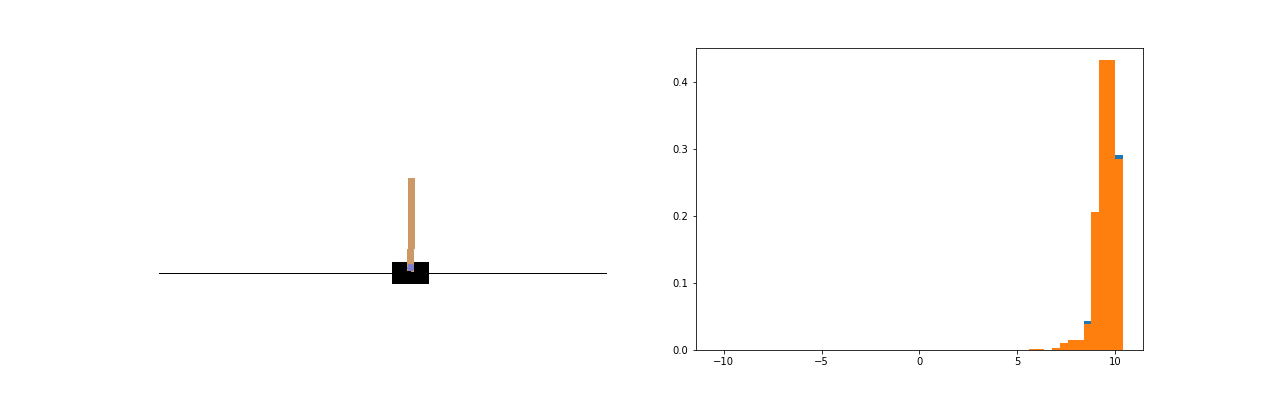
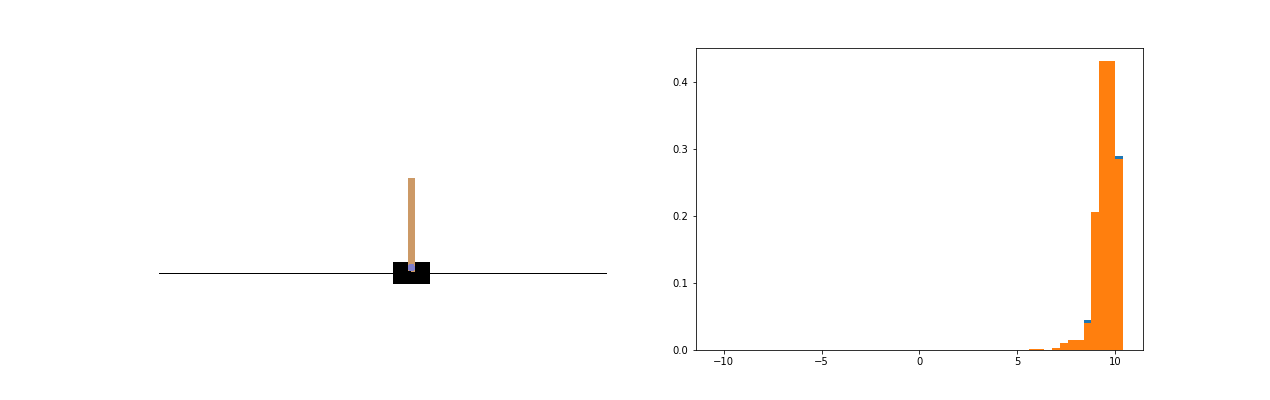
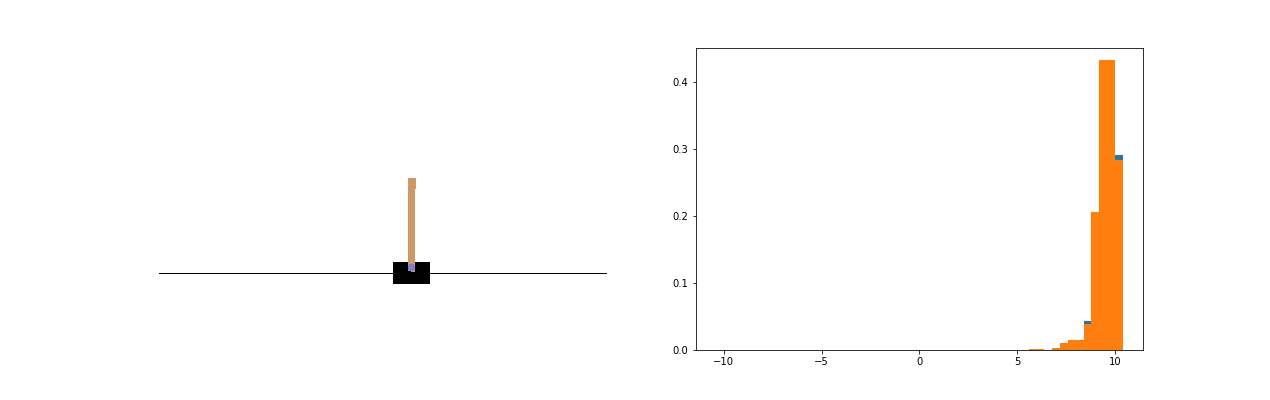
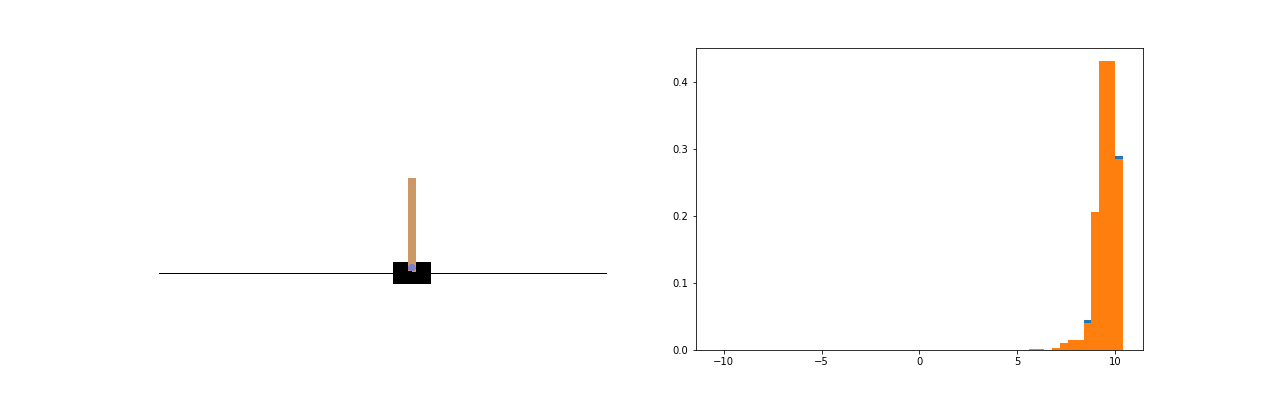
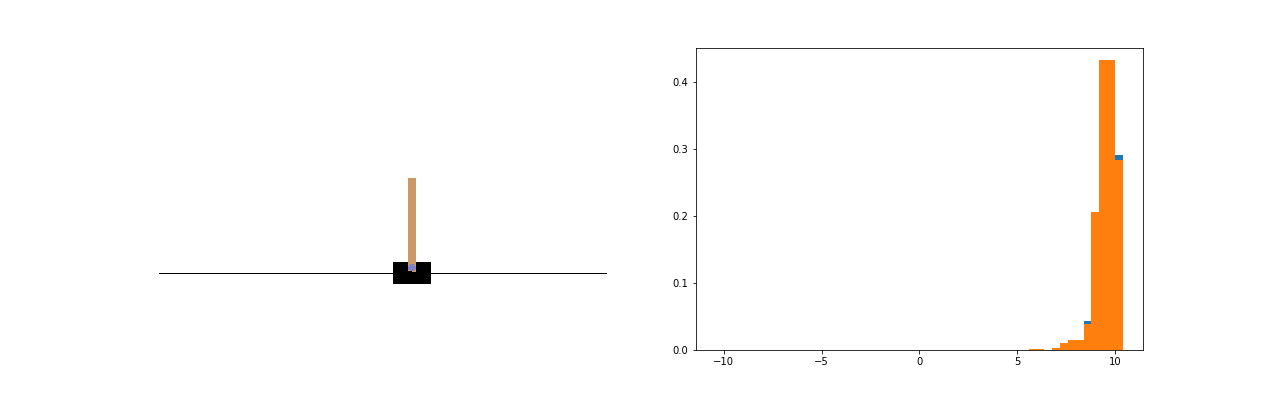
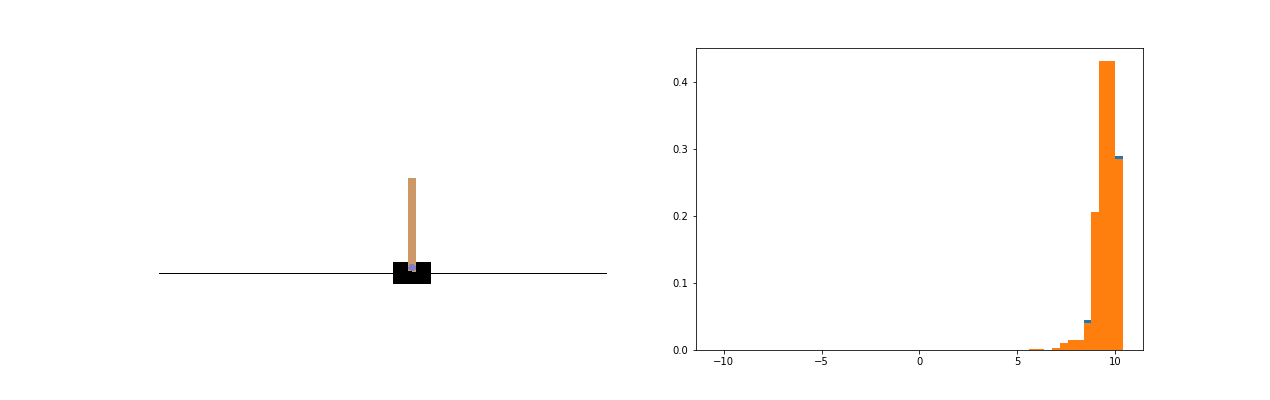
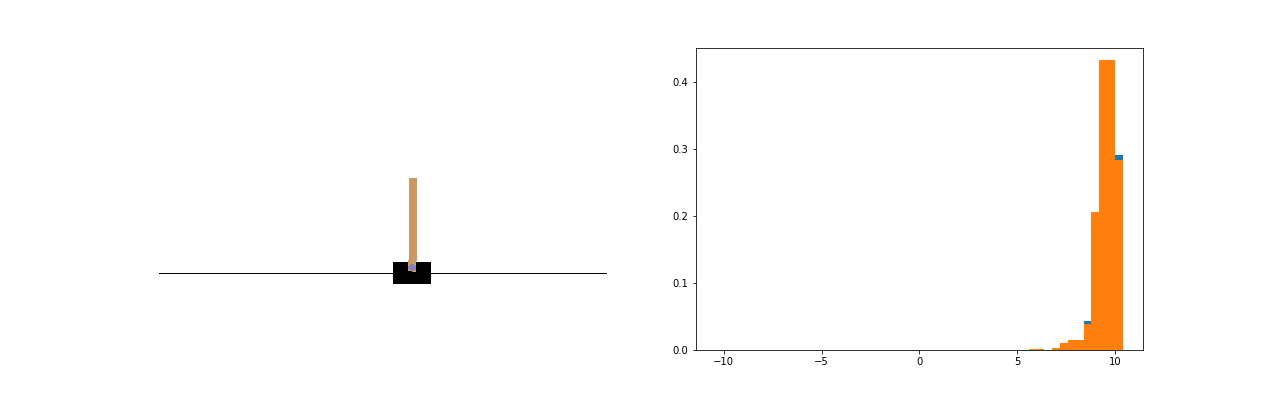
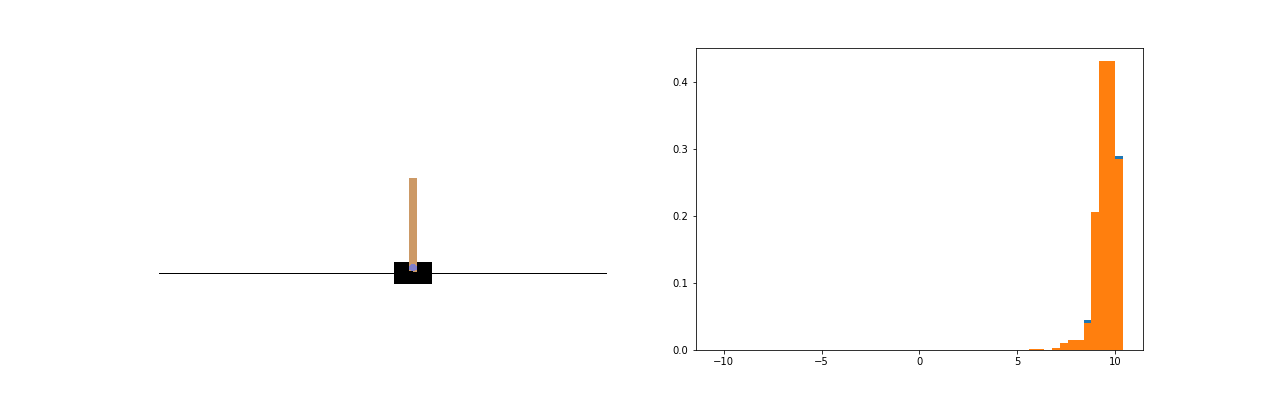
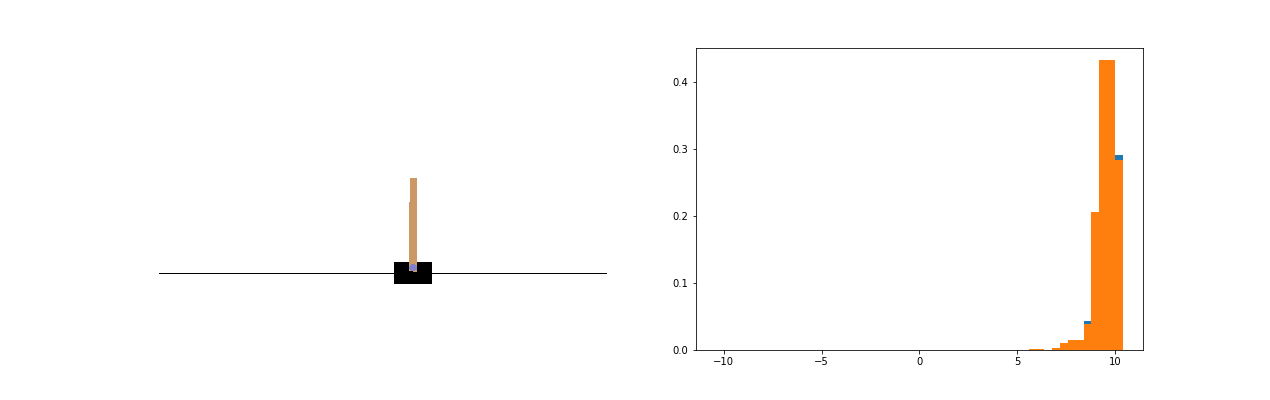
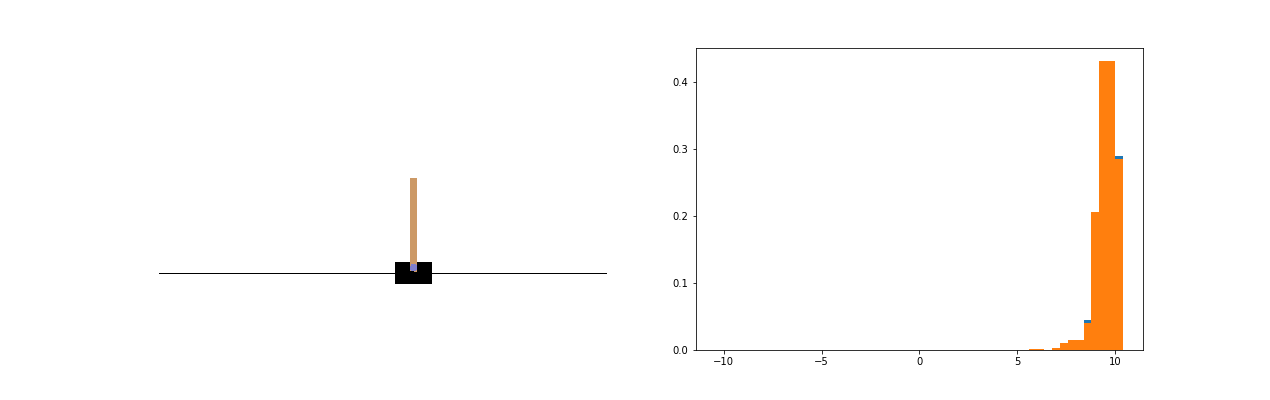
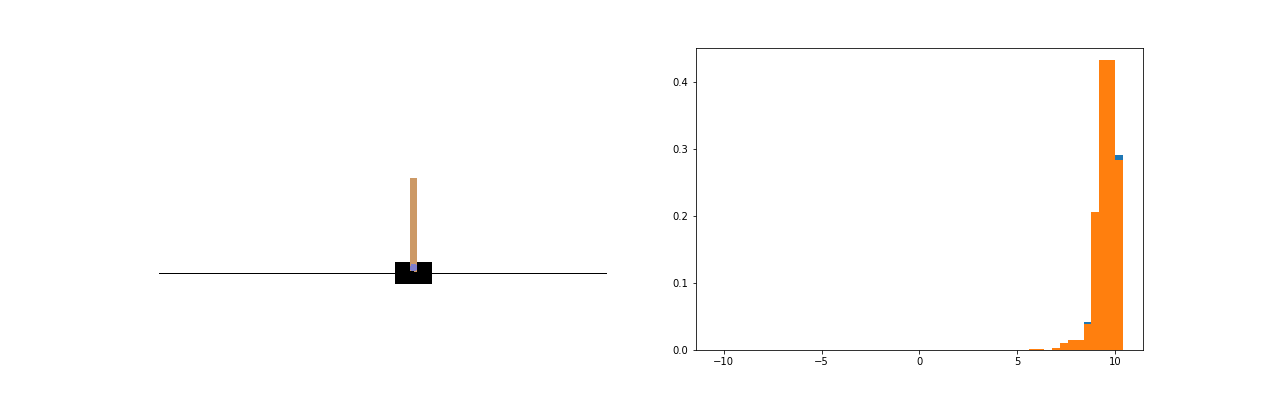
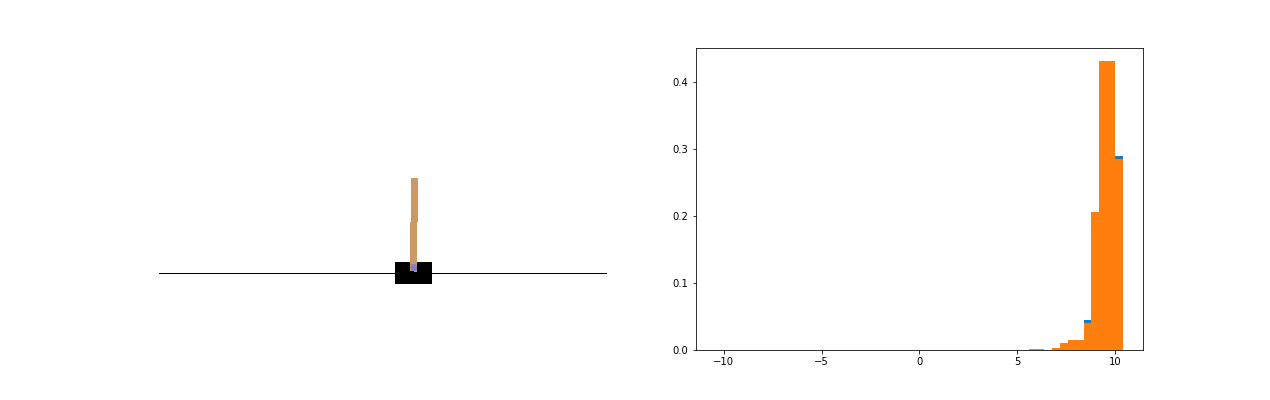
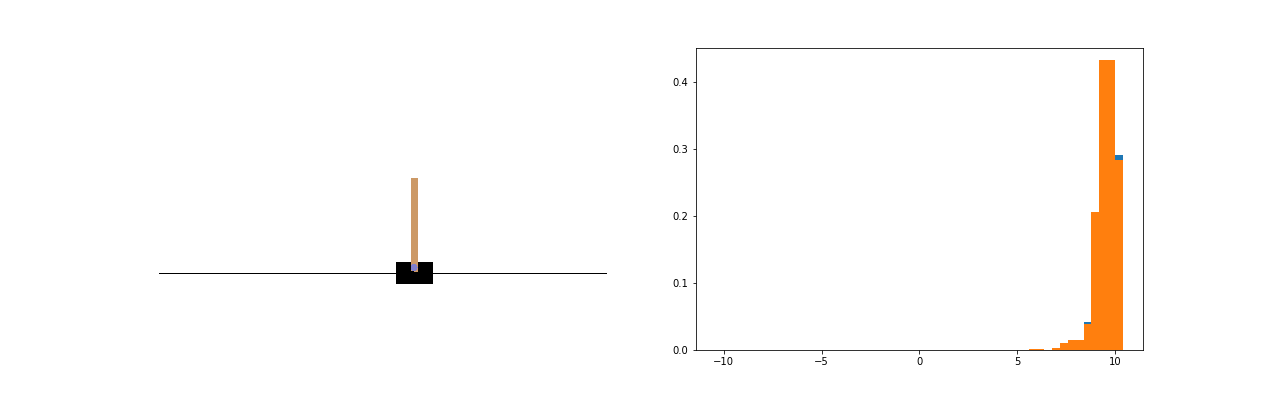
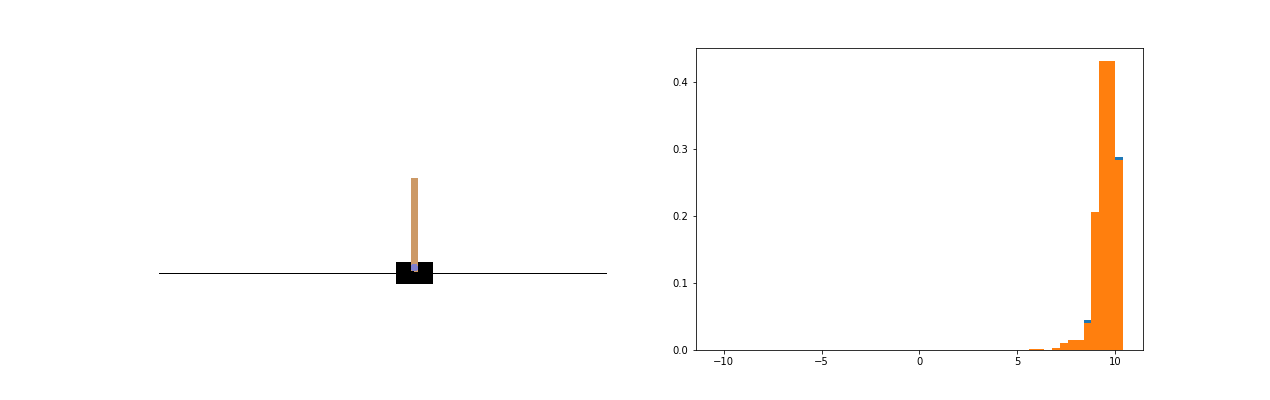
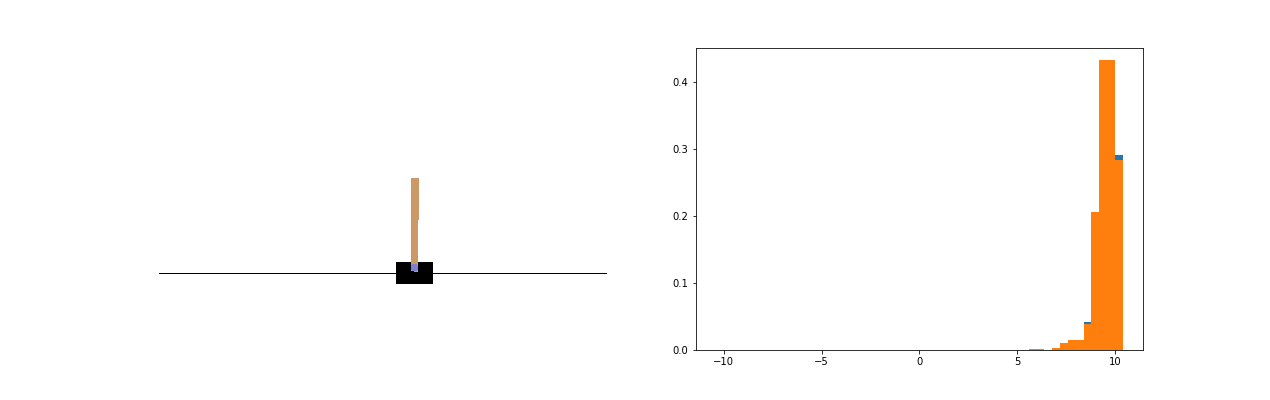
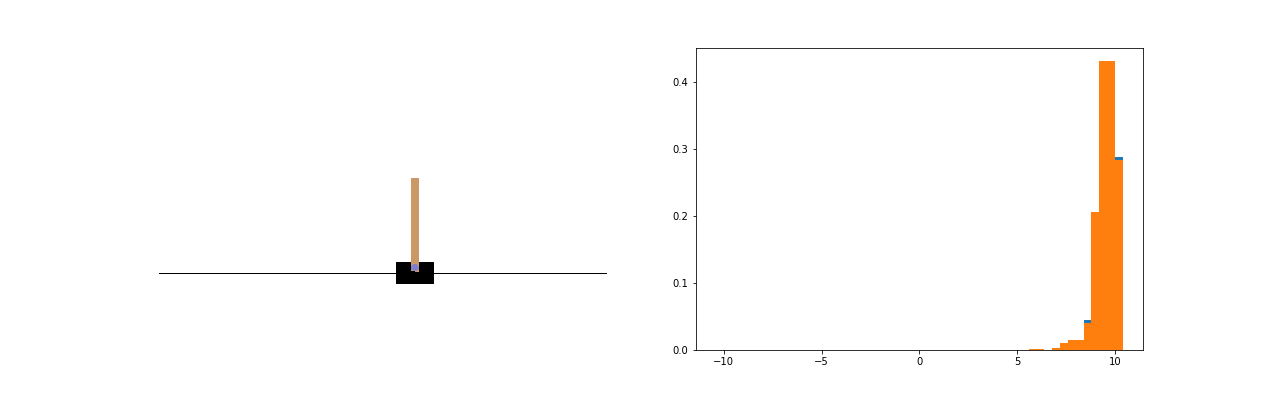
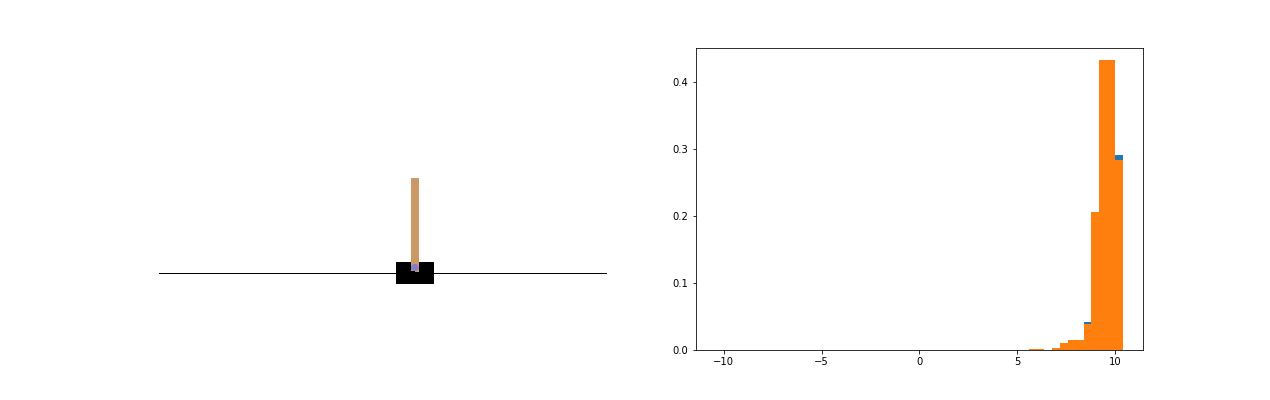
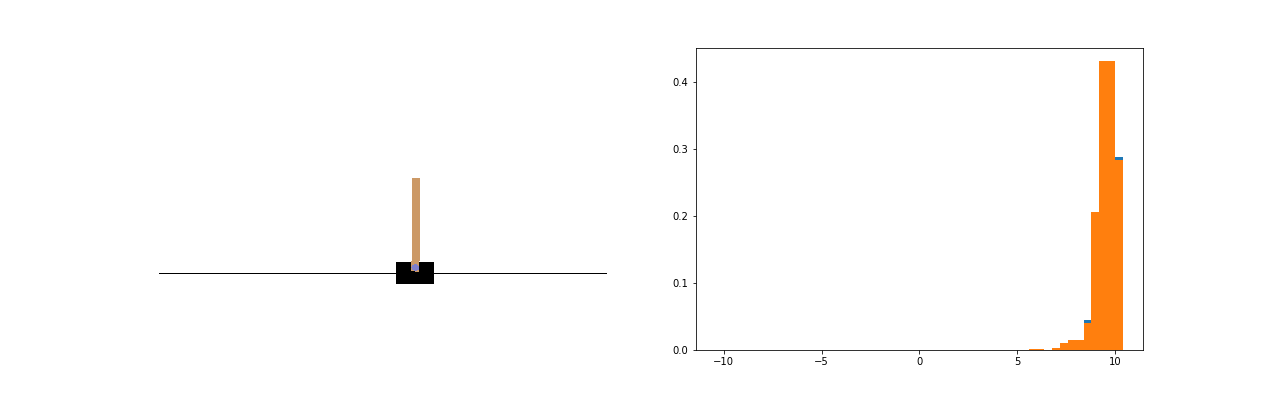
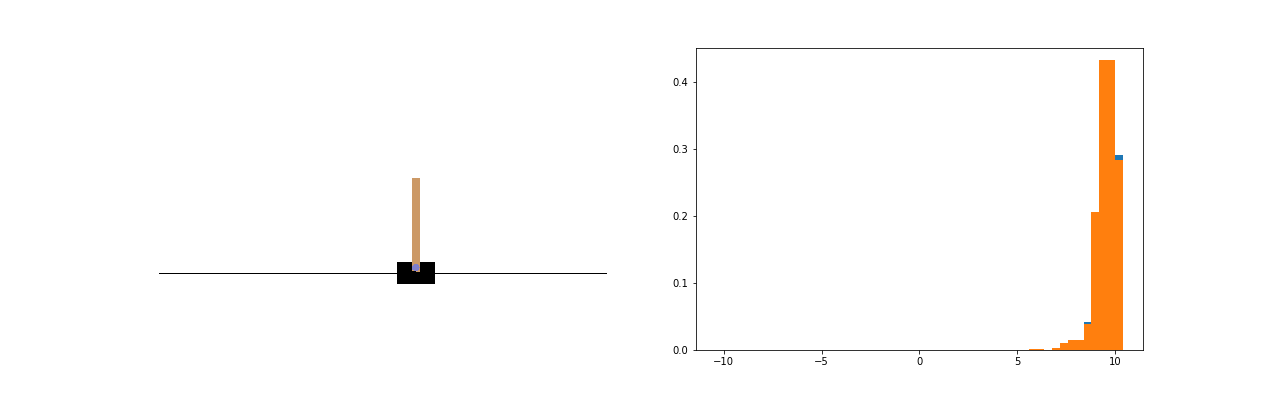
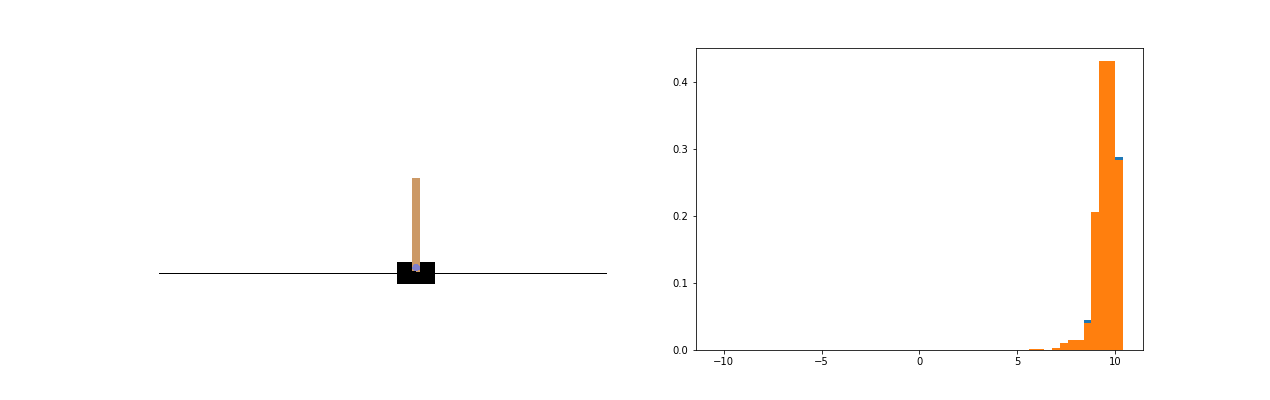
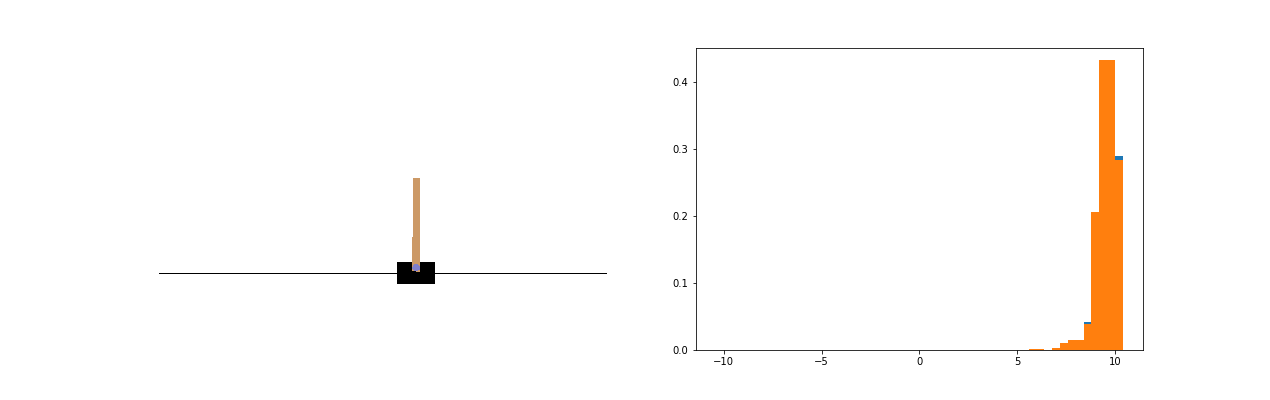
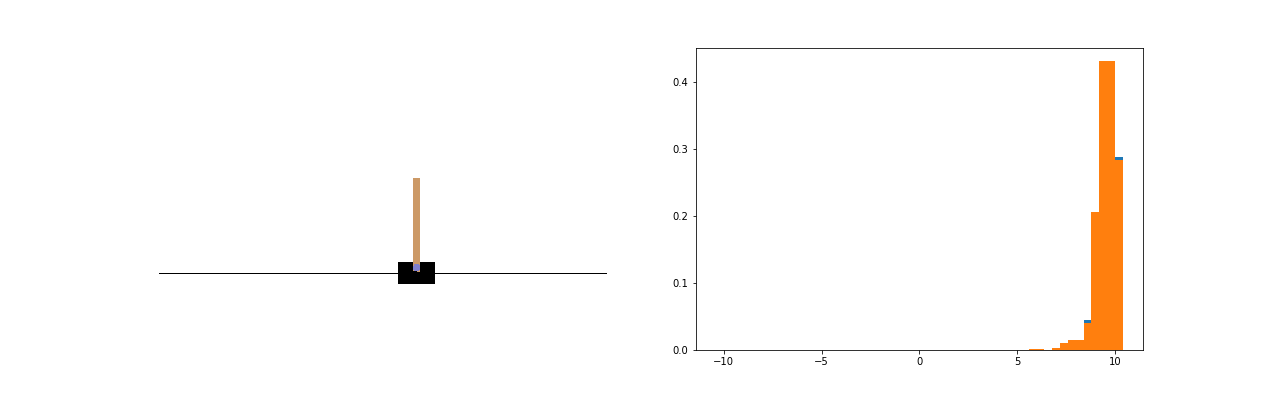
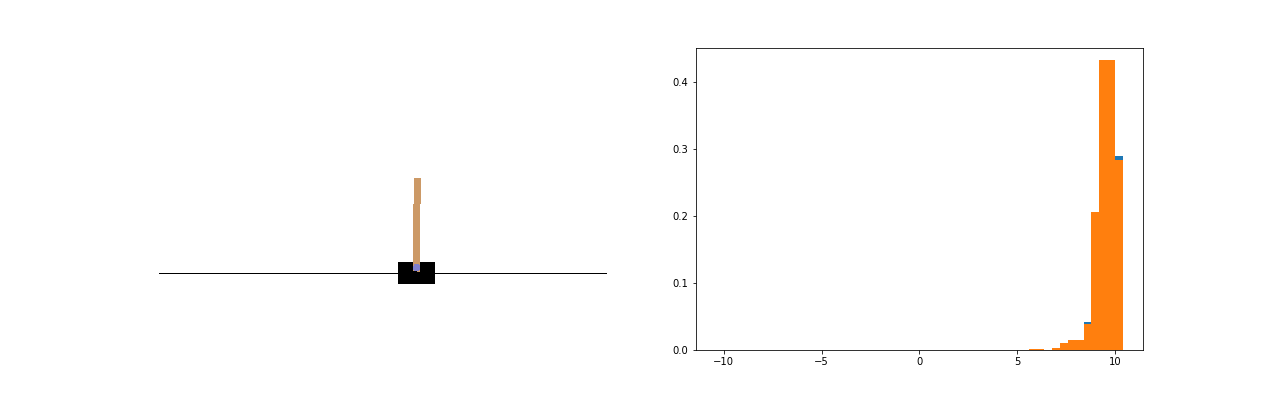
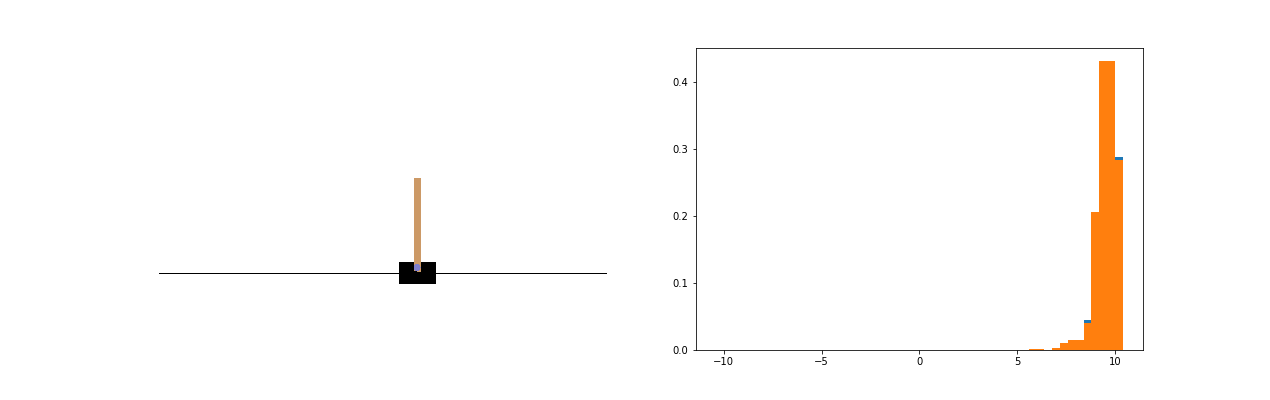
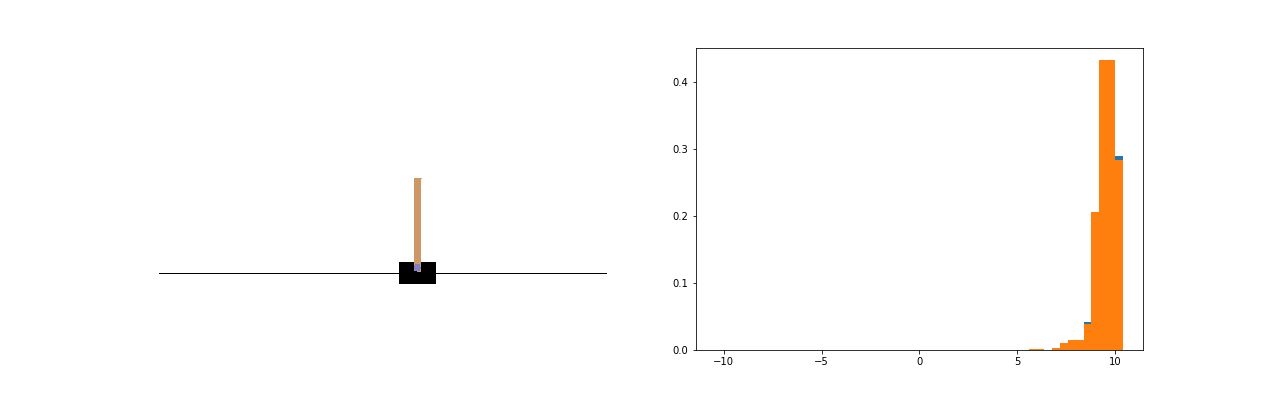
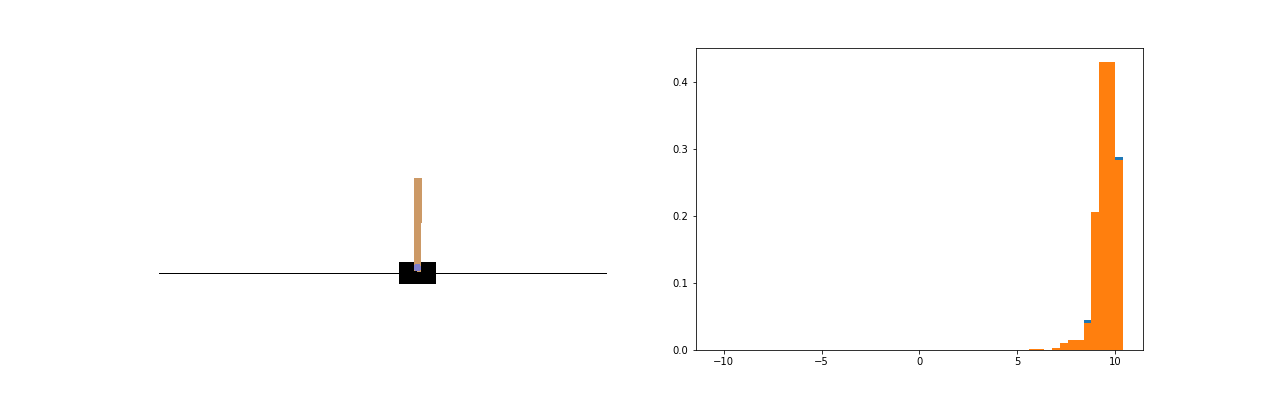
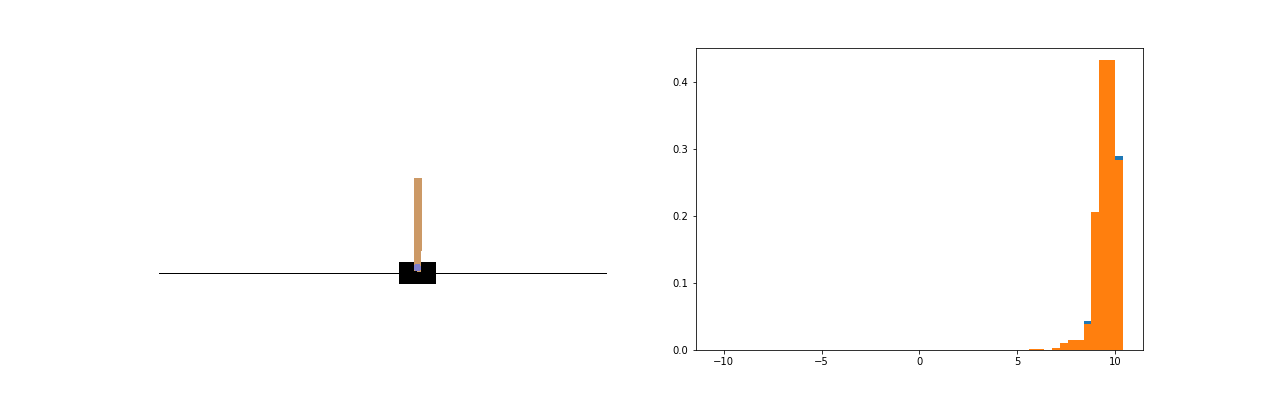
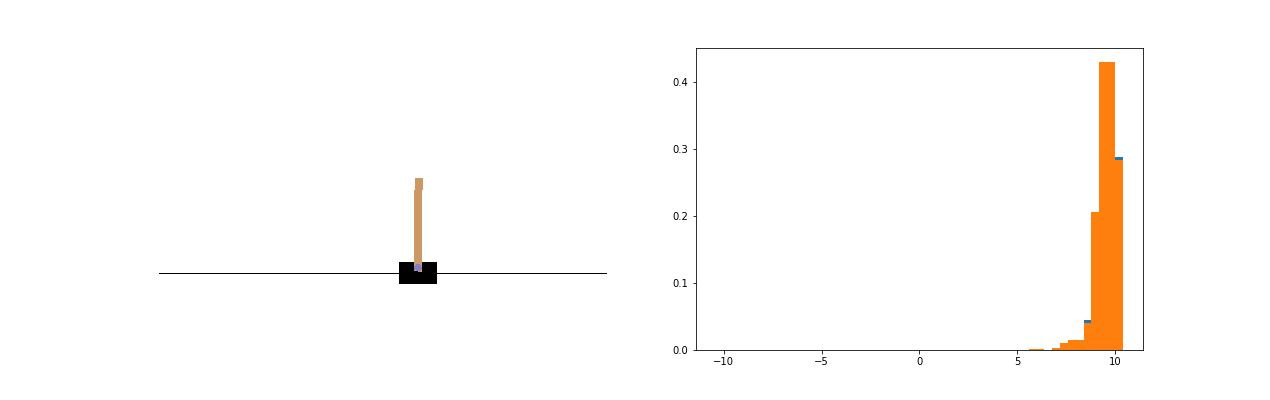
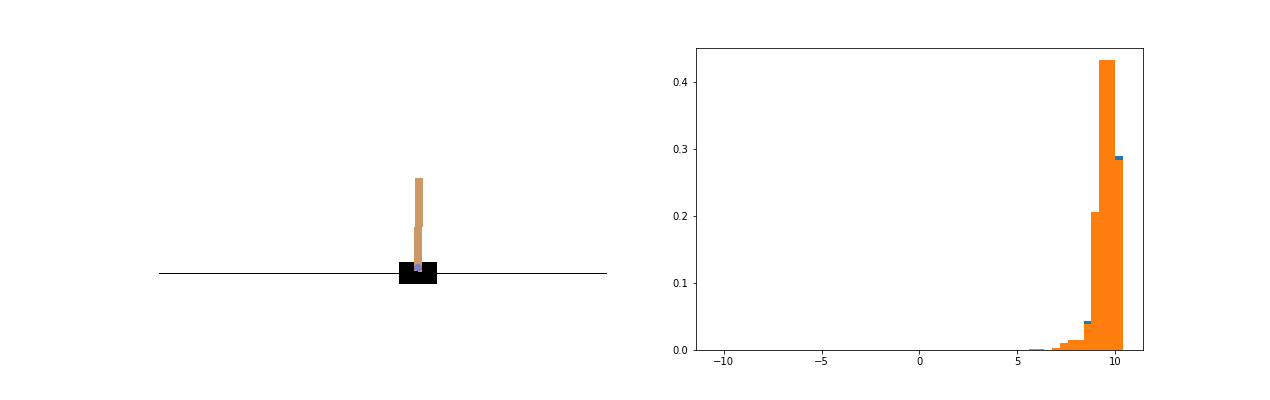
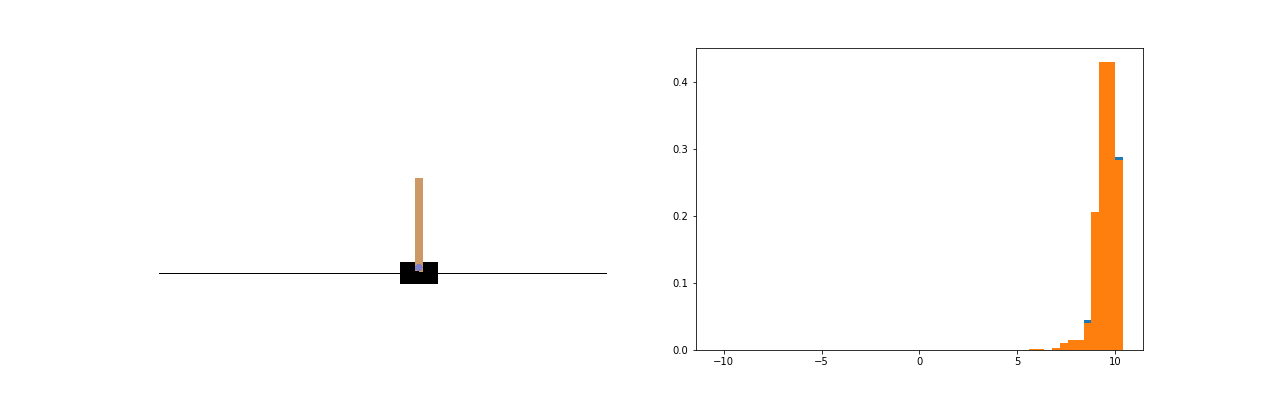
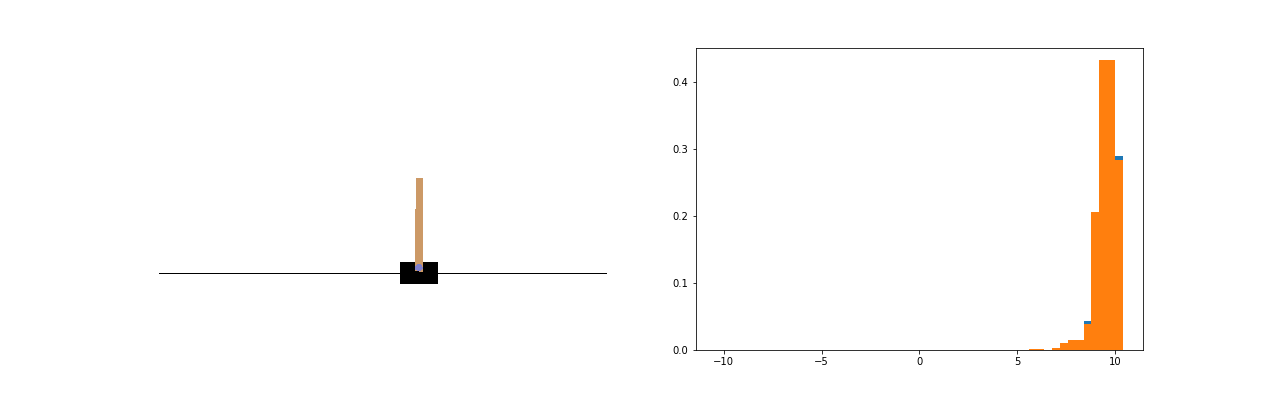
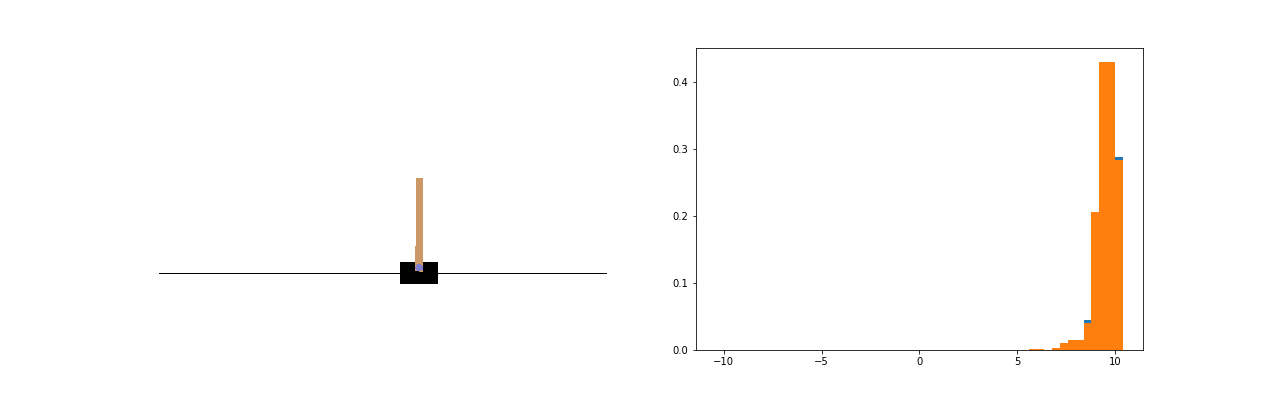
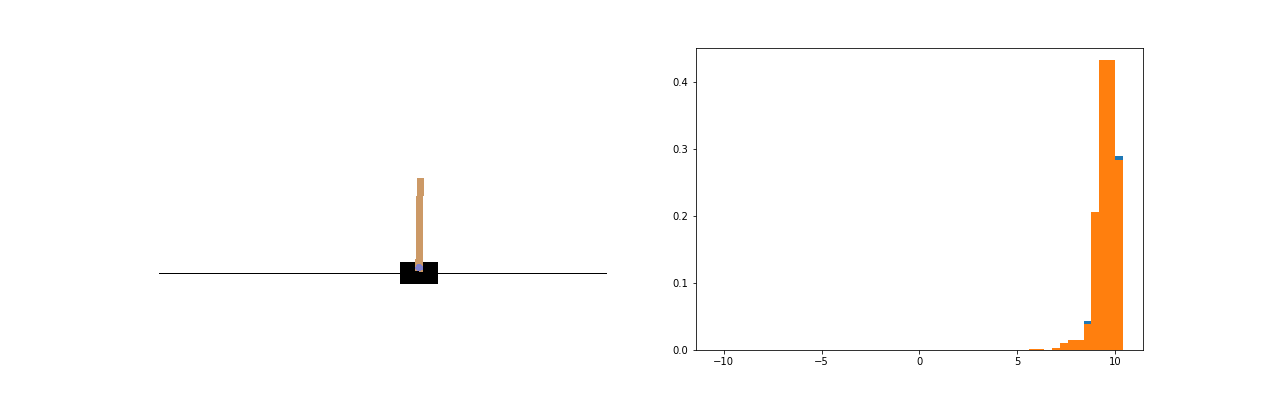
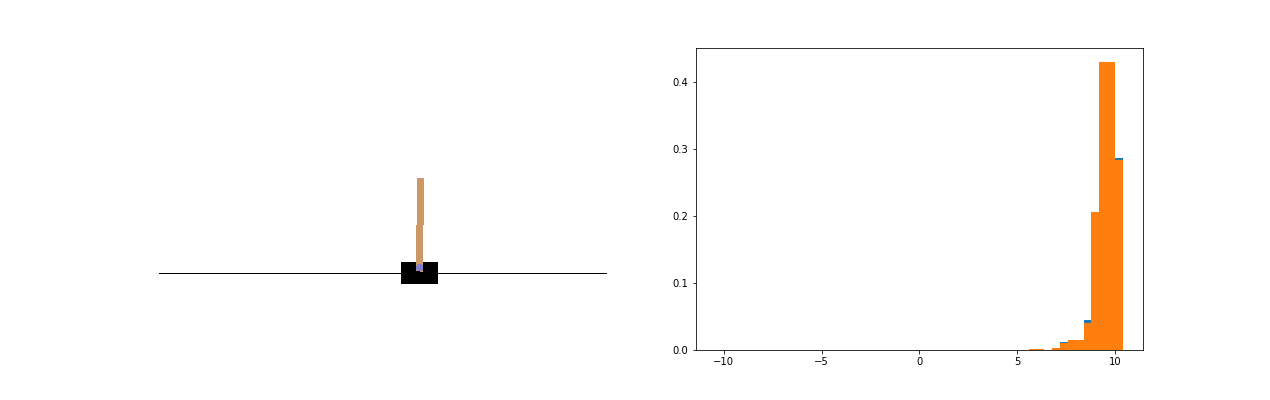
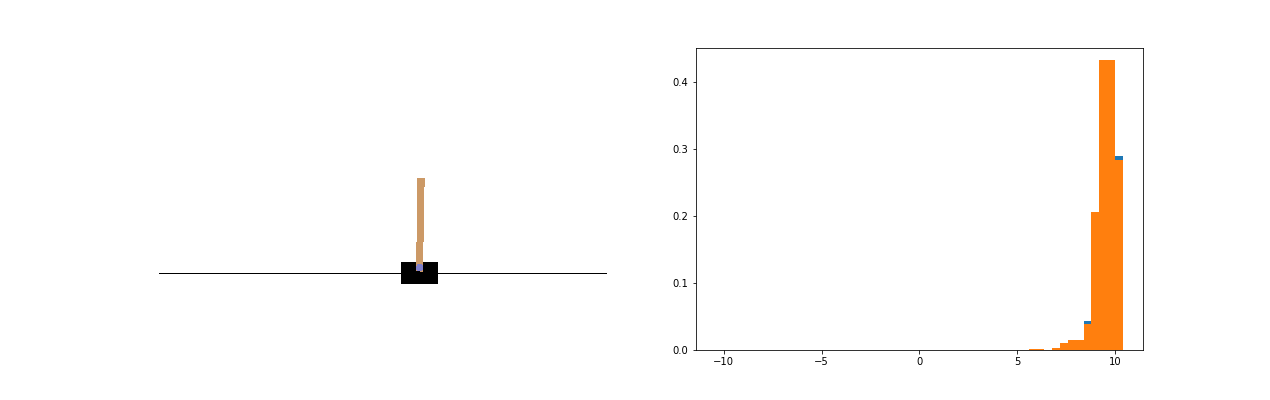
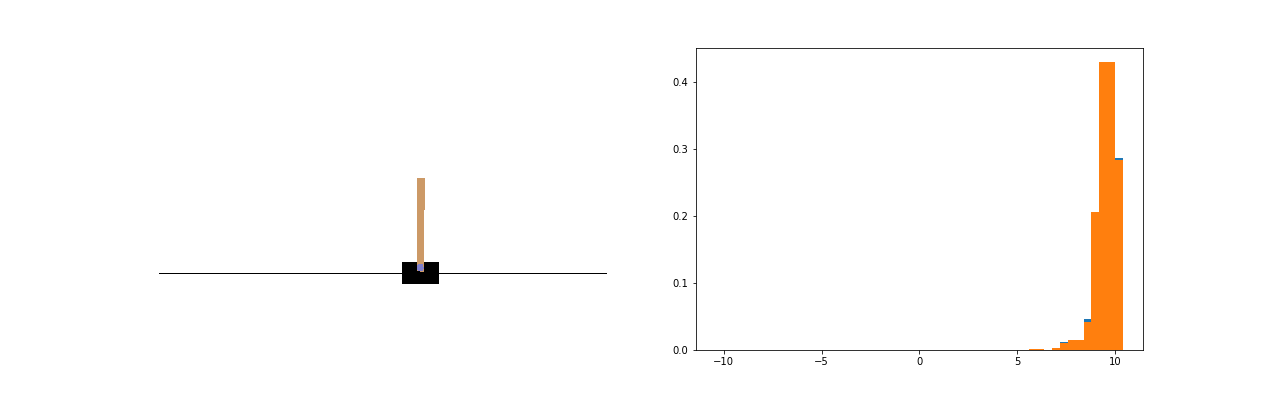
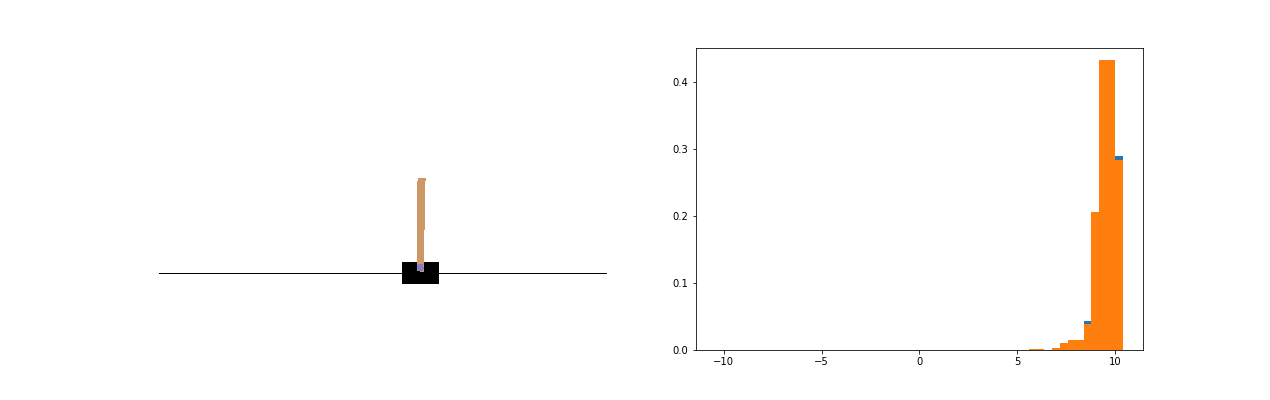
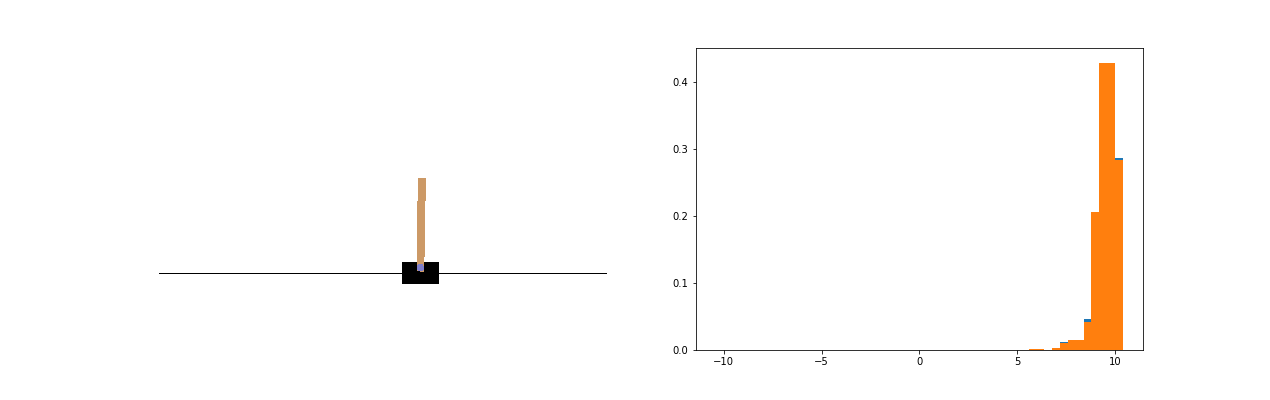
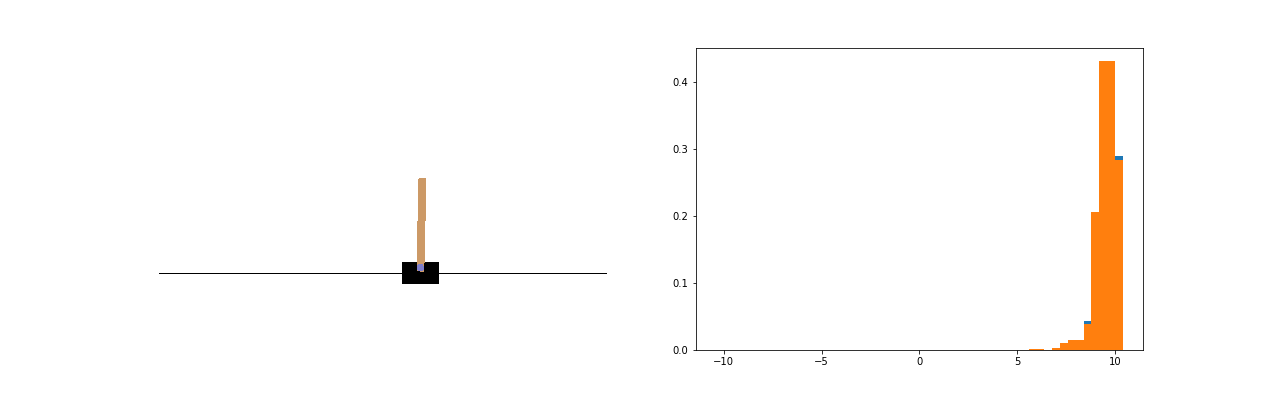
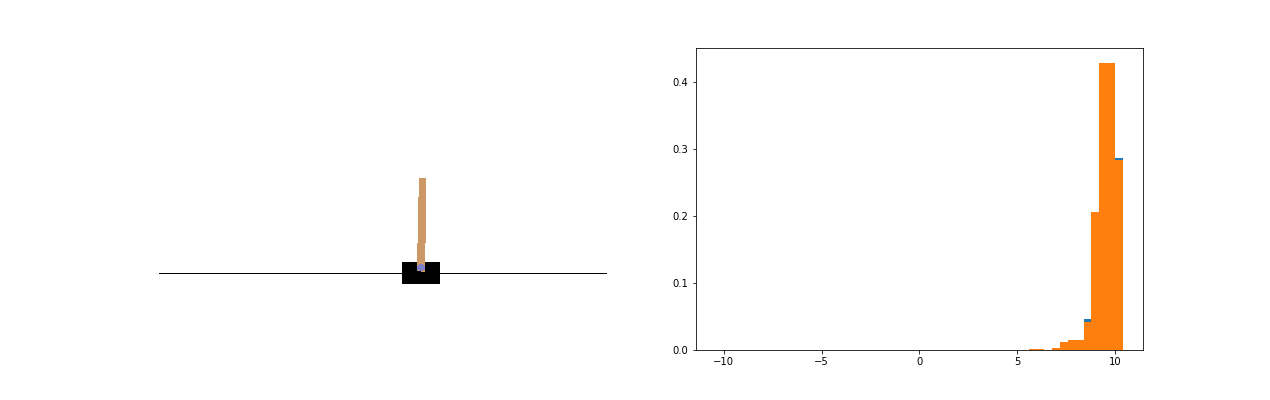
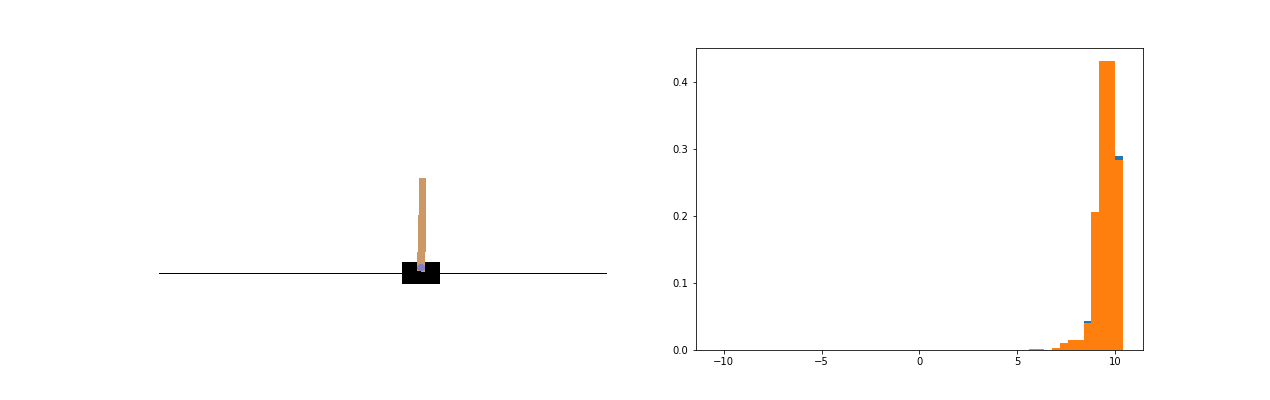
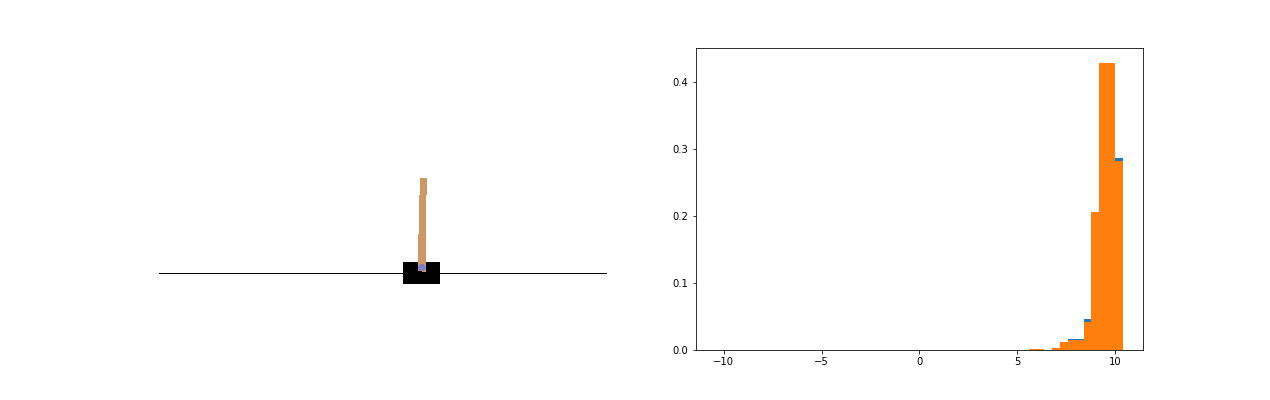
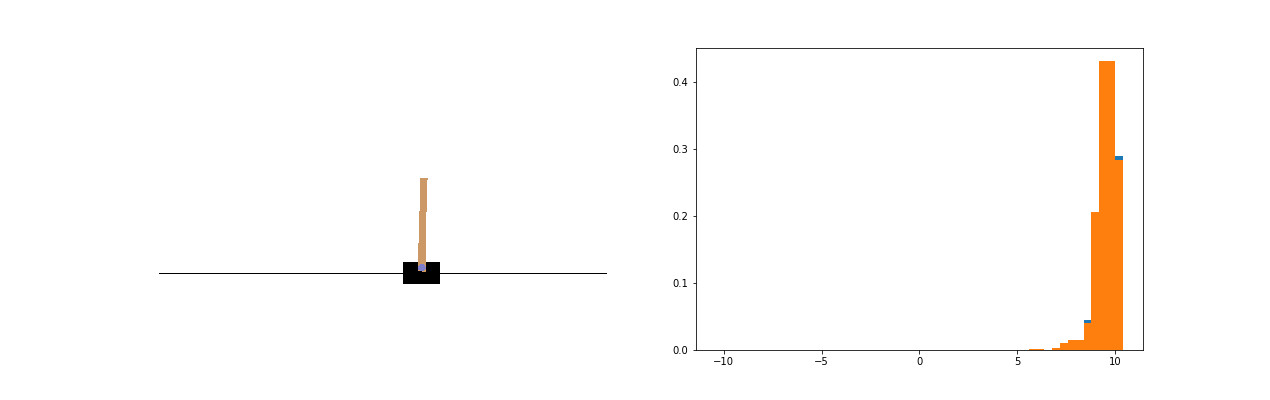
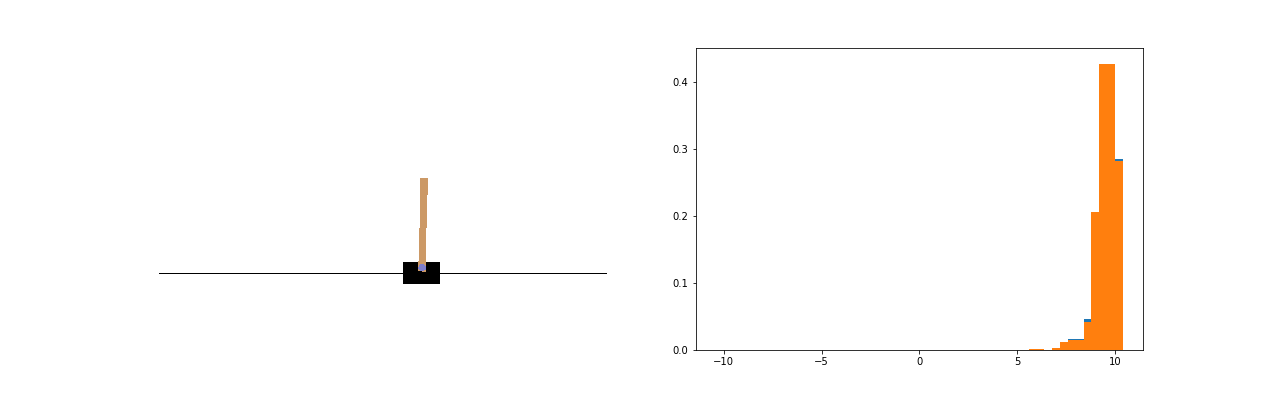
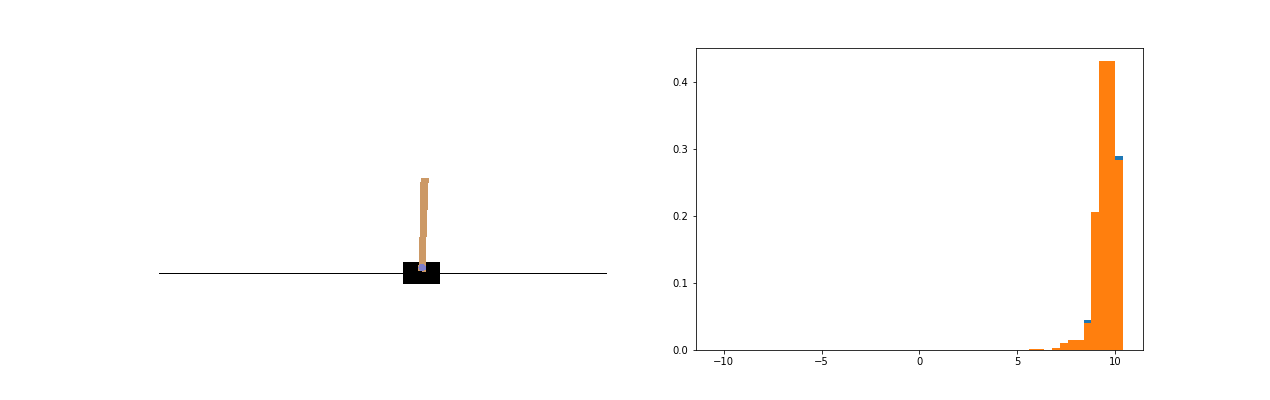
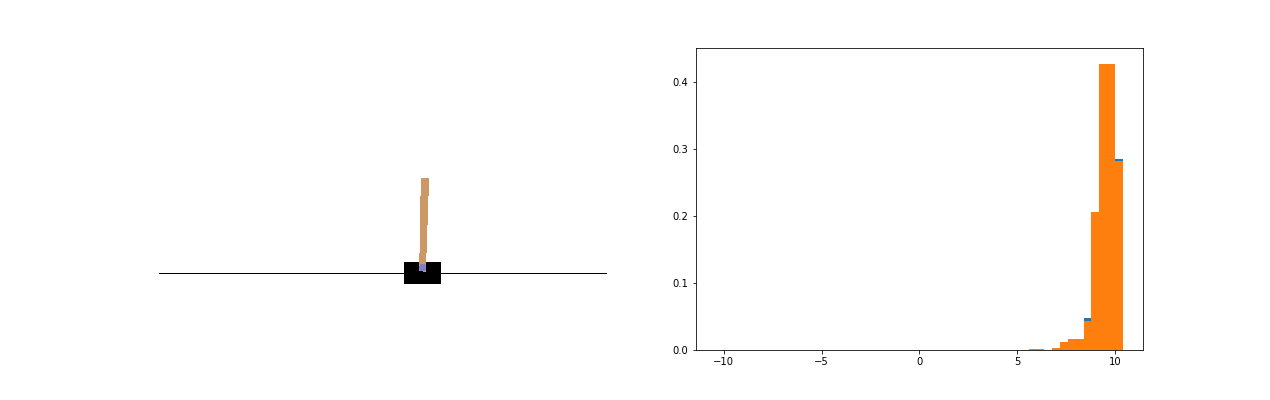
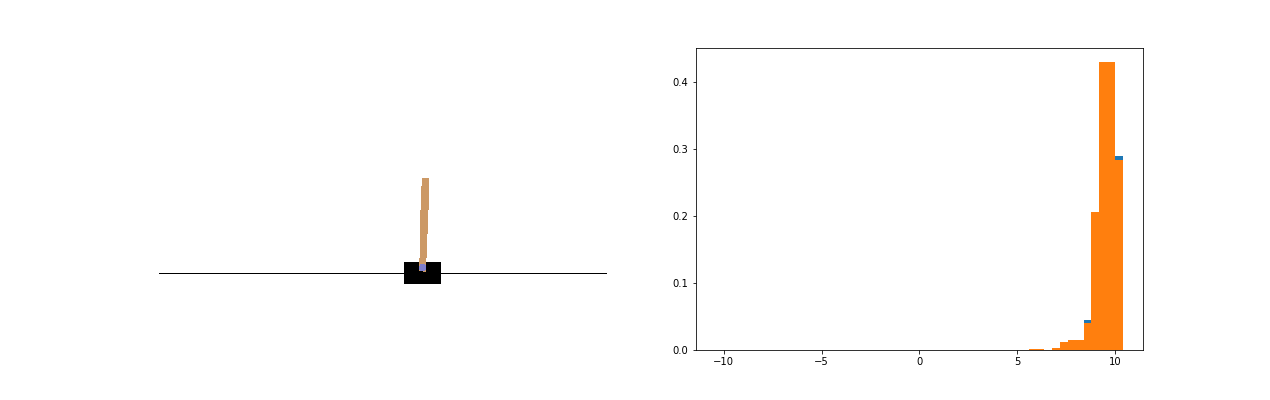
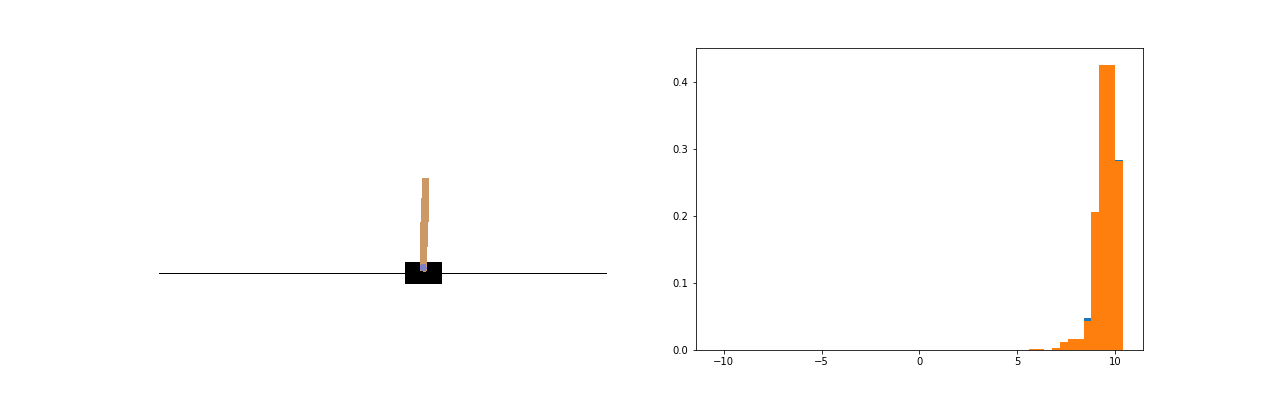
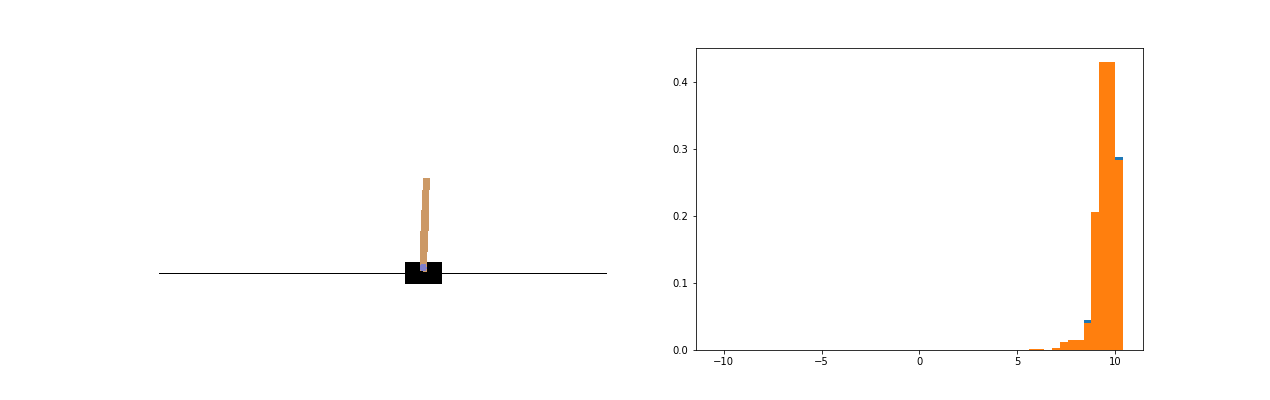
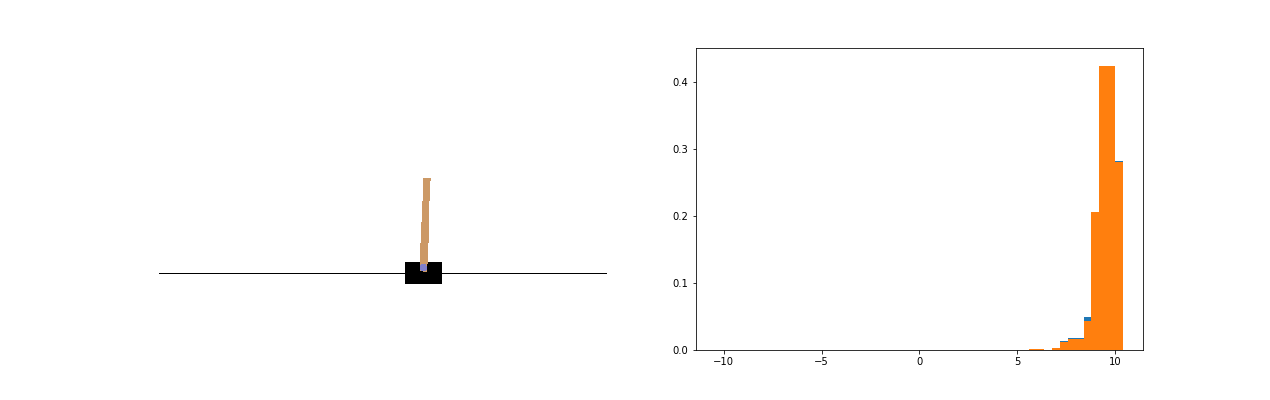
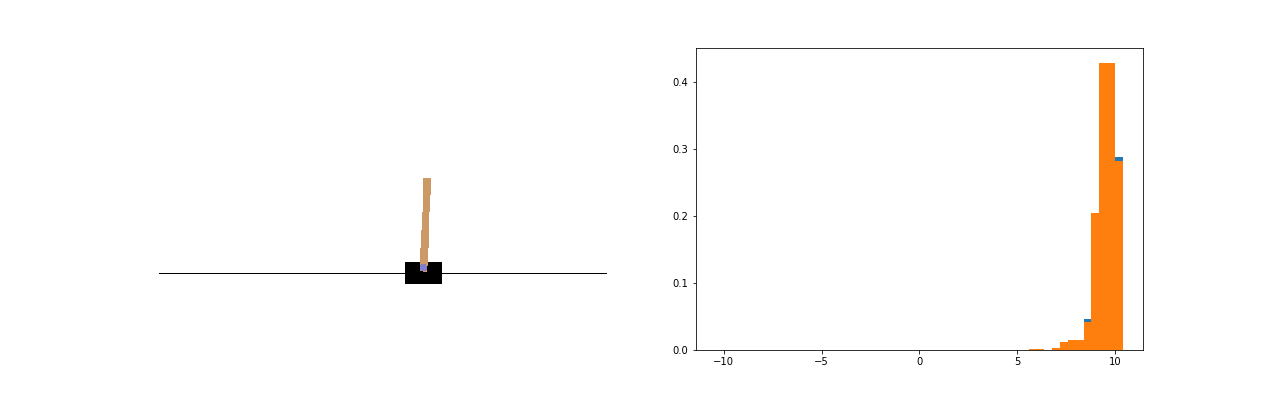

200.0

In [27]:
agent.play(learn=False, record=True)

In [28]:
env.close()